In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'FreeHandV2'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(165000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.freehand_v2(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        272       
_________________________________________________________________
dense (Dense)                (None, 2, 128, 256)       4352      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 128, 32)        32800     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 64, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0     

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/162 [..............................] - ETA: 31:32 - loss: 2.3979

  2/162 [..............................] - ETA: 9s - loss: 2.3979   

  3/162 [..............................] - ETA: 9s - loss: 2.3979

  4/162 [..............................] - ETA: 9s - loss: 2.3980

  5/162 [..............................] - ETA: 9s - loss: 2.3980

  6/162 [>.............................] - ETA: 9s - loss: 2.3980

  7/162 [>.............................] - ETA: 9s - loss: 2.3979

  8/162 [>.............................] - ETA: 9s - loss: 2.3979

  9/162 [>.............................] - ETA: 9s - loss: 2.3979

 10/162 [>.............................] - ETA: 9s - loss: 2.3979

 11/162 [=>............................] - ETA: 9s - loss: 2.3979

 12/162 [=>............................]

 - ETA: 9s - loss: 2.3979

 13/162 [=>............................] - ETA: 9s - loss: 2.3979

 14/162 [=>............................] - ETA: 8s - loss: 2.3979

 15/162 [=>............................] - ETA: 8s - loss: 2.3979

 16/162 [=>............................] - ETA: 8s - loss: 2.3979

 17/162 [==>...........................] - ETA: 8s - loss: 2.3979

 18/162 [==>...........................] - ETA: 8s - loss: 2.3979

 19/162 [==>...........................] - ETA: 8s - loss: 2.3978

 20/162 [==>...........................] - ETA: 8s - loss: 2.3978



 21/162 [==>...........................] - ETA: 8s - loss: 2.3978

 22/162 [===>..........................] - ETA: 8s - loss: 2.3978

 23/162 [===>..........................] - ETA: 8s - loss: 2.3978

 24/162 [===>..........................] - ETA: 8s - loss: 2.3977

 25/162 [===>..........................] - ETA: 8s - loss: 2.3977

 26/162 [===>..........................] - ETA: 8s - loss: 2.3977

 27/162 [====>.........................] - ETA: 8s - loss: 2.3976

 28/162 [====>.........................] - ETA: 8s - loss: 2.3976

 29/162 [====>.........................] - ETA: 8s - loss: 2.3975

 30/162 [====>.........................] - ETA: 8s - loss: 2.3974

 31/162 [====>.........................] - ETA: 7s - loss: 2.3973

 32/162 [====>.........................] - ETA: 7s - loss: 2.3972

 33/162 [=====>........................] - ETA: 7s - loss: 2.3971

 34/162 [=====>........................] - ETA: 7s - loss: 2.3970

 35/162 [=====>........................] - ETA: 7s - loss: 2.3968

 36/162 [=====>........................] - ETA: 7s - loss: 2.3967

 37/162 [=====>........................] - ETA: 7s - loss: 2.3965

 38/162 [======>.......................] - ETA: 7s - loss: 2.3963

 39/162 [======>.......................] - ETA: 7s - loss: 2.3961

 40/162 [======>.......................] - ETA: 7s - loss: 2.3959

 41/162 [======>.......................] - ETA: 7s - loss: 2.3956

 42/162 [======>.......................] - ETA: 7s - loss: 2.3954

 43/162 [======>.......................] - ETA: 7s - loss: 2.3951

 44/162 [=======>......................] - ETA: 7s - loss: 2.3947

 45/162 [=======>......................] - ETA: 7s - loss: 2.3944

 46/162 [=======>......................] - ETA: 7s - loss: 2.3940

 47/162 [=======>......................] - ETA: 6s - loss: 2.3936

 48/162 [=======>......................] - ETA: 6s - loss: 2.3932

 49/162 [========>.....................] - ETA: 6s - loss: 2.3927

 50/162 [========>.....................] - ETA: 6s - loss: 2.3923

 51/162 [========>.....................] - ETA: 6s - loss: 2.3918

 52/162 [========>.....................] - ETA: 6s - loss: 2.3913

 53/162 [========>.....................] - ETA: 6s - loss: 2.3907

 54/162 [=========>....................] - ETA: 6s - loss: 2.3902

 55/162 [=========>....................] - ETA: 6s - loss: 2.3896

 56/162 [=========>....................] - ETA: 6s - loss: 2.3890

 57/162 [=========>....................] - ETA: 6s - loss: 2.3885

 58/162 [=========>....................] - ETA: 6s - loss: 2.3878

 59/162 [=========>....................] - ETA: 6s - loss: 2.3872

 60/162 [==========>...................] - ETA: 6s - loss: 2.3866

 61/162 [==========>...................] - ETA: 6s - loss: 2.3860

 62/162 [==========>...................] - ETA: 6s - loss: 2.3854

 63/162 [==========>...................] - ETA: 6s - loss: 2.3848

 64/162 [==========>...................] - ETA: 5s - loss: 2.3841

 65/162 [===========>..................] - ETA: 5s - loss: 2.3835

 66/162 [===========>..................]

 - ETA: 5s - loss: 2.3828

 67/162 [===========>..................] - ETA: 5s - loss: 2.3821

 68/162 [===========>..................] - ETA: 5s - loss: 2.3815

 69/162 [===========>..................] - ETA: 5s - loss: 2.3808

 70/162 [===========>..................] - ETA: 5s - loss: 2.3801

 71/162 [============>.................] - ETA: 5s - loss: 2.3794

 72/162 [============>.................] - ETA: 5s - loss: 2.3787

 73/162 [============>.................] - ETA: 5s - loss: 2.3779

 74/162 [============>.................] - ETA: 5s - loss: 2.3772

 75/162 [============>.................] - ETA: 5s - loss: 2.3765

 76/162 [=============>................] - ETA: 5s - loss: 2.3757

 77/162 [=============>................] - ETA: 5s - loss: 2.3750



 78/162 [=============>................] - ETA: 5s - loss: 2.3742



 79/162 [=============>................] - ETA: 5s - loss: 2.3735



 80/162 [=============>................] - ETA: 4s - loss: 2.3727



 81/162 [==============>...............] - ETA: 4s - loss: 2.3719



 82/162 [==============>...............] - ETA: 4s - loss: 2.3712

 83/162 [==============>...............] - ETA: 4s - loss: 2.3704

 84/162 [==============>...............] - ETA: 4s - loss: 2.3697

 85/162 [==============>...............] - ETA: 4s - loss: 2.3689

 86/162 [==============>...............] - ETA: 4s - loss: 2.3681

 87/162 [===============>..............] - ETA: 4s - loss: 2.3674

 88/162 [===============>..............] - ETA: 4s - loss: 2.3666

 89/162 [===============>..............] - ETA: 4s - loss: 2.3658

 90/162 [===============>..............] - ETA: 4s - loss: 2.3651

 91/162 [===============>..............] - ETA: 4s - loss: 2.3643

 92/162 [================>.............] - ETA: 4s - loss: 2.3635

 93/162 [================>.............] - ETA: 4s - loss: 2.3628

 94/162 [================>.............] - ETA: 4s - loss: 2.3620

 95/162 [================>.............] - ETA: 4s - loss: 2.3612

 96/162 [================>.............] - ETA: 3s - loss: 2.3605

 97/162 [================>.............] - ETA: 3s - loss: 2.3597

 98/162 [=================>............] - ETA: 3s - loss: 2.3590

 99/162 [=================>............] - ETA: 3s - loss: 2.3582

100/162 [=================>............] - ETA: 3s - loss: 2.3575

101/162 [=================>............] - ETA: 3s - loss: 2.3567

102/162 [=================>............] - ETA: 3s - loss: 2.3560

103/162 [==================>...........] - ETA: 3s - loss: 2.3552

104/162 [==================>...........] - ETA: 3s - loss: 2.3545

105/162 [==================>...........] - ETA: 3s - loss: 2.3537

106/162 [==================>...........] - ETA: 3s - loss: 2.3530

107/162 [==================>...........] - ETA: 3s - loss: 2.3522

108/162 [===================>..........] - ETA: 3s - loss: 2.3515

109/162 [===================>..........] - ETA: 3s - loss: 2.3507

110/162 [===================>..........] - ETA: 3s - loss: 2.3500

111/162 [===================>..........] - ETA: 3s - loss: 2.3493

112/162 [===================>..........] - ETA: 3s - loss: 2.3485

113/162 [===================>..........] - ETA: 2s - loss: 2.3478

114/162 [====================>.........] - ETA: 2s - loss: 2.3471

115/162 [====================>.........] - ETA: 2s - loss: 2.3463

116/162 [====================>.........] - ETA: 2s - loss: 2.3456

117/162 [====================>.........] - ETA: 2s - loss: 2.3449

118/162 [====================>.........] - ETA: 2s - loss: 2.3442

119/162 [=====================>........] - ETA: 2s - loss: 2.3434

120/162 [=====================>........] - ETA: 2s - loss: 2.3427

121/162 [=====================>........] - ETA: 2s - loss: 2.3420

122/162 [=====================>........] - ETA: 2s - loss: 2.3413

123/162 [=====================>........] - ETA: 2s - loss: 2.3406

124/162 [=====================>........] - ETA: 2s - loss: 2.3399

125/162 [======================>.......] - ETA: 2s - loss: 2.3391

126/162 [======================>.......] - ETA: 2s - loss: 2.3384

127/162 [======================>.......] - ETA: 2s - loss: 2.3377

128/162 [======================>.......] - ETA: 2s - loss: 2.3370

129/162 [======================>.......] - ETA: 1s - loss: 2.3363

130/162 [=======================>......] - ETA: 1s - loss: 2.3356

131/162 [=======================>......] - ETA: 1s - loss: 2.3349

132/162 [=======================>......] - ETA: 1s - loss: 2.3342

133/162 [=======================>......] - ETA: 1s - loss: 2.3335

134/162 [=======================>......] - ETA: 1s - loss: 2.3328

135/162 [========================>.....] - ETA: 1s - loss: 2.3321

136/162 [========================>.....] - ETA: 1s - loss: 2.3314

137/162 [========================>.....] - ETA: 1s - loss: 2.3307

138/162 [========================>.....] - ETA: 1s - loss: 2.3300



139/162 [========================>.....] - ETA: 1s - loss: 2.3293

140/162 [========================>.....] - ETA: 1s - loss: 2.3286

141/162 [=========================>....] - ETA: 1s - loss: 2.3279

142/162 [=========================>....] - ETA: 1s - loss: 2.3272

143/162 [=========================>....] - ETA: 1s - loss: 2.3265

144/162 [=========================>....] - ETA: 1s - loss: 2.3259

145/162 [=========================>....] - ETA: 1s - loss: 2.3252

146/162 [==========================>...] - ETA: 0s - loss: 2.3245

147/162 [==========================>...] - ETA: 0s - loss: 2.3238

148/162 [==========================>...] - ETA: 0s - loss: 2.3231

149/162 [==========================>...] - ETA: 0s - loss: 2.3224

150/162 [==========================>...] - ETA: 0s - loss: 2.3217

151/162 [==========================>...] - ETA: 0s - loss: 2.3211

152/162 [===========================>..] - ETA: 0s - loss: 2.3204

153/162 [===========================>..] - ETA: 0s - loss: 2.3197

154/162 [===========================>..] - ETA: 0s - loss: 2.3190

155/162 [===========================>..] - ETA: 0s - loss: 2.3184

156/162 [===========================>..] - ETA: 0s - loss: 2.3177

157/162 [============================>.] - ETA: 0s - loss: 2.3170

158/162 [============================>.] - ETA: 0s - loss: 2.3163

159/162 [============================>.] - ETA: 0s - loss: 2.3157

160/162 [============================>.] - ETA: 0s - loss: 2.3150

161/162 [============================>.] - ETA: 0s - loss: 2.3143

162/162 [==============================] - ETA: 0s - loss: 2.3137

162/162 [==============================] - 23s 72ms/step - loss: 2.3130 - val_loss: 2.0287


Epoch 2/100
  1/162 [..............................] - ETA: 9s - loss: 2.0758

  2/162 [..............................] - ETA: 10s - loss: 2.0573

  3/162 [..............................] - ETA: 9s - loss: 2.0545 

  4/162 [..............................] - ETA: 9s - loss: 2.0531

  5/162 [..............................] - ETA: 9s - loss: 2.0505

  6/162 [>.............................] - ETA: 9s - loss: 2.0474

  7/162 [>.............................] - ETA: 9s - loss: 2.0441

  8/162 [>.............................] - ETA: 9s - loss: 2.0410

  9/162 [>.............................] - ETA: 9s - loss: 2.0378

 10/162 [>.............................] - ETA: 9s - loss: 2.0348

 11/162 [=>............................]

 - ETA: 9s - loss: 2.0323

 12/162 [=>............................] - ETA: 9s - loss: 2.0300

 13/162 [=>............................] - ETA: 9s - loss: 2.0280

 14/162 [=>............................] - ETA: 9s - loss: 2.0262

 15/162 [=>............................] - ETA: 8s - loss: 2.0246

 16/162 [=>............................] - ETA: 8s - loss: 2.0233

 17/162 [==>...........................] - ETA: 8s - loss: 2.0221

 18/162 [==>...........................] - ETA: 8s - loss: 2.0210

 19/162 [==>...........................] - ETA: 8s - loss: 2.0199

 20/162 [==>...........................] - ETA: 8s - loss: 2.0187

 21/162 [==>...........................] - ETA: 8s - loss: 2.0176

 22/162 [===>..........................] - ETA: 8s - loss: 2.0166

 23/162 [===>..........................] - ETA: 8s - loss: 2.0157

 24/162 [===>..........................] - ETA: 8s - loss: 2.0148

 25/162 [===>..........................] - ETA: 8s - loss: 2.0138

 26/162 [===>..........................] - ETA: 8s - loss: 2.0130

 27/162 [====>.........................] - ETA: 8s - loss: 2.0121

 28/162 [====>.........................] - ETA: 8s - loss: 2.0112

 29/162 [====>.........................] - ETA: 8s - loss: 2.0105

 30/162 [====>.........................] - ETA: 8s - loss: 2.0097

 31/162 [====>.........................] - ETA: 7s - loss: 2.0090

 32/162 [====>.........................] - ETA: 7s - loss: 2.0082

 33/162 [=====>........................] - ETA: 7s - loss: 2.0075

 34/162 [=====>........................] - ETA: 7s - loss: 2.0068

 35/162 [=====>........................] - ETA: 7s - loss: 2.0061

 36/162 [=====>........................] - ETA: 7s - loss: 2.0055

 37/162 [=====>........................] - ETA: 7s - loss: 2.0048

 38/162 [======>.......................] - ETA: 7s - loss: 2.0042

 39/162 [======>.......................] - ETA: 7s - loss: 2.0035

 40/162 [======>.......................] - ETA: 7s - loss: 2.0029

 41/162 [======>.......................] - ETA: 7s - loss: 2.0022

 42/162 [======>.......................] - ETA: 7s - loss: 2.0016

 43/162 [======>.......................] - ETA: 7s - loss: 2.0009

 44/162 [=======>......................] - ETA: 7s - loss: 2.0003

 45/162 [=======>......................] - ETA: 7s - loss: 1.9996

 46/162 [=======>......................] - ETA: 7s - loss: 1.9990

 47/162 [=======>......................] - ETA: 6s - loss: 1.9984

 48/162 [=======>......................] - ETA: 6s - loss: 1.9978

 49/162 [========>.....................] - ETA: 6s - loss: 1.9972

 50/162 [========>.....................]

 - ETA: 6s - loss: 1.9966

 51/162 [========>.....................] - ETA: 6s - loss: 1.9960

 52/162 [========>.....................] - ETA: 6s - loss: 1.9954

 53/162 [========>.....................] - ETA: 6s - loss: 1.9948

 54/162 [=========>....................] - ETA: 6s - loss: 1.9942

 55/162 [=========>....................] - ETA: 6s - loss: 1.9936

 56/162 [=========>....................] - ETA: 6s - loss: 1.9930

 57/162 [=========>....................] - ETA: 6s - loss: 1.9924

 58/162 [=========>....................] - ETA: 6s - loss: 1.9918

 59/162 [=========>....................] - ETA: 6s - loss: 1.9912

 60/162 [==========>...................] - ETA: 6s - loss: 1.9906

 61/162 [==========>...................] - ETA: 6s - loss: 1.9901

 62/162 [==========>...................] - ETA: 6s - loss: 1.9895

 63/162 [==========>...................] - ETA: 6s - loss: 1.9889

 64/162 [==========>...................] - ETA: 5s - loss: 1.9884

 65/162 [===========>..................] - ETA: 5s - loss: 1.9878

 66/162 [===========>..................] - ETA: 5s - loss: 1.9873



 67/162 [===========>..................] - ETA: 5s - loss: 1.9867

 68/162 [===========>..................] - ETA: 5s - loss: 1.9861

 69/162 [===========>..................] - ETA: 5s - loss: 1.9856

 70/162 [===========>..................] - ETA: 5s - loss: 1.9850

 71/162 [============>.................] - ETA: 5s - loss: 1.9845

 72/162 [============>.................] - ETA: 5s - loss: 1.9839

 73/162 [============>.................] - ETA: 5s - loss: 1.9834

 74/162 [============>.................] - ETA: 5s - loss: 1.9828

 75/162 [============>.................] - ETA: 5s - loss: 1.9823

 76/162 [=============>................] - ETA: 5s - loss: 1.9818

 77/162 [=============>................] - ETA: 5s - loss: 1.9812

 78/162 [=============>................] - ETA: 5s - loss: 1.9807

 79/162 [=============>................] - ETA: 5s - loss: 1.9801

 80/162 [=============>................] - ETA: 4s - loss: 1.9796

 81/162 [==============>...............] - ETA: 4s - loss: 1.9791

 82/162 [==============>...............] - ETA: 4s - loss: 1.9785

 83/162 [==============>...............] - ETA: 4s - loss: 1.9780

 84/162 [==============>...............] - ETA: 4s - loss: 1.9774

 85/162 [==============>...............] - ETA: 4s - loss: 1.9769

 86/162 [==============>...............] - ETA: 4s - loss: 1.9764

 87/162 [===============>..............] - ETA: 4s - loss: 1.9759

 88/162 [===============>..............] - ETA: 4s - loss: 1.9753

 89/162 [===============>..............] - ETA: 4s - loss: 1.9748

 90/162 [===============>..............] - ETA: 4s - loss: 1.9743

 91/162 [===============>..............] - ETA: 4s - loss: 1.9738

 92/162 [================>.............] - ETA: 4s - loss: 1.9733

 93/162 [================>.............] - ETA: 4s - loss: 1.9728

 94/162 [================>.............] - ETA: 4s - loss: 1.9723

 95/162 [================>.............] - ETA: 4s - loss: 1.9718

 96/162 [================>.............] - ETA: 4s - loss: 1.9713

 97/162 [================>.............] - ETA: 3s - loss: 1.9708

 98/162 [=================>............] - ETA: 3s - loss: 1.9703

 99/162 [=================>............] - ETA: 3s - loss: 1.9698

100/162 [=================>............] - ETA: 3s - loss: 1.9693

101/162 [=================>............] - ETA: 3s - loss: 1.9688

102/162 [=================>............] - ETA: 3s - loss: 1.9683

103/162 [==================>...........] - ETA: 3s - loss: 1.9678

104/162 [==================>...........] - ETA: 3s - loss: 1.9673

105/162 [==================>...........] - ETA: 3s - loss: 1.9668

106/162 [==================>...........] - ETA: 3s - loss: 1.9664

107/162 [==================>...........] - ETA: 3s - loss: 1.9659

108/162 [===================>..........] - ETA: 3s - loss: 1.9654

109/162 [===================>..........] - ETA: 3s - loss: 1.9649

110/162 [===================>..........] - ETA: 3s - loss: 1.9645

111/162 [===================>..........] - ETA: 3s - loss: 1.9640

112/162 [===================>..........] - ETA: 3s - loss: 1.9635

113/162 [===================>..........] - ETA: 2s - loss: 1.9631

114/162 [====================>.........] - ETA: 2s - loss: 1.9626

115/162 [====================>.........] - ETA: 2s - loss: 1.9622

116/162 [====================>.........] - ETA: 2s - loss: 1.9617

117/162 [====================>.........] - ETA: 2s - loss: 1.9612

118/162 [====================>.........] - ETA: 2s - loss: 1.9608



119/162 [=====================>........] - ETA: 2s - loss: 1.9603

120/162 [=====================>........] - ETA: 2s - loss: 1.9599

121/162 [=====================>........] - ETA: 2s - loss: 1.9595

122/162 [=====================>........] - ETA: 2s - loss: 1.9590

123/162 [=====================>........] - ETA: 2s - loss: 1.9586

124/162 [=====================>........] - ETA: 2s - loss: 1.9582

125/162 [======================>.......] - ETA: 2s - loss: 1.9577

126/162 [======================>.......] - ETA: 2s - loss: 1.9573

127/162 [======================>.......] - ETA: 2s - loss: 1.9569

128/162 [======================>.......] - ETA: 2s - loss: 1.9565

129/162 [======================>.......] - ETA: 2s - loss: 1.9561

130/162 [=======================>......] - ETA: 1s - loss: 1.9557

131/162 [=======================>......] - ETA: 1s - loss: 1.9552

132/162 [=======================>......] - ETA: 1s - loss: 1.9548

133/162 [=======================>......] - ETA: 1s - loss: 1.9544

134/162 [=======================>......] - ETA: 1s - loss: 1.9540

135/162 [========================>.....] - ETA: 1s - loss: 1.9536

136/162 [========================>.....] - ETA: 1s - loss: 1.9532

137/162 [========================>.....] - ETA: 1s - loss: 1.9528

138/162 [========================>.....] - ETA: 1s - loss: 1.9524

139/162 [========================>.....] - ETA: 1s - loss: 1.9520

140/162 [========================>.....] - ETA: 1s - loss: 1.9516

141/162 [=========================>....] - ETA: 1s - loss: 1.9513

142/162 [=========================>....] - ETA: 1s - loss: 1.9509

143/162 [=========================>....] - ETA: 1s - loss: 1.9505

144/162 [=========================>....] - ETA: 1s - loss: 1.9501

145/162 [=========================>....] - ETA: 1s - loss: 1.9497

146/162 [==========================>...] - ETA: 0s - loss: 1.9494

147/162 [==========================>...] - ETA: 0s - loss: 1.9490

148/162 [==========================>...] - ETA: 0s - loss: 1.9486

149/162 [==========================>...] - ETA: 0s - loss: 1.9482

150/162 [==========================>...] - ETA: 0s - loss: 1.9479

151/162 [==========================>...] - ETA: 0s - loss: 1.9475

152/162 [===========================>..] - ETA: 0s - loss: 1.9471

153/162 [===========================>..] - ETA: 0s - loss: 1.9468

154/162 [===========================>..] - ETA: 0s - loss: 1.9464

155/162 [===========================>..] - ETA: 0s - loss: 1.9461

156/162 [===========================>..] - ETA: 0s - loss: 1.9457

157/162 [============================>.] - ETA: 0s - loss: 1.9453



158/162 [============================>.] - ETA: 0s - loss: 1.9450

159/162 [============================>.] - ETA: 0s - loss: 1.9446

160/162 [============================>.] - ETA: 0s - loss: 1.9443

161/162 [============================>.] - ETA: 0s - loss: 1.9439

162/162 [==============================] - 11s 68ms/step - loss: 1.9432 - val_loss: 1.8203


Epoch 3/100
  1/162 [..............................] - ETA: 9s - loss: 1.8067

  2/162 [..............................] - ETA: 9s - loss: 1.8152

  3/162 [..............................] - ETA: 9s - loss: 1.8213

  4/162 [..............................] - ETA: 9s - loss: 1.8252

  5/162 [..............................] - ETA: 9s - loss: 1.8264

  6/162 [>.............................] - ETA: 9s - loss: 1.8265

  7/162 [>.............................] - ETA: 9s - loss: 1.8266

  8/162 [>.............................] - ETA: 9s - loss: 1.8271

  9/162 [>.............................] - ETA: 9s - loss: 1.8267

 10/162 [>.............................] - ETA: 9s - loss: 1.8256

 11/162 [=>............................] - ETA: 9s - loss: 1.8246

 12/162 [=>............................] - ETA: 9s - loss: 1.8239

 13/162 [=>............................] - ETA: 9s - loss: 1.8233

 14/162 [=>............................] - ETA: 9s - loss: 1.8229

 15/162 [=>............................] - ETA: 8s - loss: 1.8224

 16/162 [=>............................] - ETA: 8s - loss: 1.8218

 17/162 [==>...........................] - ETA: 8s - loss: 1.8212

 18/162 [==>...........................] - ETA: 8s - loss: 1.8208

 19/162 [==>...........................] - ETA: 8s - loss: 1.8202

 20/162 [==>...........................] - ETA: 8s - loss: 1.8196

 21/162 [==>...........................] - ETA: 8s - loss: 1.8191

 22/162 [===>..........................] - ETA: 8s - loss: 1.8186

 23/162 [===>..........................] - ETA: 8s - loss: 1.8182

 24/162 [===>..........................] - ETA: 8s - loss: 1.8177

 25/162 [===>..........................] - ETA: 8s - loss: 1.8172

 26/162 [===>..........................] - ETA: 8s - loss: 1.8167

 27/162 [====>.........................] - ETA: 8s - loss: 1.8163

 28/162 [====>.........................] - ETA: 8s - loss: 1.8159

 29/162 [====>.........................] - ETA: 8s - loss: 1.8155

 30/162 [====>.........................] - ETA: 8s - loss: 1.8151

 31/162 [====>.........................] - ETA: 7s - loss: 1.8147

 32/162 [====>.........................] - ETA: 7s - loss: 1.8143

 33/162 [=====>........................] - ETA: 7s - loss: 1.8138

 34/162 [=====>........................] - ETA: 7s - loss: 1.8135

 35/162 [=====>........................] - ETA: 7s - loss: 1.8131

 36/162 [=====>........................] - ETA: 7s - loss: 1.8127

 37/162 [=====>........................] - ETA: 7s - loss: 1.8123

 38/162 [======>.......................] - ETA: 7s - loss: 1.8119

 39/162 [======>.......................] - ETA: 7s - loss: 1.8115

 40/162 [======>.......................] - ETA: 7s - loss: 1.8111

 41/162 [======>.......................] - ETA: 7s - loss: 1.8107

 42/162 [======>.......................] - ETA: 7s - loss: 1.8103

 43/162 [======>.......................] - ETA: 7s - loss: 1.8099

 44/162 [=======>......................] - ETA: 7s - loss: 1.8095

 45/162 [=======>......................] - ETA: 7s - loss: 1.8091

 46/162 [=======>......................] - ETA: 7s - loss: 1.8087

 47/162 [=======>......................] - ETA: 6s - loss: 1.8083

 48/162 [=======>......................] - ETA: 6s - loss: 1.8080

 49/162 [========>.....................] - ETA: 6s - loss: 1.8076

 50/162 [========>.....................] - ETA: 6s - loss: 1.8073

 51/162 [========>.....................] - ETA: 6s - loss: 1.8069

 52/162 [========>.....................] - ETA: 6s - loss: 1.8066

 53/162 [========>.....................] - ETA: 6s - loss: 1.8062

 54/162 [=========>....................] - ETA: 6s - loss: 1.8059

 55/162 [=========>....................] - ETA: 6s - loss: 1.8055

 56/162 [=========>....................] - ETA: 6s - loss: 1.8052

 57/162 [=========>....................] - ETA: 6s - loss: 1.8048

 58/162 [=========>....................] - ETA: 6s - loss: 1.8045

 59/162 [=========>....................] - ETA: 6s - loss: 1.8042

 60/162 [==========>...................] - ETA: 6s - loss: 1.8038

 61/162 [==========>...................] - ETA: 6s - loss: 1.8035

 62/162 [==========>...................] - ETA: 6s - loss: 1.8032

 63/162 [==========>...................] - ETA: 6s - loss: 1.8029

 64/162 [==========>...................] - ETA: 5s - loss: 1.8025

 65/162 [===========>..................] - ETA: 5s - loss: 1.8022

 66/162 [===========>..................] - ETA: 5s - loss: 1.8019

 67/162 [===========>..................] - ETA: 5s - loss: 1.8015

 68/162 [===========>..................] - ETA: 5s - loss: 1.8012

 69/162 [===========>..................] - ETA: 5s - loss: 1.8009

 70/162 [===========>..................] - ETA: 5s - loss: 1.8005

 71/162 [============>.................] - ETA: 5s - loss: 1.8002

 72/162 [============>.................] - ETA: 5s - loss: 1.7998

 73/162 [============>.................] - ETA: 5s - loss: 1.7995

 74/162 [============>.................] - ETA: 5s - loss: 1.7992

 75/162 [============>.................] - ETA: 5s - loss: 1.7988

 76/162 [=============>................] - ETA: 5s - loss: 1.7985

 77/162 [=============>................] - ETA: 5s - loss: 1.7982

 78/162 [=============>................] - ETA: 5s - loss: 1.7979

 79/162 [=============>................] - ETA: 5s - loss: 1.7975

 80/162 [=============>................] - ETA: 4s - loss: 1.7972

 81/162 [==============>...............] - ETA: 4s - loss: 1.7969

 82/162 [==============>...............] - ETA: 4s - loss: 1.7966

 83/162 [==============>...............] - ETA: 4s - loss: 1.7963

 84/162 [==============>...............] - ETA: 4s - loss: 1.7959

 85/162 [==============>...............] - ETA: 4s - loss: 1.7956

 86/162 [==============>...............]

 - ETA: 4s - loss: 1.7953

 87/162 [===============>..............] - ETA: 4s - loss: 1.7950

 88/162 [===============>..............] - ETA: 4s - loss: 1.7946

 89/162 [===============>..............] - ETA: 4s - loss: 1.7943

 90/162 [===============>..............] - ETA: 4s - loss: 1.7940

 91/162 [===============>..............] - ETA: 4s - loss: 1.7937

 92/162 [================>.............] - ETA: 4s - loss: 1.7933

 93/162 [================>.............] - ETA: 4s - loss: 1.7930

 94/162 [================>.............] - ETA: 4s - loss: 1.7927

 95/162 [================>.............] - ETA: 4s - loss: 1.7924

 96/162 [================>.............] - ETA: 4s - loss: 1.7921

 97/162 [================>.............] - ETA: 3s - loss: 1.7918

 98/162 [=================>............] - ETA: 3s - loss: 1.7915

 99/162 [=================>............] - ETA: 3s - loss: 1.7912

100/162 [=================>............] - ETA: 3s - loss: 1.7909

101/162 [=================>............] - ETA: 3s - loss: 1.7906

102/162 [=================>............] - ETA: 3s - loss: 1.7903



103/162 [==================>...........] - ETA: 3s - loss: 1.7900

104/162 [==================>...........] - ETA: 3s - loss: 1.7897

105/162 [==================>...........] - ETA: 3s - loss: 1.7894

106/162 [==================>...........] - ETA: 3s - loss: 1.7891

107/162 [==================>...........] - ETA: 3s - loss: 1.7889

108/162 [===================>..........] - ETA: 3s - loss: 1.7886

109/162 [===================>..........] - ETA: 3s - loss: 1.7883

110/162 [===================>..........] - ETA: 3s - loss: 1.7880

111/162 [===================>..........] - ETA: 3s - loss: 1.7877

112/162 [===================>..........] - ETA: 3s - loss: 1.7874

113/162 [===================>..........] - ETA: 2s - loss: 1.7871

114/162 [====================>.........] - ETA: 2s - loss: 1.7868

115/162 [====================>.........] - ETA: 2s - loss: 1.7866

116/162 [====================>.........] - ETA: 2s - loss: 1.7863

117/162 [====================>.........] - ETA: 2s - loss: 1.7860

118/162 [====================>.........] - ETA: 2s - loss: 1.7857

119/162 [=====================>........] - ETA: 2s - loss: 1.7854

120/162 [=====================>........] - ETA: 2s - loss: 1.7852

121/162 [=====================>........] - ETA: 2s - loss: 1.7849

122/162 [=====================>........] - ETA: 2s - loss: 1.7846



123/162 [=====================>........] - ETA: 2s - loss: 1.7843

124/162 [=====================>........] - ETA: 2s - loss: 1.7840

125/162 [======================>.......] - ETA: 2s - loss: 1.7838

126/162 [======================>.......] - ETA: 2s - loss: 1.7835



127/162 [======================>.......] - ETA: 2s - loss: 1.7832

128/162 [======================>.......] - ETA: 2s - loss: 1.7829



129/162 [======================>.......] - ETA: 2s - loss: 1.7826

130/162 [=======================>......] - ETA: 1s - loss: 1.7824

131/162 [=======================>......] - ETA: 1s - loss: 1.7821

132/162 [=======================>......] - ETA: 1s - loss: 1.7818

133/162 [=======================>......] - ETA: 1s - loss: 1.7815

134/162 [=======================>......] - ETA: 1s - loss: 1.7813

135/162 [========================>.....] - ETA: 1s - loss: 1.7810

136/162 [========================>.....] - ETA: 1s - loss: 1.7807

137/162 [========================>.....] - ETA: 1s - loss: 1.7805

138/162 [========================>.....] - ETA: 1s - loss: 1.7802

139/162 [========================>.....] - ETA: 1s - loss: 1.7799

140/162 [========================>.....] - ETA: 1s - loss: 1.7796

141/162 [=========================>....] - ETA: 1s - loss: 1.7794

142/162 [=========================>....] - ETA: 1s - loss: 1.7791

143/162 [=========================>....] - ETA: 1s - loss: 1.7788

144/162 [=========================>....] - ETA: 1s - loss: 1.7786

145/162 [=========================>....] - ETA: 1s - loss: 1.7783

146/162 [==========================>...] - ETA: 0s - loss: 1.7780

147/162 [==========================>...] - ETA: 0s - loss: 1.7778

148/162 [==========================>...] - ETA: 0s - loss: 1.7775

149/162 [==========================>...] - ETA: 0s - loss: 1.7772

150/162 [==========================>...] - ETA: 0s - loss: 1.7770

151/162 [==========================>...] - ETA: 0s - loss: 1.7767

152/162 [===========================>..] - ETA: 0s - loss: 1.7764

153/162 [===========================>..] - ETA: 0s - loss: 1.7762

154/162 [===========================>..] - ETA: 0s - loss: 1.7759

155/162 [===========================>..] - ETA: 0s - loss: 1.7756

156/162 [===========================>..] - ETA: 0s - loss: 1.7754

157/162 [============================>.] - ETA: 0s - loss: 1.7751

158/162 [============================>.] - ETA: 0s - loss: 1.7749

159/162 [============================>.] - ETA: 0s - loss: 1.7746

160/162 [============================>.] - ETA: 0s - loss: 1.7743

161/162 [============================>.] - ETA: 0s - loss: 1.7741

162/162 [==============================] - 11s 68ms/step - loss: 1.7736 - val_loss: 1.6658


Epoch 4/100
  1/162 [..............................] - ETA: 9s - loss: 1.6568

  2/162 [..............................] - ETA: 9s - loss: 1.6484

  3/162 [..............................] - ETA: 9s - loss: 1.6462

  4/162 [..............................] - ETA: 9s - loss: 1.6435

  5/162 [..............................] - ETA: 9s - loss: 1.6409

  6/162 [>.............................] - ETA: 9s - loss: 1.6398

  7/162 [>.............................] - ETA: 9s - loss: 1.6383

  8/162 [>.............................] - ETA: 9s - loss: 1.6376

  9/162 [>.............................] - ETA: 9s - loss: 1.6373



 10/162 [>.............................] - ETA: 9s - loss: 1.6375

 11/162 [=>............................] - ETA: 9s - loss: 1.6382

 12/162 [=>............................] - ETA: 9s - loss: 1.6393

 13/162 [=>............................] - ETA: 9s - loss: 1.6405

 14/162 [=>............................] - ETA: 9s - loss: 1.6415

 15/162 [=>............................] - ETA: 8s - loss: 1.6422

 16/162 [=>............................] - ETA: 8s - loss: 1.6429

 17/162 [==>...........................] - ETA: 8s - loss: 1.6434

 18/162 [==>...........................] - ETA: 8s - loss: 1.6440

 19/162 [==>...........................] - ETA: 8s - loss: 1.6443

 20/162 [==>...........................] - ETA: 8s - loss: 1.6446

 21/162 [==>...........................] - ETA: 8s - loss: 1.6449

 22/162 [===>..........................] - ETA: 8s - loss: 1.6450

 23/162 [===>..........................] - ETA: 8s - loss: 1.6451

 24/162 [===>..........................] - ETA: 8s - loss: 1.6453

 25/162 [===>..........................] - ETA: 8s - loss: 1.6455

 26/162 [===>..........................] - ETA: 8s - loss: 1.6456

 27/162 [====>.........................] - ETA: 8s - loss: 1.6457

 28/162 [====>.........................] - ETA: 8s - loss: 1.6457

 29/162 [====>.........................] - ETA: 8s - loss: 1.6457

 30/162 [====>.........................] - ETA: 8s - loss: 1.6458

 31/162 [====>.........................] - ETA: 7s - loss: 1.6459

 32/162 [====>.........................] - ETA: 7s - loss: 1.6460

 33/162 [=====>........................] - ETA: 7s - loss: 1.6460

 34/162 [=====>........................] - ETA: 7s - loss: 1.6461

 35/162 [=====>........................] - ETA: 7s - loss: 1.6461

 36/162 [=====>........................] - ETA: 7s - loss: 1.6462

 37/162 [=====>........................] - ETA: 7s - loss: 1.6463

 38/162 [======>.......................] - ETA: 7s - loss: 1.6463

 39/162 [======>.......................] - ETA: 7s - loss: 1.6464

 40/162 [======>.......................] - ETA: 7s - loss: 1.6465

 41/162 [======>.......................] - ETA: 7s - loss: 1.6465

 42/162 [======>.......................] - ETA: 7s - loss: 1.6466

 43/162 [======>.......................] - ETA: 7s - loss: 1.6467

 44/162 [=======>......................] - ETA: 7s - loss: 1.6468

 45/162 [=======>......................] - ETA: 7s - loss: 1.6469

 46/162 [=======>......................] - ETA: 7s - loss: 1.6470

 47/162 [=======>......................] - ETA: 7s - loss: 1.6470

 48/162 [=======>......................] - ETA: 6s - loss: 1.6471

 49/162 [========>.....................] - ETA: 6s - loss: 1.6472

 50/162 [========>.....................] - ETA: 6s - loss: 1.6472

 51/162 [========>.....................] - ETA: 6s - loss: 1.6473

 52/162 [========>.....................] - ETA: 6s - loss: 1.6473



 53/162 [========>.....................] - ETA: 6s - loss: 1.6474

 54/162 [=========>....................] - ETA: 6s - loss: 1.6474

 55/162 [=========>....................] - ETA: 6s - loss: 1.6475

 56/162 [=========>....................] - ETA: 6s - loss: 1.6475

 57/162 [=========>....................] - ETA: 6s - loss: 1.6476

 58/162 [=========>....................] - ETA: 6s - loss: 1.6476

 59/162 [=========>....................] - ETA: 6s - loss: 1.6477

 60/162 [==========>...................] - ETA: 6s - loss: 1.6477

 61/162 [==========>...................] - ETA: 6s - loss: 1.6478

 62/162 [==========>...................] - ETA: 6s - loss: 1.6478

 63/162 [==========>...................] - ETA: 6s - loss: 1.6478

 64/162 [==========>...................] - ETA: 5s - loss: 1.6479

 65/162 [===========>..................] - ETA: 5s - loss: 1.6479

 66/162 [===========>..................] - ETA: 5s - loss: 1.6480

 67/162 [===========>..................] - ETA: 5s - loss: 1.6480

 68/162 [===========>..................] - ETA: 5s - loss: 1.6480

 69/162 [===========>..................] - ETA: 5s - loss: 1.6481

 70/162 [===========>..................] - ETA: 5s - loss: 1.6481

 71/162 [============>.................] - ETA: 5s - loss: 1.6481

 72/162 [============>.................] - ETA: 5s - loss: 1.6481

 73/162 [============>.................] - ETA: 5s - loss: 1.6481

 74/162 [============>.................] - ETA: 5s - loss: 1.6481

 75/162 [============>.................] - ETA: 5s - loss: 1.6481

 76/162 [=============>................] - ETA: 5s - loss: 1.6480

 77/162 [=============>................] - ETA: 5s - loss: 1.6480

 78/162 [=============>................] - ETA: 5s - loss: 1.6480

 79/162 [=============>................] - ETA: 5s - loss: 1.6479

 80/162 [=============>................] - ETA: 4s - loss: 1.6479

 81/162 [==============>...............] - ETA: 4s - loss: 1.6478

 82/162 [==============>...............] - ETA: 4s - loss: 1.6478

 83/162 [==============>...............] - ETA: 4s - loss: 1.6478

 84/162 [==============>...............] - ETA: 4s - loss: 1.6477

 85/162 [==============>...............] - ETA: 4s - loss: 1.6477

 86/162 [==============>...............] - ETA: 4s - loss: 1.6476

 87/162 [===============>..............] - ETA: 4s - loss: 1.6476

 88/162 [===============>..............] - ETA: 4s - loss: 1.6476

 89/162 [===============>..............] - ETA: 4s - loss: 1.6475

 90/162 [===============>..............] - ETA: 4s - loss: 1.6475

 91/162 [===============>..............] - ETA: 4s - loss: 1.6474



 92/162 [================>.............] - ETA: 4s - loss: 1.6474



 93/162 [================>.............] - ETA: 4s - loss: 1.6474



 94/162 [================>.............] - ETA: 4s - loss: 1.6473

 95/162 [================>.............] - ETA: 4s - loss: 1.6473

 96/162 [================>.............] - ETA: 4s - loss: 1.6472

 97/162 [================>.............] - ETA: 3s - loss: 1.6472

 98/162 [=================>............] - ETA: 3s - loss: 1.6471

 99/162 [=================>............] - ETA: 3s - loss: 1.6471

100/162 [=================>............] - ETA: 3s - loss: 1.6470



101/162 [=================>............] - ETA: 3s - loss: 1.6470

102/162 [=================>............] - ETA: 3s - loss: 1.6469



103/162 [==================>...........] - ETA: 3s - loss: 1.6469

104/162 [==================>...........] - ETA: 3s - loss: 1.6468

105/162 [==================>...........] - ETA: 3s - loss: 1.6467

106/162 [==================>...........]

 - ETA: 3s - loss: 1.6467

107/162 [==================>...........] - ETA: 3s - loss: 1.6466

108/162 [===================>..........] - ETA: 3s - loss: 1.6466

109/162 [===================>..........] - ETA: 3s - loss: 1.6465

110/162 [===================>..........] - ETA: 3s - loss: 1.6464

111/162 [===================>..........] - ETA: 3s - loss: 1.6464

112/162 [===================>..........] - ETA: 3s - loss: 1.6463

113/162 [===================>..........] - ETA: 2s - loss: 1.6463

114/162 [====================>.........] - ETA: 2s - loss: 1.6462

115/162 [====================>.........] - ETA: 2s - loss: 1.6462

116/162 [====================>.........] - ETA: 2s - loss: 1.6461

117/162 [====================>.........] - ETA: 2s - loss: 1.6460

118/162 [====================>.........] - ETA: 2s - loss: 1.6460

119/162 [=====================>........] - ETA: 2s - loss: 1.6459

120/162 [=====================>........] - ETA: 2s - loss: 1.6458

121/162 [=====================>........] - ETA: 2s - loss: 1.6458

122/162 [=====================>........] - ETA: 2s - loss: 1.6457

123/162 [=====================>........] - ETA: 2s - loss: 1.6456

124/162 [=====================>........] - ETA: 2s - loss: 1.6455

125/162 [======================>.......] - ETA: 2s - loss: 1.6455

126/162 [======================>.......] - ETA: 2s - loss: 1.6454

127/162 [======================>.......] - ETA: 2s - loss: 1.6453

128/162 [======================>.......] - ETA: 2s - loss: 1.6452

129/162 [======================>.......] - ETA: 2s - loss: 1.6451

130/162 [=======================>......] - ETA: 1s - loss: 1.6450

131/162 [=======================>......] - ETA: 1s - loss: 1.6449

132/162 [=======================>......] - ETA: 1s - loss: 1.6449

133/162 [=======================>......] - ETA: 1s - loss: 1.6448

134/162 [=======================>......] - ETA: 1s - loss: 1.6447

135/162 [========================>.....] - ETA: 1s - loss: 1.6446

136/162 [========================>.....] - ETA: 1s - loss: 1.6445

137/162 [========================>.....] - ETA: 1s - loss: 1.6444

138/162 [========================>.....] - ETA: 1s - loss: 1.6444

139/162 [========================>.....] - ETA: 1s - loss: 1.6443

140/162 [========================>.....] - ETA: 1s - loss: 1.6442

141/162 [=========================>....] - ETA: 1s - loss: 1.6441

142/162 [=========================>....] - ETA: 1s - loss: 1.6440

143/162 [=========================>....] - ETA: 1s - loss: 1.6440

144/162 [=========================>....] - ETA: 1s - loss: 1.6439

145/162 [=========================>....] - ETA: 1s - loss: 1.6438

146/162 [==========================>...] - ETA: 0s - loss: 1.6437

147/162 [==========================>...] - ETA: 0s - loss: 1.6436

148/162 [==========================>...] - ETA: 0s - loss: 1.6436

149/162 [==========================>...] - ETA: 0s - loss: 1.6435

150/162 [==========================>...] - ETA: 0s - loss: 1.6434

151/162 [==========================>...] - ETA: 0s - loss: 1.6433

152/162 [===========================>..] - ETA: 0s - loss: 1.6432

153/162 [===========================>..] - ETA: 0s - loss: 1.6431

154/162 [===========================>..] - ETA: 0s - loss: 1.6431

155/162 [===========================>..] - ETA: 0s - loss: 1.6430

156/162 [===========================>..] - ETA: 0s - loss: 1.6429

157/162 [============================>.] - ETA: 0s - loss: 1.6428

158/162 [============================>.] - ETA: 0s - loss: 1.6427

159/162 [============================>.] - ETA: 0s - loss: 1.6427

160/162 [============================>.] - ETA: 0s - loss: 1.6426

161/162 [============================>.] - ETA: 0s - loss: 1.6425

162/162 [==============================] - 11s 68ms/step - loss: 1.6423 - val_loss: 1.6389


Epoch 5/100
  1/162 [..............................] - ETA: 10s - loss: 1.6341

  2/162 [..............................] - ETA: 9s - loss: 1.6265 

  3/162 [..............................] - ETA: 9s - loss: 1.6274

  4/162 [..............................] - ETA: 9s - loss: 1.6287

  5/162 [..............................] - ETA: 9s - loss: 1.6273

  6/162 [>.............................] - ETA: 9s - loss: 1.6270

  7/162 [>.............................] - ETA: 9s - loss: 1.6267

  8/162 [>.............................] - ETA: 9s - loss: 1.6267

  9/162 [>.............................] - ETA: 9s - loss: 1.6273

 10/162 [>.............................] - ETA: 9s - loss: 1.6279

 11/162 [=>............................] - ETA: 9s - loss: 1.6281

 12/162 [=>............................] - ETA: 9s - loss: 1.6290

 13/162 [=>............................] - ETA: 9s - loss: 1.6304

 14/162 [=>............................] - ETA: 8s - loss: 1.6316

 15/162 [=>............................] - ETA: 8s - loss: 1.6337

 16/162 [=>............................] - ETA: 8s - loss: 1.6369

 17/162 [==>...........................] - ETA: 8s - loss: 1.6400

 18/162 [==>...........................] - ETA: 8s - loss: 1.6458

 19/162 [==>...........................] - ETA: 8s - loss: 1.6510

 20/162 [==>...........................] - ETA: 8s - loss: 1.6564

 21/162 [==>...........................] - ETA: 8s - loss: 1.6616

 22/162 [===>..........................] - ETA: 8s - loss: 1.6665

 23/162 [===>..........................] - ETA: 8s - loss: 1.6713

 24/162 [===>..........................] - ETA: 8s - loss: 1.6760

 25/162 [===>..........................] - ETA: 8s - loss: 1.6802

 26/162 [===>..........................] - ETA: 8s - loss: 1.6842

 27/162 [====>.........................] - ETA: 8s - loss: 1.6882

 28/162 [====>.........................] - ETA: 8s - loss: 1.6919

 29/162 [====>.........................] - ETA: 8s - loss: 1.6954

 30/162 [====>.........................] - ETA: 8s - loss: 1.6987

 31/162 [====>.........................] - ETA: 7s - loss: 1.7018

 32/162 [====>.........................] - ETA: 7s - loss: 1.7046

 33/162 [=====>........................] - ETA: 7s - loss: 1.7072

 34/162 [=====>........................] - ETA: 7s - loss: 1.7096

 35/162 [=====>........................] - ETA: 7s - loss: 1.7119

 36/162 [=====>........................] - ETA: 7s - loss: 1.7140



 37/162 [=====>........................] - ETA: 7s - loss: 1.7160

 38/162 [======>.......................] - ETA: 7s - loss: 1.7178

 39/162 [======>.......................] - ETA: 7s - loss: 1.7195

 40/162 [======>.......................] - ETA: 7s - loss: 1.7210

 41/162 [======>.......................] - ETA: 7s - loss: 1.7224

 42/162 [======>.......................] - ETA: 7s - loss: 1.7238

 43/162 [======>.......................] - ETA: 7s - loss: 1.7250

 44/162 [=======>......................] - ETA: 7s - loss: 1.7262

 45/162 [=======>......................] - ETA: 7s - loss: 1.7272

 46/162 [=======>......................] - ETA: 7s - loss: 1.7282

 47/162 [=======>......................] - ETA: 6s - loss: 1.7290

 48/162 [=======>......................] - ETA: 6s - loss: 1.7298

 49/162 [========>.....................] - ETA: 6s - loss: 1.7305

 50/162 [========>.....................] - ETA: 6s - loss: 1.7311

 51/162 [========>.....................] - ETA: 6s - loss: 1.7317

 52/162 [========>.....................] - ETA: 6s - loss: 1.7322

 53/162 [========>.....................] - ETA: 6s - loss: 1.7326

 54/162 [=========>....................] - ETA: 6s - loss: 1.7330

 55/162 [=========>....................] - ETA: 6s - loss: 1.7334

 56/162 [=========>....................] - ETA: 6s - loss: 1.7336

 57/162 [=========>....................] - ETA: 6s - loss: 1.7339

 58/162 [=========>....................] - ETA: 6s - loss: 1.7341

 59/162 [=========>....................] - ETA: 6s - loss: 1.7343

 60/162 [==========>...................] - ETA: 6s - loss: 1.7344

 61/162 [==========>...................] - ETA: 6s - loss: 1.7345

 62/162 [==========>...................] - ETA: 6s - loss: 1.7346

 63/162 [==========>...................] - ETA: 6s - loss: 1.7347

 64/162 [==========>...................] - ETA: 5s - loss: 1.7348

 65/162 [===========>..................] - ETA: 5s - loss: 1.7348

 66/162 [===========>..................] - ETA: 5s - loss: 1.7347

 67/162 [===========>..................] - ETA: 5s - loss: 1.7347

 68/162 [===========>..................] - ETA: 5s - loss: 1.7346

 69/162 [===========>..................] - ETA: 5s - loss: 1.7346

 70/162 [===========>..................] - ETA: 5s - loss: 1.7345

 71/162 [============>.................] - ETA: 5s - loss: 1.7344

 72/162 [============>.................] - ETA: 5s - loss: 1.7343

 73/162 [============>.................] - ETA: 5s - loss: 1.7341

 74/162 [============>.................] - ETA: 5s - loss: 1.7340

 75/162 [============>.................] - ETA: 5s - loss: 1.7338

 76/162 [=============>................] - ETA: 5s - loss: 1.7337

 77/162 [=============>................] - ETA: 5s - loss: 1.7335

 78/162 [=============>................] - ETA: 5s - loss: 1.7333

 79/162 [=============>................] - ETA: 5s - loss: 1.7331

 80/162 [=============>................] - ETA: 4s - loss: 1.7328

 81/162 [==============>...............] - ETA: 4s - loss: 1.7326

 82/162 [==============>...............] - ETA: 4s - loss: 1.7323

 83/162 [==============>...............] - ETA: 4s - loss: 1.7320

 84/162 [==============>...............] - ETA: 4s - loss: 1.7318



 85/162 [==============>...............] - ETA: 4s - loss: 1.7315

 86/162 [==============>...............] - ETA: 4s - loss: 1.7312

 87/162 [===============>..............]

 - ETA: 4s - loss: 1.7309

 88/162 [===============>..............] - ETA: 4s - loss: 1.7306

 89/162 [===============>..............] - ETA: 4s - loss: 1.7302

 90/162 [===============>..............] - ETA: 4s - loss: 1.7299

 91/162 [===============>..............] - ETA: 4s - loss: 1.7296

 92/162 [================>.............] - ETA: 4s - loss: 1.7292

 93/162 [================>.............] - ETA: 4s - loss: 1.7289

 94/162 [================>.............]

 - ETA: 4s - loss: 1.7285

 95/162 [================>.............] - ETA: 4s - loss: 1.7282

 96/162 [================>.............]

 - ETA: 4s - loss: 1.7278

 97/162 [================>.............] - ETA: 3s - loss: 1.7275

 98/162 [=================>............] - ETA: 3s - loss: 1.7271

 99/162 [=================>............] - ETA: 3s - loss: 1.7268

100/162 [=================>............] - ETA: 3s - loss: 1.7264

101/162 [=================>............] - ETA: 3s - loss: 1.7260

102/162 [=================>............] - ETA: 3s - loss: 1.7256

103/162 [==================>...........] - ETA: 3s - loss: 1.7253

104/162 [==================>...........] - ETA: 3s - loss: 1.7249

105/162 [==================>...........] - ETA: 3s - loss: 1.7245

106/162 [==================>...........] - ETA: 3s - loss: 1.7241

107/162 [==================>...........] - ETA: 3s - loss: 1.7237

108/162 [===================>..........] - ETA: 3s - loss: 1.7233

109/162 [===================>..........] - ETA: 3s - loss: 1.7229

110/162 [===================>..........] - ETA: 3s - loss: 1.7226

111/162 [===================>..........] - ETA: 3s - loss: 1.7222

112/162 [===================>..........] - ETA: 3s - loss: 1.7218

113/162 [===================>..........] - ETA: 2s - loss: 1.7214

114/162 [====================>.........] - ETA: 2s - loss: 1.7210

115/162 [====================>.........] - ETA: 2s - loss: 1.7206

116/162 [====================>.........]

 - ETA: 2s - loss: 1.7202

117/162 [====================>.........] - ETA: 2s - loss: 1.7198

118/162 [====================>.........] - ETA: 2s - loss: 1.7194

119/162 [=====================>........] - ETA: 2s - loss: 1.7191

120/162 [=====================>........] - ETA: 2s - loss: 1.7187

121/162 [=====================>........] - ETA: 2s - loss: 1.7183

122/162 [=====================>........] - ETA: 2s - loss: 1.7179

123/162 [=====================>........] - ETA: 2s - loss: 1.7175

124/162 [=====================>........] - ETA: 2s - loss: 1.7171

125/162 [======================>.......] - ETA: 2s - loss: 1.7168

126/162 [======================>.......] - ETA: 2s - loss: 1.7164

127/162 [======================>.......] - ETA: 2s - loss: 1.7160

128/162 [======================>.......] - ETA: 2s - loss: 1.7156

129/162 [======================>.......] - ETA: 2s - loss: 1.7152

130/162 [=======================>......] - ETA: 1s - loss: 1.7149

131/162 [=======================>......] - ETA: 1s - loss: 1.7145

132/162 [=======================>......] - ETA: 1s - loss: 1.7141

133/162 [=======================>......] - ETA: 1s - loss: 1.7138



134/162 [=======================>......] - ETA: 1s - loss: 1.7134



135/162 [========================>.....] - ETA: 1s - loss: 1.7130

136/162 [========================>.....] - ETA: 1s - loss: 1.7127

137/162 [========================>.....] - ETA: 1s - loss: 1.7123

138/162 [========================>.....] - ETA: 1s - loss: 1.7119

139/162 [========================>.....] - ETA: 1s - loss: 1.7116

140/162 [========================>.....] - ETA: 1s - loss: 1.7112

141/162 [=========================>....] - ETA: 1s - loss: 1.7108

142/162 [=========================>....] - ETA: 1s - loss: 1.7105

143/162 [=========================>....] - ETA: 1s - loss: 1.7101

144/162 [=========================>....] - ETA: 1s - loss: 1.7098

145/162 [=========================>....] - ETA: 1s - loss: 1.7094

146/162 [==========================>...] - ETA: 0s - loss: 1.7090

147/162 [==========================>...] - ETA: 0s - loss: 1.7087

148/162 [==========================>...] - ETA: 0s - loss: 1.7083

149/162 [==========================>...] - ETA: 0s - loss: 1.7080

150/162 [==========================>...] - ETA: 0s - loss: 1.7076

151/162 [==========================>...] - ETA: 0s - loss: 1.7073

152/162 [===========================>..] - ETA: 0s - loss: 1.7069

153/162 [===========================>..] - ETA: 0s - loss: 1.7066

154/162 [===========================>..] - ETA: 0s - loss: 1.7062

155/162 [===========================>..] - ETA: 0s - loss: 1.7059

156/162 [===========================>..] - ETA: 0s - loss: 1.7056

157/162 [============================>.] - ETA: 0s - loss: 1.7052

158/162 [============================>.] - ETA: 0s - loss: 1.7049

159/162 [============================>.] - ETA: 0s - loss: 1.7045

160/162 [============================>.] - ETA: 0s - loss: 1.7042

161/162 [============================>.] - ETA: 0s - loss: 1.7038

162/162 [==============================] - 11s 68ms/step - loss: 1.7032 - val_loss: 1.6214


Epoch 6/100
  1/162 [..............................] - ETA: 9s - loss: 1.5873

  2/162 [..............................] - ETA: 9s - loss: 1.5784

  3/162 [..............................] - ETA: 9s - loss: 1.5776

  4/162 [..............................] - ETA: 9s - loss: 1.5815

  5/162 [..............................] - ETA: 9s - loss: 1.5859

  6/162 [>.............................] - ETA: 9s - loss: 1.5886

  7/162 [>.............................] - ETA: 9s - loss: 1.5901

  8/162 [>.............................] - ETA: 9s - loss: 1.5915

  9/162 [>.............................] - ETA: 9s - loss: 1.5925

 10/162 [>.............................] - ETA: 9s - loss: 1.5932

 11/162 [=>............................] - ETA: 9s - loss: 1.5938

 12/162 [=>............................] - ETA: 9s - loss: 1.5939

 13/162 [=>............................] - ETA: 9s - loss: 1.5935

 14/162 [=>............................] - ETA: 9s - loss: 1.5930

 15/162 [=>............................] - ETA: 8s - loss: 1.5926

 16/162 [=>............................] - ETA: 8s - loss: 1.5921

 17/162 [==>...........................] - ETA: 8s - loss: 1.5917

 18/162 [==>...........................] - ETA: 8s - loss: 1.5913

 19/162 [==>...........................] - ETA: 8s - loss: 1.5909

 20/162 [==>...........................]

 - ETA: 8s - loss: 1.5905

 21/162 [==>...........................] - ETA: 8s - loss: 1.5901

 22/162 [===>..........................] - ETA: 8s - loss: 1.5897

 23/162 [===>..........................] - ETA: 8s - loss: 1.5893

 24/162 [===>..........................] - ETA: 8s - loss: 1.5889

 25/162 [===>..........................] - ETA: 8s - loss: 1.5885

 26/162 [===>..........................] - ETA: 8s - loss: 1.5882

 27/162 [====>.........................] - ETA: 8s - loss: 1.5879

 28/162 [====>.........................] - ETA: 8s - loss: 1.5876

 29/162 [====>.........................] - ETA: 8s - loss: 1.5874

 30/162 [====>.........................] - ETA: 8s - loss: 1.5872

 31/162 [====>.........................] - ETA: 7s - loss: 1.5869

 32/162 [====>.........................] - ETA: 7s - loss: 1.5867

 33/162 [=====>........................] - ETA: 7s - loss: 1.5865

 34/162 [=====>........................] - ETA: 7s - loss: 1.5863

 35/162 [=====>........................] - ETA: 7s - loss: 1.5860

 36/162 [=====>........................] - ETA: 7s - loss: 1.5859

 37/162 [=====>........................] - ETA: 7s - loss: 1.5857

 38/162 [======>.......................] - ETA: 7s - loss: 1.5855

 39/162 [======>.......................] - ETA: 7s - loss: 1.5854

 40/162 [======>.......................] - ETA: 7s - loss: 1.5853

 41/162 [======>.......................] - ETA: 7s - loss: 1.5852

 42/162 [======>.......................] - ETA: 7s - loss: 1.5850

 43/162 [======>.......................] - ETA: 7s - loss: 1.5849

 44/162 [=======>......................] - ETA: 7s - loss: 1.5847

 45/162 [=======>......................] - ETA: 7s - loss: 1.5846

 46/162 [=======>......................] - ETA: 7s - loss: 1.5845

 47/162 [=======>......................] - ETA: 7s - loss: 1.5843

 48/162 [=======>......................] - ETA: 6s - loss: 1.5841

 49/162 [========>.....................] - ETA: 6s - loss: 1.5840

 50/162 [========>.....................] - ETA: 6s - loss: 1.5838

 51/162 [========>.....................] - ETA: 6s - loss: 1.5837

 52/162 [========>.....................] - ETA: 6s - loss: 1.5835

 53/162 [========>.....................] - ETA: 6s - loss: 1.5833

 54/162 [=========>....................] - ETA: 6s - loss: 1.5832

 55/162 [=========>....................] - ETA: 6s - loss: 1.5830

 56/162 [=========>....................] - ETA: 6s - loss: 1.5829

 57/162 [=========>....................] - ETA: 6s - loss: 1.5827

 58/162 [=========>....................] - ETA: 6s - loss: 1.5826

 59/162 [=========>....................] - ETA: 6s - loss: 1.5824

 60/162 [==========>...................] - ETA: 6s - loss: 1.5823

 61/162 [==========>...................] - ETA: 6s - loss: 1.5821

 62/162 [==========>...................] - ETA: 6s - loss: 1.5819



 63/162 [==========>...................] - ETA: 6s - loss: 1.5818

 64/162 [==========>...................] - ETA: 5s - loss: 1.5816

 65/162 [===========>..................] - ETA: 5s - loss: 1.5814

 66/162 [===========>..................] - ETA: 5s - loss: 1.5812

 67/162 [===========>..................] - ETA: 5s - loss: 1.5810

 68/162 [===========>..................] - ETA: 5s - loss: 1.5808

 69/162 [===========>..................] - ETA: 5s - loss: 1.5807

 70/162 [===========>..................] - ETA: 5s - loss: 1.5805

 71/162 [============>.................] - ETA: 5s - loss: 1.5803

 72/162 [============>.................] - ETA: 5s - loss: 1.5801

 73/162 [============>.................] - ETA: 5s - loss: 1.5799

 74/162 [============>.................] - ETA: 5s - loss: 1.5797

 75/162 [============>.................] - ETA: 5s - loss: 1.5796

 76/162 [=============>................] - ETA: 5s - loss: 1.5794

 77/162 [=============>................] - ETA: 5s - loss: 1.5792

 78/162 [=============>................] - ETA: 5s - loss: 1.5790

 79/162 [=============>................] - ETA: 5s - loss: 1.5788

 80/162 [=============>................] - ETA: 4s - loss: 1.5787

 81/162 [==============>...............] - ETA: 4s - loss: 1.5785

 82/162 [==============>...............] - ETA: 4s - loss: 1.5783

 83/162 [==============>...............] - ETA: 4s - loss: 1.5781

 84/162 [==============>...............] - ETA: 4s - loss: 1.5780

 85/162 [==============>...............] - ETA: 4s - loss: 1.5778

 86/162 [==============>...............] - ETA: 4s - loss: 1.5776

 87/162 [===============>..............] - ETA: 4s - loss: 1.5775

 88/162 [===============>..............] - ETA: 4s - loss: 1.5773



 89/162 [===============>..............] - ETA: 4s - loss: 1.5771

 90/162 [===============>..............] - ETA: 4s - loss: 1.5770

 91/162 [===============>..............] - ETA: 4s - loss: 1.5768

 92/162 [================>.............] - ETA: 4s - loss: 1.5767

 93/162 [================>.............] - ETA: 4s - loss: 1.5765

 94/162 [================>.............] - ETA: 4s - loss: 1.5763

 95/162 [================>.............] - ETA: 4s - loss: 1.5762

 96/162 [================>.............] - ETA: 4s - loss: 1.5760

 97/162 [================>.............] - ETA: 3s - loss: 1.5759

 98/162 [=================>............] - ETA: 3s - loss: 1.5757

 99/162 [=================>............] - ETA: 3s - loss: 1.5755

100/162 [=================>............] - ETA: 3s - loss: 1.5754

101/162 [=================>............] - ETA: 3s - loss: 1.5752

102/162 [=================>............] - ETA: 3s - loss: 1.5751

103/162 [==================>...........] - ETA: 3s - loss: 1.5749

104/162 [==================>...........] - ETA: 3s - loss: 1.5748

105/162 [==================>...........] - ETA: 3s - loss: 1.5746

106/162 [==================>...........] - ETA: 3s - loss: 1.5745

107/162 [==================>...........] - ETA: 3s - loss: 1.5744

108/162 [===================>..........] - ETA: 3s - loss: 1.5742

109/162 [===================>..........] - ETA: 3s - loss: 1.5741

110/162 [===================>..........] - ETA: 3s - loss: 1.5739

111/162 [===================>..........] - ETA: 3s - loss: 1.5738

112/162 [===================>..........] - ETA: 3s - loss: 1.5737

113/162 [===================>..........] - ETA: 2s - loss: 1.5735

114/162 [====================>.........] - ETA: 2s - loss: 1.5734

115/162 [====================>.........] - ETA: 2s - loss: 1.5733



116/162 [====================>.........] - ETA: 2s - loss: 1.5731



117/162 [====================>.........] - ETA: 2s - loss: 1.5730



118/162 [====================>.........] - ETA: 2s - loss: 1.5729

119/162 [=====================>........] - ETA: 2s - loss: 1.5728

120/162 [=====================>........] - ETA: 2s - loss: 1.5726

121/162 [=====================>........] - ETA: 2s - loss: 1.5725

122/162 [=====================>........] - ETA: 2s - loss: 1.5724

123/162 [=====================>........] - ETA: 2s - loss: 1.5723

124/162 [=====================>........] - ETA: 2s - loss: 1.5722

125/162 [======================>.......] - ETA: 2s - loss: 1.5721

126/162 [======================>.......] - ETA: 2s - loss: 1.5719

127/162 [======================>.......] - ETA: 2s - loss: 1.5718

128/162 [======================>.......] - ETA: 2s - loss: 1.5717

129/162 [======================>.......] - ETA: 2s - loss: 1.5716

130/162 [=======================>......] - ETA: 1s - loss: 1.5715

131/162 [=======================>......] - ETA: 1s - loss: 1.5714

132/162 [=======================>......] - ETA: 1s - loss: 1.5713

133/162 [=======================>......] - ETA: 1s - loss: 1.5711

134/162 [=======================>......] - ETA: 1s - loss: 1.5710

135/162 [========================>.....] - ETA: 1s - loss: 1.5709



136/162 [========================>.....] - ETA: 1s - loss: 1.5708



137/162 [========================>.....] - ETA: 1s - loss: 1.5707



138/162 [========================>.....] - ETA: 1s - loss: 1.5706

139/162 [========================>.....] - ETA: 1s - loss: 1.5705

140/162 [========================>.....] - ETA: 1s - loss: 1.5703

141/162 [=========================>....] - ETA: 1s - loss: 1.5702

142/162 [=========================>....] - ETA: 1s - loss: 1.5701

143/162 [=========================>....] - ETA: 1s - loss: 1.5700

144/162 [=========================>....] - ETA: 1s - loss: 1.5699

145/162 [=========================>....] - ETA: 1s - loss: 1.5698

146/162 [==========================>...] - ETA: 0s - loss: 1.5697

147/162 [==========================>...] - ETA: 0s - loss: 1.5696

148/162 [==========================>...] - ETA: 0s - loss: 1.5695

149/162 [==========================>...] - ETA: 0s - loss: 1.5694

150/162 [==========================>...] - ETA: 0s - loss: 1.5693

151/162 [==========================>...] - ETA: 0s - loss: 1.5692

152/162 [===========================>..] - ETA: 0s - loss: 1.5691

153/162 [===========================>..] - ETA: 0s - loss: 1.5690



154/162 [===========================>..] - ETA: 0s - loss: 1.5689

155/162 [===========================>..] - ETA: 0s - loss: 1.5688

156/162 [===========================>..] - ETA: 0s - loss: 1.5687

157/162 [============================>.] - ETA: 0s - loss: 1.5686

158/162 [============================>.] - ETA: 0s - loss: 1.5685

159/162 [============================>.] - ETA: 0s - loss: 1.5684

160/162 [============================>.] - ETA: 0s - loss: 1.5683

161/162 [============================>.] - ETA: 0s - loss: 1.5682

162/162 [==============================] - 11s 68ms/step - loss: 1.5680 - val_loss: 1.5427


Epoch 7/100
  1/162 [..............................] - ETA: 9s - loss: 1.4952

  2/162 [..............................] - ETA: 9s - loss: 1.5109

  3/162 [..............................] - ETA: 9s - loss: 1.5165

  4/162 [..............................] - ETA: 9s - loss: 1.5195

  5/162 [..............................] - ETA: 9s - loss: 1.5207

  6/162 [>.............................] - ETA: 9s - loss: 1.5222

  7/162 [>.............................] - ETA: 9s - loss: 1.5237

  8/162 [>.............................] - ETA: 9s - loss: 1.5240

  9/162 [>.............................] - ETA: 9s - loss: 1.5242

 10/162 [>.............................] - ETA: 9s - loss: 1.5242

 11/162 [=>............................] - ETA: 9s - loss: 1.5244

 12/162 [=>............................] - ETA: 9s - loss: 1.5245

 13/162 [=>............................] - ETA: 9s - loss: 1.5246

 14/162 [=>............................] - ETA: 9s - loss: 1.5247

 15/162 [=>............................] - ETA: 8s - loss: 1.5251

 16/162 [=>............................] - ETA: 8s - loss: 1.5255

 17/162 [==>...........................] - ETA: 8s - loss: 1.5258

 18/162 [==>...........................] - ETA: 8s - loss: 1.5261

 19/162 [==>...........................] - ETA: 8s - loss: 1.5263

 20/162 [==>...........................] - ETA: 8s - loss: 1.5265

 21/162 [==>...........................] - ETA: 8s - loss: 1.5267

 22/162 [===>..........................] - ETA: 8s - loss: 1.5269

 23/162 [===>..........................] - ETA: 8s - loss: 1.5270

 24/162 [===>..........................] - ETA: 8s - loss: 1.5271

 25/162 [===>..........................] - ETA: 8s - loss: 1.5272

 26/162 [===>..........................] - ETA: 8s - loss: 1.5273

 27/162 [====>.........................] - ETA: 8s - loss: 1.5274

 28/162 [====>.........................] - ETA: 8s - loss: 1.5275

 29/162 [====>.........................] - ETA: 8s - loss: 1.5276

 30/162 [====>.........................] - ETA: 8s - loss: 1.5277

 31/162 [====>.........................] - ETA: 7s - loss: 1.5278

 32/162 [====>.........................] - ETA: 7s - loss: 1.5278

 33/162 [=====>........................] - ETA: 7s - loss: 1.5278

 34/162 [=====>........................] - ETA: 7s - loss: 1.5279

 35/162 [=====>........................] - ETA: 7s - loss: 1.5278

 36/162 [=====>........................] - ETA: 7s - loss: 1.5278

 37/162 [=====>........................] - ETA: 7s - loss: 1.5278

 38/162 [======>.......................] - ETA: 7s - loss: 1.5278

 39/162 [======>.......................] - ETA: 7s - loss: 1.5279

 40/162 [======>.......................] - ETA: 7s - loss: 1.5279

 41/162 [======>.......................] - ETA: 7s - loss: 1.5279

 42/162 [======>.......................] - ETA: 7s - loss: 1.5279

 43/162 [======>.......................] - ETA: 7s - loss: 1.5279

 44/162 [=======>......................] - ETA: 7s - loss: 1.5279

 45/162 [=======>......................] - ETA: 7s - loss: 1.5279

 46/162 [=======>......................] - ETA: 7s - loss: 1.5278

 47/162 [=======>......................] - ETA: 7s - loss: 1.5278

 48/162 [=======>......................] - ETA: 6s - loss: 1.5277

 49/162 [========>.....................] - ETA: 6s - loss: 1.5277

 50/162 [========>.....................] - ETA: 6s - loss: 1.5277

 51/162 [========>.....................] - ETA: 6s - loss: 1.5276

 52/162 [========>.....................] - ETA: 6s - loss: 1.5275

 53/162 [========>.....................] - ETA: 6s - loss: 1.5275

 54/162 [=========>....................] - ETA: 6s - loss: 1.5274

 55/162 [=========>....................] - ETA: 6s - loss: 1.5273

 56/162 [=========>....................] - ETA: 6s - loss: 1.5273

 57/162 [=========>....................] - ETA: 6s - loss: 1.5272

 58/162 [=========>....................] - ETA: 6s - loss: 1.5271

 59/162 [=========>....................] - ETA: 6s - loss: 1.5270

 60/162 [==========>...................] - ETA: 6s - loss: 1.5269

 61/162 [==========>...................] - ETA: 6s - loss: 1.5269

 62/162 [==========>...................] - ETA: 6s - loss: 1.5268

 63/162 [==========>...................] - ETA: 6s - loss: 1.5268

 64/162 [==========>...................] - ETA: 5s - loss: 1.5267

 65/162 [===========>..................] - ETA: 5s - loss: 1.5266

 66/162 [===========>..................] - ETA: 5s - loss: 1.5266

 67/162 [===========>..................] - ETA: 5s - loss: 1.5265

 68/162 [===========>..................] - ETA: 5s - loss: 1.5265

 69/162 [===========>..................] - ETA: 5s - loss: 1.5265

 70/162 [===========>..................] - ETA: 5s - loss: 1.5264

 71/162 [============>.................]

 - ETA: 5s - loss: 1.5264

 72/162 [============>.................] - ETA: 5s - loss: 1.5264



 73/162 [============>.................] - ETA: 5s - loss: 1.5263

 74/162 [============>.................] - ETA: 5s - loss: 1.5263

 75/162 [============>.................]

 - ETA: 5s - loss: 1.5263

 76/162 [=============>................] - ETA: 5s - loss: 1.5262

 77/162 [=============>................] - ETA: 5s - loss: 1.5262

 78/162 [=============>................] - ETA: 5s - loss: 1.5261

 79/162 [=============>................] - ETA: 5s - loss: 1.5261

 80/162 [=============>................] - ETA: 4s - loss: 1.5261



 81/162 [==============>...............] - ETA: 4s - loss: 1.5260

 82/162 [==============>...............] - ETA: 4s - loss: 1.5260

 83/162 [==============>...............] - ETA: 4s - loss: 1.5259

 84/162 [==============>...............] - ETA: 4s - loss: 1.5259

 85/162 [==============>...............] - ETA: 4s - loss: 1.5258

 86/162 [==============>...............] - ETA: 4s - loss: 1.5258

 87/162 [===============>..............] - ETA: 4s - loss: 1.5257

 88/162 [===============>..............] - ETA: 4s - loss: 1.5257

 89/162 [===============>..............]

 - ETA: 4s - loss: 1.5256

 90/162 [===============>..............] - ETA: 4s - loss: 1.5256

 91/162 [===============>..............] - ETA: 4s - loss: 1.5255

 92/162 [================>.............] - ETA: 4s - loss: 1.5255

 93/162 [================>.............] - ETA: 4s - loss: 1.5255

 94/162 [================>.............] - ETA: 4s - loss: 1.5255

 95/162 [================>.............] - ETA: 4s - loss: 1.5255

 96/162 [================>.............] - ETA: 4s - loss: 1.5254

 97/162 [================>.............] - ETA: 3s - loss: 1.5254

 98/162 [=================>............] - ETA: 3s - loss: 1.5254

 99/162 [=================>............] - ETA: 3s - loss: 1.5254

100/162 [=================>............] - ETA: 3s - loss: 1.5254

101/162 [=================>............] - ETA: 3s - loss: 1.5254

102/162 [=================>............] - ETA: 3s - loss: 1.5254



103/162 [==================>...........] - ETA: 3s - loss: 1.5254



104/162 [==================>...........] - ETA: 3s - loss: 1.5254



105/162 [==================>...........] - ETA: 3s - loss: 1.5254

106/162 [==================>...........] - ETA: 3s - loss: 1.5254

107/162 [==================>...........] - ETA: 3s - loss: 1.5254

108/162 [===================>..........] - ETA: 3s - loss: 1.5254

109/162 [===================>..........] - ETA: 3s - loss: 1.5254

110/162 [===================>..........] - ETA: 3s - loss: 1.5253

111/162 [===================>..........] - ETA: 3s - loss: 1.5253

112/162 [===================>..........] - ETA: 3s - loss: 1.5253

113/162 [===================>..........] - ETA: 2s - loss: 1.5253

114/162 [====================>.........] - ETA: 2s - loss: 1.5253

115/162 [====================>.........] - ETA: 2s - loss: 1.5253

116/162 [====================>.........] - ETA: 2s - loss: 1.5253

117/162 [====================>.........] - ETA: 2s - loss: 1.5253

118/162 [====================>.........] - ETA: 2s - loss: 1.5253

119/162 [=====================>........] - ETA: 2s - loss: 1.5253

120/162 [=====================>........] - ETA: 2s - loss: 1.5253

121/162 [=====================>........] - ETA: 2s - loss: 1.5252

122/162 [=====================>........] - ETA: 2s - loss: 1.5252

123/162 [=====================>........] - ETA: 2s - loss: 1.5252

124/162 [=====================>........] - ETA: 2s - loss: 1.5252

125/162 [======================>.......] - ETA: 2s - loss: 1.5252

126/162 [======================>.......] - ETA: 2s - loss: 1.5252

127/162 [======================>.......] - ETA: 2s - loss: 1.5252

128/162 [======================>.......] - ETA: 2s - loss: 1.5251

129/162 [======================>.......] - ETA: 2s - loss: 1.5251

130/162 [=======================>......] - ETA: 1s - loss: 1.5251

131/162 [=======================>......] - ETA: 1s - loss: 1.5251

132/162 [=======================>......] - ETA: 1s - loss: 1.5251

133/162 [=======================>......] - ETA: 1s - loss: 1.5251

134/162 [=======================>......] - ETA: 1s - loss: 1.5251

135/162 [========================>.....] - ETA: 1s - loss: 1.5250

136/162 [========================>.....] - ETA: 1s - loss: 1.5250

137/162 [========================>.....] - ETA: 1s - loss: 1.5250

138/162 [========================>.....] - ETA: 1s - loss: 1.5250

139/162 [========================>.....] - ETA: 1s - loss: 1.5250

140/162 [========================>.....] - ETA: 1s - loss: 1.5250

141/162 [=========================>....] - ETA: 1s - loss: 1.5249

142/162 [=========================>....] - ETA: 1s - loss: 1.5249

143/162 [=========================>....] - ETA: 1s - loss: 1.5249

144/162 [=========================>....] - ETA: 1s - loss: 1.5249

145/162 [=========================>....] - ETA: 1s - loss: 1.5249

146/162 [==========================>...] - ETA: 0s - loss: 1.5248

147/162 [==========================>...] - ETA: 0s - loss: 1.5248

148/162 [==========================>...] - ETA: 0s - loss: 1.5248

149/162 [==========================>...] - ETA: 0s - loss: 1.5248

150/162 [==========================>...] - ETA: 0s - loss: 1.5248

151/162 [==========================>...] - ETA: 0s - loss: 1.5248

152/162 [===========================>..] - ETA: 0s - loss: 1.5247

153/162 [===========================>..]

 - ETA: 0s - loss: 1.5247

154/162 [===========================>..] - ETA: 0s - loss: 1.5247

155/162 [===========================>..] - ETA: 0s - loss: 1.5247

156/162 [===========================>..] - ETA: 0s - loss: 1.5246

157/162 [============================>.] - ETA: 0s - loss: 1.5246

158/162 [============================>.] - ETA: 0s - loss: 1.5246

159/162 [============================>.] - ETA: 0s - loss: 1.5246

160/162 [============================>.] - ETA: 0s - loss: 1.5245

161/162 [============================>.] - ETA: 0s - loss: 1.5245

162/162 [==============================] - 11s 68ms/step - loss: 1.5245 - val_loss: 1.6023


Epoch 8/100
  1/162 [..............................] - ETA: 9s - loss: 1.5814

  2/162 [..............................] - ETA: 9s - loss: 1.5747

  3/162 [..............................] - ETA: 9s - loss: 1.5772

  4/162 [..............................] - ETA: 9s - loss: 1.5781

  5/162 [..............................] - ETA: 9s - loss: 1.5799

  6/162 [>.............................]

 - ETA: 9s - loss: 1.5780

  7/162 [>.............................] - ETA: 9s - loss: 1.5759

  8/162 [>.............................] - ETA: 9s - loss: 1.5735

  9/162 [>.............................] - ETA: 9s - loss: 1.5717

 10/162 [>.............................] - ETA: 9s - loss: 1.5696

 11/162 [=>............................] - ETA: 9s - loss: 1.5682

 12/162 [=>............................] - ETA: 9s - loss: 1.5668

 13/162 [=>............................] - ETA: 9s - loss: 1.5653

 14/162 [=>............................] - ETA: 9s - loss: 1.5641



 15/162 [=>............................] - ETA: 8s - loss: 1.5627

 16/162 [=>............................] - ETA: 8s - loss: 1.5616

 17/162 [==>...........................] - ETA: 8s - loss: 1.5606

 18/162 [==>...........................] - ETA: 8s - loss: 1.5596

 19/162 [==>...........................] - ETA: 8s - loss: 1.5587

 20/162 [==>...........................] - ETA: 8s - loss: 1.5579

 21/162 [==>...........................] - ETA: 8s - loss: 1.5571

 22/162 [===>..........................] - ETA: 8s - loss: 1.5564

 23/162 [===>..........................] - ETA: 8s - loss: 1.5557

 24/162 [===>..........................] - ETA: 8s - loss: 1.5549

 25/162 [===>..........................] - ETA: 8s - loss: 1.5543

 26/162 [===>..........................] - ETA: 8s - loss: 1.5536

 27/162 [====>.........................] - ETA: 8s - loss: 1.5529

 28/162 [====>.........................] - ETA: 8s - loss: 1.5522

 29/162 [====>.........................] - ETA: 8s - loss: 1.5515

 30/162 [====>.........................] - ETA: 8s - loss: 1.5509

 31/162 [====>.........................] - ETA: 7s - loss: 1.5503

 32/162 [====>.........................] - ETA: 7s - loss: 1.5497

 33/162 [=====>........................] - ETA: 7s - loss: 1.5491



 34/162 [=====>........................] - ETA: 7s - loss: 1.5485

 35/162 [=====>........................] - ETA: 7s - loss: 1.5479



 36/162 [=====>........................] - ETA: 7s - loss: 1.5473

 37/162 [=====>........................] - ETA: 7s - loss: 1.5467

 38/162 [======>.......................] - ETA: 7s - loss: 1.5462

 39/162 [======>.......................] - ETA: 7s - loss: 1.5456

 40/162 [======>.......................] - ETA: 7s - loss: 1.5451

 41/162 [======>.......................] - ETA: 7s - loss: 1.5445



 42/162 [======>.......................] - ETA: 7s - loss: 1.5440

 43/162 [======>.......................] - ETA: 7s - loss: 1.5435

 44/162 [=======>......................] - ETA: 7s - loss: 1.5430

 45/162 [=======>......................] - ETA: 7s - loss: 1.5426

 46/162 [=======>......................] - ETA: 7s - loss: 1.5421

 47/162 [=======>......................] - ETA: 7s - loss: 1.5416

 48/162 [=======>......................] - ETA: 6s - loss: 1.5412

 49/162 [========>.....................] - ETA: 6s - loss: 1.5407

 50/162 [========>.....................] - ETA: 6s - loss: 1.5403

 51/162 [========>.....................] - ETA: 6s - loss: 1.5400

 52/162 [========>.....................] - ETA: 6s - loss: 1.5396

 53/162 [========>.....................] - ETA: 6s - loss: 1.5393

 54/162 [=========>....................] - ETA: 6s - loss: 1.5389

 55/162 [=========>....................]

 - ETA: 6s - loss: 1.5386

 56/162 [=========>....................] - ETA: 6s - loss: 1.5382

 57/162 [=========>....................] - ETA: 6s - loss: 1.5379

 58/162 [=========>....................] - ETA: 6s - loss: 1.5376

 59/162 [=========>....................] - ETA: 6s - loss: 1.5372

 60/162 [==========>...................] - ETA: 6s - loss: 1.5369

 61/162 [==========>...................] - ETA: 6s - loss: 1.5366

 62/162 [==========>...................] - ETA: 6s - loss: 1.5363

 63/162 [==========>...................] - ETA: 6s - loss: 1.5359

 64/162 [==========>...................] - ETA: 5s - loss: 1.5356

 65/162 [===========>..................] - ETA: 5s - loss: 1.5353

 66/162 [===========>..................] - ETA: 5s - loss: 1.5351

 67/162 [===========>..................] - ETA: 5s - loss: 1.5348

 68/162 [===========>..................] - ETA: 5s - loss: 1.5345

 69/162 [===========>..................] - ETA: 5s - loss: 1.5343

 70/162 [===========>..................] - ETA: 5s - loss: 1.5340

 71/162 [============>.................] - ETA: 5s - loss: 1.5338

 72/162 [============>.................] - ETA: 5s - loss: 1.5335

 73/162 [============>.................] - ETA: 5s - loss: 1.5333

 74/162 [============>.................] - ETA: 5s - loss: 1.5330

 75/162 [============>.................] - ETA: 5s - loss: 1.5328

 76/162 [=============>................] - ETA: 5s - loss: 1.5325

 77/162 [=============>................] - ETA: 5s - loss: 1.5323

 78/162 [=============>................] - ETA: 5s - loss: 1.5320

 79/162 [=============>................] - ETA: 5s - loss: 1.5318

 80/162 [=============>................] - ETA: 5s - loss: 1.5316

 81/162 [==============>...............] - ETA: 4s - loss: 1.5313

 82/162 [==============>...............] - ETA: 4s - loss: 1.5311

 83/162 [==============>...............] - ETA: 4s - loss: 1.5308

 84/162 [==============>...............] - ETA: 4s - loss: 1.5306

 85/162 [==============>...............] - ETA: 4s - loss: 1.5304

 86/162 [==============>...............] - ETA: 4s - loss: 1.5302

 87/162 [===============>..............] - ETA: 4s - loss: 1.5300

 88/162 [===============>..............] - ETA: 4s - loss: 1.5297

 89/162 [===============>..............] - ETA: 4s - loss: 1.5295

 90/162 [===============>..............] - ETA: 4s - loss: 1.5293

 91/162 [===============>..............]

 - ETA: 4s - loss: 1.5291

 92/162 [================>.............] - ETA: 4s - loss: 1.5289

 93/162 [================>.............] - ETA: 4s - loss: 1.5288

 94/162 [================>.............] - ETA: 4s - loss: 1.5286

 95/162 [================>.............] - ETA: 4s - loss: 1.5284

 96/162 [================>.............] - ETA: 4s - loss: 1.5282

 97/162 [================>.............] - ETA: 3s - loss: 1.5280

 98/162 [=================>............] - ETA: 3s - loss: 1.5278

 99/162 [=================>............] - ETA: 3s - loss: 1.5276

100/162 [=================>............] - ETA: 3s - loss: 1.5274

101/162 [=================>............] - ETA: 3s - loss: 1.5273

102/162 [=================>............] - ETA: 3s - loss: 1.5271

103/162 [==================>...........] - ETA: 3s - loss: 1.5269

104/162 [==================>...........] - ETA: 3s - loss: 1.5268

105/162 [==================>...........] - ETA: 3s - loss: 1.5266

106/162 [==================>...........] - ETA: 3s - loss: 1.5265



107/162 [==================>...........] - ETA: 3s - loss: 1.5263

108/162 [===================>..........] - ETA: 3s - loss: 1.5262

109/162 [===================>..........] - ETA: 3s - loss: 1.5260

110/162 [===================>..........] - ETA: 3s - loss: 1.5259

111/162 [===================>..........] - ETA: 3s - loss: 1.5257

112/162 [===================>..........] - ETA: 3s - loss: 1.5256



113/162 [===================>..........] - ETA: 2s - loss: 1.5255

114/162 [====================>.........] - ETA: 2s - loss: 1.5253

115/162 [====================>.........] - ETA: 2s - loss: 1.5252

116/162 [====================>.........] - ETA: 2s - loss: 1.5250

117/162 [====================>.........] - ETA: 2s - loss: 1.5249

118/162 [====================>.........] - ETA: 2s - loss: 1.5248

119/162 [=====================>........] - ETA: 2s - loss: 1.5246

120/162 [=====================>........] - ETA: 2s - loss: 1.5245

121/162 [=====================>........] - ETA: 2s - loss: 1.5244

122/162 [=====================>........] - ETA: 2s - loss: 1.5243

123/162 [=====================>........] - ETA: 2s - loss: 1.5241

124/162 [=====================>........] - ETA: 2s - loss: 1.5240

125/162 [======================>.......] - ETA: 2s - loss: 1.5239



126/162 [======================>.......] - ETA: 2s - loss: 1.5238



127/162 [======================>.......] - ETA: 2s - loss: 1.5236



128/162 [======================>.......] - ETA: 2s - loss: 1.5235

129/162 [======================>.......] - ETA: 2s - loss: 1.5234

130/162 [=======================>......] - ETA: 1s - loss: 1.5233

131/162 [=======================>......] - ETA: 1s - loss: 1.5232

132/162 [=======================>......] - ETA: 1s - loss: 1.5231



133/162 [=======================>......] - ETA: 1s - loss: 1.5230

134/162 [=======================>......] - ETA: 1s - loss: 1.5229

135/162 [========================>.....] - ETA: 1s - loss: 1.5227

136/162 [========================>.....] - ETA: 1s - loss: 1.5226



137/162 [========================>.....] - ETA: 1s - loss: 1.5225

138/162 [========================>.....] - ETA: 1s - loss: 1.5224

139/162 [========================>.....] - ETA: 1s - loss: 1.5223

140/162 [========================>.....] - ETA: 1s - loss: 1.5222

141/162 [=========================>....] - ETA: 1s - loss: 1.5221

142/162 [=========================>....] - ETA: 1s - loss: 1.5220

143/162 [=========================>....] - ETA: 1s - loss: 1.5219

144/162 [=========================>....] - ETA: 1s - loss: 1.5218

145/162 [=========================>....] - ETA: 1s - loss: 1.5217

146/162 [==========================>...] - ETA: 0s - loss: 1.5216

147/162 [==========================>...] - ETA: 0s - loss: 1.5214

148/162 [==========================>...] - ETA: 0s - loss: 1.5213

149/162 [==========================>...] - ETA: 0s - loss: 1.5212

150/162 [==========================>...] - ETA: 0s - loss: 1.5211

151/162 [==========================>...] - ETA: 0s - loss: 1.5210

152/162 [===========================>..] - ETA: 0s - loss: 1.5209

153/162 [===========================>..] - ETA: 0s - loss: 1.5208

154/162 [===========================>..] - ETA: 0s - loss: 1.5207

155/162 [===========================>..] - ETA: 0s - loss: 1.5206

156/162 [===========================>..] - ETA: 0s - loss: 1.5205

157/162 [============================>.] - ETA: 0s - loss: 1.5204

158/162 [============================>.] - ETA: 0s - loss: 1.5203

159/162 [============================>.] - ETA: 0s - loss: 1.5202

160/162 [============================>.] - ETA: 0s - loss: 1.5201

161/162 [============================>.] - ETA: 0s - loss: 1.5201

162/162 [==============================] - 11s 68ms/step - loss: 1.5199 - val_loss: 1.5189


Epoch 9/100
  1/162 [..............................] - ETA: 10s - loss: 1.5196

  2/162 [..............................] - ETA: 9s - loss: 1.5170 

  3/162 [..............................] - ETA: 9s - loss: 1.5107

  4/162 [..............................] - ETA: 9s - loss: 1.5040

  5/162 [..............................] - ETA: 9s - loss: 1.5008

  6/162 [>.............................] - ETA: 9s - loss: 1.4998

  7/162 [>.............................] - ETA: 9s - loss: 1.4988

  8/162 [>.............................] - ETA: 9s - loss: 1.4976

  9/162 [>.............................] - ETA: 9s - loss: 1.4968

 10/162 [>.............................] - ETA: 9s - loss: 1.4959

 11/162 [=>............................] - ETA: 9s - loss: 1.4954

 12/162 [=>............................] - ETA: 9s - loss: 1.4952

 13/162 [=>............................] - ETA: 9s - loss: 1.4951

 14/162 [=>............................] - ETA: 9s - loss: 1.4949

 15/162 [=>............................] - ETA: 8s - loss: 1.4947



 16/162 [=>............................] - ETA: 8s - loss: 1.4944

 17/162 [==>...........................] - ETA: 8s - loss: 1.4941

 18/162 [==>...........................] - ETA: 8s - loss: 1.4939

 19/162 [==>...........................] - ETA: 8s - loss: 1.4938

 20/162 [==>...........................] - ETA: 8s - loss: 1.4936

 21/162 [==>...........................] - ETA: 8s - loss: 1.4933

 22/162 [===>..........................] - ETA: 8s - loss: 1.4930

 23/162 [===>..........................] - ETA: 8s - loss: 1.4929

 24/162 [===>..........................] - ETA: 8s - loss: 1.4928

 25/162 [===>..........................] - ETA: 8s - loss: 1.4926

 26/162 [===>..........................] - ETA: 8s - loss: 1.4925

 27/162 [====>.........................] - ETA: 8s - loss: 1.4923

 28/162 [====>.........................] - ETA: 8s - loss: 1.4922

 29/162 [====>.........................] - ETA: 8s - loss: 1.4921

 30/162 [====>.........................] - ETA: 8s - loss: 1.4920

 31/162 [====>.........................] - ETA: 8s - loss: 1.4919

 32/162 [====>.........................] - ETA: 7s - loss: 1.4918

 33/162 [=====>........................] - ETA: 7s - loss: 1.4918

 34/162 [=====>........................] - ETA: 7s - loss: 1.4917

 35/162 [=====>........................] - ETA: 7s - loss: 1.4916

 36/162 [=====>........................] - ETA: 7s - loss: 1.4915



 37/162 [=====>........................] - ETA: 7s - loss: 1.4914

 38/162 [======>.......................] - ETA: 7s - loss: 1.4914

 39/162 [======>.......................] - ETA: 7s - loss: 1.4913

 40/162 [======>.......................] - ETA: 7s - loss: 1.4912

 41/162 [======>.......................] - ETA: 7s - loss: 1.4911

 42/162 [======>.......................] - ETA: 7s - loss: 1.4910

 43/162 [======>.......................] - ETA: 7s - loss: 1.4909

 44/162 [=======>......................] - ETA: 7s - loss: 1.4908

 45/162 [=======>......................] - ETA: 7s - loss: 1.4907

 46/162 [=======>......................] - ETA: 7s - loss: 1.4906

 47/162 [=======>......................] - ETA: 7s - loss: 1.4906

 48/162 [=======>......................] - ETA: 6s - loss: 1.4905

 49/162 [========>.....................]

 - ETA: 6s - loss: 1.4904



 50/162 [========>.....................] - ETA: 6s - loss: 1.4904

 51/162 [========>.....................] - ETA: 6s - loss: 1.4903

 52/162 [========>.....................] - ETA: 6s - loss: 1.4902

 53/162 [========>.....................] - ETA: 6s - loss: 1.4901

 54/162 [=========>....................] - ETA: 6s - loss: 1.4901

 55/162 [=========>....................] - ETA: 6s - loss: 1.4900

 56/162 [=========>....................] - ETA: 6s - loss: 1.4900



 57/162 [=========>....................] - ETA: 6s - loss: 1.4899

 58/162 [=========>....................] - ETA: 6s - loss: 1.4899

 59/162 [=========>....................] - ETA: 6s - loss: 1.4899



 60/162 [==========>...................] - ETA: 6s - loss: 1.4898



 61/162 [==========>...................] - ETA: 6s - loss: 1.4898

 62/162 [==========>...................] - ETA: 6s - loss: 1.4897

 63/162 [==========>...................] - ETA: 6s - loss: 1.4897

 64/162 [==========>...................] - ETA: 5s - loss: 1.4897

 65/162 [===========>..................] - ETA: 5s - loss: 1.4897

 66/162 [===========>..................] - ETA: 5s - loss: 1.4896

 67/162 [===========>..................] - ETA: 5s - loss: 1.4896

 68/162 [===========>..................] - ETA: 5s - loss: 1.4895

 69/162 [===========>..................] - ETA: 5s - loss: 1.4895

 70/162 [===========>..................] - ETA: 5s - loss: 1.4895

 71/162 [============>.................] - ETA: 5s - loss: 1.4894

 72/162 [============>.................] - ETA: 5s - loss: 1.4894

 73/162 [============>.................] - ETA: 5s - loss: 1.4893

 74/162 [============>.................] - ETA: 5s - loss: 1.4893

 75/162 [============>.................] - ETA: 5s - loss: 1.4893

 76/162 [=============>................] - ETA: 5s - loss: 1.4892

 77/162 [=============>................] - ETA: 5s - loss: 1.4892

 78/162 [=============>................] - ETA: 5s - loss: 1.4892

 79/162 [=============>................] - ETA: 5s - loss: 1.4892

 80/162 [=============>................] - ETA: 5s - loss: 1.4891

 81/162 [==============>...............] - ETA: 4s - loss: 1.4891

 82/162 [==============>...............]

 - ETA: 4s - loss: 1.4891

 83/162 [==============>...............] - ETA: 4s - loss: 1.4891

 84/162 [==============>...............] - ETA: 4s - loss: 1.4890

 85/162 [==============>...............] - ETA: 4s - loss: 1.4890

 86/162 [==============>...............] - ETA: 4s - loss: 1.4890

 87/162 [===============>..............] - ETA: 4s - loss: 1.4889

 88/162 [===============>..............] - ETA: 4s - loss: 1.4889

 89/162 [===============>..............] - ETA: 4s - loss: 1.4889

 90/162 [===============>..............] - ETA: 4s - loss: 1.4889

 91/162 [===============>..............] - ETA: 4s - loss: 1.4888

 92/162 [================>.............] - ETA: 4s - loss: 1.4888

 93/162 [================>.............] - ETA: 4s - loss: 1.4888

 94/162 [================>.............] - ETA: 4s - loss: 1.4887

 95/162 [================>.............] - ETA: 4s - loss: 1.4887

 96/162 [================>.............] - ETA: 4s - loss: 1.4887

 97/162 [================>.............] - ETA: 3s - loss: 1.4886

 98/162 [=================>............] - ETA: 3s - loss: 1.4886

 99/162 [=================>............] - ETA: 3s - loss: 1.4886

100/162 [=================>............] - ETA: 3s - loss: 1.4885

101/162 [=================>............] - ETA: 3s - loss: 1.4885

102/162 [=================>............] - ETA: 3s - loss: 1.4884

103/162 [==================>...........] - ETA: 3s - loss: 1.4884

104/162 [==================>...........] - ETA: 3s - loss: 1.4884

105/162 [==================>...........] - ETA: 3s - loss: 1.4883

106/162 [==================>...........] - ETA: 3s - loss: 1.4883

107/162 [==================>...........] - ETA: 3s - loss: 1.4882

108/162 [===================>..........] - ETA: 3s - loss: 1.4882



109/162 [===================>..........] - ETA: 3s - loss: 1.4881

110/162 [===================>..........] - ETA: 3s - loss: 1.4881

111/162 [===================>..........] - ETA: 3s - loss: 1.4881

112/162 [===================>..........] - ETA: 3s - loss: 1.4880

113/162 [===================>..........] - ETA: 2s - loss: 1.4880

114/162 [====================>.........] - ETA: 2s - loss: 1.4879

115/162 [====================>.........] - ETA: 2s - loss: 1.4879

116/162 [====================>.........] - ETA: 2s - loss: 1.4878

117/162 [====================>.........] - ETA: 2s - loss: 1.4878

118/162 [====================>.........] - ETA: 2s - loss: 1.4877

119/162 [=====================>........] - ETA: 2s - loss: 1.4876

120/162 [=====================>........] - ETA: 2s - loss: 1.4876

121/162 [=====================>........]

 - ETA: 2s - loss: 1.4875

122/162 [=====================>........] - ETA: 2s - loss: 1.4875

123/162 [=====================>........] - ETA: 2s - loss: 1.4875

124/162 [=====================>........] - ETA: 2s - loss: 1.4874

125/162 [======================>.......] - ETA: 2s - loss: 1.4874



126/162 [======================>.......] - ETA: 2s - loss: 1.4873

127/162 [======================>.......] - ETA: 2s - loss: 1.4873

128/162 [======================>.......] - ETA: 2s - loss: 1.4872

129/162 [======================>.......] - ETA: 2s - loss: 1.4872

130/162 [=======================>......] - ETA: 1s - loss: 1.4872

131/162 [=======================>......] - ETA: 1s - loss: 1.4871

132/162 [=======================>......] - ETA: 1s - loss: 1.4871

133/162 [=======================>......] - ETA: 1s - loss: 1.4871

134/162 [=======================>......] - ETA: 1s - loss: 1.4870

135/162 [========================>.....] - ETA: 1s - loss: 1.4870

136/162 [========================>.....] - ETA: 1s - loss: 1.4870

137/162 [========================>.....] - ETA: 1s - loss: 1.4870



138/162 [========================>.....] - ETA: 1s - loss: 1.4869

139/162 [========================>.....] - ETA: 1s - loss: 1.4869

140/162 [========================>.....] - ETA: 1s - loss: 1.4868

141/162 [=========================>....] - ETA: 1s - loss: 1.4868

142/162 [=========================>....] - ETA: 1s - loss: 1.4868

143/162 [=========================>....] - ETA: 1s - loss: 1.4867

144/162 [=========================>....] - ETA: 1s - loss: 1.4867

145/162 [=========================>....] - ETA: 1s - loss: 1.4867

146/162 [==========================>...]

 - ETA: 0s - loss: 1.4866

147/162 [==========================>...] - ETA: 0s - loss: 1.4866

148/162 [==========================>...] - ETA: 0s - loss: 1.4865

149/162 [==========================>...] - ETA: 0s - loss: 1.4865

150/162 [==========================>...] - ETA: 0s - loss: 1.4865

151/162 [==========================>...] - ETA: 0s - loss: 1.4864

152/162 [===========================>..] - ETA: 0s - loss: 1.4864

153/162 [===========================>..] - ETA: 0s - loss: 1.4863

154/162 [===========================>..] - ETA: 0s - loss: 1.4863

155/162 [===========================>..] - ETA: 0s - loss: 1.4863

156/162 [===========================>..] - ETA: 0s - loss: 1.4863

157/162 [============================>.] - ETA: 0s - loss: 1.4862

158/162 [============================>.]

 - ETA: 0s - loss: 1.4862

159/162 [============================>.] - ETA: 0s - loss: 1.4862

160/162 [============================>.] - ETA: 0s - loss: 1.4861

161/162 [============================>.] - ETA: 0s - loss: 1.4861

162/162 [==============================] - 11s 68ms/step - loss: 1.4861 - val_loss: 1.5024


Epoch 10/100
  1/162 [..............................] - ETA: 9s - loss: 1.5545

  2/162 [..............................] - ETA: 9s - loss: 1.5416

  3/162 [..............................] - ETA: 9s - loss: 1.5370

  4/162 [..............................] - ETA: 9s - loss: 1.5318

  5/162 [..............................] - ETA: 9s - loss: 1.5291

  6/162 [>.............................] - ETA: 9s - loss: 1.5253

  7/162 [>.............................] - ETA: 9s - loss: 1.5217

  8/162 [>.............................] - ETA: 9s - loss: 1.5189

  9/162 [>.............................] - ETA: 9s - loss: 1.5164

 10/162 [>.............................] - ETA: 9s - loss: 1.5141

 11/162 [=>............................] - ETA: 9s - loss: 1.5122

 12/162 [=>............................] - ETA: 9s - loss: 1.5104

 13/162 [=>............................] - ETA: 9s - loss: 1.5087

 14/162 [=>............................] - ETA: 9s - loss: 1.5074

 15/162 [=>............................] - ETA: 8s - loss: 1.5061

 16/162 [=>............................] - ETA: 8s - loss: 1.5049

 17/162 [==>...........................] - ETA: 8s - loss: 1.5039

 18/162 [==>...........................] - ETA: 8s - loss: 1.5030

 19/162 [==>...........................] - ETA: 8s - loss: 1.5021

 20/162 [==>...........................] - ETA: 8s - loss: 1.5011

 21/162 [==>...........................] - ETA: 8s - loss: 1.5002

 22/162 [===>..........................] - ETA: 8s - loss: 1.4996

 23/162 [===>..........................]

 - ETA: 8s - loss: 1.4991

 24/162 [===>..........................] - ETA: 8s - loss: 1.4985

 25/162 [===>..........................] - ETA: 8s - loss: 1.4980

 26/162 [===>..........................] - ETA: 8s - loss: 1.4976

 27/162 [====>.........................] - ETA: 8s - loss: 1.4972

 28/162 [====>.........................] - ETA: 8s - loss: 1.4967

 29/162 [====>.........................] - ETA: 8s - loss: 1.4963

 30/162 [====>.........................] - ETA: 8s - loss: 1.4959

 31/162 [====>.........................] - ETA: 7s - loss: 1.4955

 32/162 [====>.........................] - ETA: 7s - loss: 1.4951

 33/162 [=====>........................] - ETA: 7s - loss: 1.4947

 34/162 [=====>........................] - ETA: 7s - loss: 1.4942

 35/162 [=====>........................] - ETA: 7s - loss: 1.4938

 36/162 [=====>........................] - ETA: 7s - loss: 1.4933

 37/162 [=====>........................]

 - ETA: 7s - loss: 1.4929

 38/162 [======>.......................] - ETA: 7s - loss: 1.4924

 39/162 [======>.......................] - ETA: 7s - loss: 1.4920

 40/162 [======>.......................] - ETA: 7s - loss: 1.4916

 41/162 [======>.......................] - ETA: 7s - loss: 1.4911

 42/162 [======>.......................] - ETA: 7s - loss: 1.4907

 43/162 [======>.......................] - ETA: 7s - loss: 1.4903

 44/162 [=======>......................] - ETA: 7s - loss: 1.4899

 45/162 [=======>......................] - ETA: 7s - loss: 1.4896

 46/162 [=======>......................] - ETA: 7s - loss: 1.4892

 47/162 [=======>......................] - ETA: 7s - loss: 1.4888

 48/162 [=======>......................] - ETA: 6s - loss: 1.4884

 49/162 [========>.....................] - ETA: 6s - loss: 1.4881

 50/162 [========>.....................] - ETA: 6s - loss: 1.4878

 51/162 [========>.....................] - ETA: 6s - loss: 1.4874

 52/162 [========>.....................] - ETA: 6s - loss: 1.4871

 53/162 [========>.....................] - ETA: 6s - loss: 1.4869

 54/162 [=========>....................] - ETA: 6s - loss: 1.4866

 55/162 [=========>....................] - ETA: 6s - loss: 1.4864

 56/162 [=========>....................] - ETA: 6s - loss: 1.4861

 57/162 [=========>....................] - ETA: 6s - loss: 1.4859

 58/162 [=========>....................] - ETA: 6s - loss: 1.4857

 59/162 [=========>....................] - ETA: 6s - loss: 1.4855

 60/162 [==========>...................] - ETA: 6s - loss: 1.4853

 61/162 [==========>...................] - ETA: 6s - loss: 1.4851

 62/162 [==========>...................] - ETA: 6s - loss: 1.4850

 63/162 [==========>...................] - ETA: 6s - loss: 1.4848

 64/162 [==========>...................] - ETA: 5s - loss: 1.4846

 65/162 [===========>..................] - ETA: 5s - loss: 1.4845

 66/162 [===========>..................] - ETA: 5s - loss: 1.4843

 67/162 [===========>..................] - ETA: 5s - loss: 1.4841

 68/162 [===========>..................] - ETA: 5s - loss: 1.4840

 69/162 [===========>..................] - ETA: 5s - loss: 1.4838

 70/162 [===========>..................] - ETA: 5s - loss: 1.4837

 71/162 [============>.................] - ETA: 5s - loss: 1.4835

 72/162 [============>.................] - ETA: 5s - loss: 1.4834

 73/162 [============>.................] - ETA: 5s - loss: 1.4833

 74/162 [============>.................] - ETA: 5s - loss: 1.4831

 75/162 [============>.................] - ETA: 5s - loss: 1.4830

 76/162 [=============>................] - ETA: 5s - loss: 1.4829

 77/162 [=============>................] - ETA: 5s - loss: 1.4827

 78/162 [=============>................] - ETA: 5s - loss: 1.4826

 79/162 [=============>................] - ETA: 5s - loss: 1.4825

 80/162 [=============>................] - ETA: 5s - loss: 1.4824

 81/162 [==============>...............] - ETA: 4s - loss: 1.4823



 82/162 [==============>...............] - ETA: 4s - loss: 1.4821

 83/162 [==============>...............] - ETA: 4s - loss: 1.4820



 84/162 [==============>...............] - ETA: 4s - loss: 1.4819

 85/162 [==============>...............] - ETA: 4s - loss: 1.4818

 86/162 [==============>...............] - ETA: 4s - loss: 1.4816

 87/162 [===============>..............] - ETA: 4s - loss: 1.4815

 88/162 [===============>..............] - ETA: 4s - loss: 1.4814

 89/162 [===============>..............] - ETA: 4s - loss: 1.4813

 90/162 [===============>..............] - ETA: 4s - loss: 1.4812

 91/162 [===============>..............] - ETA: 4s - loss: 1.4811

 92/162 [================>.............] - ETA: 4s - loss: 1.4809

 93/162 [================>.............] - ETA: 4s - loss: 1.4808

 94/162 [================>.............] - ETA: 4s - loss: 1.4807

 95/162 [================>.............] - ETA: 4s - loss: 1.4806

 96/162 [================>.............] - ETA: 4s - loss: 1.4805

 97/162 [================>.............] - ETA: 3s - loss: 1.4804

 98/162 [=================>............] - ETA: 3s - loss: 1.4803

 99/162 [=================>............] - ETA: 3s - loss: 1.4802

100/162 [=================>............] - ETA: 3s - loss: 1.4801

101/162 [=================>............] - ETA: 3s - loss: 1.4800

102/162 [=================>............] - ETA: 3s - loss: 1.4799

103/162 [==================>...........] - ETA: 3s - loss: 1.4798

104/162 [==================>...........] - ETA: 3s - loss: 1.4797

105/162 [==================>...........] - ETA: 3s - loss: 1.4796

106/162 [==================>...........] - ETA: 3s - loss: 1.4795

107/162 [==================>...........] - ETA: 3s - loss: 1.4794

108/162 [===================>..........] - ETA: 3s - loss: 1.4793

109/162 [===================>..........] - ETA: 3s - loss: 1.4792

110/162 [===================>..........] - ETA: 3s - loss: 1.4791

111/162 [===================>..........] - ETA: 3s - loss: 1.4790

112/162 [===================>..........] - ETA: 3s - loss: 1.4790

113/162 [===================>..........] - ETA: 2s - loss: 1.4789

114/162 [====================>.........] - ETA: 2s - loss: 1.4788

115/162 [====================>.........] - ETA: 2s - loss: 1.4787

116/162 [====================>.........] - ETA: 2s - loss: 1.4786

117/162 [====================>.........] - ETA: 2s - loss: 1.4786

118/162 [====================>.........] - ETA: 2s - loss: 1.4785

119/162 [=====================>........] - ETA: 2s - loss: 1.4784

120/162 [=====================>........] - ETA: 2s - loss: 1.4783

121/162 [=====================>........] - ETA: 2s - loss: 1.4783

122/162 [=====================>........] - ETA: 2s - loss: 1.4782

123/162 [=====================>........] - ETA: 2s - loss: 1.4781

124/162 [=====================>........] - ETA: 2s - loss: 1.4780

125/162 [======================>.......] - ETA: 2s - loss: 1.4780

126/162 [======================>.......] - ETA: 2s - loss: 1.4779

127/162 [======================>.......] - ETA: 2s - loss: 1.4778

128/162 [======================>.......] - ETA: 2s - loss: 1.4777

129/162 [======================>.......] - ETA: 2s - loss: 1.4777

130/162 [=======================>......] - ETA: 1s - loss: 1.4776

131/162 [=======================>......] - ETA: 1s - loss: 1.4775

132/162 [=======================>......] - ETA: 1s - loss: 1.4774

133/162 [=======================>......] - ETA: 1s - loss: 1.4774

134/162 [=======================>......] - ETA: 1s - loss: 1.4773

135/162 [========================>.....] - ETA: 1s - loss: 1.4772

136/162 [========================>.....] - ETA: 1s - loss: 1.4771

137/162 [========================>.....] - ETA: 1s - loss: 1.4771

138/162 [========================>.....] - ETA: 1s - loss: 1.4770

139/162 [========================>.....] - ETA: 1s - loss: 1.4769

140/162 [========================>.....] - ETA: 1s - loss: 1.4768

141/162 [=========================>....] - ETA: 1s - loss: 1.4767

142/162 [=========================>....] - ETA: 1s - loss: 1.4767

143/162 [=========================>....] - ETA: 1s - loss: 1.4766



144/162 [=========================>....] - ETA: 1s - loss: 1.4765

145/162 [=========================>....] - ETA: 1s - loss: 1.4764

146/162 [==========================>...] - ETA: 0s - loss: 1.4764

147/162 [==========================>...] - ETA: 0s - loss: 1.4763

148/162 [==========================>...] - ETA: 0s - loss: 1.4762

149/162 [==========================>...] - ETA: 0s - loss: 1.4761

150/162 [==========================>...] - ETA: 0s - loss: 1.4761

151/162 [==========================>...] - ETA: 0s - loss: 1.4760

152/162 [===========================>..] - ETA: 0s - loss: 1.4759

153/162 [===========================>..] - ETA: 0s - loss: 1.4758

154/162 [===========================>..] - ETA: 0s - loss: 1.4758

155/162 [===========================>..] - ETA: 0s - loss: 1.4757

156/162 [===========================>..] - ETA: 0s - loss: 1.4756

157/162 [============================>.] - ETA: 0s - loss: 1.4756

158/162 [============================>.] - ETA: 0s - loss: 1.4755

159/162 [============================>.] - ETA: 0s - loss: 1.4754

160/162 [============================>.] - ETA: 0s - loss: 1.4754

161/162 [============================>.] - ETA: 0s - loss: 1.4753

162/162 [==============================] - 11s 68ms/step - loss: 1.4752 - val_loss: 1.4726


Epoch 11/100
  1/162 [..............................] - ETA: 9s - loss: 1.5005

  2/162 [..............................] - ETA: 9s - loss: 1.4943

  3/162 [..............................] - ETA: 9s - loss: 1.4837

  4/162 [..............................] - ETA: 9s - loss: 1.4801

  5/162 [..............................] - ETA: 9s - loss: 1.4794

  6/162 [>.............................] - ETA: 9s - loss: 1.4781

  7/162 [>.............................] - ETA: 9s - loss: 1.4774

  8/162 [>.............................] - ETA: 9s - loss: 1.4767

  9/162 [>.............................] - ETA: 9s - loss: 1.4754

 10/162 [>.............................] - ETA: 9s - loss: 1.4738

 11/162 [=>............................] - ETA: 9s - loss: 1.4729

 12/162 [=>............................]

 - ETA: 9s - loss: 1.4720

 13/162 [=>............................] - ETA: 9s - loss: 1.4710



 14/162 [=>............................] - ETA: 9s - loss: 1.4701

 15/162 [=>............................] - ETA: 8s - loss: 1.4693

 16/162 [=>............................] - ETA: 8s - loss: 1.4687

 17/162 [==>...........................] - ETA: 8s - loss: 1.4681

 18/162 [==>...........................] - ETA: 8s - loss: 1.4677

 19/162 [==>...........................] - ETA: 8s - loss: 1.4674

 20/162 [==>...........................] - ETA: 8s - loss: 1.4671



 21/162 [==>...........................] - ETA: 8s - loss: 1.4667

 22/162 [===>..........................] - ETA: 8s - loss: 1.4665

 23/162 [===>..........................] - ETA: 8s - loss: 1.4662

 24/162 [===>..........................] - ETA: 8s - loss: 1.4658

 25/162 [===>..........................] - ETA: 8s - loss: 1.4655

 26/162 [===>..........................] - ETA: 8s - loss: 1.4652

 27/162 [====>.........................] - ETA: 8s - loss: 1.4649

 28/162 [====>.........................] - ETA: 8s - loss: 1.4646

 29/162 [====>.........................] - ETA: 8s - loss: 1.4643

 30/162 [====>.........................] - ETA: 8s - loss: 1.4640

 31/162 [====>.........................] - ETA: 8s - loss: 1.4638

 32/162 [====>.........................] - ETA: 7s - loss: 1.4635

 33/162 [=====>........................] - ETA: 7s - loss: 1.4632

 34/162 [=====>........................] - ETA: 7s - loss: 1.4629

 35/162 [=====>........................] - ETA: 7s - loss: 1.4627

 36/162 [=====>........................] - ETA: 7s - loss: 1.4624

 37/162 [=====>........................] - ETA: 7s - loss: 1.4622

 38/162 [======>.......................] - ETA: 7s - loss: 1.4620

 39/162 [======>.......................] - ETA: 7s - loss: 1.4617

 40/162 [======>.......................] - ETA: 7s - loss: 1.4615

 41/162 [======>.......................] - ETA: 7s - loss: 1.4612

 42/162 [======>.......................] - ETA: 7s - loss: 1.4610

 43/162 [======>.......................] - ETA: 7s - loss: 1.4608

 44/162 [=======>......................] - ETA: 7s - loss: 1.4605

 45/162 [=======>......................] - ETA: 7s - loss: 1.4604

 46/162 [=======>......................] - ETA: 7s - loss: 1.4601

 47/162 [=======>......................] - ETA: 7s - loss: 1.4599

 48/162 [=======>......................] - ETA: 6s - loss: 1.4598

 49/162 [========>.....................] - ETA: 6s - loss: 1.4595

 50/162 [========>.....................] - ETA: 6s - loss: 1.4593

 51/162 [========>.....................] - ETA: 6s - loss: 1.4591

 52/162 [========>.....................] - ETA: 6s - loss: 1.4589

 53/162 [========>.....................] - ETA: 6s - loss: 1.4588

 54/162 [=========>....................]

 - ETA: 6s - loss: 1.4586

 55/162 [=========>....................] - ETA: 6s - loss: 1.4584

 56/162 [=========>....................] - ETA: 6s - loss: 1.4583

 57/162 [=========>....................] - ETA: 6s - loss: 1.4581

 58/162 [=========>....................] - ETA: 6s - loss: 1.4580

 59/162 [=========>....................] - ETA: 6s - loss: 1.4578

 60/162 [==========>...................] - ETA: 6s - loss: 1.4577

 61/162 [==========>...................] - ETA: 6s - loss: 1.4576

 62/162 [==========>...................] - ETA: 6s - loss: 1.4574

 63/162 [==========>...................] - ETA: 6s - loss: 1.4573

 64/162 [==========>...................] - ETA: 5s - loss: 1.4572

 65/162 [===========>..................] - ETA: 5s - loss: 1.4571

 66/162 [===========>..................] - ETA: 5s - loss: 1.4570

 67/162 [===========>..................] - ETA: 5s - loss: 1.4569

 68/162 [===========>..................] - ETA: 5s - loss: 1.4568

 69/162 [===========>..................] - ETA: 5s - loss: 1.4567

 70/162 [===========>..................] - ETA: 5s - loss: 1.4566

 71/162 [============>.................] - ETA: 5s - loss: 1.4565

 72/162 [============>.................] - ETA: 5s - loss: 1.4564

 73/162 [============>.................] - ETA: 5s - loss: 1.4563

 74/162 [============>.................] - ETA: 5s - loss: 1.4562

 75/162 [============>.................] - ETA: 5s - loss: 1.4561

 76/162 [=============>................] - ETA: 5s - loss: 1.4560

 77/162 [=============>................] - ETA: 5s - loss: 1.4559

 78/162 [=============>................] - ETA: 5s - loss: 1.4558

 79/162 [=============>................] - ETA: 5s - loss: 1.4558

 80/162 [=============>................] - ETA: 5s - loss: 1.4557

 81/162 [==============>...............] - ETA: 4s - loss: 1.4556

 82/162 [==============>...............] - ETA: 4s - loss: 1.4555



 83/162 [==============>...............] - ETA: 4s - loss: 1.4555

 84/162 [==============>...............] - ETA: 4s - loss: 1.4554

 85/162 [==============>...............] - ETA: 4s - loss: 1.4553

 86/162 [==============>...............] - ETA: 4s - loss: 1.4553

 87/162 [===============>..............] - ETA: 4s - loss: 1.4552

 88/162 [===============>..............] - ETA: 4s - loss: 1.4551

 89/162 [===============>..............] - ETA: 4s - loss: 1.4551

 90/162 [===============>..............] - ETA: 4s - loss: 1.4550

 91/162 [===============>..............] - ETA: 4s - loss: 1.4549

 92/162 [================>.............] - ETA: 4s - loss: 1.4549

 93/162 [================>.............] - ETA: 4s - loss: 1.4548

 94/162 [================>.............] - ETA: 4s - loss: 1.4548

 95/162 [================>.............] - ETA: 4s - loss: 1.4547

 96/162 [================>.............] - ETA: 4s - loss: 1.4547

 97/162 [================>.............] - ETA: 3s - loss: 1.4546

 98/162 [=================>............] - ETA: 3s - loss: 1.4545

 99/162 [=================>............] - ETA: 3s - loss: 1.4545

100/162 [=================>............] - ETA: 3s - loss: 1.4544

101/162 [=================>............] - ETA: 3s - loss: 1.4544

102/162 [=================>............]

 - ETA: 3s - loss: 1.4544

103/162 [==================>...........] - ETA: 3s - loss: 1.4543

104/162 [==================>...........] - ETA: 3s - loss: 1.4543

105/162 [==================>...........] - ETA: 3s - loss: 1.4543

106/162 [==================>...........] - ETA: 3s - loss: 1.4542

107/162 [==================>...........] - ETA: 3s - loss: 1.4542

108/162 [===================>..........] - ETA: 3s - loss: 1.4541

109/162 [===================>..........] - ETA: 3s - loss: 1.4541

110/162 [===================>..........] - ETA: 3s - loss: 1.4541

111/162 [===================>..........] - ETA: 3s - loss: 1.4540

112/162 [===================>..........] - ETA: 3s - loss: 1.4540

113/162 [===================>..........] - ETA: 2s - loss: 1.4540

114/162 [====================>.........] - ETA: 2s - loss: 1.4539

115/162 [====================>.........] - ETA: 2s - loss: 1.4539

116/162 [====================>.........] - ETA: 2s - loss: 1.4539

117/162 [====================>.........] - ETA: 2s - loss: 1.4538

118/162 [====================>.........] - ETA: 2s - loss: 1.4538

119/162 [=====================>........] - ETA: 2s - loss: 1.4538

120/162 [=====================>........] - ETA: 2s - loss: 1.4538

121/162 [=====================>........] - ETA: 2s - loss: 1.4537

122/162 [=====================>........] - ETA: 2s - loss: 1.4537

123/162 [=====================>........] - ETA: 2s - loss: 1.4537

124/162 [=====================>........] - ETA: 2s - loss: 1.4537

125/162 [======================>.......] - ETA: 2s - loss: 1.4536

126/162 [======================>.......] - ETA: 2s - loss: 1.4536

127/162 [======================>.......] - ETA: 2s - loss: 1.4536

128/162 [======================>.......] - ETA: 2s - loss: 1.4536

129/162 [======================>.......] - ETA: 2s - loss: 1.4536

130/162 [=======================>......] - ETA: 1s - loss: 1.4536

131/162 [=======================>......] - ETA: 1s - loss: 1.4535

132/162 [=======================>......] - ETA: 1s - loss: 1.4535

133/162 [=======================>......] - ETA: 1s - loss: 1.4535

134/162 [=======================>......] - ETA: 1s - loss: 1.4535

135/162 [========================>.....] - ETA: 1s - loss: 1.4535

136/162 [========================>.....] - ETA: 1s - loss: 1.4535

137/162 [========================>.....] - ETA: 1s - loss: 1.4535



138/162 [========================>.....] - ETA: 1s - loss: 1.4534

139/162 [========================>.....] - ETA: 1s - loss: 1.4534

140/162 [========================>.....] - ETA: 1s - loss: 1.4534

141/162 [=========================>....] - ETA: 1s - loss: 1.4534

142/162 [=========================>....] - ETA: 1s - loss: 1.4534

143/162 [=========================>....] - ETA: 1s - loss: 1.4534

144/162 [=========================>....] - ETA: 1s - loss: 1.4534

145/162 [=========================>....] - ETA: 1s - loss: 1.4533

146/162 [==========================>...] - ETA: 0s - loss: 1.4533

147/162 [==========================>...] - ETA: 0s - loss: 1.4533

148/162 [==========================>...] - ETA: 0s - loss: 1.4533

149/162 [==========================>...] - ETA: 0s - loss: 1.4533

150/162 [==========================>...] - ETA: 0s - loss: 1.4533

151/162 [==========================>...] - ETA: 0s - loss: 1.4533

152/162 [===========================>..] - ETA: 0s - loss: 1.4533

153/162 [===========================>..] - ETA: 0s - loss: 1.4532

154/162 [===========================>..] - ETA: 0s - loss: 1.4532

155/162 [===========================>..] - ETA: 0s - loss: 1.4532

156/162 [===========================>..] - ETA: 0s - loss: 1.4532

157/162 [============================>.] - ETA: 0s - loss: 1.4532

158/162 [============================>.] - ETA: 0s - loss: 1.4532

159/162 [============================>.] - ETA: 0s - loss: 1.4532

160/162 [============================>.] - ETA: 0s - loss: 1.4531

161/162 [============================>.] - ETA: 0s - loss: 1.4531

162/162 [==============================] - 11s 68ms/step - loss: 1.4531 - val_loss: 1.4502


Epoch 12/100
  1/162 [..............................] - ETA: 9s - loss: 1.3959

  2/162 [..............................] - ETA: 9s - loss: 1.4060

  3/162 [..............................] - ETA: 9s - loss: 1.4117

  4/162 [..............................] - ETA: 9s - loss: 1.4166

  5/162 [..............................] - ETA: 9s - loss: 1.4199

  6/162 [>.............................] - ETA: 9s - loss: 1.4225

  7/162 [>.............................] - ETA: 9s - loss: 1.4241

  8/162 [>.............................] - ETA: 9s - loss: 1.4259

  9/162 [>.............................] - ETA: 9s - loss: 1.4269

 10/162 [>.............................]

 - ETA: 9s - loss: 1.4280

 11/162 [=>............................] - ETA: 9s - loss: 1.4285

 12/162 [=>............................] - ETA: 9s - loss: 1.4289

 13/162 [=>............................] - ETA: 9s - loss: 1.4291

 14/162 [=>............................] - ETA: 9s - loss: 1.4293

 15/162 [=>............................] - ETA: 8s - loss: 1.4294

 16/162 [=>............................] - ETA: 8s - loss: 1.4298

 17/162 [==>...........................] - ETA: 8s - loss: 1.4301

 18/162 [==>...........................] - ETA: 8s - loss: 1.4303

 19/162 [==>...........................] - ETA: 8s - loss: 1.4306

 20/162 [==>...........................] - ETA: 8s - loss: 1.4306

 21/162 [==>...........................] - ETA: 8s - loss: 1.4307

 22/162 [===>..........................] - ETA: 8s - loss: 1.4309

 23/162 [===>..........................] - ETA: 8s - loss: 1.4311

 24/162 [===>..........................] - ETA: 8s - loss: 1.4312

 25/162 [===>..........................] - ETA: 8s - loss: 1.4313

 26/162 [===>..........................] - ETA: 8s - loss: 1.4315

 27/162 [====>.........................] - ETA: 8s - loss: 1.4316

 28/162 [====>.........................] - ETA: 8s - loss: 1.4319

 29/162 [====>.........................] - ETA: 8s - loss: 1.4320

 30/162 [====>.........................] - ETA: 8s - loss: 1.4321

 31/162 [====>.........................] - ETA: 8s - loss: 1.4322

 32/162 [====>.........................] - ETA: 7s - loss: 1.4323

 33/162 [=====>........................] - ETA: 7s - loss: 1.4324

 34/162 [=====>........................] - ETA: 7s - loss: 1.4325

 35/162 [=====>........................] - ETA: 7s - loss: 1.4325

 36/162 [=====>........................] - ETA: 7s - loss: 1.4325

 37/162 [=====>........................] - ETA: 7s - loss: 1.4325

 38/162 [======>.......................] - ETA: 7s - loss: 1.4325

 39/162 [======>.......................] - ETA: 7s - loss: 1.4325



 40/162 [======>.......................] - ETA: 7s - loss: 1.4326

 41/162 [======>.......................] - ETA: 7s - loss: 1.4326

 42/162 [======>.......................] - ETA: 7s - loss: 1.4326

 43/162 [======>.......................] - ETA: 7s - loss: 1.4326

 44/162 [=======>......................] - ETA: 7s - loss: 1.4327

 45/162 [=======>......................] - ETA: 7s - loss: 1.4328

 46/162 [=======>......................] - ETA: 7s - loss: 1.4328

 47/162 [=======>......................]

 - ETA: 7s - loss: 1.4329

 48/162 [=======>......................] - ETA: 6s - loss: 1.4329

 49/162 [========>.....................] - ETA: 6s - loss: 1.4330

 50/162 [========>.....................] - ETA: 6s - loss: 1.4331

 51/162 [========>.....................] - ETA: 6s - loss: 1.4331

 52/162 [========>.....................] - ETA: 6s - loss: 1.4332

 53/162 [========>.....................] - ETA: 6s - loss: 1.4333

 54/162 [=========>....................] - ETA: 6s - loss: 1.4334

 55/162 [=========>....................] - ETA: 6s - loss: 1.4335

 56/162 [=========>....................] - ETA: 6s - loss: 1.4336

 57/162 [=========>....................] - ETA: 6s - loss: 1.4336

 58/162 [=========>....................] - ETA: 6s - loss: 1.4337

 59/162 [=========>....................] - ETA: 6s - loss: 1.4338

 60/162 [==========>...................] - ETA: 6s - loss: 1.4339

 61/162 [==========>...................] - ETA: 6s - loss: 1.4339

 62/162 [==========>...................] - ETA: 6s - loss: 1.4340

 63/162 [==========>...................] - ETA: 6s - loss: 1.4340

 64/162 [==========>...................] - ETA: 5s - loss: 1.4341

 65/162 [===========>..................] - ETA: 5s - loss: 1.4341

 66/162 [===========>..................] - ETA: 5s - loss: 1.4341

 67/162 [===========>..................] - ETA: 5s - loss: 1.4342

 68/162 [===========>..................] - ETA: 5s - loss: 1.4342

 69/162 [===========>..................] - ETA: 5s - loss: 1.4342

 70/162 [===========>..................] - ETA: 5s - loss: 1.4343

 71/162 [============>.................] - ETA: 5s - loss: 1.4343

 72/162 [============>.................] - ETA: 5s - loss: 1.4343

 73/162 [============>.................] - ETA: 5s - loss: 1.4343

 74/162 [============>.................] - ETA: 5s - loss: 1.4344

 75/162 [============>.................] - ETA: 5s - loss: 1.4344

 76/162 [=============>................] - ETA: 5s - loss: 1.4344

 77/162 [=============>................] - ETA: 5s - loss: 1.4345

 78/162 [=============>................] - ETA: 5s - loss: 1.4345

 79/162 [=============>................] - ETA: 5s - loss: 1.4346

 80/162 [=============>................] - ETA: 5s - loss: 1.4346

 81/162 [==============>...............] - ETA: 4s - loss: 1.4346

 82/162 [==============>...............] - ETA: 4s - loss: 1.4347

 83/162 [==============>...............] - ETA: 4s - loss: 1.4347

 84/162 [==============>...............] - ETA: 4s - loss: 1.4348

 85/162 [==============>...............] - ETA: 4s - loss: 1.4348

 86/162 [==============>...............] - ETA: 4s - loss: 1.4349

 87/162 [===============>..............] - ETA: 4s - loss: 1.4349

 88/162 [===============>..............] - ETA: 4s - loss: 1.4349

 89/162 [===============>..............] - ETA: 4s - loss: 1.4349

 90/162 [===============>..............]

 - ETA: 4s - loss: 1.4350

 91/162 [===============>..............] - ETA: 4s - loss: 1.4350

 92/162 [================>.............] - ETA: 4s - loss: 1.4350



 93/162 [================>.............] - ETA: 4s - loss: 1.4350

 94/162 [================>.............] - ETA: 4s - loss: 1.4350

 95/162 [================>.............] - ETA: 4s - loss: 1.4351

 96/162 [================>.............] - ETA: 4s - loss: 1.4351

 97/162 [================>.............] - ETA: 3s - loss: 1.4351

 98/162 [=================>............] - ETA: 3s - loss: 1.4351

 99/162 [=================>............] - ETA: 3s - loss: 1.4351

100/162 [=================>............] - ETA: 3s - loss: 1.4351

101/162 [=================>............] - ETA: 3s - loss: 1.4351

102/162 [=================>............] - ETA: 3s - loss: 1.4351

103/162 [==================>...........] - ETA: 3s - loss: 1.4352

104/162 [==================>...........] - ETA: 3s - loss: 1.4352

105/162 [==================>...........] - ETA: 3s - loss: 1.4352

106/162 [==================>...........] - ETA: 3s - loss: 1.4352

107/162 [==================>...........] - ETA: 3s - loss: 1.4352

108/162 [===================>..........] - ETA: 3s - loss: 1.4352

109/162 [===================>..........] - ETA: 3s - loss: 1.4352

110/162 [===================>..........] - ETA: 3s - loss: 1.4353

111/162 [===================>..........] - ETA: 3s - loss: 1.4353

112/162 [===================>..........] - ETA: 3s - loss: 1.4353

113/162 [===================>..........] - ETA: 2s - loss: 1.4353

114/162 [====================>.........] - ETA: 2s - loss: 1.4353

115/162 [====================>.........]

 - ETA: 2s - loss: 1.4353

116/162 [====================>.........] - ETA: 2s - loss: 1.4354

117/162 [====================>.........] - ETA: 2s - loss: 1.4354

118/162 [====================>.........] - ETA: 2s - loss: 1.4354

119/162 [=====================>........] - ETA: 2s - loss: 1.4354

120/162 [=====================>........] - ETA: 2s - loss: 1.4354

121/162 [=====================>........] - ETA: 2s - loss: 1.4354

122/162 [=====================>........] - ETA: 2s - loss: 1.4354

123/162 [=====================>........] - ETA: 2s - loss: 1.4354

124/162 [=====================>........] - ETA: 2s - loss: 1.4354

125/162 [======================>.......] - ETA: 2s - loss: 1.4354

126/162 [======================>.......] - ETA: 2s - loss: 1.4354

127/162 [======================>.......] - ETA: 2s - loss: 1.4354

128/162 [======================>.......] - ETA: 2s - loss: 1.4354

129/162 [======================>.......] - ETA: 2s - loss: 1.4354

130/162 [=======================>......] - ETA: 1s - loss: 1.4354

131/162 [=======================>......] - ETA: 1s - loss: 1.4354

132/162 [=======================>......] - ETA: 1s - loss: 1.4354

133/162 [=======================>......] - ETA: 1s - loss: 1.4354

134/162 [=======================>......] - ETA: 1s - loss: 1.4354

135/162 [========================>.....] - ETA: 1s - loss: 1.4354

136/162 [========================>.....] - ETA: 1s - loss: 1.4354

137/162 [========================>.....] - ETA: 1s - loss: 1.4354

138/162 [========================>.....] - ETA: 1s - loss: 1.4353

139/162 [========================>.....] - ETA: 1s - loss: 1.4353

140/162 [========================>.....]

 - ETA: 1s - loss: 1.4353

141/162 [=========================>....] - ETA: 1s - loss: 1.4353

142/162 [=========================>....] - ETA: 1s - loss: 1.4353

143/162 [=========================>....] - ETA: 1s - loss: 1.4353

144/162 [=========================>....] - ETA: 1s - loss: 1.4353

145/162 [=========================>....] - ETA: 1s - loss: 1.4353

146/162 [==========================>...] - ETA: 0s - loss: 1.4352

147/162 [==========================>...] - ETA: 0s - loss: 1.4352

148/162 [==========================>...] - ETA: 0s - loss: 1.4352

149/162 [==========================>...] - ETA: 0s - loss: 1.4352

150/162 [==========================>...] - ETA: 0s - loss: 1.4352

151/162 [==========================>...] - ETA: 0s - loss: 1.4352

152/162 [===========================>..] - ETA: 0s - loss: 1.4352

153/162 [===========================>..] - ETA: 0s - loss: 1.4352

154/162 [===========================>..]

 - ETA: 0s - loss: 1.4351

155/162 [===========================>..] - ETA: 0s - loss: 1.4351

156/162 [===========================>..] - ETA: 0s - loss: 1.4351

157/162 [============================>.]

 - ETA: 0s - loss: 1.4351

158/162 [============================>.] - ETA: 0s - loss: 1.4350

159/162 [============================>.] - ETA: 0s - loss: 1.4350

160/162 [============================>.] - ETA: 0s - loss: 1.4350

161/162 [============================>.] - ETA: 0s - loss: 1.4350

162/162 [==============================] - 11s 68ms/step - loss: 1.4350 - val_loss: 1.4392


Epoch 13/100
  1/162 [..............................] - ETA: 9s - loss: 1.3840

  2/162 [..............................] - ETA: 9s - loss: 1.4049

  3/162 [..............................] - ETA: 9s - loss: 1.4085

  4/162 [..............................] - ETA: 9s - loss: 1.4100

  5/162 [..............................] - ETA: 9s - loss: 1.4120

  6/162 [>.............................] - ETA: 9s - loss: 1.4137

  7/162 [>.............................] - ETA: 9s - loss: 1.4147

  8/162 [>.............................] - ETA: 9s - loss: 1.4147

  9/162 [>.............................] - ETA: 9s - loss: 1.4146

 10/162 [>.............................] - ETA: 9s - loss: 1.4145

 11/162 [=>............................] - ETA: 9s - loss: 1.4145

 12/162 [=>............................] - ETA: 9s - loss: 1.4143

 13/162 [=>............................] - ETA: 9s - loss: 1.4140

 14/162 [=>............................] - ETA: 9s - loss: 1.4135

 15/162 [=>............................] - ETA: 8s - loss: 1.4133

 16/162 [=>............................] - ETA: 8s - loss: 1.4132

 17/162 [==>...........................] - ETA: 8s - loss: 1.4132

 18/162 [==>...........................] - ETA: 8s - loss: 1.4132

 19/162 [==>...........................] - ETA: 8s - loss: 1.4132

 20/162 [==>...........................] - ETA: 8s - loss: 1.4130

 21/162 [==>...........................] - ETA: 8s - loss: 1.4130

 22/162 [===>..........................] - ETA: 8s - loss: 1.4129

 23/162 [===>..........................] - ETA: 8s - loss: 1.4129

 24/162 [===>..........................] - ETA: 8s - loss: 1.4130



 25/162 [===>..........................] - ETA: 8s - loss: 1.4130

 26/162 [===>..........................] - ETA: 8s - loss: 1.4131

 27/162 [====>.........................] - ETA: 8s - loss: 1.4131



 28/162 [====>.........................] - ETA: 8s - loss: 1.4132



 29/162 [====>.........................] - ETA: 8s - loss: 1.4133



 30/162 [====>.........................] - ETA: 8s - loss: 1.4133



 31/162 [====>.........................] - ETA: 7s - loss: 1.4133

 32/162 [====>.........................] - ETA: 7s - loss: 1.4133

 33/162 [=====>........................] - ETA: 7s - loss: 1.4133

 34/162 [=====>........................] - ETA: 7s - loss: 1.4133

 35/162 [=====>........................] - ETA: 7s - loss: 1.4133

 36/162 [=====>........................] - ETA: 7s - loss: 1.4132

 37/162 [=====>........................] - ETA: 7s - loss: 1.4132

 38/162 [======>.......................] - ETA: 7s - loss: 1.4131

 39/162 [======>.......................] - ETA: 7s - loss: 1.4130

 40/162 [======>.......................] - ETA: 7s - loss: 1.4129

 41/162 [======>.......................] - ETA: 7s - loss: 1.4128

 42/162 [======>.......................] - ETA: 7s - loss: 1.4128

 43/162 [======>.......................]

 - ETA: 7s - loss: 1.4127

 44/162 [=======>......................] - ETA: 7s - loss: 1.4126

 45/162 [=======>......................] - ETA: 7s - loss: 1.4126

 46/162 [=======>......................] - ETA: 7s - loss: 1.4125

 47/162 [=======>......................] - ETA: 7s - loss: 1.4124

 48/162 [=======>......................] - ETA: 6s - loss: 1.4123

 49/162 [========>.....................] - ETA: 6s - loss: 1.4123



 50/162 [========>.....................] - ETA: 6s - loss: 1.4122



 51/162 [========>.....................] - ETA: 6s - loss: 1.4122



 52/162 [========>.....................] - ETA: 6s - loss: 1.4121



 53/162 [========>.....................] - ETA: 6s - loss: 1.4121

 54/162 [=========>....................] - ETA: 6s - loss: 1.4120

 55/162 [=========>....................] - ETA: 6s - loss: 1.4119

 56/162 [=========>....................] - ETA: 6s - loss: 1.4119

 57/162 [=========>....................] - ETA: 6s - loss: 1.4118

 58/162 [=========>....................] - ETA: 6s - loss: 1.4118



 59/162 [=========>....................] - ETA: 6s - loss: 1.4118

 60/162 [==========>...................] - ETA: 6s - loss: 1.4117

 61/162 [==========>...................] - ETA: 6s - loss: 1.4117

 62/162 [==========>...................] - ETA: 6s - loss: 1.4117

 63/162 [==========>...................] - ETA: 6s - loss: 1.4117

 64/162 [==========>...................] - ETA: 5s - loss: 1.4117

 65/162 [===========>..................] - ETA: 5s - loss: 1.4117

 66/162 [===========>..................] - ETA: 5s - loss: 1.4117

 67/162 [===========>..................] - ETA: 5s - loss: 1.4116

 68/162 [===========>..................] - ETA: 5s - loss: 1.4116

 69/162 [===========>..................] - ETA: 5s - loss: 1.4116

 70/162 [===========>..................] - ETA: 5s - loss: 1.4116

 71/162 [============>.................] - ETA: 5s - loss: 1.4116

 72/162 [============>.................] - ETA: 5s - loss: 1.4116

 73/162 [============>.................] - ETA: 5s - loss: 1.4116

 74/162 [============>.................] - ETA: 5s - loss: 1.4115

 75/162 [============>.................] - ETA: 5s - loss: 1.4115

 76/162 [=============>................] - ETA: 5s - loss: 1.4115

 77/162 [=============>................] - ETA: 5s - loss: 1.4115

 78/162 [=============>................] - ETA: 5s - loss: 1.4114

 79/162 [=============>................] - ETA: 5s - loss: 1.4114

 80/162 [=============>................] - ETA: 5s - loss: 1.4114

 81/162 [==============>...............] - ETA: 4s - loss: 1.4113

 82/162 [==============>...............] - ETA: 4s - loss: 1.4113

 83/162 [==============>...............] - ETA: 4s - loss: 1.4113

 84/162 [==============>...............] - ETA: 4s - loss: 1.4112

 85/162 [==============>...............] - ETA: 4s - loss: 1.4112

 86/162 [==============>...............] - ETA: 4s - loss: 1.4112

 87/162 [===============>..............] - ETA: 4s - loss: 1.4111

 88/162 [===============>..............] - ETA: 4s - loss: 1.4111

 89/162 [===============>..............] - ETA: 4s - loss: 1.4111

 90/162 [===============>..............] - ETA: 4s - loss: 1.4110

 91/162 [===============>..............] - ETA: 4s - loss: 1.4110

 92/162 [================>.............] - ETA: 4s - loss: 1.4110

 93/162 [================>.............] - ETA: 4s - loss: 1.4109

 94/162 [================>.............] - ETA: 4s - loss: 1.4109

 95/162 [================>.............] - ETA: 4s - loss: 1.4109

 96/162 [================>.............] - ETA: 4s - loss: 1.4108

 97/162 [================>.............] - ETA: 3s - loss: 1.4108



 98/162 [=================>............] - ETA: 3s - loss: 1.4108

 99/162 [=================>............] - ETA: 3s - loss: 1.4108

100/162 [=================>............]

 - ETA: 3s - loss: 1.4107

101/162 [=================>............] - ETA: 3s - loss: 1.4107

102/162 [=================>............] - ETA: 3s - loss: 1.4107

103/162 [==================>...........] - ETA: 3s - loss: 1.4107

104/162 [==================>...........] - ETA: 3s - loss: 1.4107

105/162 [==================>...........] - ETA: 3s - loss: 1.4107

106/162 [==================>...........] - ETA: 3s - loss: 1.4107

107/162 [==================>...........] - ETA: 3s - loss: 1.4107

108/162 [===================>..........] - ETA: 3s - loss: 1.4107

109/162 [===================>..........] - ETA: 3s - loss: 1.4107

110/162 [===================>..........] - ETA: 3s - loss: 1.4107

111/162 [===================>..........] - ETA: 3s - loss: 1.4107

112/162 [===================>..........] - ETA: 3s - loss: 1.4107

113/162 [===================>..........] - ETA: 2s - loss: 1.4107

114/162 [====================>.........] - ETA: 2s - loss: 1.4107

115/162 [====================>.........] - ETA: 2s - loss: 1.4107

116/162 [====================>.........] - ETA: 2s - loss: 1.4106

117/162 [====================>.........] - ETA: 2s - loss: 1.4106

118/162 [====================>.........] - ETA: 2s - loss: 1.4106

119/162 [=====================>........] - ETA: 2s - loss: 1.4106

120/162 [=====================>........] - ETA: 2s - loss: 1.4106

121/162 [=====================>........] - ETA: 2s - loss: 1.4106

122/162 [=====================>........] - ETA: 2s - loss: 1.4106

123/162 [=====================>........] - ETA: 2s - loss: 1.4106

124/162 [=====================>........] - ETA: 2s - loss: 1.4106

125/162 [======================>.......] - ETA: 2s - loss: 1.4105

126/162 [======================>.......] - ETA: 2s - loss: 1.4105

127/162 [======================>.......] - ETA: 2s - loss: 1.4105

128/162 [======================>.......] - ETA: 2s - loss: 1.4105

129/162 [======================>.......] - ETA: 2s - loss: 1.4105

130/162 [=======================>......] - ETA: 1s - loss: 1.4105

131/162 [=======================>......] - ETA: 1s - loss: 1.4105

132/162 [=======================>......] - ETA: 1s - loss: 1.4104

133/162 [=======================>......] - ETA: 1s - loss: 1.4104

134/162 [=======================>......] - ETA: 1s - loss: 1.4104

135/162 [========================>.....] - ETA: 1s - loss: 1.4104

136/162 [========================>.....] - ETA: 1s - loss: 1.4104

137/162 [========================>.....] - ETA: 1s - loss: 1.4104

138/162 [========================>.....] - ETA: 1s - loss: 1.4104

139/162 [========================>.....] - ETA: 1s - loss: 1.4103

140/162 [========================>.....] - ETA: 1s - loss: 1.4103

141/162 [=========================>....] - ETA: 1s - loss: 1.4103

142/162 [=========================>....] - ETA: 1s - loss: 1.4103

143/162 [=========================>....] - ETA: 1s - loss: 1.4103

144/162 [=========================>....] - ETA: 1s - loss: 1.4103

145/162 [=========================>....] - ETA: 1s - loss: 1.4103

146/162 [==========================>...] - ETA: 0s - loss: 1.4103

147/162 [==========================>...] - ETA: 0s - loss: 1.4103

148/162 [==========================>...] - ETA: 0s - loss: 1.4103

149/162 [==========================>...] - ETA: 0s - loss: 1.4103

150/162 [==========================>...] - ETA: 0s - loss: 1.4103

151/162 [==========================>...] - ETA: 0s - loss: 1.4103

152/162 [===========================>..] - ETA: 0s - loss: 1.4103

153/162 [===========================>..] - ETA: 0s - loss: 1.4103

154/162 [===========================>..] - ETA: 0s - loss: 1.4102

155/162 [===========================>..] - ETA: 0s - loss: 1.4102

156/162 [===========================>..] - ETA: 0s - loss: 1.4102

157/162 [============================>.] - ETA: 0s - loss: 1.4102

158/162 [============================>.] - ETA: 0s - loss: 1.4102

159/162 [============================>.] - ETA: 0s - loss: 1.4102

160/162 [============================>.] - ETA: 0s - loss: 1.4102

161/162 [============================>.] - ETA: 0s - loss: 1.4102

162/162 [==============================] - 11s 68ms/step - loss: 1.4102 - val_loss: 1.4351


Epoch 14/100
  1/162 [..............................] - ETA: 9s - loss: 1.4077

  2/162 [..............................] - ETA: 9s - loss: 1.3990

  3/162 [..............................] - ETA: 9s - loss: 1.4004

  4/162 [..............................] - ETA: 9s - loss: 1.3977

  5/162 [..............................] - ETA: 9s - loss: 1.3949

  6/162 [>.............................] - ETA: 9s - loss: 1.3935

  7/162 [>.............................] - ETA: 9s - loss: 1.3916



  8/162 [>.............................] - ETA: 9s - loss: 1.3904

  9/162 [>.............................] - ETA: 9s - loss: 1.3897

 10/162 [>.............................] - ETA: 9s - loss: 1.3902

 11/162 [=>............................] - ETA: 9s - loss: 1.3908

 12/162 [=>............................] - ETA: 9s - loss: 1.3910

 13/162 [=>............................] - ETA: 9s - loss: 1.3911

 14/162 [=>............................] - ETA: 9s - loss: 1.3911

 15/162 [=>............................]

 - ETA: 8s - loss: 1.3909

 16/162 [=>............................] - ETA: 8s - loss: 1.3909

 17/162 [==>...........................] - ETA: 8s - loss: 1.3910

 18/162 [==>...........................] - ETA: 8s - loss: 1.3911

 19/162 [==>...........................] - ETA: 8s - loss: 1.3912

 20/162 [==>...........................] - ETA: 8s - loss: 1.3914

 21/162 [==>...........................] - ETA: 8s - loss: 1.3915

 22/162 [===>..........................] - ETA: 8s - loss: 1.3915

 23/162 [===>..........................] - ETA: 8s - loss: 1.3915

 24/162 [===>..........................] - ETA: 8s - loss: 1.3915

 25/162 [===>..........................] - ETA: 8s - loss: 1.3915

 26/162 [===>..........................] - ETA: 8s - loss: 1.3915

 27/162 [====>.........................] - ETA: 8s - loss: 1.3914

 28/162 [====>.........................] - ETA: 8s - loss: 1.3914

 29/162 [====>.........................] - ETA: 8s - loss: 1.3914

 30/162 [====>.........................] - ETA: 8s - loss: 1.3914

 31/162 [====>.........................] - ETA: 8s - loss: 1.3914

 32/162 [====>.........................] - ETA: 7s - loss: 1.3915

 33/162 [=====>........................] - ETA: 7s - loss: 1.3915

 34/162 [=====>........................] - ETA: 7s - loss: 1.3915

 35/162 [=====>........................] - ETA: 7s - loss: 1.3915

 36/162 [=====>........................]

 - ETA: 7s - loss: 1.3915

 37/162 [=====>........................] - ETA: 7s - loss: 1.3915

 38/162 [======>.......................] - ETA: 7s - loss: 1.3915

 39/162 [======>.......................] - ETA: 7s - loss: 1.3915

 40/162 [======>.......................] - ETA: 7s - loss: 1.3915

 41/162 [======>.......................] - ETA: 7s - loss: 1.3915

 42/162 [======>.......................] - ETA: 7s - loss: 1.3915

 43/162 [======>.......................] - ETA: 7s - loss: 1.3915

 44/162 [=======>......................] - ETA: 7s - loss: 1.3914

 45/162 [=======>......................] - ETA: 7s - loss: 1.3914

 46/162 [=======>......................] - ETA: 7s - loss: 1.3913

 47/162 [=======>......................] - ETA: 7s - loss: 1.3912

 48/162 [=======>......................] - ETA: 6s - loss: 1.3912

 49/162 [========>.....................] - ETA: 6s - loss: 1.3911

 50/162 [========>.....................] - ETA: 6s - loss: 1.3911

 51/162 [========>.....................] - ETA: 6s - loss: 1.3910

 52/162 [========>.....................] - ETA: 6s - loss: 1.3910

 53/162 [========>.....................] - ETA: 6s - loss: 1.3910

 54/162 [=========>....................] - ETA: 6s - loss: 1.3909

 55/162 [=========>....................] - ETA: 6s - loss: 1.3909

 56/162 [=========>....................] - ETA: 6s - loss: 1.3909

 57/162 [=========>....................] - ETA: 6s - loss: 1.3908

 58/162 [=========>....................] - ETA: 6s - loss: 1.3908

 59/162 [=========>....................] - ETA: 6s - loss: 1.3908

 60/162 [==========>...................] - ETA: 6s - loss: 1.3908

 61/162 [==========>...................] - ETA: 6s - loss: 1.3908

 62/162 [==========>...................] - ETA: 6s - loss: 1.3908

 63/162 [==========>...................] - ETA: 6s - loss: 1.3907

 64/162 [==========>...................] - ETA: 5s - loss: 1.3907

 65/162 [===========>..................] - ETA: 5s - loss: 1.3907

 66/162 [===========>..................] - ETA: 5s - loss: 1.3907

 67/162 [===========>..................] - ETA: 5s - loss: 1.3907

 68/162 [===========>..................] - ETA: 5s - loss: 1.3907

 69/162 [===========>..................] - ETA: 5s - loss: 1.3907

 70/162 [===========>..................] - ETA: 5s - loss: 1.3907

 71/162 [============>.................] - ETA: 5s - loss: 1.3907

 72/162 [============>.................] - ETA: 5s - loss: 1.3908

 73/162 [============>.................] - ETA: 5s - loss: 1.3908

 74/162 [============>.................] - ETA: 5s - loss: 1.3908

 75/162 [============>.................] - ETA: 5s - loss: 1.3908

 76/162 [=============>................] - ETA: 5s - loss: 1.3909

 77/162 [=============>................] - ETA: 5s - loss: 1.3909

 78/162 [=============>................] - ETA: 5s - loss: 1.3909

 79/162 [=============>................] - ETA: 5s - loss: 1.3909

 80/162 [=============>................] - ETA: 5s - loss: 1.3910

 81/162 [==============>...............] - ETA: 4s - loss: 1.3910

 82/162 [==============>...............] - ETA: 4s - loss: 1.3910

 83/162 [==============>...............] - ETA: 4s - loss: 1.3910



 84/162 [==============>...............] - ETA: 4s - loss: 1.3910

 85/162 [==============>...............] - ETA: 4s - loss: 1.3910

 86/162 [==============>...............] - ETA: 4s - loss: 1.3910

 87/162 [===============>..............] - ETA: 4s - loss: 1.3910

 88/162 [===============>..............] - ETA: 4s - loss: 1.3910

 89/162 [===============>..............] - ETA: 4s - loss: 1.3910

 90/162 [===============>..............] - ETA: 4s - loss: 1.3910

 91/162 [===============>..............] - ETA: 4s - loss: 1.3909

 92/162 [================>.............] - ETA: 4s - loss: 1.3909

 93/162 [================>.............] - ETA: 4s - loss: 1.3909

 94/162 [================>.............] - ETA: 4s - loss: 1.3909

 95/162 [================>.............] - ETA: 4s - loss: 1.3908

 96/162 [================>.............] - ETA: 4s - loss: 1.3908

 97/162 [================>.............] - ETA: 3s - loss: 1.3908

 98/162 [=================>............] - ETA: 3s - loss: 1.3908

 99/162 [=================>............] - ETA: 3s - loss: 1.3907

100/162 [=================>............] - ETA: 3s - loss: 1.3907

101/162 [=================>............] - ETA: 3s - loss: 1.3907



102/162 [=================>............] - ETA: 3s - loss: 1.3907

103/162 [==================>...........] - ETA: 3s - loss: 1.3907

104/162 [==================>...........] - ETA: 3s - loss: 1.3906

105/162 [==================>...........] - ETA: 3s - loss: 1.3906

106/162 [==================>...........] - ETA: 3s - loss: 1.3906

107/162 [==================>...........] - ETA: 3s - loss: 1.3906

108/162 [===================>..........] - ETA: 3s - loss: 1.3906

109/162 [===================>..........] - ETA: 3s - loss: 1.3905

110/162 [===================>..........] - ETA: 3s - loss: 1.3905

111/162 [===================>..........] - ETA: 3s - loss: 1.3905

112/162 [===================>..........] - ETA: 3s - loss: 1.3905

113/162 [===================>..........] - ETA: 2s - loss: 1.3904

114/162 [====================>.........] - ETA: 2s - loss: 1.3904

115/162 [====================>.........] - ETA: 2s - loss: 1.3904

116/162 [====================>.........] - ETA: 2s - loss: 1.3903

117/162 [====================>.........] - ETA: 2s - loss: 1.3903

118/162 [====================>.........] - ETA: 2s - loss: 1.3903

119/162 [=====================>........] - ETA: 2s - loss: 1.3903

120/162 [=====================>........] - ETA: 2s - loss: 1.3902

121/162 [=====================>........] - ETA: 2s - loss: 1.3902

122/162 [=====================>........] - ETA: 2s - loss: 1.3902

123/162 [=====================>........] - ETA: 2s - loss: 1.3901

124/162 [=====================>........] - ETA: 2s - loss: 1.3901

125/162 [======================>.......] - ETA: 2s - loss: 1.3901

126/162 [======================>.......] - ETA: 2s - loss: 1.3901

127/162 [======================>.......] - ETA: 2s - loss: 1.3900

128/162 [======================>.......] - ETA: 2s - loss: 1.3900

129/162 [======================>.......] - ETA: 2s - loss: 1.3900

130/162 [=======================>......] - ETA: 1s - loss: 1.3900

131/162 [=======================>......] - ETA: 1s - loss: 1.3899

132/162 [=======================>......] - ETA: 1s - loss: 1.3899

133/162 [=======================>......] - ETA: 1s - loss: 1.3899

134/162 [=======================>......] - ETA: 1s - loss: 1.3899

135/162 [========================>.....] - ETA: 1s - loss: 1.3898

136/162 [========================>.....] - ETA: 1s - loss: 1.3898

137/162 [========================>.....] - ETA: 1s - loss: 1.3898

138/162 [========================>.....] - ETA: 1s - loss: 1.3897

139/162 [========================>.....] - ETA: 1s - loss: 1.3897

140/162 [========================>.....] - ETA: 1s - loss: 1.3897

141/162 [=========================>....] - ETA: 1s - loss: 1.3896



142/162 [=========================>....] - ETA: 1s - loss: 1.3896

143/162 [=========================>....] - ETA: 1s - loss: 1.3896

144/162 [=========================>....] - ETA: 1s - loss: 1.3896

145/162 [=========================>....] - ETA: 1s - loss: 1.3895

146/162 [==========================>...] - ETA: 0s - loss: 1.3895

147/162 [==========================>...] - ETA: 0s - loss: 1.3895

148/162 [==========================>...] - ETA: 0s - loss: 1.3894

149/162 [==========================>...] - ETA: 0s - loss: 1.3894

150/162 [==========================>...] - ETA: 0s - loss: 1.3894

151/162 [==========================>...] - ETA: 0s - loss: 1.3893

152/162 [===========================>..] - ETA: 0s - loss: 1.3893

153/162 [===========================>..] - ETA: 0s - loss: 1.3893

154/162 [===========================>..] - ETA: 0s - loss: 1.3892

155/162 [===========================>..] - ETA: 0s - loss: 1.3892

156/162 [===========================>..] - ETA: 0s - loss: 1.3892

157/162 [============================>.] - ETA: 0s - loss: 1.3892

158/162 [============================>.] - ETA: 0s - loss: 1.3891

159/162 [============================>.] - ETA: 0s - loss: 1.3891

160/162 [============================>.] - ETA: 0s - loss: 1.3891

161/162 [============================>.] - ETA: 0s - loss: 1.3890

162/162 [==============================] - 11s 68ms/step - loss: 1.3890 - val_loss: 1.4101


Epoch 15/100
  1/162 [..............................] - ETA: 9s - loss: 1.3721

  2/162 [..............................] - ETA: 9s - loss: 1.3764

  3/162 [..............................] - ETA: 9s - loss: 1.3779

  4/162 [..............................] - ETA: 9s - loss: 1.3781

  5/162 [..............................] - ETA: 9s - loss: 1.3786

  6/162 [>.............................] - ETA: 9s - loss: 1.3785

  7/162 [>.............................] - ETA: 9s - loss: 1.3788

  8/162 [>.............................] - ETA: 9s - loss: 1.3779

  9/162 [>.............................] - ETA: 9s - loss: 1.3773

 10/162 [>.............................] - ETA: 9s - loss: 1.3770

 11/162 [=>............................] - ETA: 9s - loss: 1.3764

 12/162 [=>............................] - ETA: 9s - loss: 1.3764

 13/162 [=>............................] - ETA: 9s - loss: 1.3764

 14/162 [=>............................] - ETA: 9s - loss: 1.3768

 15/162 [=>............................] - ETA: 9s - loss: 1.3770

 16/162 [=>............................]

 - ETA: 8s - loss: 1.3774

 17/162 [==>...........................] - ETA: 8s - loss: 1.3778

 18/162 [==>...........................] - ETA: 8s - loss: 1.3780

 19/162 [==>...........................] - ETA: 8s - loss: 1.3782

 20/162 [==>...........................] - ETA: 8s - loss: 1.3784

 21/162 [==>...........................]

 - ETA: 8s - loss: 1.3785

 22/162 [===>..........................] - ETA: 8s - loss: 1.3787

 23/162 [===>..........................] - ETA: 8s - loss: 1.3789

 24/162 [===>..........................] - ETA: 8s - loss: 1.3790

 25/162 [===>..........................] - ETA: 8s - loss: 1.3791

 26/162 [===>..........................] - ETA: 8s - loss: 1.3792

 27/162 [====>.........................] - ETA: 8s - loss: 1.3794

 28/162 [====>.........................] - ETA: 8s - loss: 1.3795

 29/162 [====>.........................] - ETA: 8s - loss: 1.3797

 30/162 [====>.........................] - ETA: 8s - loss: 1.3798

 31/162 [====>.........................] - ETA: 8s - loss: 1.3799

 32/162 [====>.........................] - ETA: 7s - loss: 1.3800

 33/162 [=====>........................] - ETA: 7s - loss: 1.3801

 34/162 [=====>........................] - ETA: 7s - loss: 1.3801

 35/162 [=====>........................] - ETA: 7s - loss: 1.3801

 36/162 [=====>........................] - ETA: 7s - loss: 1.3801

 37/162 [=====>........................] - ETA: 7s - loss: 1.3801

 38/162 [======>.......................] - ETA: 7s - loss: 1.3801

 39/162 [======>.......................] - ETA: 7s - loss: 1.3801

 40/162 [======>.......................] - ETA: 7s - loss: 1.3801

 41/162 [======>.......................] - ETA: 7s - loss: 1.3801

 42/162 [======>.......................] - ETA: 7s - loss: 1.3800

 43/162 [======>.......................] - ETA: 7s - loss: 1.3799

 44/162 [=======>......................] - ETA: 7s - loss: 1.3798

 45/162 [=======>......................] - ETA: 7s - loss: 1.3797

 46/162 [=======>......................] - ETA: 7s - loss: 1.3796

 47/162 [=======>......................] - ETA: 7s - loss: 1.3795

 48/162 [=======>......................] - ETA: 6s - loss: 1.3794

 49/162 [========>.....................] - ETA: 6s - loss: 1.3793

 50/162 [========>.....................] - ETA: 6s - loss: 1.3792

 51/162 [========>.....................] - ETA: 6s - loss: 1.3790

 52/162 [========>.....................] - ETA: 6s - loss: 1.3789

 53/162 [========>.....................] - ETA: 6s - loss: 1.3788

 54/162 [=========>....................] - ETA: 6s - loss: 1.3787

 55/162 [=========>....................] - ETA: 6s - loss: 1.3786

 56/162 [=========>....................] - ETA: 6s - loss: 1.3785

 57/162 [=========>....................] - ETA: 6s - loss: 1.3784

 58/162 [=========>....................] - ETA: 6s - loss: 1.3783

 59/162 [=========>....................] - ETA: 6s - loss: 1.3782

 60/162 [==========>...................] - ETA: 6s - loss: 1.3781

 61/162 [==========>...................] - ETA: 6s - loss: 1.3780

 62/162 [==========>...................] - ETA: 6s - loss: 1.3779

 63/162 [==========>...................] - ETA: 6s - loss: 1.3778

 64/162 [==========>...................] - ETA: 5s - loss: 1.3777

 65/162 [===========>..................] - ETA: 5s - loss: 1.3777

 66/162 [===========>..................] - ETA: 5s - loss: 1.3776

 67/162 [===========>..................] - ETA: 5s - loss: 1.3775

 68/162 [===========>..................] - ETA: 5s - loss: 1.3775

 69/162 [===========>..................] - ETA: 5s - loss: 1.3774

 70/162 [===========>..................] - ETA: 5s - loss: 1.3773

 71/162 [============>.................] - ETA: 5s - loss: 1.3772

 72/162 [============>.................] - ETA: 5s - loss: 1.3771

 73/162 [============>.................] - ETA: 5s - loss: 1.3770

 74/162 [============>.................] - ETA: 5s - loss: 1.3769

 75/162 [============>.................] - ETA: 5s - loss: 1.3768

 76/162 [=============>................] - ETA: 5s - loss: 1.3767

 77/162 [=============>................] - ETA: 5s - loss: 1.3766

 78/162 [=============>................] - ETA: 5s - loss: 1.3765

 79/162 [=============>................] - ETA: 5s - loss: 1.3764

 80/162 [=============>................] - ETA: 5s - loss: 1.3764

 81/162 [==============>...............] - ETA: 4s - loss: 1.3763

 82/162 [==============>...............] - ETA: 4s - loss: 1.3762

 83/162 [==============>...............] - ETA: 4s - loss: 1.3761

 84/162 [==============>...............] - ETA: 4s - loss: 1.3760

 85/162 [==============>...............] - ETA: 4s - loss: 1.3759

 86/162 [==============>...............] - ETA: 4s - loss: 1.3758

 87/162 [===============>..............] - ETA: 4s - loss: 1.3757

 88/162 [===============>..............] - ETA: 4s - loss: 1.3756

 89/162 [===============>..............] - ETA: 4s - loss: 1.3755

 90/162 [===============>..............] - ETA: 4s - loss: 1.3754

 91/162 [===============>..............] - ETA: 4s - loss: 1.3753



 92/162 [================>.............] - ETA: 4s - loss: 1.3753

 93/162 [================>.............] - ETA: 4s - loss: 1.3752

 94/162 [================>.............] - ETA: 4s - loss: 1.3751

 95/162 [================>.............] - ETA: 4s - loss: 1.3750

 96/162 [================>.............] - ETA: 4s - loss: 1.3749

 97/162 [================>.............] - ETA: 3s - loss: 1.3748

 98/162 [=================>............] - ETA: 3s - loss: 1.3747

 99/162 [=================>............] - ETA: 3s - loss: 1.3746

100/162 [=================>............] - ETA: 3s - loss: 1.3746

101/162 [=================>............] - ETA: 3s - loss: 1.3745

102/162 [=================>............] - ETA: 3s - loss: 1.3744

103/162 [==================>...........]

 - ETA: 3s - loss: 1.3743

104/162 [==================>...........] - ETA: 3s - loss: 1.3742



105/162 [==================>...........] - ETA: 3s - loss: 1.3742

106/162 [==================>...........] - ETA: 3s - loss: 1.3741



107/162 [==================>...........] - ETA: 3s - loss: 1.3740



108/162 [===================>..........] - ETA: 3s - loss: 1.3739



109/162 [===================>..........] - ETA: 3s - loss: 1.3739

110/162 [===================>..........] - ETA: 3s - loss: 1.3738

111/162 [===================>..........] - ETA: 3s - loss: 1.3737

112/162 [===================>..........] - ETA: 3s - loss: 1.3737

113/162 [===================>..........] - ETA: 2s - loss: 1.3736

114/162 [====================>.........] - ETA: 2s - loss: 1.3735

115/162 [====================>.........] - ETA: 2s - loss: 1.3735

116/162 [====================>.........] - ETA: 2s - loss: 1.3734

117/162 [====================>.........] - ETA: 2s - loss: 1.3734

118/162 [====================>.........] - ETA: 2s - loss: 1.3733

119/162 [=====================>........] - ETA: 2s - loss: 1.3733

120/162 [=====================>........]

 - ETA: 2s - loss: 1.3732

121/162 [=====================>........] - ETA: 2s - loss: 1.3732

122/162 [=====================>........] - ETA: 2s - loss: 1.3731

123/162 [=====================>........] - ETA: 2s - loss: 1.3731

124/162 [=====================>........] - ETA: 2s - loss: 1.3730

125/162 [======================>.......] - ETA: 2s - loss: 1.3729

126/162 [======================>.......] - ETA: 2s - loss: 1.3729

127/162 [======================>.......] - ETA: 2s - loss: 1.3728

128/162 [======================>.......] - ETA: 2s - loss: 1.3728

129/162 [======================>.......] - ETA: 2s - loss: 1.3727

130/162 [=======================>......] - ETA: 1s - loss: 1.3727

131/162 [=======================>......] - ETA: 1s - loss: 1.3726

132/162 [=======================>......] - ETA: 1s - loss: 1.3725

133/162 [=======================>......] - ETA: 1s - loss: 1.3725

134/162 [=======================>......] - ETA: 1s - loss: 1.3724

135/162 [========================>.....] - ETA: 1s - loss: 1.3724

136/162 [========================>.....] - ETA: 1s - loss: 1.3723



137/162 [========================>.....] - ETA: 1s - loss: 1.3723



138/162 [========================>.....] - ETA: 1s - loss: 1.3723



139/162 [========================>.....] - ETA: 1s - loss: 1.3722



140/162 [========================>.....] - ETA: 1s - loss: 1.3722

141/162 [=========================>....] - ETA: 1s - loss: 1.3721

142/162 [=========================>....] - ETA: 1s - loss: 1.3721

143/162 [=========================>....] - ETA: 1s - loss: 1.3721

144/162 [=========================>....] - ETA: 1s - loss: 1.3720

145/162 [=========================>....] - ETA: 1s - loss: 1.3720



146/162 [==========================>...] - ETA: 0s - loss: 1.3719

147/162 [==========================>...] - ETA: 0s - loss: 1.3719

148/162 [==========================>...] - ETA: 0s - loss: 1.3719

149/162 [==========================>...] - ETA: 0s - loss: 1.3718

150/162 [==========================>...] - ETA: 0s - loss: 1.3718

151/162 [==========================>...] - ETA: 0s - loss: 1.3717

152/162 [===========================>..] - ETA: 0s - loss: 1.3717

153/162 [===========================>..] - ETA: 0s - loss: 1.3717



154/162 [===========================>..] - ETA: 0s - loss: 1.3716



155/162 [===========================>..] - ETA: 0s - loss: 1.3716



156/162 [===========================>..] - ETA: 0s - loss: 1.3716

157/162 [============================>.] - ETA: 0s - loss: 1.3715

158/162 [============================>.] - ETA: 0s - loss: 1.3715

159/162 [============================>.] - ETA: 0s - loss: 1.3714

160/162 [============================>.] - ETA: 0s - loss: 1.3714

161/162 [============================>.] - ETA: 0s - loss: 1.3713

162/162 [==============================] - 11s 68ms/step - loss: 1.3713 - val_loss: 1.3817


Epoch 16/100
  1/162 [..............................]

 - ETA: 9s - loss: 1.3535

  2/162 [..............................] - ETA: 9s - loss: 1.3486

  3/162 [..............................] - ETA: 9s - loss: 1.3456

  4/162 [..............................] - ETA: 9s - loss: 1.3463

  5/162 [..............................] - ETA: 9s - loss: 1.3438

  6/162 [>.............................] - ETA: 9s - loss: 1.3427

  7/162 [>.............................] - ETA: 9s - loss: 1.3424

  8/162 [>.............................] - ETA: 9s - loss: 1.3424

  9/162 [>.............................] - ETA: 9s - loss: 1.3417

 10/162 [>.............................] - ETA: 9s - loss: 1.3410

 11/162 [=>............................] - ETA: 9s - loss: 1.3404

 12/162 [=>............................] - ETA: 9s - loss: 1.3398

 13/162 [=>............................] - ETA: 9s - loss: 1.3391

 14/162 [=>............................] - ETA: 9s - loss: 1.3384

 15/162 [=>............................] - ETA: 8s - loss: 1.3378

 16/162 [=>............................] - ETA: 8s - loss: 1.3374



 17/162 [==>...........................] - ETA: 8s - loss: 1.3372

 18/162 [==>...........................] - ETA: 8s - loss: 1.3370

 19/162 [==>...........................] - ETA: 8s - loss: 1.3369

 20/162 [==>...........................] - ETA: 8s - loss: 1.3368

 21/162 [==>...........................] - ETA: 8s - loss: 1.3367

 22/162 [===>..........................] - ETA: 8s - loss: 1.3367

 23/162 [===>..........................] - ETA: 8s - loss: 1.3367

 24/162 [===>..........................] - ETA: 8s - loss: 1.3367

 25/162 [===>..........................] - ETA: 8s - loss: 1.3367

 26/162 [===>..........................] - ETA: 8s - loss: 1.3367

 27/162 [====>.........................]

 - ETA: 8s - loss: 1.3366

 28/162 [====>.........................] - ETA: 8s - loss: 1.3366

 29/162 [====>.........................] - ETA: 8s - loss: 1.3365

 30/162 [====>.........................] - ETA: 8s - loss: 1.3365

 31/162 [====>.........................] - ETA: 7s - loss: 1.3365

 32/162 [====>.........................] - ETA: 7s - loss: 1.3364

 33/162 [=====>........................] - ETA: 7s - loss: 1.3364

 34/162 [=====>........................] - ETA: 7s - loss: 1.3364

 35/162 [=====>........................] - ETA: 7s - loss: 1.3364

 36/162 [=====>........................] - ETA: 7s - loss: 1.3364

 37/162 [=====>........................] - ETA: 7s - loss: 1.3364



 38/162 [======>.......................] - ETA: 7s - loss: 1.3364



 39/162 [======>.......................] - ETA: 7s - loss: 1.3364

 40/162 [======>.......................] - ETA: 7s - loss: 1.3364

 41/162 [======>.......................] - ETA: 7s - loss: 1.3364

 42/162 [======>.......................] - ETA: 7s - loss: 1.3364

 43/162 [======>.......................] - ETA: 7s - loss: 1.3364

 44/162 [=======>......................] - ETA: 7s - loss: 1.3364

 45/162 [=======>......................] - ETA: 7s - loss: 1.3364

 46/162 [=======>......................] - ETA: 7s - loss: 1.3364

 47/162 [=======>......................] - ETA: 7s - loss: 1.3364

 48/162 [=======>......................] - ETA: 6s - loss: 1.3364

 49/162 [========>.....................] - ETA: 6s - loss: 1.3364

 50/162 [========>.....................] - ETA: 6s - loss: 1.3365

 51/162 [========>.....................] - ETA: 6s - loss: 1.3365

 52/162 [========>.....................] - ETA: 6s - loss: 1.3365

 53/162 [========>.....................] - ETA: 6s - loss: 1.3366

 54/162 [=========>....................] - ETA: 6s - loss: 1.3366

 55/162 [=========>....................] - ETA: 6s - loss: 1.3367

 56/162 [=========>....................] - ETA: 6s - loss: 1.3367

 57/162 [=========>....................] - ETA: 6s - loss: 1.3368

 58/162 [=========>....................] - ETA: 6s - loss: 1.3368

 59/162 [=========>....................] - ETA: 6s - loss: 1.3369

 60/162 [==========>...................] - ETA: 6s - loss: 1.3369

 61/162 [==========>...................]

 - ETA: 6s - loss: 1.3370

 62/162 [==========>...................] - ETA: 6s - loss: 1.3370

 63/162 [==========>...................] - ETA: 6s - loss: 1.3371

 64/162 [==========>...................] - ETA: 5s - loss: 1.3371

 65/162 [===========>..................] - ETA: 5s - loss: 1.3371

 66/162 [===========>..................] - ETA: 5s - loss: 1.3372

 67/162 [===========>..................] - ETA: 5s - loss: 1.3372

 68/162 [===========>..................] - ETA: 5s - loss: 1.3373

 69/162 [===========>..................] - ETA: 5s - loss: 1.3373

 70/162 [===========>..................] - ETA: 5s - loss: 1.3374

 71/162 [============>.................] - ETA: 5s - loss: 1.3375

 72/162 [============>.................] - ETA: 5s - loss: 1.3375

 73/162 [============>.................] - ETA: 5s - loss: 1.3376

 74/162 [============>.................] - ETA: 5s - loss: 1.3376

 75/162 [============>.................] - ETA: 5s - loss: 1.3377

 76/162 [=============>................] - ETA: 5s - loss: 1.3378

 77/162 [=============>................] - ETA: 5s - loss: 1.3378

 78/162 [=============>................] - ETA: 5s - loss: 1.3379

 79/162 [=============>................] - ETA: 5s - loss: 1.3379

 80/162 [=============>................] - ETA: 5s - loss: 1.3380

 81/162 [==============>...............] - ETA: 4s - loss: 1.3381

 82/162 [==============>...............] - ETA: 4s - loss: 1.3381

 83/162 [==============>...............] - ETA: 4s - loss: 1.3382

 84/162 [==============>...............] - ETA: 4s - loss: 1.3383

 85/162 [==============>...............] - ETA: 4s - loss: 1.3384

 86/162 [==============>...............] - ETA: 4s - loss: 1.3384

 87/162 [===============>..............] - ETA: 4s - loss: 1.3385

 88/162 [===============>..............] - ETA: 4s - loss: 1.3386

 89/162 [===============>..............] - ETA: 4s - loss: 1.3387

 90/162 [===============>..............] - ETA: 4s - loss: 1.3388

 91/162 [===============>..............] - ETA: 4s - loss: 1.3389

 92/162 [================>.............] - ETA: 4s - loss: 1.3390

 93/162 [================>.............] - ETA: 4s - loss: 1.3391

 94/162 [================>.............] - ETA: 4s - loss: 1.3392

 95/162 [================>.............] - ETA: 4s - loss: 1.3392

 96/162 [================>.............] - ETA: 4s - loss: 1.3393

 97/162 [================>.............] - ETA: 3s - loss: 1.3394

 98/162 [=================>............] - ETA: 3s - loss: 1.3395

 99/162 [=================>............] - ETA: 3s - loss: 1.3396

100/162 [=================>............] - ETA: 3s - loss: 1.3396

101/162 [=================>............] - ETA: 3s - loss: 1.3397

102/162 [=================>............] - ETA: 3s - loss: 1.3398

103/162 [==================>...........] - ETA: 3s - loss: 1.3399

104/162 [==================>...........] - ETA: 3s - loss: 1.3399

105/162 [==================>...........] - ETA: 3s - loss: 1.3400

106/162 [==================>...........] - ETA: 3s - loss: 1.3401

107/162 [==================>...........] - ETA: 3s - loss: 1.3401

108/162 [===================>..........] - ETA: 3s - loss: 1.3402

109/162 [===================>..........] - ETA: 3s - loss: 1.3403

110/162 [===================>..........] - ETA: 3s - loss: 1.3403

111/162 [===================>..........] - ETA: 3s - loss: 1.3404

112/162 [===================>..........] - ETA: 3s - loss: 1.3404

113/162 [===================>..........] - ETA: 2s - loss: 1.3405

114/162 [====================>.........] - ETA: 2s - loss: 1.3406

115/162 [====================>.........] - ETA: 2s - loss: 1.3406

116/162 [====================>.........] - ETA: 2s - loss: 1.3407

117/162 [====================>.........] - ETA: 2s - loss: 1.3407

118/162 [====================>.........] - ETA: 2s - loss: 1.3408

119/162 [=====================>........] - ETA: 2s - loss: 1.3409

120/162 [=====================>........] - ETA: 2s - loss: 1.3409

121/162 [=====================>........] - ETA: 2s - loss: 1.3410

122/162 [=====================>........] - ETA: 2s - loss: 1.3410

123/162 [=====================>........] - ETA: 2s - loss: 1.3411

124/162 [=====================>........] - ETA: 2s - loss: 1.3411

125/162 [======================>.......] - ETA: 2s - loss: 1.3412

126/162 [======================>.......] - ETA: 2s - loss: 1.3412

127/162 [======================>.......] - ETA: 2s - loss: 1.3413

128/162 [======================>.......] - ETA: 2s - loss: 1.3413

129/162 [======================>.......] - ETA: 2s - loss: 1.3414



130/162 [=======================>......] - ETA: 1s - loss: 1.3414



131/162 [=======================>......] - ETA: 1s - loss: 1.3415



132/162 [=======================>......] - ETA: 1s - loss: 1.3415

133/162 [=======================>......] - ETA: 1s - loss: 1.3415

134/162 [=======================>......] - ETA: 1s - loss: 1.3416

135/162 [========================>.....] - ETA: 1s - loss: 1.3416

136/162 [========================>.....] - ETA: 1s - loss: 1.3416

137/162 [========================>.....] - ETA: 1s - loss: 1.3417

138/162 [========================>.....] - ETA: 1s - loss: 1.3417

139/162 [========================>.....] - ETA: 1s - loss: 1.3417

140/162 [========================>.....] - ETA: 1s - loss: 1.3418

141/162 [=========================>....] - ETA: 1s - loss: 1.3418

142/162 [=========================>....] - ETA: 1s - loss: 1.3418

143/162 [=========================>....] - ETA: 1s - loss: 1.3418

144/162 [=========================>....] - ETA: 1s - loss: 1.3419

145/162 [=========================>....] - ETA: 1s - loss: 1.3419

146/162 [==========================>...] - ETA: 0s - loss: 1.3419

147/162 [==========================>...] - ETA: 0s - loss: 1.3419

148/162 [==========================>...] - ETA: 0s - loss: 1.3420

149/162 [==========================>...] - ETA: 0s - loss: 1.3420

150/162 [==========================>...] - ETA: 0s - loss: 1.3420

151/162 [==========================>...] - ETA: 0s - loss: 1.3420

152/162 [===========================>..] - ETA: 0s - loss: 1.3420

153/162 [===========================>..] - ETA: 0s - loss: 1.3421

154/162 [===========================>..] - ETA: 0s - loss: 1.3421

155/162 [===========================>..] - ETA: 0s - loss: 1.3421

156/162 [===========================>..] - ETA: 0s - loss: 1.3421

157/162 [============================>.] - ETA: 0s - loss: 1.3421

158/162 [============================>.] - ETA: 0s - loss: 1.3421

159/162 [============================>.] - ETA: 0s - loss: 1.3421

160/162 [============================>.] - ETA: 0s - loss: 1.3421

161/162 [============================>.] - ETA: 0s - loss: 1.3421

162/162 [==============================] - 11s 68ms/step - loss: 1.3422 - val_loss: 1.3430


Epoch 17/100
  1/162 [..............................] - ETA: 9s - loss: 1.3341

  2/162 [..............................] - ETA: 9s - loss: 1.3327

  3/162 [..............................] - ETA: 9s - loss: 1.3307

  4/162 [..............................] - ETA: 9s - loss: 1.3315

  5/162 [..............................] - ETA: 9s - loss: 1.3313

  6/162 [>.............................] - ETA: 9s - loss: 1.3320

  7/162 [>.............................] - ETA: 9s - loss: 1.3308

  8/162 [>.............................] - ETA: 9s - loss: 1.3296

  9/162 [>.............................] - ETA: 9s - loss: 1.3290

 10/162 [>.............................] - ETA: 9s - loss: 1.3288

 11/162 [=>............................] - ETA: 9s - loss: 1.3290

 12/162 [=>............................] - ETA: 9s - loss: 1.3292

 13/162 [=>............................] - ETA: 9s - loss: 1.3294

 14/162 [=>............................] - ETA: 9s - loss: 1.3294

 15/162 [=>............................] - ETA: 8s - loss: 1.3296

 16/162 [=>............................] - ETA: 8s - loss: 1.3297

 17/162 [==>...........................] - ETA: 8s - loss: 1.3298

 18/162 [==>...........................] - ETA: 8s - loss: 1.3300

 19/162 [==>...........................] - ETA: 8s - loss: 1.3300

 20/162 [==>...........................] - ETA: 8s - loss: 1.3301

 21/162 [==>...........................] - ETA: 8s - loss: 1.3301

 22/162 [===>..........................] - ETA: 8s - loss: 1.3303

 23/162 [===>..........................] - ETA: 8s - loss: 1.3303

 24/162 [===>..........................] - ETA: 8s - loss: 1.3303

 25/162 [===>..........................] - ETA: 8s - loss: 1.3303

 26/162 [===>..........................] - ETA: 8s - loss: 1.3303

 27/162 [====>.........................] - ETA: 8s - loss: 1.3302

 28/162 [====>.........................] - ETA: 8s - loss: 1.3302

 29/162 [====>.........................] - ETA: 8s - loss: 1.3302

 30/162 [====>.........................] - ETA: 8s - loss: 1.3302

 31/162 [====>.........................] - ETA: 8s - loss: 1.3302

 32/162 [====>.........................] - ETA: 7s - loss: 1.3301

 33/162 [=====>........................] - ETA: 7s - loss: 1.3300

 34/162 [=====>........................] - ETA: 7s - loss: 1.3299

 35/162 [=====>........................] - ETA: 7s - loss: 1.3299

 36/162 [=====>........................] - ETA: 7s - loss: 1.3298

 37/162 [=====>........................] - ETA: 7s - loss: 1.3297

 38/162 [======>.......................] - ETA: 7s - loss: 1.3296

 39/162 [======>.......................] - ETA: 7s - loss: 1.3295

 40/162 [======>.......................] - ETA: 7s - loss: 1.3295

 41/162 [======>.......................] - ETA: 7s - loss: 1.3295

 42/162 [======>.......................] - ETA: 7s - loss: 1.3294

 43/162 [======>.......................] - ETA: 7s - loss: 1.3294

 44/162 [=======>......................] - ETA: 7s - loss: 1.3294

 45/162 [=======>......................] - ETA: 7s - loss: 1.3294

 46/162 [=======>......................] - ETA: 7s - loss: 1.3293

 47/162 [=======>......................] - ETA: 7s - loss: 1.3293

 48/162 [=======>......................] - ETA: 6s - loss: 1.3293

 49/162 [========>.....................] - ETA: 6s - loss: 1.3292



 50/162 [========>.....................] - ETA: 6s - loss: 1.3292

 51/162 [========>.....................] - ETA: 6s - loss: 1.3292

 52/162 [========>.....................]

 - ETA: 6s - loss: 1.3291

 53/162 [========>.....................] - ETA: 6s - loss: 1.3291

 54/162 [=========>....................] - ETA: 6s - loss: 1.3291

 55/162 [=========>....................]

 - ETA: 6s - loss: 1.3291

 56/162 [=========>....................] - ETA: 6s - loss: 1.3290

 57/162 [=========>....................] - ETA: 6s - loss: 1.3290

 58/162 [=========>....................] - ETA: 6s - loss: 1.3289

 59/162 [=========>....................] - ETA: 6s - loss: 1.3289

 60/162 [==========>...................] - ETA: 6s - loss: 1.3289

 61/162 [==========>...................] - ETA: 6s - loss: 1.3289

 62/162 [==========>...................] - ETA: 6s - loss: 1.3289

 63/162 [==========>...................] - ETA: 6s - loss: 1.3289

 64/162 [==========>...................] - ETA: 5s - loss: 1.3288

 65/162 [===========>..................] - ETA: 5s - loss: 1.3288

 66/162 [===========>..................] - ETA: 5s - loss: 1.3288

 67/162 [===========>..................] - ETA: 5s - loss: 1.3288

 68/162 [===========>..................] - ETA: 5s - loss: 1.3288

 69/162 [===========>..................] - ETA: 5s - loss: 1.3288

 70/162 [===========>..................] - ETA: 5s - loss: 1.3287

 71/162 [============>.................] - ETA: 5s - loss: 1.3287

 72/162 [============>.................] - ETA: 5s - loss: 1.3287

 73/162 [============>.................] - ETA: 5s - loss: 1.3287

 74/162 [============>.................] - ETA: 5s - loss: 1.3287

 75/162 [============>.................] - ETA: 5s - loss: 1.3287

 76/162 [=============>................] - ETA: 5s - loss: 1.3287

 77/162 [=============>................] - ETA: 5s - loss: 1.3286

 78/162 [=============>................] - ETA: 5s - loss: 1.3286

 79/162 [=============>................] - ETA: 5s - loss: 1.3286

 80/162 [=============>................] - ETA: 5s - loss: 1.3286

 81/162 [==============>...............] - ETA: 4s - loss: 1.3285

 82/162 [==============>...............] - ETA: 4s - loss: 1.3285

 83/162 [==============>...............] - ETA: 4s - loss: 1.3284

 84/162 [==============>...............] - ETA: 4s - loss: 1.3284

 85/162 [==============>...............] - ETA: 4s - loss: 1.3283

 86/162 [==============>...............] - ETA: 4s - loss: 1.3283

 87/162 [===============>..............] - ETA: 4s - loss: 1.3283

 88/162 [===============>..............] - ETA: 4s - loss: 1.3282

 89/162 [===============>..............] - ETA: 4s - loss: 1.3282

 90/162 [===============>..............] - ETA: 4s - loss: 1.3281

 91/162 [===============>..............] - ETA: 4s - loss: 1.3281

 92/162 [================>.............] - ETA: 4s - loss: 1.3280

 93/162 [================>.............] - ETA: 4s - loss: 1.3280

 94/162 [================>.............] - ETA: 4s - loss: 1.3279

 95/162 [================>.............] - ETA: 4s - loss: 1.3279

 96/162 [================>.............] - ETA: 4s - loss: 1.3279

 97/162 [================>.............] - ETA: 3s - loss: 1.3278

 98/162 [=================>............] - ETA: 3s - loss: 1.3278

 99/162 [=================>............] - ETA: 3s - loss: 1.3277



100/162 [=================>............] - ETA: 3s - loss: 1.3277

101/162 [=================>............] - ETA: 3s - loss: 1.3276

102/162 [=================>............] - ETA: 3s - loss: 1.3276

103/162 [==================>...........] - ETA: 3s - loss: 1.3276

104/162 [==================>...........] - ETA: 3s - loss: 1.3275

105/162 [==================>...........]

 - ETA: 3s - loss: 1.3275



106/162 [==================>...........] - ETA: 3s - loss: 1.3274

107/162 [==================>...........] - ETA: 3s - loss: 1.3274

108/162 [===================>..........] - ETA: 3s - loss: 1.3274

109/162 [===================>..........] - ETA: 3s - loss: 1.3274

110/162 [===================>..........] - ETA: 3s - loss: 1.3273

111/162 [===================>..........] - ETA: 3s - loss: 1.3273

112/162 [===================>..........] - ETA: 3s - loss: 1.3273

113/162 [===================>..........] - ETA: 2s - loss: 1.3273

114/162 [====================>.........] - ETA: 2s - loss: 1.3272

115/162 [====================>.........] - ETA: 2s - loss: 1.3272

116/162 [====================>.........] - ETA: 2s - loss: 1.3272

117/162 [====================>.........] - ETA: 2s - loss: 1.3272

118/162 [====================>.........] - ETA: 2s - loss: 1.3272

119/162 [=====================>........] - ETA: 2s - loss: 1.3271

120/162 [=====================>........] - ETA: 2s - loss: 1.3271

121/162 [=====================>........] - ETA: 2s - loss: 1.3271

122/162 [=====================>........] - ETA: 2s - loss: 1.3271

123/162 [=====================>........] - ETA: 2s - loss: 1.3271

124/162 [=====================>........] - ETA: 2s - loss: 1.3271

125/162 [======================>.......] - ETA: 2s - loss: 1.3270

126/162 [======================>.......] - ETA: 2s - loss: 1.3270

127/162 [======================>.......] - ETA: 2s - loss: 1.3270



128/162 [======================>.......] - ETA: 2s - loss: 1.3270

129/162 [======================>.......] - ETA: 2s - loss: 1.3270

130/162 [=======================>......] - ETA: 1s - loss: 1.3270



131/162 [=======================>......] - ETA: 1s - loss: 1.3270

132/162 [=======================>......] - ETA: 1s - loss: 1.3270

133/162 [=======================>......] - ETA: 1s - loss: 1.3270

134/162 [=======================>......] - ETA: 1s - loss: 1.3269

135/162 [========================>.....] - ETA: 1s - loss: 1.3269

136/162 [========================>.....]

 - ETA: 1s - loss: 1.3269

137/162 [========================>.....] - ETA: 1s - loss: 1.3269

138/162 [========================>.....] - ETA: 1s - loss: 1.3269

139/162 [========================>.....] - ETA: 1s - loss: 1.3269

140/162 [========================>.....] - ETA: 1s - loss: 1.3269

141/162 [=========================>....] - ETA: 1s - loss: 1.3269

142/162 [=========================>....] - ETA: 1s - loss: 1.3268

143/162 [=========================>....] - ETA: 1s - loss: 1.3268

144/162 [=========================>....] - ETA: 1s - loss: 1.3268

145/162 [=========================>....] - ETA: 1s - loss: 1.3268

146/162 [==========================>...] - ETA: 0s - loss: 1.3268

147/162 [==========================>...] - ETA: 0s - loss: 1.3268

148/162 [==========================>...] - ETA: 0s - loss: 1.3268

149/162 [==========================>...] - ETA: 0s - loss: 1.3267

150/162 [==========================>...] - ETA: 0s - loss: 1.3267

151/162 [==========================>...] - ETA: 0s - loss: 1.3267

152/162 [===========================>..] - ETA: 0s - loss: 1.3267

153/162 [===========================>..] - ETA: 0s - loss: 1.3267

154/162 [===========================>..] - ETA: 0s - loss: 1.3267

155/162 [===========================>..] - ETA: 0s - loss: 1.3267

156/162 [===========================>..] - ETA: 0s - loss: 1.3266



157/162 [============================>.] - ETA: 0s - loss: 1.3266

158/162 [============================>.] - ETA: 0s - loss: 1.3266

159/162 [============================>.]

 - ETA: 0s - loss: 1.3266

160/162 [============================>.] - ETA: 0s - loss: 1.3266

161/162 [============================>.] - ETA: 0s - loss: 1.3266

162/162 [==============================] - 11s 68ms/step - loss: 1.3265 - val_loss: 1.3657


Epoch 18/100
  1/162 [..............................] - ETA: 9s - loss: 1.3367

  2/162 [..............................] - ETA: 9s - loss: 1.3441

  3/162 [..............................] - ETA: 9s - loss: 1.3460

  4/162 [..............................] - ETA: 9s - loss: 1.3461

  5/162 [..............................] - ETA: 9s - loss: 1.3455

  6/162 [>.............................] - ETA: 9s - loss: 1.3437

  7/162 [>.............................] - ETA: 9s - loss: 1.3416

  8/162 [>.............................] - ETA: 9s - loss: 1.3405

  9/162 [>.............................] - ETA: 9s - loss: 1.3399

 10/162 [>.............................] - ETA: 9s - loss: 1.3388



 11/162 [=>............................] - ETA: 9s - loss: 1.3377

 12/162 [=>............................] - ETA: 9s - loss: 1.3367

 13/162 [=>............................] - ETA: 9s - loss: 1.3358

 14/162 [=>............................] - ETA: 9s - loss: 1.3348

 15/162 [=>............................] - ETA: 8s - loss: 1.3337

 16/162 [=>............................] - ETA: 8s - loss: 1.3327

 17/162 [==>...........................] - ETA: 8s - loss: 1.3316

 18/162 [==>...........................] - ETA: 8s - loss: 1.3306

 19/162 [==>...........................] - ETA: 8s - loss: 1.3296

 20/162 [==>...........................] - ETA: 8s - loss: 1.3288

 21/162 [==>...........................] - ETA: 8s - loss: 1.3282

 22/162 [===>..........................] - ETA: 8s - loss: 1.3275

 23/162 [===>..........................] - ETA: 8s - loss: 1.3269

 24/162 [===>..........................] - ETA: 8s - loss: 1.3263

 25/162 [===>..........................] - ETA: 8s - loss: 1.3257

 26/162 [===>..........................] - ETA: 8s - loss: 1.3251

 27/162 [====>.........................] - ETA: 8s - loss: 1.3244

 28/162 [====>.........................] - ETA: 8s - loss: 1.3239

 29/162 [====>.........................] - ETA: 8s - loss: 1.3234

 30/162 [====>.........................] - ETA: 8s - loss: 1.3230

 31/162 [====>.........................] - ETA: 8s - loss: 1.3225

 32/162 [====>.........................] - ETA: 7s - loss: 1.3221

 33/162 [=====>........................] - ETA: 7s - loss: 1.3217

 34/162 [=====>........................] - ETA: 7s - loss: 1.3214

 35/162 [=====>........................] - ETA: 7s - loss: 1.3210

 36/162 [=====>........................] - ETA: 7s - loss: 1.3207

 37/162 [=====>........................] - ETA: 7s - loss: 1.3204

 38/162 [======>.......................] - ETA: 7s - loss: 1.3201

 39/162 [======>.......................] - ETA: 7s - loss: 1.3199

 40/162 [======>.......................] - ETA: 7s - loss: 1.3197

 41/162 [======>.......................] - ETA: 7s - loss: 1.3194

 42/162 [======>.......................] - ETA: 7s - loss: 1.3191

 43/162 [======>.......................] - ETA: 7s - loss: 1.3189

 44/162 [=======>......................] - ETA: 7s - loss: 1.3187

 45/162 [=======>......................] - ETA: 7s - loss: 1.3185

 46/162 [=======>......................] - ETA: 7s - loss: 1.3182

 47/162 [=======>......................] - ETA: 7s - loss: 1.3180

 48/162 [=======>......................] - ETA: 6s - loss: 1.3178

 49/162 [========>.....................] - ETA: 6s - loss: 1.3177

 50/162 [========>.....................] - ETA: 6s - loss: 1.3175

 51/162 [========>.....................] - ETA: 6s - loss: 1.3173

 52/162 [========>.....................] - ETA: 6s - loss: 1.3172

 53/162 [========>.....................] - ETA: 6s - loss: 1.3170

 54/162 [=========>....................] - ETA: 6s - loss: 1.3169

 55/162 [=========>....................] - ETA: 6s - loss: 1.3167

 56/162 [=========>....................] - ETA: 6s - loss: 1.3165

 57/162 [=========>....................] - ETA: 6s - loss: 1.3164

 58/162 [=========>....................] - ETA: 6s - loss: 1.3162

 59/162 [=========>....................] - ETA: 6s - loss: 1.3160

 60/162 [==========>...................] - ETA: 6s - loss: 1.3159

 61/162 [==========>...................] - ETA: 6s - loss: 1.3157

 62/162 [==========>...................] - ETA: 6s - loss: 1.3156

 63/162 [==========>...................] - ETA: 6s - loss: 1.3155

 64/162 [==========>...................] - ETA: 5s - loss: 1.3153

 65/162 [===========>..................] - ETA: 5s - loss: 1.3152

 66/162 [===========>..................] - ETA: 5s - loss: 1.3151

 67/162 [===========>..................] - ETA: 5s - loss: 1.3150

 68/162 [===========>..................] - ETA: 5s - loss: 1.3149

 69/162 [===========>..................] - ETA: 5s - loss: 1.3148

 70/162 [===========>..................] - ETA: 5s - loss: 1.3147

 71/162 [============>.................] - ETA: 5s - loss: 1.3147

 72/162 [============>.................] - ETA: 5s - loss: 1.3146

 73/162 [============>.................] - ETA: 5s - loss: 1.3146

 74/162 [============>.................] - ETA: 5s - loss: 1.3145

 75/162 [============>.................] - ETA: 5s - loss: 1.3145

 76/162 [=============>................] - ETA: 5s - loss: 1.3144

 77/162 [=============>................] - ETA: 5s - loss: 1.3144



 78/162 [=============>................] - ETA: 5s - loss: 1.3143

 79/162 [=============>................] - ETA: 5s - loss: 1.3143

 80/162 [=============>................] - ETA: 5s - loss: 1.3142

 81/162 [==============>...............] - ETA: 4s - loss: 1.3142

 82/162 [==============>...............] - ETA: 4s - loss: 1.3141

 83/162 [==============>...............] - ETA: 4s - loss: 1.3141

 84/162 [==============>...............] - ETA: 4s - loss: 1.3141

 85/162 [==============>...............] - ETA: 4s - loss: 1.3140

 86/162 [==============>...............] - ETA: 4s - loss: 1.3140

 87/162 [===============>..............] - ETA: 4s - loss: 1.3140



 88/162 [===============>..............] - ETA: 4s - loss: 1.3139



 89/162 [===============>..............] - ETA: 4s - loss: 1.3139

 90/162 [===============>..............] - ETA: 4s - loss: 1.3139

 91/162 [===============>..............] - ETA: 4s - loss: 1.3139

 92/162 [================>.............] - ETA: 4s - loss: 1.3138

 93/162 [================>.............] - ETA: 4s - loss: 1.3138

 94/162 [================>.............] - ETA: 4s - loss: 1.3138

 95/162 [================>.............] - ETA: 4s - loss: 1.3138

 96/162 [================>.............] - ETA: 4s - loss: 1.3138

 97/162 [================>.............] - ETA: 3s - loss: 1.3137

 98/162 [=================>............] - ETA: 3s - loss: 1.3137

 99/162 [=================>............] - ETA: 3s - loss: 1.3137

100/162 [=================>............] - ETA: 3s - loss: 1.3137



101/162 [=================>............] - ETA: 3s - loss: 1.3136

102/162 [=================>............] - ETA: 3s - loss: 1.3136

103/162 [==================>...........] - ETA: 3s - loss: 1.3136

104/162 [==================>...........] - ETA: 3s - loss: 1.3136

105/162 [==================>...........] - ETA: 3s - loss: 1.3136

106/162 [==================>...........] - ETA: 3s - loss: 1.3136

107/162 [==================>...........] - ETA: 3s - loss: 1.3135

108/162 [===================>..........] - ETA: 3s - loss: 1.3135

109/162 [===================>..........] - ETA: 3s - loss: 1.3135

110/162 [===================>..........] - ETA: 3s - loss: 1.3135

111/162 [===================>..........] - ETA: 3s - loss: 1.3135

112/162 [===================>..........] - ETA: 3s - loss: 1.3134



113/162 [===================>..........] - ETA: 2s - loss: 1.3134



114/162 [====================>.........] - ETA: 2s - loss: 1.3134

115/162 [====================>.........] - ETA: 2s - loss: 1.3134

116/162 [====================>.........] - ETA: 2s - loss: 1.3133

117/162 [====================>.........] - ETA: 2s - loss: 1.3133

118/162 [====================>.........] - ETA: 2s - loss: 1.3133

119/162 [=====================>........] - ETA: 2s - loss: 1.3133

120/162 [=====================>........] - ETA: 2s - loss: 1.3132

121/162 [=====================>........] - ETA: 2s - loss: 1.3132

122/162 [=====================>........] - ETA: 2s - loss: 1.3132

123/162 [=====================>........]

 - ETA: 2s - loss: 1.3132

124/162 [=====================>........] - ETA: 2s - loss: 1.3131

125/162 [======================>.......] - ETA: 2s - loss: 1.3131

126/162 [======================>.......] - ETA: 2s - loss: 1.3131

127/162 [======================>.......] - ETA: 2s - loss: 1.3131

128/162 [======================>.......] - ETA: 2s - loss: 1.3130

129/162 [======================>.......] - ETA: 2s - loss: 1.3130

130/162 [=======================>......] - ETA: 1s - loss: 1.3130

131/162 [=======================>......] - ETA: 1s - loss: 1.3130

132/162 [=======================>......] - ETA: 1s - loss: 1.3129

133/162 [=======================>......] - ETA: 1s - loss: 1.3129

134/162 [=======================>......] - ETA: 1s - loss: 1.3129

135/162 [========================>.....] - ETA: 1s - loss: 1.3129

136/162 [========================>.....]

 - ETA: 1s - loss: 1.3128

137/162 [========================>.....] - ETA: 1s - loss: 1.3128

138/162 [========================>.....] - ETA: 1s - loss: 1.3128

139/162 [========================>.....] - ETA: 1s - loss: 1.3128

140/162 [========================>.....] - ETA: 1s - loss: 1.3127

141/162 [=========================>....] - ETA: 1s - loss: 1.3127

142/162 [=========================>....] - ETA: 1s - loss: 1.3127

143/162 [=========================>....] - ETA: 1s - loss: 1.3127

144/162 [=========================>....] - ETA: 1s - loss: 1.3126

145/162 [=========================>....] - ETA: 1s - loss: 1.3126

146/162 [==========================>...] - ETA: 0s - loss: 1.3126



147/162 [==========================>...] - ETA: 0s - loss: 1.3126



148/162 [==========================>...] - ETA: 0s - loss: 1.3126

149/162 [==========================>...] - ETA: 0s - loss: 1.3125

150/162 [==========================>...] - ETA: 0s - loss: 1.3125

151/162 [==========================>...] - ETA: 0s - loss: 1.3125

152/162 [===========================>..] - ETA: 0s - loss: 1.3125

153/162 [===========================>..] - ETA: 0s - loss: 1.3125

154/162 [===========================>..] - ETA: 0s - loss: 1.3125

155/162 [===========================>..] - ETA: 0s - loss: 1.3124

156/162 [===========================>..] - ETA: 0s - loss: 1.3124

157/162 [============================>.] - ETA: 0s - loss: 1.3124

158/162 [============================>.] - ETA: 0s - loss: 1.3124

159/162 [============================>.] - ETA: 0s - loss: 1.3124

160/162 [============================>.] - ETA: 0s - loss: 1.3123

161/162 [============================>.] - ETA: 0s - loss: 1.3123

162/162 [==============================] - 11s 68ms/step - loss: 1.3123 - val_loss: 1.3359


Epoch 19/100
  1/162 [..............................] - ETA: 9s - loss: 1.2618

  2/162 [..............................] - ETA: 9s - loss: 1.2902

  3/162 [..............................] - ETA: 9s - loss: 1.2960

  4/162 [..............................] - ETA: 9s - loss: 1.2977

  5/162 [..............................] - ETA: 9s - loss: 1.2997

  6/162 [>.............................] - ETA: 9s - loss: 1.3019

  7/162 [>.............................] - ETA: 9s - loss: 1.3035

  8/162 [>.............................] - ETA: 9s - loss: 1.3043

  9/162 [>.............................] - ETA: 9s - loss: 1.3054

 10/162 [>.............................] - ETA: 9s - loss: 1.3068

 11/162 [=>............................] - ETA: 9s - loss: 1.3075

 12/162 [=>............................] - ETA: 9s - loss: 1.3083



 13/162 [=>............................] - ETA: 9s - loss: 1.3085

 14/162 [=>............................] - ETA: 9s - loss: 1.3089

 15/162 [=>............................] - ETA: 9s - loss: 1.3092

 16/162 [=>............................] - ETA: 8s - loss: 1.3095

 17/162 [==>...........................] - ETA: 8s - loss: 1.3096

 18/162 [==>...........................] - ETA: 8s - loss: 1.3097

 19/162 [==>...........................] - ETA: 8s - loss: 1.3096

 20/162 [==>...........................] - ETA: 8s - loss: 1.3098

 21/162 [==>...........................] - ETA: 8s - loss: 1.3100

 22/162 [===>..........................] - ETA: 8s - loss: 1.3102

 23/162 [===>..........................] - ETA: 8s - loss: 1.3102

 24/162 [===>..........................] - ETA: 8s - loss: 1.3104

 25/162 [===>..........................] - ETA: 8s - loss: 1.3105

 26/162 [===>..........................] - ETA: 8s - loss: 1.3105

 27/162 [====>.........................] - ETA: 8s - loss: 1.3105

 28/162 [====>.........................] - ETA: 8s - loss: 1.3106

 29/162 [====>.........................] - ETA: 8s - loss: 1.3106

 30/162 [====>.........................] - ETA: 8s - loss: 1.3106

 31/162 [====>.........................] - ETA: 8s - loss: 1.3106

 32/162 [====>.........................] - ETA: 7s - loss: 1.3106

 33/162 [=====>........................] - ETA: 7s - loss: 1.3106

 34/162 [=====>........................] - ETA: 7s - loss: 1.3106

 35/162 [=====>........................] - ETA: 7s - loss: 1.3106

 36/162 [=====>........................] - ETA: 7s - loss: 1.3106

 37/162 [=====>........................] - ETA: 7s - loss: 1.3106

 38/162 [======>.......................] - ETA: 7s - loss: 1.3106

 39/162 [======>.......................] - ETA: 7s - loss: 1.3106

 40/162 [======>.......................] - ETA: 7s - loss: 1.3106

 41/162 [======>.......................] - ETA: 7s - loss: 1.3105

 42/162 [======>.......................] - ETA: 7s - loss: 1.3104

 43/162 [======>.......................] - ETA: 7s - loss: 1.3104

 44/162 [=======>......................] - ETA: 7s - loss: 1.3103

 45/162 [=======>......................] - ETA: 7s - loss: 1.3102

 46/162 [=======>......................] - ETA: 7s - loss: 1.3101

 47/162 [=======>......................] - ETA: 7s - loss: 1.3100

 48/162 [=======>......................] - ETA: 6s - loss: 1.3100

 49/162 [========>.....................] - ETA: 6s - loss: 1.3099

 50/162 [========>.....................] - ETA: 6s - loss: 1.3098

 51/162 [========>.....................] - ETA: 6s - loss: 1.3097

 52/162 [========>.....................] - ETA: 6s - loss: 1.3096

 53/162 [========>.....................] - ETA: 6s - loss: 1.3095

 54/162 [=========>....................] - ETA: 6s - loss: 1.3094

 55/162 [=========>....................] - ETA: 6s - loss: 1.3093



 56/162 [=========>....................] - ETA: 6s - loss: 1.3092



 57/162 [=========>....................] - ETA: 6s - loss: 1.3091

 58/162 [=========>....................] - ETA: 6s - loss: 1.3090

 59/162 [=========>....................] - ETA: 6s - loss: 1.3089

 60/162 [==========>...................] - ETA: 6s - loss: 1.3088

 61/162 [==========>...................] - ETA: 6s - loss: 1.3087

 62/162 [==========>...................] - ETA: 6s - loss: 1.3087

 63/162 [==========>...................] - ETA: 6s - loss: 1.3086

 64/162 [==========>...................] - ETA: 5s - loss: 1.3085

 65/162 [===========>..................] - ETA: 5s - loss: 1.3084

 66/162 [===========>..................] - ETA: 5s - loss: 1.3083

 67/162 [===========>..................] - ETA: 5s - loss: 1.3082

 68/162 [===========>..................] - ETA: 5s - loss: 1.3081

 69/162 [===========>..................] - ETA: 5s - loss: 1.3080

 70/162 [===========>..................] - ETA: 5s - loss: 1.3079

 71/162 [============>.................] - ETA: 5s - loss: 1.3079

 72/162 [============>.................] - ETA: 5s - loss: 1.3078

 73/162 [============>.................] - ETA: 5s - loss: 1.3077

 74/162 [============>.................] - ETA: 5s - loss: 1.3077

 75/162 [============>.................] - ETA: 5s - loss: 1.3076

 76/162 [=============>................] - ETA: 5s - loss: 1.3076

 77/162 [=============>................] - ETA: 5s - loss: 1.3075

 78/162 [=============>................] - ETA: 5s - loss: 1.3074

 79/162 [=============>................] - ETA: 5s - loss: 1.3074

 80/162 [=============>................] - ETA: 5s - loss: 1.3073

 81/162 [==============>...............] - ETA: 4s - loss: 1.3072

 82/162 [==============>...............] - ETA: 4s - loss: 1.3071

 83/162 [==============>...............] - ETA: 4s - loss: 1.3071

 84/162 [==============>...............] - ETA: 4s - loss: 1.3070

 85/162 [==============>...............] - ETA: 4s - loss: 1.3070

 86/162 [==============>...............] - ETA: 4s - loss: 1.3069



 87/162 [===============>..............] - ETA: 4s - loss: 1.3069

 88/162 [===============>..............] - ETA: 4s - loss: 1.3068

 89/162 [===============>..............] - ETA: 4s - loss: 1.3068

 90/162 [===============>..............] - ETA: 4s - loss: 1.3067

 91/162 [===============>..............] - ETA: 4s - loss: 1.3067

 92/162 [================>.............] - ETA: 4s - loss: 1.3066

 93/162 [================>.............] - ETA: 4s - loss: 1.3066

 94/162 [================>.............] - ETA: 4s - loss: 1.3065

 95/162 [================>.............] - ETA: 4s - loss: 1.3065

 96/162 [================>.............] - ETA: 4s - loss: 1.3064

 97/162 [================>.............] - ETA: 3s - loss: 1.3064

 98/162 [=================>............]

 - ETA: 3s - loss: 1.3063

 99/162 [=================>............] - ETA: 3s - loss: 1.3063

100/162 [=================>............] - ETA: 3s - loss: 1.3062

101/162 [=================>............] - ETA: 3s - loss: 1.3062

102/162 [=================>............] - ETA: 3s - loss: 1.3061

103/162 [==================>...........] - ETA: 3s - loss: 1.3061

104/162 [==================>...........] - ETA: 3s - loss: 1.3060

105/162 [==================>...........] - ETA: 3s - loss: 1.3060

106/162 [==================>...........] - ETA: 3s - loss: 1.3059

107/162 [==================>...........] - ETA: 3s - loss: 1.3059

108/162 [===================>..........] - ETA: 3s - loss: 1.3058

109/162 [===================>..........] - ETA: 3s - loss: 1.3058



110/162 [===================>..........] - ETA: 3s - loss: 1.3057

111/162 [===================>..........] - ETA: 3s - loss: 1.3057

112/162 [===================>..........] - ETA: 3s - loss: 1.3056

113/162 [===================>..........] - ETA: 3s - loss: 1.3056

114/162 [====================>.........] - ETA: 2s - loss: 1.3055

115/162 [====================>.........] - ETA: 2s - loss: 1.3055

116/162 [====================>.........] - ETA: 2s - loss: 1.3054

117/162 [====================>.........] - ETA: 2s - loss: 1.3054

118/162 [====================>.........] - ETA: 2s - loss: 1.3053

119/162 [=====================>........] - ETA: 2s - loss: 1.3053



120/162 [=====================>........] - ETA: 2s - loss: 1.3053



121/162 [=====================>........] - ETA: 2s - loss: 1.3052

122/162 [=====================>........] - ETA: 2s - loss: 1.3052

123/162 [=====================>........] - ETA: 2s - loss: 1.3051

124/162 [=====================>........] - ETA: 2s - loss: 1.3051

125/162 [======================>.......] - ETA: 2s - loss: 1.3050

126/162 [======================>.......] - ETA: 2s - loss: 1.3050

127/162 [======================>.......] - ETA: 2s - loss: 1.3050



128/162 [======================>.......] - ETA: 2s - loss: 1.3049

129/162 [======================>.......] - ETA: 2s - loss: 1.3049

130/162 [=======================>......] - ETA: 1s - loss: 1.3048

131/162 [=======================>......] - ETA: 1s - loss: 1.3048

132/162 [=======================>......] - ETA: 1s - loss: 1.3047

133/162 [=======================>......] - ETA: 1s - loss: 1.3047

134/162 [=======================>......] - ETA: 1s - loss: 1.3047

135/162 [========================>.....] - ETA: 1s - loss: 1.3046

136/162 [========================>.....] - ETA: 1s - loss: 1.3046

137/162 [========================>.....]

 - ETA: 1s - loss: 1.3045

138/162 [========================>.....] - ETA: 1s - loss: 1.3045

139/162 [========================>.....] - ETA: 1s - loss: 1.3045

140/162 [========================>.....] - ETA: 1s - loss: 1.3044

141/162 [=========================>....] - ETA: 1s - loss: 1.3044

142/162 [=========================>....] - ETA: 1s - loss: 1.3044

143/162 [=========================>....] - ETA: 1s - loss: 1.3043

144/162 [=========================>....] - ETA: 1s - loss: 1.3043

145/162 [=========================>....] - ETA: 1s - loss: 1.3043

146/162 [==========================>...] - ETA: 0s - loss: 1.3042

147/162 [==========================>...] - ETA: 0s - loss: 1.3042

148/162 [==========================>...]

 - ETA: 0s - loss: 1.3042

149/162 [==========================>...] - ETA: 0s - loss: 1.3042

150/162 [==========================>...] - ETA: 0s - loss: 1.3041

151/162 [==========================>...] - ETA: 0s - loss: 1.3041

152/162 [===========================>..] - ETA: 0s - loss: 1.3041

153/162 [===========================>..] - ETA: 0s - loss: 1.3041

154/162 [===========================>..] - ETA: 0s - loss: 1.3040

155/162 [===========================>..] - ETA: 0s - loss: 1.3040

156/162 [===========================>..] - ETA: 0s - loss: 1.3040

157/162 [============================>.] - ETA: 0s - loss: 1.3040

158/162 [============================>.] - ETA: 0s - loss: 1.3039

159/162 [============================>.] - ETA: 0s - loss: 1.3039

160/162 [============================>.] - ETA: 0s - loss: 1.3039

161/162 [============================>.] - ETA: 0s - loss: 1.3039

162/162 [==============================] - 11s 68ms/step - loss: 1.3038 - val_loss: 1.3426


Epoch 20/100
  1/162 [..............................] - ETA: 9s - loss: 1.2991

  2/162 [..............................] - ETA: 9s - loss: 1.3066

  3/162 [..............................] - ETA: 9s - loss: 1.3106

  4/162 [..............................] - ETA: 9s - loss: 1.3092

  5/162 [..............................] - ETA: 9s - loss: 1.3085

  6/162 [>.............................] - ETA: 9s - loss: 1.3070

  7/162 [>.............................] - ETA: 9s - loss: 1.3055

  8/162 [>.............................] - ETA: 9s - loss: 1.3046

  9/162 [>.............................] - ETA: 9s - loss: 1.3038

 10/162 [>.............................] - ETA: 9s - loss: 1.3027

 11/162 [=>............................] - ETA: 9s - loss: 1.3019

 12/162 [=>............................] - ETA: 9s - loss: 1.3008

 13/162 [=>............................] - ETA: 9s - loss: 1.2998

 14/162 [=>............................] - ETA: 9s - loss: 1.2988

 15/162 [=>............................] - ETA: 8s - loss: 1.2978

 16/162 [=>............................] - ETA: 8s - loss: 1.2970

 17/162 [==>...........................] - ETA: 8s - loss: 1.2962

 18/162 [==>...........................] - ETA: 8s - loss: 1.2954

 19/162 [==>...........................] - ETA: 8s - loss: 1.2948

 20/162 [==>...........................] - ETA: 8s - loss: 1.2943

 21/162 [==>...........................] - ETA: 8s - loss: 1.2938

 22/162 [===>..........................] - ETA: 8s - loss: 1.2934

 23/162 [===>..........................] - ETA: 8s - loss: 1.2930

 24/162 [===>..........................] - ETA: 8s - loss: 1.2928

 25/162 [===>..........................] - ETA: 8s - loss: 1.2926

 26/162 [===>..........................] - ETA: 8s - loss: 1.2924

 27/162 [====>.........................] - ETA: 8s - loss: 1.2921

 28/162 [====>.........................] - ETA: 8s - loss: 1.2918

 29/162 [====>.........................] - ETA: 8s - loss: 1.2914

 30/162 [====>.........................] - ETA: 8s - loss: 1.2912

 31/162 [====>.........................] - ETA: 8s - loss: 1.2910

 32/162 [====>.........................] - ETA: 7s - loss: 1.2908

 33/162 [=====>........................] - ETA: 7s - loss: 1.2906

 34/162 [=====>........................] - ETA: 7s - loss: 1.2905

 35/162 [=====>........................] - ETA: 7s - loss: 1.2903

 36/162 [=====>........................] - ETA: 7s - loss: 1.2902

 37/162 [=====>........................] - ETA: 7s - loss: 1.2901

 38/162 [======>.......................] - ETA: 7s - loss: 1.2900

 39/162 [======>.......................] - ETA: 7s - loss: 1.2899

 40/162 [======>.......................] - ETA: 7s - loss: 1.2898

 41/162 [======>.......................] - ETA: 7s - loss: 1.2897

 42/162 [======>.......................] - ETA: 7s - loss: 1.2897

 43/162 [======>.......................] - ETA: 7s - loss: 1.2896

 44/162 [=======>......................] - ETA: 7s - loss: 1.2896

 45/162 [=======>......................] - ETA: 7s - loss: 1.2895

 46/162 [=======>......................] - ETA: 7s - loss: 1.2894

 47/162 [=======>......................] - ETA: 7s - loss: 1.2894

 48/162 [=======>......................] - ETA: 6s - loss: 1.2893

 49/162 [========>.....................] - ETA: 6s - loss: 1.2893

 50/162 [========>.....................] - ETA: 6s - loss: 1.2892

 51/162 [========>.....................] - ETA: 6s - loss: 1.2892

 52/162 [========>.....................] - ETA: 6s - loss: 1.2891

 53/162 [========>.....................] - ETA: 6s - loss: 1.2891

 54/162 [=========>....................] - ETA: 6s - loss: 1.2891

 55/162 [=========>....................] - ETA: 6s - loss: 1.2891

 56/162 [=========>....................] - ETA: 6s - loss: 1.2891

 57/162 [=========>....................] - ETA: 6s - loss: 1.2891

 58/162 [=========>....................] - ETA: 6s - loss: 1.2891

 59/162 [=========>....................] - ETA: 6s - loss: 1.2891

 60/162 [==========>...................] - ETA: 6s - loss: 1.2892

 61/162 [==========>...................] - ETA: 6s - loss: 1.2892

 62/162 [==========>...................] - ETA: 6s - loss: 1.2892

 63/162 [==========>...................] - ETA: 6s - loss: 1.2893

 64/162 [==========>...................] - ETA: 6s - loss: 1.2893

 65/162 [===========>..................] - ETA: 5s - loss: 1.2893

 66/162 [===========>..................]

 - ETA: 5s - loss: 1.2893

 67/162 [===========>..................] - ETA: 5s - loss: 1.2893

 68/162 [===========>..................] - ETA: 5s - loss: 1.2893

 69/162 [===========>..................] - ETA: 5s - loss: 1.2893

 70/162 [===========>..................] - ETA: 5s - loss: 1.2893

 71/162 [============>.................] - ETA: 5s - loss: 1.2893

 72/162 [============>.................] - ETA: 5s - loss: 1.2893

 73/162 [============>.................] - ETA: 5s - loss: 1.2893

 74/162 [============>.................] - ETA: 5s - loss: 1.2893

 75/162 [============>.................] - ETA: 5s - loss: 1.2893

 76/162 [=============>................] - ETA: 5s - loss: 1.2893

 77/162 [=============>................] - ETA: 5s - loss: 1.2894

 78/162 [=============>................] - ETA: 5s - loss: 1.2894

 79/162 [=============>................] - ETA: 5s - loss: 1.2894

 80/162 [=============>................] - ETA: 5s - loss: 1.2894

 81/162 [==============>...............] - ETA: 4s - loss: 1.2895

 82/162 [==============>...............] - ETA: 4s - loss: 1.2895

 83/162 [==============>...............] - ETA: 4s - loss: 1.2895

 84/162 [==============>...............] - ETA: 4s - loss: 1.2895

 85/162 [==============>...............] - ETA: 4s - loss: 1.2895

 86/162 [==============>...............] - ETA: 4s - loss: 1.2895

 87/162 [===============>..............] - ETA: 4s - loss: 1.2896

 88/162 [===============>..............] - ETA: 4s - loss: 1.2896

 89/162 [===============>..............] - ETA: 4s - loss: 1.2896

 90/162 [===============>..............] - ETA: 4s - loss: 1.2896

 91/162 [===============>..............] - ETA: 4s - loss: 1.2896

 92/162 [================>.............] - ETA: 4s - loss: 1.2897

 93/162 [================>.............] - ETA: 4s - loss: 1.2897

 94/162 [================>.............]

 - ETA: 4s - loss: 1.2897

 95/162 [================>.............] - ETA: 4s - loss: 1.2898

 96/162 [================>.............] - ETA: 4s - loss: 1.2898

 97/162 [================>.............] - ETA: 3s - loss: 1.2898

 98/162 [=================>............] - ETA: 3s - loss: 1.2898

 99/162 [=================>............] - ETA: 3s - loss: 1.2898

100/162 [=================>............] - ETA: 3s - loss: 1.2899

101/162 [=================>............]

 - ETA: 3s - loss: 1.2899

102/162 [=================>............] - ETA: 3s - loss: 1.2899

103/162 [==================>...........] - ETA: 3s - loss: 1.2899

104/162 [==================>...........] - ETA: 3s - loss: 1.2899

105/162 [==================>...........] - ETA: 3s - loss: 1.2899

106/162 [==================>...........] - ETA: 3s - loss: 1.2900

107/162 [==================>...........] - ETA: 3s - loss: 1.2900

108/162 [===================>..........] - ETA: 3s - loss: 1.2900

109/162 [===================>..........] - ETA: 3s - loss: 1.2900

110/162 [===================>..........] - ETA: 3s - loss: 1.2900

111/162 [===================>..........] - ETA: 3s - loss: 1.2900

112/162 [===================>..........] - ETA: 3s - loss: 1.2900

113/162 [===================>..........] - ETA: 2s - loss: 1.2900

114/162 [====================>.........] - ETA: 2s - loss: 1.2900

115/162 [====================>.........] - ETA: 2s - loss: 1.2900

116/162 [====================>.........] - ETA: 2s - loss: 1.2900

117/162 [====================>.........] - ETA: 2s - loss: 1.2900

118/162 [====================>.........] - ETA: 2s - loss: 1.2900

119/162 [=====================>........] - ETA: 2s - loss: 1.2900

120/162 [=====================>........] - ETA: 2s - loss: 1.2900

121/162 [=====================>........] - ETA: 2s - loss: 1.2900

122/162 [=====================>........] - ETA: 2s - loss: 1.2900

123/162 [=====================>........] - ETA: 2s - loss: 1.2900

124/162 [=====================>........] - ETA: 2s - loss: 1.2900

125/162 [======================>.......] - ETA: 2s - loss: 1.2900

126/162 [======================>.......] - ETA: 2s - loss: 1.2900

127/162 [======================>.......] - ETA: 2s - loss: 1.2901

128/162 [======================>.......] - ETA: 2s - loss: 1.2901

129/162 [======================>.......] - ETA: 2s - loss: 1.2901

130/162 [=======================>......] - ETA: 1s - loss: 1.2901

131/162 [=======================>......] - ETA: 1s - loss: 1.2901

132/162 [=======================>......] - ETA: 1s - loss: 1.2901

133/162 [=======================>......]

 - ETA: 1s - loss: 1.2901

134/162 [=======================>......] - ETA: 1s - loss: 1.2901

135/162 [========================>.....] - ETA: 1s - loss: 1.2901

136/162 [========================>.....] - ETA: 1s - loss: 1.2902

137/162 [========================>.....] - ETA: 1s - loss: 1.2902

138/162 [========================>.....] - ETA: 1s - loss: 1.2902

139/162 [========================>.....] - ETA: 1s - loss: 1.2902

140/162 [========================>.....] - ETA: 1s - loss: 1.2902

141/162 [=========================>....] - ETA: 1s - loss: 1.2902

142/162 [=========================>....] - ETA: 1s - loss: 1.2902

143/162 [=========================>....] - ETA: 1s - loss: 1.2902

144/162 [=========================>....] - ETA: 1s - loss: 1.2902

145/162 [=========================>....] - ETA: 1s - loss: 1.2902

146/162 [==========================>...] - ETA: 0s - loss: 1.2902

147/162 [==========================>...] - ETA: 0s - loss: 1.2902

148/162 [==========================>...] - ETA: 0s - loss: 1.2902

149/162 [==========================>...] - ETA: 0s - loss: 1.2903

150/162 [==========================>...] - ETA: 0s - loss: 1.2903

151/162 [==========================>...] - ETA: 0s - loss: 1.2903



152/162 [===========================>..] - ETA: 0s - loss: 1.2903

153/162 [===========================>..] - ETA: 0s - loss: 1.2903

154/162 [===========================>..] - ETA: 0s - loss: 1.2903

155/162 [===========================>..] - ETA: 0s - loss: 1.2903

156/162 [===========================>..] - ETA: 0s - loss: 1.2903

157/162 [============================>.] - ETA: 0s - loss: 1.2903

158/162 [============================>.] - ETA: 0s - loss: 1.2903

159/162 [============================>.] - ETA: 0s - loss: 1.2903

160/162 [============================>.] - ETA: 0s - loss: 1.2903

161/162 [============================>.] - ETA: 0s - loss: 1.2904

162/162 [==============================] - 11s 68ms/step - loss: 1.2904 - val_loss: 1.3299


Epoch 21/100
  1/162 [..............................] - ETA: 9s - loss: 1.2696

  2/162 [..............................] - ETA: 9s - loss: 1.2822

  3/162 [..............................] - ETA: 9s - loss: 1.2910

  4/162 [..............................] - ETA: 9s - loss: 1.2994

  5/162 [..............................] - ETA: 9s - loss: 1.3036



  6/162 [>.............................] - ETA: 9s - loss: 1.3046

  7/162 [>.............................] - ETA: 9s - loss: 1.3047

  8/162 [>.............................] - ETA: 9s - loss: 1.3048

  9/162 [>.............................] - ETA: 9s - loss: 1.3048

 10/162 [>.............................] - ETA: 9s - loss: 1.3045

 11/162 [=>............................] - ETA: 9s - loss: 1.3042

 12/162 [=>............................] - ETA: 9s - loss: 1.3036

 13/162 [=>............................] - ETA: 9s - loss: 1.3029

 14/162 [=>............................] - ETA: 9s - loss: 1.3023

 15/162 [=>............................] - ETA: 9s - loss: 1.3018

 16/162 [=>............................] - ETA: 8s - loss: 1.3011

 17/162 [==>...........................] - ETA: 8s - loss: 1.3005

 18/162 [==>...........................] - ETA: 8s - loss: 1.2999

 19/162 [==>...........................] - ETA: 8s - loss: 1.2993

 20/162 [==>...........................] - ETA: 8s - loss: 1.2989

 21/162 [==>...........................] - ETA: 8s - loss: 1.2984

 22/162 [===>..........................] - ETA: 8s - loss: 1.2980

 23/162 [===>..........................] - ETA: 8s - loss: 1.2976

 24/162 [===>..........................] - ETA: 8s - loss: 1.2971

 25/162 [===>..........................] - ETA: 8s - loss: 1.2967

 26/162 [===>..........................]

 - ETA: 8s - loss: 1.2964

 27/162 [====>.........................] - ETA: 8s - loss: 1.2960

 28/162 [====>.........................] - ETA: 8s - loss: 1.2957

 29/162 [====>.........................] - ETA: 8s - loss: 1.2953

 30/162 [====>.........................] - ETA: 8s - loss: 1.2950

 31/162 [====>.........................] - ETA: 8s - loss: 1.2947

 32/162 [====>.........................] - ETA: 7s - loss: 1.2944

 33/162 [=====>........................] - ETA: 7s - loss: 1.2941

 34/162 [=====>........................] - ETA: 7s - loss: 1.2938

 35/162 [=====>........................] - ETA: 7s - loss: 1.2935

 36/162 [=====>........................] - ETA: 7s - loss: 1.2933

 37/162 [=====>........................] - ETA: 7s - loss: 1.2931

 38/162 [======>.......................] - ETA: 7s - loss: 1.2929

 39/162 [======>.......................] - ETA: 7s - loss: 1.2926

 40/162 [======>.......................] - ETA: 7s - loss: 1.2924

 41/162 [======>.......................] - ETA: 7s - loss: 1.2922

 42/162 [======>.......................] - ETA: 7s - loss: 1.2919

 43/162 [======>.......................] - ETA: 7s - loss: 1.2917

 44/162 [=======>......................]

 - ETA: 7s - loss: 1.2915

 45/162 [=======>......................] - ETA: 7s - loss: 1.2912



 46/162 [=======>......................] - ETA: 7s - loss: 1.2910

 47/162 [=======>......................] - ETA: 7s - loss: 1.2908

 48/162 [=======>......................] - ETA: 6s - loss: 1.2906

 49/162 [========>.....................] - ETA: 6s - loss: 1.2905

 50/162 [========>.....................] - ETA: 6s - loss: 1.2903

 51/162 [========>.....................] - ETA: 6s - loss: 1.2901

 52/162 [========>.....................] - ETA: 6s - loss: 1.2900

 53/162 [========>.....................] - ETA: 6s - loss: 1.2898

 54/162 [=========>....................] - ETA: 6s - loss: 1.2897



 55/162 [=========>....................] - ETA: 6s - loss: 1.2896

 56/162 [=========>....................] - ETA: 6s - loss: 1.2894

 57/162 [=========>....................] - ETA: 6s - loss: 1.2893

 58/162 [=========>....................] - ETA: 6s - loss: 1.2892

 59/162 [=========>....................] - ETA: 6s - loss: 1.2891

 60/162 [==========>...................] - ETA: 6s - loss: 1.2890

 61/162 [==========>...................] - ETA: 6s - loss: 1.2889

 62/162 [==========>...................] - ETA: 6s - loss: 1.2888

 63/162 [==========>...................] - ETA: 6s - loss: 1.2887

 64/162 [==========>...................] - ETA: 5s - loss: 1.2886

 65/162 [===========>..................] - ETA: 5s - loss: 1.2885

 66/162 [===========>..................] - ETA: 5s - loss: 1.2884

 67/162 [===========>..................] - ETA: 5s - loss: 1.2883

 68/162 [===========>..................] - ETA: 5s - loss: 1.2882

 69/162 [===========>..................] - ETA: 5s - loss: 1.2881

 70/162 [===========>..................] - ETA: 5s - loss: 1.2881



 71/162 [============>.................] - ETA: 5s - loss: 1.2880

 72/162 [============>.................] - ETA: 5s - loss: 1.2880

 73/162 [============>.................] - ETA: 5s - loss: 1.2879

 74/162 [============>.................] - ETA: 5s - loss: 1.2879



 75/162 [============>.................] - ETA: 5s - loss: 1.2878

 76/162 [=============>................]

 - ETA: 5s - loss: 1.2877

 77/162 [=============>................]

 - ETA: 5s - loss: 1.2877

 78/162 [=============>................] - ETA: 5s - loss: 1.2876

 79/162 [=============>................] - ETA: 5s - loss: 1.2875

 80/162 [=============>................] - ETA: 5s - loss: 1.2874

 81/162 [==============>...............] - ETA: 4s - loss: 1.2874

 82/162 [==============>...............] - ETA: 4s - loss: 1.2873

 83/162 [==============>...............] - ETA: 4s - loss: 1.2872

 84/162 [==============>...............] - ETA: 4s - loss: 1.2871

 85/162 [==============>...............] - ETA: 4s - loss: 1.2871

 86/162 [==============>...............] - ETA: 4s - loss: 1.2870

 87/162 [===============>..............] - ETA: 4s - loss: 1.2870

 88/162 [===============>..............] - ETA: 4s - loss: 1.2869

 89/162 [===============>..............] - ETA: 4s - loss: 1.2869

 90/162 [===============>..............] - ETA: 4s - loss: 1.2868

 91/162 [===============>..............] - ETA: 4s - loss: 1.2868

 92/162 [================>.............] - ETA: 4s - loss: 1.2867

 93/162 [================>.............] - ETA: 4s - loss: 1.2867

 94/162 [================>.............] - ETA: 4s - loss: 1.2866

 95/162 [================>.............] - ETA: 4s - loss: 1.2866

 96/162 [================>.............] - ETA: 4s - loss: 1.2866

 97/162 [================>.............] - ETA: 3s - loss: 1.2865

 98/162 [=================>............] - ETA: 3s - loss: 1.2865

 99/162 [=================>............] - ETA: 3s - loss: 1.2864

100/162 [=================>............] - ETA: 3s - loss: 1.2864

101/162 [=================>............] - ETA: 3s - loss: 1.2864

102/162 [=================>............] - ETA: 3s - loss: 1.2863

103/162 [==================>...........] - ETA: 3s - loss: 1.2863

104/162 [==================>...........] - ETA: 3s - loss: 1.2863

105/162 [==================>...........] - ETA: 3s - loss: 1.2862

106/162 [==================>...........] - ETA: 3s - loss: 1.2862

107/162 [==================>...........] - ETA: 3s - loss: 1.2862

108/162 [===================>..........] - ETA: 3s - loss: 1.2862

109/162 [===================>..........]

 - ETA: 3s - loss: 1.2861

110/162 [===================>..........] - ETA: 3s - loss: 1.2861

111/162 [===================>..........] - ETA: 3s - loss: 1.2861

112/162 [===================>..........] - ETA: 3s - loss: 1.2861

113/162 [===================>..........] - ETA: 2s - loss: 1.2861

114/162 [====================>.........] - ETA: 2s - loss: 1.2860

115/162 [====================>.........] - ETA: 2s - loss: 1.2860

116/162 [====================>.........] - ETA: 2s - loss: 1.2860

117/162 [====================>.........] - ETA: 2s - loss: 1.2860

118/162 [====================>.........] - ETA: 2s - loss: 1.2860

119/162 [=====================>........] - ETA: 2s - loss: 1.2860



120/162 [=====================>........] - ETA: 2s - loss: 1.2860



121/162 [=====================>........] - ETA: 2s - loss: 1.2860



122/162 [=====================>........] - ETA: 2s - loss: 1.2860

123/162 [=====================>........] - ETA: 2s - loss: 1.2860

124/162 [=====================>........] - ETA: 2s - loss: 1.2859

125/162 [======================>.......] - ETA: 2s - loss: 1.2859

126/162 [======================>.......] - ETA: 2s - loss: 1.2859

127/162 [======================>.......] - ETA: 2s - loss: 1.2859

128/162 [======================>.......] - ETA: 2s - loss: 1.2859

129/162 [======================>.......] - ETA: 2s - loss: 1.2859

130/162 [=======================>......] - ETA: 1s - loss: 1.2859

131/162 [=======================>......] - ETA: 1s - loss: 1.2859

132/162 [=======================>......] - ETA: 1s - loss: 1.2859

133/162 [=======================>......] - ETA: 1s - loss: 1.2859

134/162 [=======================>......] - ETA: 1s - loss: 1.2859

135/162 [========================>.....] - ETA: 1s - loss: 1.2859

136/162 [========================>.....] - ETA: 1s - loss: 1.2859

137/162 [========================>.....] - ETA: 1s - loss: 1.2859

138/162 [========================>.....] - ETA: 1s - loss: 1.2859

139/162 [========================>.....] - ETA: 1s - loss: 1.2859

140/162 [========================>.....] - ETA: 1s - loss: 1.2859

141/162 [=========================>....] - ETA: 1s - loss: 1.2859

142/162 [=========================>....] - ETA: 1s - loss: 1.2859

143/162 [=========================>....] - ETA: 1s - loss: 1.2859

144/162 [=========================>....] - ETA: 1s - loss: 1.2859

145/162 [=========================>....] - ETA: 1s - loss: 1.2859

146/162 [==========================>...] - ETA: 0s - loss: 1.2859

147/162 [==========================>...] - ETA: 0s - loss: 1.2858

148/162 [==========================>...] - ETA: 0s - loss: 1.2858

149/162 [==========================>...] - ETA: 0s - loss: 1.2858

150/162 [==========================>...]

 - ETA: 0s - loss: 1.2858

151/162 [==========================>...] - ETA: 0s - loss: 1.2858

152/162 [===========================>..] - ETA: 0s - loss: 1.2858

153/162 [===========================>..] - ETA: 0s - loss: 1.2858

154/162 [===========================>..] - ETA: 0s - loss: 1.2858

155/162 [===========================>..] - ETA: 0s - loss: 1.2858

156/162 [===========================>..] - ETA: 0s - loss: 1.2858

157/162 [============================>.] - ETA: 0s - loss: 1.2858

158/162 [============================>.] - ETA: 0s - loss: 1.2857

159/162 [============================>.] - ETA: 0s - loss: 1.2857

160/162 [============================>.] - ETA: 0s - loss: 1.2857

161/162 [============================>.] - ETA: 0s - loss: 1.2857

162/162 [==============================] - 11s 68ms/step - loss: 1.2857 - val_loss: 1.3162


Epoch 22/100
  1/162 [..............................] - ETA: 9s - loss: 1.2965

  2/162 [..............................] - ETA: 9s - loss: 1.2973

  3/162 [..............................] - ETA: 9s - loss: 1.3052

  4/162 [..............................] - ETA: 9s - loss: 1.3074

  5/162 [..............................] - ETA: 9s - loss: 1.3061

  6/162 [>.............................] - ETA: 9s - loss: 1.3062

  7/162 [>.............................] - ETA: 9s - loss: 1.3048

  8/162 [>.............................] - ETA: 9s - loss: 1.3030

  9/162 [>.............................] - ETA: 9s - loss: 1.3013

 10/162 [>.............................] - ETA: 9s - loss: 1.2998

 11/162 [=>............................] - ETA: 9s - loss: 1.2982

 12/162 [=>............................] - ETA: 9s - loss: 1.2970

 13/162 [=>............................] - ETA: 9s - loss: 1.2961

 14/162 [=>............................] - ETA: 9s - loss: 1.2952

 15/162 [=>............................] - ETA: 8s - loss: 1.2942

 16/162 [=>............................] - ETA: 8s - loss: 1.2935

 17/162 [==>...........................] - ETA: 8s - loss: 1.2927

 18/162 [==>...........................] - ETA: 8s - loss: 1.2920

 19/162 [==>...........................] - ETA: 8s - loss: 1.2916

 20/162 [==>...........................] - ETA: 8s - loss: 1.2912

 21/162 [==>...........................] - ETA: 8s - loss: 1.2910

 22/162 [===>..........................] - ETA: 8s - loss: 1.2906

 23/162 [===>..........................] - ETA: 8s - loss: 1.2903

 24/162 [===>..........................] - ETA: 8s - loss: 1.2900

 25/162 [===>..........................] - ETA: 8s - loss: 1.2899

 26/162 [===>..........................] - ETA: 8s - loss: 1.2897

 27/162 [====>.........................] - ETA: 8s - loss: 1.2896

 28/162 [====>.........................] - ETA: 8s - loss: 1.2895

 29/162 [====>.........................] - ETA: 8s - loss: 1.2893

 30/162 [====>.........................] - ETA: 8s - loss: 1.2892

 31/162 [====>.........................] - ETA: 8s - loss: 1.2892

 32/162 [====>.........................] - ETA: 7s - loss: 1.2892

 33/162 [=====>........................] - ETA: 7s - loss: 1.2893

 34/162 [=====>........................] - ETA: 7s - loss: 1.2893

 35/162 [=====>........................] - ETA: 7s - loss: 1.2893

 36/162 [=====>........................] - ETA: 7s - loss: 1.2893

 37/162 [=====>........................] - ETA: 7s - loss: 1.2892

 38/162 [======>.......................] - ETA: 7s - loss: 1.2891

 39/162 [======>.......................] - ETA: 7s - loss: 1.2889

 40/162 [======>.......................] - ETA: 7s - loss: 1.2888

 41/162 [======>.......................] - ETA: 7s - loss: 1.2887

 42/162 [======>.......................] - ETA: 7s - loss: 1.2885

 43/162 [======>.......................] - ETA: 7s - loss: 1.2884

 44/162 [=======>......................] - ETA: 7s - loss: 1.2883

 45/162 [=======>......................] - ETA: 7s - loss: 1.2881

 46/162 [=======>......................] - ETA: 7s - loss: 1.2880

 47/162 [=======>......................] - ETA: 7s - loss: 1.2879

 48/162 [=======>......................] - ETA: 6s - loss: 1.2877

 49/162 [========>.....................] - ETA: 6s - loss: 1.2876

 50/162 [========>.....................] - ETA: 6s - loss: 1.2874

 51/162 [========>.....................] - ETA: 6s - loss: 1.2872

 52/162 [========>.....................] - ETA: 6s - loss: 1.2870

 53/162 [========>.....................] - ETA: 6s - loss: 1.2869

 54/162 [=========>....................] - ETA: 6s - loss: 1.2867

 55/162 [=========>....................] - ETA: 6s - loss: 1.2866

 56/162 [=========>....................] - ETA: 6s - loss: 1.2865

 57/162 [=========>....................] - ETA: 6s - loss: 1.2864

 58/162 [=========>....................] - ETA: 6s - loss: 1.2863

 59/162 [=========>....................] - ETA: 6s - loss: 1.2862

 60/162 [==========>...................] - ETA: 6s - loss: 1.2861

 61/162 [==========>...................] - ETA: 6s - loss: 1.2860

 62/162 [==========>...................] - ETA: 6s - loss: 1.2860

 63/162 [==========>...................] - ETA: 6s - loss: 1.2859

 64/162 [==========>...................] - ETA: 5s - loss: 1.2859

 65/162 [===========>..................] - ETA: 5s - loss: 1.2858

 66/162 [===========>..................] - ETA: 5s - loss: 1.2858

 67/162 [===========>..................] - ETA: 5s - loss: 1.2857

 68/162 [===========>..................] - ETA: 5s - loss: 1.2857

 69/162 [===========>..................] - ETA: 5s - loss: 1.2856

 70/162 [===========>..................] - ETA: 5s - loss: 1.2855

 71/162 [============>.................] - ETA: 5s - loss: 1.2855

 72/162 [============>.................] - ETA: 5s - loss: 1.2854

 73/162 [============>.................] - ETA: 5s - loss: 1.2854

 74/162 [============>.................] - ETA: 5s - loss: 1.2853

 75/162 [============>.................] - ETA: 5s - loss: 1.2853

 76/162 [=============>................] - ETA: 5s - loss: 1.2852

 77/162 [=============>................] - ETA: 5s - loss: 1.2851

 78/162 [=============>................] - ETA: 5s - loss: 1.2851

 79/162 [=============>................] - ETA: 5s - loss: 1.2850

 80/162 [=============>................] - ETA: 5s - loss: 1.2850

 81/162 [==============>...............] - ETA: 4s - loss: 1.2849

 82/162 [==============>...............] - ETA: 4s - loss: 1.2849

 83/162 [==============>...............] - ETA: 4s - loss: 1.2848

 84/162 [==============>...............] - ETA: 4s - loss: 1.2848

 85/162 [==============>...............] - ETA: 4s - loss: 1.2847

 86/162 [==============>...............] - ETA: 4s - loss: 1.2846

 87/162 [===============>..............] - ETA: 4s - loss: 1.2846

 88/162 [===============>..............] - ETA: 4s - loss: 1.2845

 89/162 [===============>..............] - ETA: 4s - loss: 1.2845

 90/162 [===============>..............] - ETA: 4s - loss: 1.2844

 91/162 [===============>..............] - ETA: 4s - loss: 1.2843

 92/162 [================>.............] - ETA: 4s - loss: 1.2843

 93/162 [================>.............] - ETA: 4s - loss: 1.2842

 94/162 [================>.............] - ETA: 4s - loss: 1.2841

 95/162 [================>.............] - ETA: 4s - loss: 1.2841

 96/162 [================>.............] - ETA: 4s - loss: 1.2840

 97/162 [================>.............] - ETA: 3s - loss: 1.2839

 98/162 [=================>............] - ETA: 3s - loss: 1.2838

 99/162 [=================>............] - ETA: 3s - loss: 1.2837

100/162 [=================>............] - ETA: 3s - loss: 1.2837

101/162 [=================>............] - ETA: 3s - loss: 1.2836

102/162 [=================>............] - ETA: 3s - loss: 1.2835

103/162 [==================>...........] - ETA: 3s - loss: 1.2835

104/162 [==================>...........] - ETA: 3s - loss: 1.2834

105/162 [==================>...........] - ETA: 3s - loss: 1.2833

106/162 [==================>...........] - ETA: 3s - loss: 1.2832

107/162 [==================>...........] - ETA: 3s - loss: 1.2832

108/162 [===================>..........] - ETA: 3s - loss: 1.2831

109/162 [===================>..........] - ETA: 3s - loss: 1.2830

110/162 [===================>..........] - ETA: 3s - loss: 1.2830

111/162 [===================>..........] - ETA: 3s - loss: 1.2829

112/162 [===================>..........] - ETA: 3s - loss: 1.2828

113/162 [===================>..........] - ETA: 2s - loss: 1.2827

114/162 [====================>.........] - ETA: 2s - loss: 1.2827

115/162 [====================>.........] - ETA: 2s - loss: 1.2826

116/162 [====================>.........] - ETA: 2s - loss: 1.2825

117/162 [====================>.........] - ETA: 2s - loss: 1.2825

118/162 [====================>.........] - ETA: 2s - loss: 1.2824

119/162 [=====================>........] - ETA: 2s - loss: 1.2824

120/162 [=====================>........] - ETA: 2s - loss: 1.2823

121/162 [=====================>........] - ETA: 2s - loss: 1.2823

122/162 [=====================>........] - ETA: 2s - loss: 1.2822

123/162 [=====================>........] - ETA: 2s - loss: 1.2822

124/162 [=====================>........]

 - ETA: 2s - loss: 1.2822

125/162 [======================>.......]

 - ETA: 2s - loss: 1.2821

126/162 [======================>.......] - ETA: 2s - loss: 1.2821

127/162 [======================>.......] - ETA: 2s - loss: 1.2821

128/162 [======================>.......] - ETA: 2s - loss: 1.2821

129/162 [======================>.......] - ETA: 2s - loss: 1.2820

130/162 [=======================>......] - ETA: 1s - loss: 1.2820

131/162 [=======================>......] - ETA: 1s - loss: 1.2820

132/162 [=======================>......] - ETA: 1s - loss: 1.2820

133/162 [=======================>......] - ETA: 1s - loss: 1.2820

134/162 [=======================>......] - ETA: 1s - loss: 1.2819

135/162 [========================>.....] - ETA: 1s - loss: 1.2819

136/162 [========================>.....] - ETA: 1s - loss: 1.2819

137/162 [========================>.....] - ETA: 1s - loss: 1.2819

138/162 [========================>.....] - ETA: 1s - loss: 1.2819

139/162 [========================>.....] - ETA: 1s - loss: 1.2819

140/162 [========================>.....] - ETA: 1s - loss: 1.2818

141/162 [=========================>....] - ETA: 1s - loss: 1.2818

142/162 [=========================>....] - ETA: 1s - loss: 1.2818

143/162 [=========================>....] - ETA: 1s - loss: 1.2818



144/162 [=========================>....] - ETA: 1s - loss: 1.2818

145/162 [=========================>....] - ETA: 1s - loss: 1.2818

146/162 [==========================>...] - ETA: 0s - loss: 1.2818

147/162 [==========================>...] - ETA: 0s - loss: 1.2818

148/162 [==========================>...] - ETA: 0s - loss: 1.2817

149/162 [==========================>...] - ETA: 0s - loss: 1.2817

150/162 [==========================>...] - ETA: 0s - loss: 1.2817

151/162 [==========================>...] - ETA: 0s - loss: 1.2817

152/162 [===========================>..] - ETA: 0s - loss: 1.2817

153/162 [===========================>..] - ETA: 0s - loss: 1.2816

154/162 [===========================>..] - ETA: 0s - loss: 1.2816

155/162 [===========================>..] - ETA: 0s - loss: 1.2816

156/162 [===========================>..] - ETA: 0s - loss: 1.2816

157/162 [============================>.] - ETA: 0s - loss: 1.2816

158/162 [============================>.]

 - ETA: 0s - loss: 1.2815

159/162 [============================>.] - ETA: 0s - loss: 1.2815

160/162 [============================>.] - ETA: 0s - loss: 1.2815

161/162 [============================>.] - ETA: 0s - loss: 1.2815

162/162 [==============================] - 11s 68ms/step - loss: 1.2814 - val_loss: 1.2948


Epoch 23/100
  1/162 [..............................] - ETA: 9s - loss: 1.2356

  2/162 [..............................] - ETA: 9s - loss: 1.2452

  3/162 [..............................] - ETA: 9s - loss: 1.2565

  4/162 [..............................] - ETA: 9s - loss: 1.2615

  5/162 [..............................] - ETA: 9s - loss: 1.2638

  6/162 [>.............................] - ETA: 9s - loss: 1.2656

  7/162 [>.............................] - ETA: 9s - loss: 1.2664

  8/162 [>.............................] - ETA: 9s - loss: 1.2654

  9/162 [>.............................] - ETA: 9s - loss: 1.2647

 10/162 [>.............................] - ETA: 9s - loss: 1.2643

 11/162 [=>............................] - ETA: 9s - loss: 1.2638

 12/162 [=>............................] - ETA: 9s - loss: 1.2635

 13/162 [=>............................] - ETA: 9s - loss: 1.2631

 14/162 [=>............................] - ETA: 9s - loss: 1.2628

 15/162 [=>............................] - ETA: 8s - loss: 1.2626

 16/162 [=>............................] - ETA: 8s - loss: 1.2626

 17/162 [==>...........................] - ETA: 8s - loss: 1.2625

 18/162 [==>...........................] - ETA: 8s - loss: 1.2624

 19/162 [==>...........................] - ETA: 8s - loss: 1.2622

 20/162 [==>...........................] - ETA: 8s - loss: 1.2620

 21/162 [==>...........................] - ETA: 8s - loss: 1.2619

 22/162 [===>..........................] - ETA: 8s - loss: 1.2619

 23/162 [===>..........................] - ETA: 8s - loss: 1.2620

 24/162 [===>..........................] - ETA: 8s - loss: 1.2620

 25/162 [===>..........................] - ETA: 8s - loss: 1.2620

 26/162 [===>..........................]

 - ETA: 8s - loss: 1.2621

 27/162 [====>.........................]

 - ETA: 8s - loss: 1.2622

 28/162 [====>.........................] - ETA: 8s - loss: 1.2622

 29/162 [====>.........................] - ETA: 8s - loss: 1.2623

 30/162 [====>.........................] - ETA: 8s - loss: 1.2624

 31/162 [====>.........................] - ETA: 8s - loss: 1.2625

 32/162 [====>.........................] - ETA: 7s - loss: 1.2626

 33/162 [=====>........................] - ETA: 7s - loss: 1.2627

 34/162 [=====>........................] - ETA: 7s - loss: 1.2628

 35/162 [=====>........................] - ETA: 7s - loss: 1.2629

 36/162 [=====>........................] - ETA: 7s - loss: 1.2630



 37/162 [=====>........................] - ETA: 7s - loss: 1.2630

 38/162 [======>.......................] - ETA: 7s - loss: 1.2631

 39/162 [======>.......................] - ETA: 7s - loss: 1.2632

 40/162 [======>.......................] - ETA: 7s - loss: 1.2633

 41/162 [======>.......................] - ETA: 7s - loss: 1.2634

 42/162 [======>.......................] - ETA: 7s - loss: 1.2635

 43/162 [======>.......................] - ETA: 7s - loss: 1.2635

 44/162 [=======>......................] - ETA: 7s - loss: 1.2635

 45/162 [=======>......................] - ETA: 7s - loss: 1.2636

 46/162 [=======>......................] - ETA: 7s - loss: 1.2636

 47/162 [=======>......................] - ETA: 7s - loss: 1.2636

 48/162 [=======>......................] - ETA: 6s - loss: 1.2637

 49/162 [========>.....................] - ETA: 6s - loss: 1.2637

 50/162 [========>.....................] - ETA: 6s - loss: 1.2637

 51/162 [========>.....................] - ETA: 6s - loss: 1.2637

 52/162 [========>.....................] - ETA: 6s - loss: 1.2637

 53/162 [========>.....................] - ETA: 6s - loss: 1.2637

 54/162 [=========>....................] - ETA: 6s - loss: 1.2637

 55/162 [=========>....................] - ETA: 6s - loss: 1.2637

 56/162 [=========>....................] - ETA: 6s - loss: 1.2637

 57/162 [=========>....................] - ETA: 6s - loss: 1.2637

 58/162 [=========>....................] - ETA: 6s - loss: 1.2637

 59/162 [=========>....................] - ETA: 6s - loss: 1.2637

 60/162 [==========>...................] - ETA: 6s - loss: 1.2637

 61/162 [==========>...................] - ETA: 6s - loss: 1.2637

 62/162 [==========>...................] - ETA: 6s - loss: 1.2637

 63/162 [==========>...................] - ETA: 6s - loss: 1.2637

 64/162 [==========>...................] - ETA: 5s - loss: 1.2637

 65/162 [===========>..................] - ETA: 5s - loss: 1.2638

 66/162 [===========>..................] - ETA: 5s - loss: 1.2638

 67/162 [===========>..................] - ETA: 5s - loss: 1.2638

 68/162 [===========>..................] - ETA: 5s - loss: 1.2638

 69/162 [===========>..................] - ETA: 5s - loss: 1.2638

 70/162 [===========>..................] - ETA: 5s - loss: 1.2638



 71/162 [============>.................] - ETA: 5s - loss: 1.2638

 72/162 [============>.................] - ETA: 5s - loss: 1.2639



 73/162 [============>.................] - ETA: 5s - loss: 1.2639

 74/162 [============>.................] - ETA: 5s - loss: 1.2639

 75/162 [============>.................] - ETA: 5s - loss: 1.2639

 76/162 [=============>................] - ETA: 5s - loss: 1.2639

 77/162 [=============>................] - ETA: 5s - loss: 1.2640

 78/162 [=============>................] - ETA: 5s - loss: 1.2640

 79/162 [=============>................] - ETA: 5s - loss: 1.2640

 80/162 [=============>................] - ETA: 5s - loss: 1.2640

 81/162 [==============>...............] - ETA: 4s - loss: 1.2641

 82/162 [==============>...............] - ETA: 4s - loss: 1.2641

 83/162 [==============>...............]

 - ETA: 4s - loss: 1.2641

 84/162 [==============>...............] - ETA: 4s - loss: 1.2641

 85/162 [==============>...............]

 - ETA: 4s - loss: 1.2641

 86/162 [==============>...............] - ETA: 4s - loss: 1.2641

 87/162 [===============>..............] - ETA: 4s - loss: 1.2642

 88/162 [===============>..............]

 - ETA: 4s - loss: 1.2642

 89/162 [===============>..............] - ETA: 4s - loss: 1.2642

 90/162 [===============>..............] - ETA: 4s - loss: 1.2642

 91/162 [===============>..............] - ETA: 4s - loss: 1.2642

 92/162 [================>.............] - ETA: 4s - loss: 1.2642

 93/162 [================>.............] - ETA: 4s - loss: 1.2642

 94/162 [================>.............] - ETA: 4s - loss: 1.2642

 95/162 [================>.............] - ETA: 4s - loss: 1.2643



 96/162 [================>.............] - ETA: 4s - loss: 1.2643

 97/162 [================>.............] - ETA: 3s - loss: 1.2643

 98/162 [=================>............] - ETA: 3s - loss: 1.2643

 99/162 [=================>............] - ETA: 3s - loss: 1.2643

100/162 [=================>............] - ETA: 3s - loss: 1.2644

101/162 [=================>............] - ETA: 3s - loss: 1.2644

102/162 [=================>............] - ETA: 3s - loss: 1.2644

103/162 [==================>...........] - ETA: 3s - loss: 1.2644

104/162 [==================>...........] - ETA: 3s - loss: 1.2645

105/162 [==================>...........] - ETA: 3s - loss: 1.2645

106/162 [==================>...........] - ETA: 3s - loss: 1.2645

107/162 [==================>...........] - ETA: 3s - loss: 1.2645

108/162 [===================>..........] - ETA: 3s - loss: 1.2646

109/162 [===================>..........] - ETA: 3s - loss: 1.2646

110/162 [===================>..........] - ETA: 3s - loss: 1.2646

111/162 [===================>..........] - ETA: 3s - loss: 1.2647

112/162 [===================>..........] - ETA: 3s - loss: 1.2647

113/162 [===================>..........] - ETA: 2s - loss: 1.2647

114/162 [====================>.........] - ETA: 2s - loss: 1.2648

115/162 [====================>.........] - ETA: 2s - loss: 1.2648

116/162 [====================>.........] - ETA: 2s - loss: 1.2648

117/162 [====================>.........] - ETA: 2s - loss: 1.2649

118/162 [====================>.........] - ETA: 2s - loss: 1.2649

119/162 [=====================>........] - ETA: 2s - loss: 1.2649

120/162 [=====================>........] - ETA: 2s - loss: 1.2650

121/162 [=====================>........] - ETA: 2s - loss: 1.2650

122/162 [=====================>........] - ETA: 2s - loss: 1.2650

123/162 [=====================>........] - ETA: 2s - loss: 1.2651

124/162 [=====================>........] - ETA: 2s - loss: 1.2651

125/162 [======================>.......] - ETA: 2s - loss: 1.2651

126/162 [======================>.......] - ETA: 2s - loss: 1.2652

127/162 [======================>.......] - ETA: 2s - loss: 1.2652

128/162 [======================>.......] - ETA: 2s - loss: 1.2652

129/162 [======================>.......] - ETA: 2s - loss: 1.2653

130/162 [=======================>......] - ETA: 1s - loss: 1.2653

131/162 [=======================>......] - ETA: 1s - loss: 1.2653

132/162 [=======================>......] - ETA: 1s - loss: 1.2653

133/162 [=======================>......] - ETA: 1s - loss: 1.2654

134/162 [=======================>......] - ETA: 1s - loss: 1.2654

135/162 [========================>.....] - ETA: 1s - loss: 1.2654

136/162 [========================>.....] - ETA: 1s - loss: 1.2654

137/162 [========================>.....] - ETA: 1s - loss: 1.2655

138/162 [========================>.....] - ETA: 1s - loss: 1.2655

139/162 [========================>.....] - ETA: 1s - loss: 1.2655

140/162 [========================>.....] - ETA: 1s - loss: 1.2655

141/162 [=========================>....] - ETA: 1s - loss: 1.2655

142/162 [=========================>....] - ETA: 1s - loss: 1.2656

143/162 [=========================>....] - ETA: 1s - loss: 1.2656

144/162 [=========================>....] - ETA: 1s - loss: 1.2656

145/162 [=========================>....] - ETA: 1s - loss: 1.2656

146/162 [==========================>...] - ETA: 0s - loss: 1.2656

147/162 [==========================>...] - ETA: 0s - loss: 1.2657

148/162 [==========================>...] - ETA: 0s - loss: 1.2657

149/162 [==========================>...] - ETA: 0s - loss: 1.2657

150/162 [==========================>...] - ETA: 0s - loss: 1.2657

151/162 [==========================>...] - ETA: 0s - loss: 1.2657

152/162 [===========================>..] - ETA: 0s - loss: 1.2658

153/162 [===========================>..] - ETA: 0s - loss: 1.2658

154/162 [===========================>..] - ETA: 0s - loss: 1.2658

155/162 [===========================>..] - ETA: 0s - loss: 1.2658

156/162 [===========================>..] - ETA: 0s - loss: 1.2658

157/162 [============================>.] - ETA: 0s - loss: 1.2658

158/162 [============================>.] - ETA: 0s - loss: 1.2658

159/162 [============================>.] - ETA: 0s - loss: 1.2659

160/162 [============================>.] - ETA: 0s - loss: 1.2659

161/162 [============================>.] - ETA: 0s - loss: 1.2659

162/162 [==============================] - 11s 68ms/step - loss: 1.2659 - val_loss: 1.2966


Epoch 24/100
  1/162 [..............................] - ETA: 9s - loss: 1.2508

  2/162 [..............................] - ETA: 9s - loss: 1.2508

  3/162 [..............................] - ETA: 9s - loss: 1.2515

  4/162 [..............................] - ETA: 9s - loss: 1.2517

  5/162 [..............................] - ETA: 9s - loss: 1.2516

  6/162 [>.............................] - ETA: 9s - loss: 1.2515

  7/162 [>.............................] - ETA: 9s - loss: 1.2516

  8/162 [>.............................]

 - ETA: 9s - loss: 1.2524



  9/162 [>.............................] - ETA: 9s - loss: 1.2532

 10/162 [>.............................] - ETA: 9s - loss: 1.2539

 11/162 [=>............................] - ETA: 9s - loss: 1.2545

 12/162 [=>............................] - ETA: 9s - loss: 1.2551

 13/162 [=>............................] - ETA: 9s - loss: 1.2558

 14/162 [=>............................] - ETA: 9s - loss: 1.2565

 15/162 [=>............................] - ETA: 9s - loss: 1.2569

 16/162 [=>............................] - ETA: 8s - loss: 1.2573

 17/162 [==>...........................] - ETA: 8s - loss: 1.2578

 18/162 [==>...........................] - ETA: 8s - loss: 1.2583

 19/162 [==>...........................] - ETA: 8s - loss: 1.2588

 20/162 [==>...........................] - ETA: 8s - loss: 1.2591

 21/162 [==>...........................] - ETA: 8s - loss: 1.2595

 22/162 [===>..........................] - ETA: 8s - loss: 1.2597

 23/162 [===>..........................] - ETA: 8s - loss: 1.2598

 24/162 [===>..........................] - ETA: 8s - loss: 1.2600

 25/162 [===>..........................] - ETA: 8s - loss: 1.2601

 26/162 [===>..........................] - ETA: 8s - loss: 1.2602

 27/162 [====>.........................] - ETA: 8s - loss: 1.2602

 28/162 [====>.........................] - ETA: 8s - loss: 1.2603

 29/162 [====>.........................] - ETA: 8s - loss: 1.2605

 30/162 [====>.........................] - ETA: 8s - loss: 1.2606

 31/162 [====>.........................] - ETA: 8s - loss: 1.2607

 32/162 [====>.........................] - ETA: 7s - loss: 1.2608

 33/162 [=====>........................] - ETA: 7s - loss: 1.2609

 34/162 [=====>........................] - ETA: 7s - loss: 1.2609

 35/162 [=====>........................] - ETA: 7s - loss: 1.2608

 36/162 [=====>........................] - ETA: 7s - loss: 1.2609

 37/162 [=====>........................] - ETA: 7s - loss: 1.2608

 38/162 [======>.......................] - ETA: 7s - loss: 1.2608

 39/162 [======>.......................] - ETA: 7s - loss: 1.2608

 40/162 [======>.......................] - ETA: 7s - loss: 1.2608

 41/162 [======>.......................] - ETA: 7s - loss: 1.2608

 42/162 [======>.......................] - ETA: 7s - loss: 1.2608

 43/162 [======>.......................] - ETA: 7s - loss: 1.2608

 44/162 [=======>......................] - ETA: 7s - loss: 1.2608

 45/162 [=======>......................] - ETA: 7s - loss: 1.2608

 46/162 [=======>......................] - ETA: 7s - loss: 1.2608

 47/162 [=======>......................] - ETA: 7s - loss: 1.2608

 48/162 [=======>......................] - ETA: 6s - loss: 1.2608

 49/162 [========>.....................] - ETA: 6s - loss: 1.2609

 50/162 [========>.....................] - ETA: 6s - loss: 1.2609

 51/162 [========>.....................] - ETA: 6s - loss: 1.2610

 52/162 [========>.....................] - ETA: 6s - loss: 1.2610

 53/162 [========>.....................] - ETA: 6s - loss: 1.2610

 54/162 [=========>....................] - ETA: 6s - loss: 1.2610

 55/162 [=========>....................] - ETA: 6s - loss: 1.2610

 56/162 [=========>....................] - ETA: 6s - loss: 1.2610

 57/162 [=========>....................] - ETA: 6s - loss: 1.2610

 58/162 [=========>....................] - ETA: 6s - loss: 1.2610

 59/162 [=========>....................] - ETA: 6s - loss: 1.2610



 60/162 [==========>...................] - ETA: 6s - loss: 1.2610

 61/162 [==========>...................] - ETA: 6s - loss: 1.2610

 62/162 [==========>...................] - ETA: 6s - loss: 1.2609

 63/162 [==========>...................] - ETA: 6s - loss: 1.2609

 64/162 [==========>...................] - ETA: 5s - loss: 1.2609

 65/162 [===========>..................] - ETA: 5s - loss: 1.2609



 66/162 [===========>..................] - ETA: 5s - loss: 1.2609

 67/162 [===========>..................] - ETA: 5s - loss: 1.2608

 68/162 [===========>..................] - ETA: 5s - loss: 1.2608

 69/162 [===========>..................] - ETA: 5s - loss: 1.2608

 70/162 [===========>..................] - ETA: 5s - loss: 1.2608

 71/162 [============>.................] - ETA: 5s - loss: 1.2608

 72/162 [============>.................] - ETA: 5s - loss: 1.2608

 73/162 [============>.................] - ETA: 5s - loss: 1.2608

 74/162 [============>.................] - ETA: 5s - loss: 1.2608

 75/162 [============>.................] - ETA: 5s - loss: 1.2607

 76/162 [=============>................] - ETA: 5s - loss: 1.2607

 77/162 [=============>................] - ETA: 5s - loss: 1.2607

 78/162 [=============>................] - ETA: 5s - loss: 1.2607

 79/162 [=============>................] - ETA: 5s - loss: 1.2607

 80/162 [=============>................] - ETA: 5s - loss: 1.2607

 81/162 [==============>...............] - ETA: 4s - loss: 1.2607

 82/162 [==============>...............] - ETA: 4s - loss: 1.2607

 83/162 [==============>...............] - ETA: 4s - loss: 1.2607

 84/162 [==============>...............] - ETA: 4s - loss: 1.2607

 85/162 [==============>...............] - ETA: 4s - loss: 1.2607

 86/162 [==============>...............] - ETA: 4s - loss: 1.2607

 87/162 [===============>..............] - ETA: 4s - loss: 1.2607

 88/162 [===============>..............] - ETA: 4s - loss: 1.2607

 89/162 [===============>..............] - ETA: 4s - loss: 1.2607

 90/162 [===============>..............] - ETA: 4s - loss: 1.2607

 91/162 [===============>..............] - ETA: 4s - loss: 1.2607

 92/162 [================>.............] - ETA: 4s - loss: 1.2607

 93/162 [================>.............] - ETA: 4s - loss: 1.2607

 94/162 [================>.............] - ETA: 4s - loss: 1.2607

 95/162 [================>.............] - ETA: 4s - loss: 1.2607

 96/162 [================>.............] - ETA: 4s - loss: 1.2607

 97/162 [================>.............] - ETA: 3s - loss: 1.2607

 98/162 [=================>............] - ETA: 3s - loss: 1.2607

 99/162 [=================>............] - ETA: 3s - loss: 1.2607

100/162 [=================>............] - ETA: 3s - loss: 1.2607

101/162 [=================>............] - ETA: 3s - loss: 1.2607

102/162 [=================>............] - ETA: 3s - loss: 1.2607

103/162 [==================>...........] - ETA: 3s - loss: 1.2607

104/162 [==================>...........] - ETA: 3s - loss: 1.2607

105/162 [==================>...........] - ETA: 3s - loss: 1.2607

106/162 [==================>...........] - ETA: 3s - loss: 1.2607

107/162 [==================>...........] - ETA: 3s - loss: 1.2607

108/162 [===================>..........] - ETA: 3s - loss: 1.2607

109/162 [===================>..........] - ETA: 3s - loss: 1.2607

110/162 [===================>..........] - ETA: 3s - loss: 1.2607

111/162 [===================>..........] - ETA: 3s - loss: 1.2607

112/162 [===================>..........] - ETA: 3s - loss: 1.2606

113/162 [===================>..........] - ETA: 2s - loss: 1.2606

114/162 [====================>.........] - ETA: 2s - loss: 1.2606

115/162 [====================>.........] - ETA: 2s - loss: 1.2606

116/162 [====================>.........] - ETA: 2s - loss: 1.2606

117/162 [====================>.........] - ETA: 2s - loss: 1.2606

118/162 [====================>.........] - ETA: 2s - loss: 1.2606

119/162 [=====================>........] - ETA: 2s - loss: 1.2606

120/162 [=====================>........] - ETA: 2s - loss: 1.2606

121/162 [=====================>........] - ETA: 2s - loss: 1.2606

122/162 [=====================>........] - ETA: 2s - loss: 1.2606

123/162 [=====================>........] - ETA: 2s - loss: 1.2606

124/162 [=====================>........] - ETA: 2s - loss: 1.2606

125/162 [======================>.......] - ETA: 2s - loss: 1.2606

126/162 [======================>.......] - ETA: 2s - loss: 1.2606

127/162 [======================>.......] - ETA: 2s - loss: 1.2606

128/162 [======================>.......] - ETA: 2s - loss: 1.2606

129/162 [======================>.......] - ETA: 2s - loss: 1.2606

130/162 [=======================>......] - ETA: 1s - loss: 1.2606

131/162 [=======================>......] - ETA: 1s - loss: 1.2606

132/162 [=======================>......] - ETA: 1s - loss: 1.2606

133/162 [=======================>......] - ETA: 1s - loss: 1.2606

134/162 [=======================>......] - ETA: 1s - loss: 1.2606

135/162 [========================>.....] - ETA: 1s - loss: 1.2606

136/162 [========================>.....] - ETA: 1s - loss: 1.2606

137/162 [========================>.....] - ETA: 1s - loss: 1.2606

138/162 [========================>.....] - ETA: 1s - loss: 1.2606

139/162 [========================>.....] - ETA: 1s - loss: 1.2606

140/162 [========================>.....] - ETA: 1s - loss: 1.2606

141/162 [=========================>....] - ETA: 1s - loss: 1.2606

142/162 [=========================>....] - ETA: 1s - loss: 1.2607

143/162 [=========================>....] - ETA: 1s - loss: 1.2607

144/162 [=========================>....] - ETA: 1s - loss: 1.2607

145/162 [=========================>....] - ETA: 1s - loss: 1.2607

146/162 [==========================>...] - ETA: 0s - loss: 1.2607

147/162 [==========================>...] - ETA: 0s - loss: 1.2607

148/162 [==========================>...] - ETA: 0s - loss: 1.2607

149/162 [==========================>...] - ETA: 0s - loss: 1.2607

150/162 [==========================>...] - ETA: 0s - loss: 1.2607

151/162 [==========================>...] - ETA: 0s - loss: 1.2607

152/162 [===========================>..] - ETA: 0s - loss: 1.2607

153/162 [===========================>..] - ETA: 0s - loss: 1.2607



154/162 [===========================>..] - ETA: 0s - loss: 1.2607



155/162 [===========================>..] - ETA: 0s - loss: 1.2607

156/162 [===========================>..]

 - ETA: 0s - loss: 1.2607

157/162 [============================>.] - ETA: 0s - loss: 1.2607

158/162 [============================>.] - ETA: 0s - loss: 1.2607

159/162 [============================>.] - ETA: 0s - loss: 1.2607

160/162 [============================>.] - ETA: 0s - loss: 1.2607

161/162 [============================>.] - ETA: 0s - loss: 1.2607

162/162 [==============================] - 11s 68ms/step - loss: 1.2607 - val_loss: 1.3100


Epoch 25/100
  1/162 [..............................] - ETA: 9s - loss: 1.2449

  2/162 [..............................] - ETA: 9s - loss: 1.2681

  3/162 [..............................] - ETA: 9s - loss: 1.2780

  4/162 [..............................] - ETA: 9s - loss: 1.2842

  5/162 [..............................] - ETA: 9s - loss: 1.2870

  6/162 [>.............................] - ETA: 9s - loss: 1.2888

  7/162 [>.............................] - ETA: 9s - loss: 1.2896

  8/162 [>.............................] - ETA: 9s - loss: 1.2900

  9/162 [>.............................] - ETA: 9s - loss: 1.2900

 10/162 [>.............................] - ETA: 9s - loss: 1.2901

 11/162 [=>............................] - ETA: 9s - loss: 1.2898

 12/162 [=>............................] - ETA: 9s - loss: 1.2897

 13/162 [=>............................] - ETA: 9s - loss: 1.2895

 14/162 [=>............................]

 - ETA: 9s - loss: 1.2892

 15/162 [=>............................] - ETA: 8s - loss: 1.2890

 16/162 [=>............................] - ETA: 8s - loss: 1.2889

 17/162 [==>...........................] - ETA: 8s - loss: 1.2888

 18/162 [==>...........................] - ETA: 8s - loss: 1.2888

 19/162 [==>...........................] - ETA: 8s - loss: 1.2886

 20/162 [==>...........................] - ETA: 8s - loss: 1.2884

 21/162 [==>...........................] - ETA: 8s - loss: 1.2881

 22/162 [===>..........................] - ETA: 8s - loss: 1.2877

 23/162 [===>..........................] - ETA: 8s - loss: 1.2873

 24/162 [===>..........................] - ETA: 8s - loss: 1.2868

 25/162 [===>..........................] - ETA: 8s - loss: 1.2863

 26/162 [===>..........................] - ETA: 8s - loss: 1.2858

 27/162 [====>.........................] - ETA: 8s - loss: 1.2852

 28/162 [====>.........................] - ETA: 8s - loss: 1.2847

 29/162 [====>.........................] - ETA: 8s - loss: 1.2843

 30/162 [====>.........................] - ETA: 8s - loss: 1.2839

 31/162 [====>.........................] - ETA: 8s - loss: 1.2835

 32/162 [====>.........................] - ETA: 7s - loss: 1.2831

 33/162 [=====>........................] - ETA: 7s - loss: 1.2827

 34/162 [=====>........................] - ETA: 7s - loss: 1.2822

 35/162 [=====>........................] - ETA: 7s - loss: 1.2818

 36/162 [=====>........................] - ETA: 7s - loss: 1.2814

 37/162 [=====>........................] - ETA: 7s - loss: 1.2810

 38/162 [======>.......................] - ETA: 7s - loss: 1.2806

 39/162 [======>.......................] - ETA: 7s - loss: 1.2802

 40/162 [======>.......................] - ETA: 7s - loss: 1.2798

 41/162 [======>.......................]

 - ETA: 7s - loss: 1.2794

 42/162 [======>.......................] - ETA: 7s - loss: 1.2790

 43/162 [======>.......................] - ETA: 7s - loss: 1.2787



 44/162 [=======>......................] - ETA: 7s - loss: 1.2783

 45/162 [=======>......................] - ETA: 7s - loss: 1.2780

 46/162 [=======>......................] - ETA: 7s - loss: 1.2777

 47/162 [=======>......................] - ETA: 7s - loss: 1.2774

 48/162 [=======>......................] - ETA: 6s - loss: 1.2771

 49/162 [========>.....................] - ETA: 6s - loss: 1.2768

 50/162 [========>.....................] - ETA: 6s - loss: 1.2765

 51/162 [========>.....................] - ETA: 6s - loss: 1.2763

 52/162 [========>.....................] - ETA: 6s - loss: 1.2760

 53/162 [========>.....................] - ETA: 6s - loss: 1.2758

 54/162 [=========>....................] - ETA: 6s - loss: 1.2756

 55/162 [=========>....................] - ETA: 6s - loss: 1.2754

 56/162 [=========>....................] - ETA: 6s - loss: 1.2752

 57/162 [=========>....................] - ETA: 6s - loss: 1.2749

 58/162 [=========>....................] - ETA: 6s - loss: 1.2747

 59/162 [=========>....................] - ETA: 6s - loss: 1.2746

 60/162 [==========>...................] - ETA: 6s - loss: 1.2744

 61/162 [==========>...................] - ETA: 6s - loss: 1.2742

 62/162 [==========>...................] - ETA: 6s - loss: 1.2740

 63/162 [==========>...................] - ETA: 6s - loss: 1.2739

 64/162 [==========>...................] - ETA: 5s - loss: 1.2737

 65/162 [===========>..................] - ETA: 5s - loss: 1.2736

 66/162 [===========>..................] - ETA: 5s - loss: 1.2734

 67/162 [===========>..................] - ETA: 5s - loss: 1.2733

 68/162 [===========>..................] - ETA: 5s - loss: 1.2731

 69/162 [===========>..................] - ETA: 5s - loss: 1.2730

 70/162 [===========>..................] - ETA: 5s - loss: 1.2728

 71/162 [============>.................] - ETA: 5s - loss: 1.2727

 72/162 [============>.................] - ETA: 5s - loss: 1.2726

 73/162 [============>.................] - ETA: 5s - loss: 1.2724

 74/162 [============>.................] - ETA: 5s - loss: 1.2723

 75/162 [============>.................] - ETA: 5s - loss: 1.2722

 76/162 [=============>................] - ETA: 5s - loss: 1.2720

 77/162 [=============>................] - ETA: 5s - loss: 1.2719

 78/162 [=============>................] - ETA: 5s - loss: 1.2718



 79/162 [=============>................] - ETA: 5s - loss: 1.2717

 80/162 [=============>................] - ETA: 5s - loss: 1.2715



 81/162 [==============>...............] - ETA: 4s - loss: 1.2714

 82/162 [==============>...............] - ETA: 4s - loss: 1.2713

 83/162 [==============>...............] - ETA: 4s - loss: 1.2712

 84/162 [==============>...............] - ETA: 4s - loss: 1.2711

 85/162 [==============>...............] - ETA: 4s - loss: 1.2709

 86/162 [==============>...............] - ETA: 4s - loss: 1.2708

 87/162 [===============>..............] - ETA: 4s - loss: 1.2707

 88/162 [===============>..............] - ETA: 4s - loss: 1.2706

 89/162 [===============>..............] - ETA: 4s - loss: 1.2705

 90/162 [===============>..............] - ETA: 4s - loss: 1.2703

 91/162 [===============>..............] - ETA: 4s - loss: 1.2702

 92/162 [================>.............]

 - ETA: 4s - loss: 1.2701

 93/162 [================>.............] - ETA: 4s - loss: 1.2700

 94/162 [================>.............] - ETA: 4s - loss: 1.2699

 95/162 [================>.............] - ETA: 4s - loss: 1.2698

 96/162 [================>.............] - ETA: 4s - loss: 1.2696

 97/162 [================>.............] - ETA: 3s - loss: 1.2695

 98/162 [=================>............] - ETA: 3s - loss: 1.2694

 99/162 [=================>............] - ETA: 3s - loss: 1.2693

100/162 [=================>............] - ETA: 3s - loss: 1.2692

101/162 [=================>............] - ETA: 3s - loss: 1.2691

102/162 [=================>............] - ETA: 3s - loss: 1.2690

103/162 [==================>...........] - ETA: 3s - loss: 1.2689

104/162 [==================>...........] - ETA: 3s - loss: 1.2688

105/162 [==================>...........] - ETA: 3s - loss: 1.2687

106/162 [==================>...........] - ETA: 3s - loss: 1.2686

107/162 [==================>...........] - ETA: 3s - loss: 1.2685

108/162 [===================>..........] - ETA: 3s - loss: 1.2685

109/162 [===================>..........] - ETA: 3s - loss: 1.2684

110/162 [===================>..........]

 - ETA: 3s - loss: 1.2683

111/162 [===================>..........] - ETA: 3s - loss: 1.2682



112/162 [===================>..........] - ETA: 3s - loss: 1.2681

113/162 [===================>..........] - ETA: 2s - loss: 1.2680

114/162 [====================>.........] - ETA: 2s - loss: 1.2679

115/162 [====================>.........] - ETA: 2s - loss: 1.2679

116/162 [====================>.........] - ETA: 2s - loss: 1.2678

117/162 [====================>.........] - ETA: 2s - loss: 1.2677

118/162 [====================>.........] - ETA: 2s - loss: 1.2677

119/162 [=====================>........] - ETA: 2s - loss: 1.2676

120/162 [=====================>........] - ETA: 2s - loss: 1.2675

121/162 [=====================>........] - ETA: 2s - loss: 1.2675

122/162 [=====================>........] - ETA: 2s - loss: 1.2674

123/162 [=====================>........] - ETA: 2s - loss: 1.2673

124/162 [=====================>........] - ETA: 2s - loss: 1.2673

125/162 [======================>.......] - ETA: 2s - loss: 1.2672

126/162 [======================>.......] - ETA: 2s - loss: 1.2671

127/162 [======================>.......] - ETA: 2s - loss: 1.2671

128/162 [======================>.......] - ETA: 2s - loss: 1.2670

129/162 [======================>.......] - ETA: 2s - loss: 1.2670

130/162 [=======================>......] - ETA: 1s - loss: 1.2669

131/162 [=======================>......] - ETA: 1s - loss: 1.2668



132/162 [=======================>......] - ETA: 1s - loss: 1.2668

133/162 [=======================>......] - ETA: 1s - loss: 1.2667

134/162 [=======================>......]

 - ETA: 1s - loss: 1.2667

135/162 [========================>.....] - ETA: 1s - loss: 1.2666

136/162 [========================>.....] - ETA: 1s - loss: 1.2666

137/162 [========================>.....] - ETA: 1s - loss: 1.2665

138/162 [========================>.....] - ETA: 1s - loss: 1.2665

139/162 [========================>.....] - ETA: 1s - loss: 1.2664

140/162 [========================>.....] - ETA: 1s - loss: 1.2664

141/162 [=========================>....] - ETA: 1s - loss: 1.2663

142/162 [=========================>....] - ETA: 1s - loss: 1.2663

143/162 [=========================>....] - ETA: 1s - loss: 1.2662

144/162 [=========================>....] - ETA: 1s - loss: 1.2662

145/162 [=========================>....] - ETA: 1s - loss: 1.2661

146/162 [==========================>...] - ETA: 0s - loss: 1.2661

147/162 [==========================>...]

 - ETA: 0s - loss: 1.2661

148/162 [==========================>...] - ETA: 0s - loss: 1.2660

149/162 [==========================>...] - ETA: 0s - loss: 1.2660

150/162 [==========================>...] - ETA: 0s - loss: 1.2659

151/162 [==========================>...] - ETA: 0s - loss: 1.2659

152/162 [===========================>..] - ETA: 0s - loss: 1.2659

153/162 [===========================>..] - ETA: 0s - loss: 1.2658

154/162 [===========================>..] - ETA: 0s - loss: 1.2658

155/162 [===========================>..] - ETA: 0s - loss: 1.2657

156/162 [===========================>..] - ETA: 0s - loss: 1.2657

157/162 [============================>.] - ETA: 0s - loss: 1.2657



158/162 [============================>.] - ETA: 0s - loss: 1.2656

159/162 [============================>.] - ETA: 0s - loss: 1.2656

160/162 [============================>.] - ETA: 0s - loss: 1.2656

161/162 [============================>.] - ETA: 0s - loss: 1.2655

162/162 [==============================] - 11s 68ms/step - loss: 1.2654 - val_loss: 1.2884


Epoch 26/100
  1/162 [..............................] - ETA: 9s - loss: 1.2740

  2/162 [..............................] - ETA: 9s - loss: 1.2598

  3/162 [..............................] - ETA: 9s - loss: 1.2502

  4/162 [..............................] - ETA: 9s - loss: 1.2453

  5/162 [..............................]

 - ETA: 9s - loss: 1.2421

  6/162 [>.............................] - ETA: 9s - loss: 1.2407

  7/162 [>.............................] - ETA: 9s - loss: 1.2394

  8/162 [>.............................] - ETA: 9s - loss: 1.2391

  9/162 [>.............................] - ETA: 9s - loss: 1.2388

 10/162 [>.............................] - ETA: 9s - loss: 1.2382

 11/162 [=>............................] - ETA: 9s - loss: 1.2377

 12/162 [=>............................] - ETA: 9s - loss: 1.2376

 13/162 [=>............................] - ETA: 9s - loss: 1.2377

 14/162 [=>............................] - ETA: 9s - loss: 1.2380

 15/162 [=>............................] - ETA: 8s - loss: 1.2382



 16/162 [=>............................] - ETA: 8s - loss: 1.2384

 17/162 [==>...........................] - ETA: 8s - loss: 1.2386

 18/162 [==>...........................] - ETA: 8s - loss: 1.2387

 19/162 [==>...........................] - ETA: 8s - loss: 1.2388

 20/162 [==>...........................]

 - ETA: 8s - loss: 1.2391

 21/162 [==>...........................] - ETA: 8s - loss: 1.2394

 22/162 [===>..........................] - ETA: 8s - loss: 1.2398

 23/162 [===>..........................]

 - ETA: 8s - loss: 1.2403

 24/162 [===>..........................] - ETA: 8s - loss: 1.2407

 25/162 [===>..........................] - ETA: 8s - loss: 1.2410

 26/162 [===>..........................] - ETA: 8s - loss: 1.2414

 27/162 [====>.........................] - ETA: 8s - loss: 1.2418

 28/162 [====>.........................] - ETA: 8s - loss: 1.2422

 29/162 [====>.........................] - ETA: 8s - loss: 1.2426

 30/162 [====>.........................] - ETA: 8s - loss: 1.2430

 31/162 [====>.........................] - ETA: 8s - loss: 1.2434

 32/162 [====>.........................] - ETA: 7s - loss: 1.2438

 33/162 [=====>........................] - ETA: 7s - loss: 1.2443

 34/162 [=====>........................] - ETA: 7s - loss: 1.2447

 35/162 [=====>........................] - ETA: 7s - loss: 1.2451

 36/162 [=====>........................] - ETA: 7s - loss: 1.2456

 37/162 [=====>........................] - ETA: 7s - loss: 1.2461

 38/162 [======>.......................] - ETA: 7s - loss: 1.2465

 39/162 [======>.......................] - ETA: 7s - loss: 1.2469



 40/162 [======>.......................] - ETA: 7s - loss: 1.2473



 41/162 [======>.......................] - ETA: 7s - loss: 1.2477



 42/162 [======>.......................] - ETA: 7s - loss: 1.2480

 43/162 [======>.......................] - ETA: 7s - loss: 1.2483



 44/162 [=======>......................] - ETA: 7s - loss: 1.2486

 45/162 [=======>......................] - ETA: 7s - loss: 1.2489

 46/162 [=======>......................] - ETA: 7s - loss: 1.2492

 47/162 [=======>......................] - ETA: 7s - loss: 1.2495

 48/162 [=======>......................] - ETA: 6s - loss: 1.2498

 49/162 [========>.....................] - ETA: 6s - loss: 1.2500

 50/162 [========>.....................] - ETA: 6s - loss: 1.2503

 51/162 [========>.....................] - ETA: 6s - loss: 1.2505

 52/162 [========>.....................] - ETA: 6s - loss: 1.2507

 53/162 [========>.....................]

 - ETA: 6s - loss: 1.2509

 54/162 [=========>....................] - ETA: 6s - loss: 1.2511

 55/162 [=========>....................] - ETA: 6s - loss: 1.2513

 56/162 [=========>....................] - ETA: 6s - loss: 1.2515

 57/162 [=========>....................] - ETA: 6s - loss: 1.2517

 58/162 [=========>....................] - ETA: 6s - loss: 1.2518

 59/162 [=========>....................] - ETA: 6s - loss: 1.2520

 60/162 [==========>...................] - ETA: 6s - loss: 1.2521

 61/162 [==========>...................] - ETA: 6s - loss: 1.2522

 62/162 [==========>...................] - ETA: 6s - loss: 1.2523

 63/162 [==========>...................] - ETA: 6s - loss: 1.2524

 64/162 [==========>...................] - ETA: 5s - loss: 1.2525



 65/162 [===========>..................] - ETA: 5s - loss: 1.2526

 66/162 [===========>..................] - ETA: 5s - loss: 1.2526

 67/162 [===========>..................] - ETA: 5s - loss: 1.2527

 68/162 [===========>..................] - ETA: 5s - loss: 1.2528

 69/162 [===========>..................] - ETA: 5s - loss: 1.2528

 70/162 [===========>..................] - ETA: 5s - loss: 1.2529

 71/162 [============>.................] - ETA: 5s - loss: 1.2529



 72/162 [============>.................] - ETA: 5s - loss: 1.2529

 73/162 [============>.................] - ETA: 5s - loss: 1.2530

 74/162 [============>.................] - ETA: 5s - loss: 1.2530

 75/162 [============>.................] - ETA: 5s - loss: 1.2530

 76/162 [=============>................] - ETA: 5s - loss: 1.2530

 77/162 [=============>................] - ETA: 5s - loss: 1.2531

 78/162 [=============>................] - ETA: 5s - loss: 1.2531

 79/162 [=============>................] - ETA: 5s - loss: 1.2531

 80/162 [=============>................] - ETA: 5s - loss: 1.2531

 81/162 [==============>...............] - ETA: 4s - loss: 1.2531

 82/162 [==============>...............] - ETA: 4s - loss: 1.2532

 83/162 [==============>...............] - ETA: 4s - loss: 1.2532

 84/162 [==============>...............] - ETA: 4s - loss: 1.2532

 85/162 [==============>...............] - ETA: 4s - loss: 1.2533

 86/162 [==============>...............] - ETA: 4s - loss: 1.2533

 87/162 [===============>..............] - ETA: 4s - loss: 1.2534

 88/162 [===============>..............] - ETA: 4s - loss: 1.2534

 89/162 [===============>..............] - ETA: 4s - loss: 1.2535

 90/162 [===============>..............] - ETA: 4s - loss: 1.2535

 91/162 [===============>..............] - ETA: 4s - loss: 1.2535

 92/162 [================>.............] - ETA: 4s - loss: 1.2536

 93/162 [================>.............] - ETA: 4s - loss: 1.2536

 94/162 [================>.............] - ETA: 4s - loss: 1.2537

 95/162 [================>.............] - ETA: 4s - loss: 1.2537

 96/162 [================>.............] - ETA: 4s - loss: 1.2538



 97/162 [================>.............] - ETA: 3s - loss: 1.2538

 98/162 [=================>............] - ETA: 3s - loss: 1.2538

 99/162 [=================>............] - ETA: 3s - loss: 1.2539

100/162 [=================>............] - ETA: 3s - loss: 1.2539

101/162 [=================>............] - ETA: 3s - loss: 1.2539

102/162 [=================>............] - ETA: 3s - loss: 1.2540

103/162 [==================>...........] - ETA: 3s - loss: 1.2540

104/162 [==================>...........] - ETA: 3s - loss: 1.2540

105/162 [==================>...........] - ETA: 3s - loss: 1.2541

106/162 [==================>...........] - ETA: 3s - loss: 1.2541

107/162 [==================>...........] - ETA: 3s - loss: 1.2541

108/162 [===================>..........] - ETA: 3s - loss: 1.2542

109/162 [===================>..........] - ETA: 3s - loss: 1.2542

110/162 [===================>..........] - ETA: 3s - loss: 1.2542

111/162 [===================>..........] - ETA: 3s - loss: 1.2543

112/162 [===================>..........] - ETA: 3s - loss: 1.2543

113/162 [===================>..........] - ETA: 2s - loss: 1.2543

114/162 [====================>.........] - ETA: 2s - loss: 1.2544

115/162 [====================>.........] - ETA: 2s - loss: 1.2544

116/162 [====================>.........] - ETA: 2s - loss: 1.2544

117/162 [====================>.........] - ETA: 2s - loss: 1.2545

118/162 [====================>.........] - ETA: 2s - loss: 1.2545

119/162 [=====================>........] - ETA: 2s - loss: 1.2545

120/162 [=====================>........] - ETA: 2s - loss: 1.2546

121/162 [=====================>........] - ETA: 2s - loss: 1.2546

122/162 [=====================>........] - ETA: 2s - loss: 1.2546

123/162 [=====================>........] - ETA: 2s - loss: 1.2547

124/162 [=====================>........] - ETA: 2s - loss: 1.2547

125/162 [======================>.......] - ETA: 2s - loss: 1.2547

126/162 [======================>.......] - ETA: 2s - loss: 1.2547

127/162 [======================>.......] - ETA: 2s - loss: 1.2548

128/162 [======================>.......] - ETA: 2s - loss: 1.2548

129/162 [======================>.......] - ETA: 2s - loss: 1.2548

130/162 [=======================>......] - ETA: 1s - loss: 1.2549

131/162 [=======================>......] - ETA: 1s - loss: 1.2549

132/162 [=======================>......] - ETA: 1s - loss: 1.2549

133/162 [=======================>......] - ETA: 1s - loss: 1.2549

134/162 [=======================>......] - ETA: 1s - loss: 1.2550

135/162 [========================>.....] - ETA: 1s - loss: 1.2550

136/162 [========================>.....] - ETA: 1s - loss: 1.2550

137/162 [========================>.....] - ETA: 1s - loss: 1.2551

138/162 [========================>.....] - ETA: 1s - loss: 1.2551

139/162 [========================>.....]

 - ETA: 1s - loss: 1.2551

140/162 [========================>.....] - ETA: 1s - loss: 1.2551



141/162 [=========================>....] - ETA: 1s - loss: 1.2552

142/162 [=========================>....] - ETA: 1s - loss: 1.2552

143/162 [=========================>....] - ETA: 1s - loss: 1.2552

144/162 [=========================>....] - ETA: 1s - loss: 1.2553

145/162 [=========================>....] - ETA: 1s - loss: 1.2553

146/162 [==========================>...] - ETA: 0s - loss: 1.2553

147/162 [==========================>...] - ETA: 0s - loss: 1.2553

148/162 [==========================>...] - ETA: 0s - loss: 1.2553

149/162 [==========================>...] - ETA: 0s - loss: 1.2554

150/162 [==========================>...] - ETA: 0s - loss: 1.2554

151/162 [==========================>...] - ETA: 0s - loss: 1.2554

152/162 [===========================>..] - ETA: 0s - loss: 1.2554



153/162 [===========================>..] - ETA: 0s - loss: 1.2555



154/162 [===========================>..] - ETA: 0s - loss: 1.2555

155/162 [===========================>..] - ETA: 0s - loss: 1.2555

156/162 [===========================>..] - ETA: 0s - loss: 1.2555

157/162 [============================>.] - ETA: 0s - loss: 1.2556

158/162 [============================>.] - ETA: 0s - loss: 1.2556

159/162 [============================>.] - ETA: 0s - loss: 1.2556



160/162 [============================>.] - ETA: 0s - loss: 1.2556

161/162 [============================>.] - ETA: 0s - loss: 1.2556

162/162 [==============================] - 11s 68ms/step - loss: 1.2557 - val_loss: 1.2872


Epoch 27/100
  1/162 [..............................] - ETA: 9s - loss: 1.3299

  2/162 [..............................] - ETA: 9s - loss: 1.3049

  3/162 [..............................] - ETA: 9s - loss: 1.2921

  4/162 [..............................] - ETA: 9s - loss: 1.2852

  5/162 [..............................] - ETA: 9s - loss: 1.2797

  6/162 [>.............................] - ETA: 9s - loss: 1.2771

  7/162 [>.............................] - ETA: 9s - loss: 1.2747

  8/162 [>.............................] - ETA: 9s - loss: 1.2729

  9/162 [>.............................] - ETA: 9s - loss: 1.2716

 10/162 [>.............................] - ETA: 9s - loss: 1.2703

 11/162 [=>............................] - ETA: 9s - loss: 1.2688

 12/162 [=>............................] - ETA: 9s - loss: 1.2677

 13/162 [=>............................] - ETA: 9s - loss: 1.2669

 14/162 [=>............................] - ETA: 9s - loss: 1.2662

 15/162 [=>............................] - ETA: 8s - loss: 1.2654

 16/162 [=>............................] - ETA: 8s - loss: 1.2646

 17/162 [==>...........................] - ETA: 8s - loss: 1.2639

 18/162 [==>...........................] - ETA: 8s - loss: 1.2631

 19/162 [==>...........................] - ETA: 8s - loss: 1.2625

 20/162 [==>...........................] - ETA: 8s - loss: 1.2618

 21/162 [==>...........................] - ETA: 8s - loss: 1.2613

 22/162 [===>..........................] - ETA: 8s - loss: 1.2607

 23/162 [===>..........................] - ETA: 8s - loss: 1.2601

 24/162 [===>..........................] - ETA: 8s - loss: 1.2596

 25/162 [===>..........................] - ETA: 8s - loss: 1.2590

 26/162 [===>..........................] - ETA: 8s - loss: 1.2584

 27/162 [====>.........................] - ETA: 8s - loss: 1.2579

 28/162 [====>.........................] - ETA: 8s - loss: 1.2575

 29/162 [====>.........................] - ETA: 8s - loss: 1.2571

 30/162 [====>.........................] - ETA: 8s - loss: 1.2567

 31/162 [====>.........................] - ETA: 7s - loss: 1.2564

 32/162 [====>.........................] - ETA: 7s - loss: 1.2560

 33/162 [=====>........................] - ETA: 7s - loss: 1.2557

 34/162 [=====>........................] - ETA: 7s - loss: 1.2553

 35/162 [=====>........................] - ETA: 7s - loss: 1.2549

 36/162 [=====>........................] - ETA: 7s - loss: 1.2546

 37/162 [=====>........................] - ETA: 7s - loss: 1.2543

 38/162 [======>.......................] - ETA: 7s - loss: 1.2540

 39/162 [======>.......................] - ETA: 7s - loss: 1.2538

 40/162 [======>.......................] - ETA: 7s - loss: 1.2535

 41/162 [======>.......................] - ETA: 7s - loss: 1.2534

 42/162 [======>.......................] - ETA: 7s - loss: 1.2532

 43/162 [======>.......................] - ETA: 7s - loss: 1.2531

 44/162 [=======>......................] - ETA: 7s - loss: 1.2529

 45/162 [=======>......................] - ETA: 7s - loss: 1.2528

 46/162 [=======>......................] - ETA: 7s - loss: 1.2526

 47/162 [=======>......................] - ETA: 7s - loss: 1.2525

 48/162 [=======>......................] - ETA: 6s - loss: 1.2524

 49/162 [========>.....................] - ETA: 6s - loss: 1.2523

 50/162 [========>.....................] - ETA: 6s - loss: 1.2522

 51/162 [========>.....................] - ETA: 6s - loss: 1.2520

 52/162 [========>.....................] - ETA: 6s - loss: 1.2519

 53/162 [========>.....................] - ETA: 6s - loss: 1.2519

 54/162 [=========>....................] - ETA: 6s - loss: 1.2518

 55/162 [=========>....................] - ETA: 6s - loss: 1.2517

 56/162 [=========>....................] - ETA: 6s - loss: 1.2516

 57/162 [=========>....................] - ETA: 6s - loss: 1.2516

 58/162 [=========>....................] - ETA: 6s - loss: 1.2515

 59/162 [=========>....................] - ETA: 6s - loss: 1.2514

 60/162 [==========>...................] - ETA: 6s - loss: 1.2514

 61/162 [==========>...................] - ETA: 6s - loss: 1.2513

 62/162 [==========>...................] - ETA: 6s - loss: 1.2513

 63/162 [==========>...................] - ETA: 6s - loss: 1.2512

 64/162 [==========>...................] - ETA: 5s - loss: 1.2512

 65/162 [===========>..................] - ETA: 5s - loss: 1.2512

 66/162 [===========>..................] - ETA: 5s - loss: 1.2512

 67/162 [===========>..................]

 - ETA: 5s - loss: 1.2512

 68/162 [===========>..................] - ETA: 5s - loss: 1.2512

 69/162 [===========>..................] - ETA: 5s - loss: 1.2512

 70/162 [===========>..................] - ETA: 5s - loss: 1.2512

 71/162 [============>.................] - ETA: 5s - loss: 1.2512

 72/162 [============>.................] - ETA: 5s - loss: 1.2513

 73/162 [============>.................] - ETA: 5s - loss: 1.2513

 74/162 [============>.................] - ETA: 5s - loss: 1.2513

 75/162 [============>.................] - ETA: 5s - loss: 1.2513

 76/162 [=============>................] - ETA: 5s - loss: 1.2514

 77/162 [=============>................] - ETA: 5s - loss: 1.2514

 78/162 [=============>................] - ETA: 5s - loss: 1.2514

 79/162 [=============>................] - ETA: 5s - loss: 1.2514

 80/162 [=============>................] - ETA: 5s - loss: 1.2515

 81/162 [==============>...............] - ETA: 4s - loss: 1.2515

 82/162 [==============>...............] - ETA: 4s - loss: 1.2515

 83/162 [==============>...............] - ETA: 4s - loss: 1.2515

 84/162 [==============>...............] - ETA: 4s - loss: 1.2515

 85/162 [==============>...............] - ETA: 4s - loss: 1.2515

 86/162 [==============>...............] - ETA: 4s - loss: 1.2515

 87/162 [===============>..............] - ETA: 4s - loss: 1.2515

 88/162 [===============>..............] - ETA: 4s - loss: 1.2516

 89/162 [===============>..............] - ETA: 4s - loss: 1.2516

 90/162 [===============>..............] - ETA: 4s - loss: 1.2516

 91/162 [===============>..............] - ETA: 4s - loss: 1.2516

 92/162 [================>.............] - ETA: 4s - loss: 1.2516

 93/162 [================>.............] - ETA: 4s - loss: 1.2516

 94/162 [================>.............] - ETA: 4s - loss: 1.2516

 95/162 [================>.............] - ETA: 4s - loss: 1.2515

 96/162 [================>.............] - ETA: 4s - loss: 1.2515

 97/162 [================>.............] - ETA: 3s - loss: 1.2515

 98/162 [=================>............] - ETA: 3s - loss: 1.2515

 99/162 [=================>............] - ETA: 3s - loss: 1.2515

100/162 [=================>............] - ETA: 3s - loss: 1.2515

101/162 [=================>............] - ETA: 3s - loss: 1.2514

102/162 [=================>............] - ETA: 3s - loss: 1.2514

103/162 [==================>...........] - ETA: 3s - loss: 1.2514

104/162 [==================>...........] - ETA: 3s - loss: 1.2514

105/162 [==================>...........] - ETA: 3s - loss: 1.2514

106/162 [==================>...........] - ETA: 3s - loss: 1.2514

107/162 [==================>...........] - ETA: 3s - loss: 1.2514

108/162 [===================>..........] - ETA: 3s - loss: 1.2514

109/162 [===================>..........] - ETA: 3s - loss: 1.2514

110/162 [===================>..........] - ETA: 3s - loss: 1.2514

111/162 [===================>..........] - ETA: 3s - loss: 1.2513

112/162 [===================>..........] - ETA: 3s - loss: 1.2513

113/162 [===================>..........] - ETA: 2s - loss: 1.2513

114/162 [====================>.........] - ETA: 2s - loss: 1.2513

115/162 [====================>.........] - ETA: 2s - loss: 1.2513

116/162 [====================>.........] - ETA: 2s - loss: 1.2513

117/162 [====================>.........] - ETA: 2s - loss: 1.2513

118/162 [====================>.........] - ETA: 2s - loss: 1.2513

119/162 [=====================>........] - ETA: 2s - loss: 1.2512

120/162 [=====================>........] - ETA: 2s - loss: 1.2512

121/162 [=====================>........] - ETA: 2s - loss: 1.2512

122/162 [=====================>........] - ETA: 2s - loss: 1.2512

123/162 [=====================>........] - ETA: 2s - loss: 1.2512

124/162 [=====================>........] - ETA: 2s - loss: 1.2512

125/162 [======================>.......] - ETA: 2s - loss: 1.2512

126/162 [======================>.......] - ETA: 2s - loss: 1.2512

127/162 [======================>.......] - ETA: 2s - loss: 1.2512

128/162 [======================>.......] - ETA: 2s - loss: 1.2512

129/162 [======================>.......] - ETA: 2s - loss: 1.2512



130/162 [=======================>......] - ETA: 1s - loss: 1.2512

131/162 [=======================>......] - ETA: 1s - loss: 1.2512

132/162 [=======================>......] - ETA: 1s - loss: 1.2512

133/162 [=======================>......] - ETA: 1s - loss: 1.2512

134/162 [=======================>......] - ETA: 1s - loss: 1.2512

135/162 [========================>.....] - ETA: 1s - loss: 1.2512

136/162 [========================>.....] - ETA: 1s - loss: 1.2512

137/162 [========================>.....] - ETA: 1s - loss: 1.2512

138/162 [========================>.....] - ETA: 1s - loss: 1.2512

139/162 [========================>.....] - ETA: 1s - loss: 1.2512

140/162 [========================>.....] - ETA: 1s - loss: 1.2512

141/162 [=========================>....] - ETA: 1s - loss: 1.2512

142/162 [=========================>....] - ETA: 1s - loss: 1.2512

143/162 [=========================>....] - ETA: 1s - loss: 1.2512

144/162 [=========================>....] - ETA: 1s - loss: 1.2512

145/162 [=========================>....] - ETA: 1s - loss: 1.2512

146/162 [==========================>...] - ETA: 0s - loss: 1.2512

147/162 [==========================>...] - ETA: 0s - loss: 1.2512

148/162 [==========================>...] - ETA: 0s - loss: 1.2512

149/162 [==========================>...] - ETA: 0s - loss: 1.2512

150/162 [==========================>...] - ETA: 0s - loss: 1.2512

151/162 [==========================>...] - ETA: 0s - loss: 1.2512

152/162 [===========================>..] - ETA: 0s - loss: 1.2512

153/162 [===========================>..] - ETA: 0s - loss: 1.2512

154/162 [===========================>..] - ETA: 0s - loss: 1.2512

155/162 [===========================>..] - ETA: 0s - loss: 1.2512

156/162 [===========================>..] - ETA: 0s - loss: 1.2512

157/162 [============================>.] - ETA: 0s - loss: 1.2512

158/162 [============================>.] - ETA: 0s - loss: 1.2512

159/162 [============================>.] - ETA: 0s - loss: 1.2511

160/162 [============================>.] - ETA: 0s - loss: 1.2511

161/162 [============================>.]

 - ETA: 0s - loss: 1.2511

162/162 [==============================] - 11s 68ms/step - loss: 1.2511 - val_loss: 1.2948


Epoch 28/100
  1/162 [..............................] - ETA: 9s - loss: 1.2407

  2/162 [..............................] - ETA: 10s - loss: 1.2439

  3/162 [..............................] - ETA: 9s - loss: 1.2494 

  4/162 [..............................] - ETA: 9s - loss: 1.2508

  5/162 [..............................] - ETA: 9s - loss: 1.2524

  6/162 [>.............................] - ETA: 9s - loss: 1.2529

  7/162 [>.............................] - ETA: 9s - loss: 1.2531

  8/162 [>.............................] - ETA: 9s - loss: 1.2525

  9/162 [>.............................] - ETA: 9s - loss: 1.2521

 10/162 [>.............................] - ETA: 9s - loss: 1.2520

 11/162 [=>............................] - ETA: 9s - loss: 1.2517

 12/162 [=>............................] - ETA: 9s - loss: 1.2512

 13/162 [=>............................] - ETA: 9s - loss: 1.2504

 14/162 [=>............................] - ETA: 9s - loss: 1.2499

 15/162 [=>............................] - ETA: 8s - loss: 1.2495

 16/162 [=>............................] - ETA: 8s - loss: 1.2492

 17/162 [==>...........................] - ETA: 8s - loss: 1.2490

 18/162 [==>...........................] - ETA: 8s - loss: 1.2488

 19/162 [==>...........................] - ETA: 8s - loss: 1.2485

 20/162 [==>...........................]

 - ETA: 8s - loss: 1.2483

 21/162 [==>...........................] - ETA: 8s - loss: 1.2480

 22/162 [===>..........................]

 - ETA: 8s - loss: 1.2477

 23/162 [===>..........................] - ETA: 8s - loss: 1.2475

 24/162 [===>..........................] - ETA: 8s - loss: 1.2473

 25/162 [===>..........................] - ETA: 8s - loss: 1.2472

 26/162 [===>..........................] - ETA: 8s - loss: 1.2471



 27/162 [====>.........................] - ETA: 8s - loss: 1.2470

 28/162 [====>.........................] - ETA: 8s - loss: 1.2469

 29/162 [====>.........................] - ETA: 8s - loss: 1.2470

 30/162 [====>.........................] - ETA: 8s - loss: 1.2470



 31/162 [====>.........................] - ETA: 8s - loss: 1.2470

 32/162 [====>.........................] - ETA: 7s - loss: 1.2470

 33/162 [=====>........................] - ETA: 7s - loss: 1.2470

 34/162 [=====>........................] - ETA: 7s - loss: 1.2471

 35/162 [=====>........................] - ETA: 7s - loss: 1.2471

 36/162 [=====>........................] - ETA: 7s - loss: 1.2472

 37/162 [=====>........................] - ETA: 7s - loss: 1.2472

 38/162 [======>.......................] - ETA: 7s - loss: 1.2473

 39/162 [======>.......................] - ETA: 7s - loss: 1.2473

 40/162 [======>.......................] - ETA: 7s - loss: 1.2474

 41/162 [======>.......................] - ETA: 7s - loss: 1.2474

 42/162 [======>.......................] - ETA: 7s - loss: 1.2475

 43/162 [======>.......................] - ETA: 7s - loss: 1.2475

 44/162 [=======>......................] - ETA: 7s - loss: 1.2475

 45/162 [=======>......................] - ETA: 7s - loss: 1.2475

 46/162 [=======>......................] - ETA: 7s - loss: 1.2476

 47/162 [=======>......................] - ETA: 7s - loss: 1.2476

 48/162 [=======>......................] - ETA: 6s - loss: 1.2476

 49/162 [========>.....................] - ETA: 6s - loss: 1.2476

 50/162 [========>.....................] - ETA: 6s - loss: 1.2476

 51/162 [========>.....................] - ETA: 6s - loss: 1.2476

 52/162 [========>.....................] - ETA: 6s - loss: 1.2476

 53/162 [========>.....................] - ETA: 6s - loss: 1.2476

 54/162 [=========>....................] - ETA: 6s - loss: 1.2476

 55/162 [=========>....................]

 - ETA: 6s - loss: 1.2476

 56/162 [=========>....................] - ETA: 6s - loss: 1.2476

 57/162 [=========>....................] - ETA: 6s - loss: 1.2475

 58/162 [=========>....................] - ETA: 6s - loss: 1.2475

 59/162 [=========>....................] - ETA: 6s - loss: 1.2475

 60/162 [==========>...................] - ETA: 6s - loss: 1.2475

 61/162 [==========>...................] - ETA: 6s - loss: 1.2474

 62/162 [==========>...................] - ETA: 6s - loss: 1.2474

 63/162 [==========>...................] - ETA: 6s - loss: 1.2474

 64/162 [==========>...................] - ETA: 6s - loss: 1.2474

 65/162 [===========>..................] - ETA: 5s - loss: 1.2474

 66/162 [===========>..................] - ETA: 5s - loss: 1.2474

 67/162 [===========>..................] - ETA: 5s - loss: 1.2474

 68/162 [===========>..................] - ETA: 5s - loss: 1.2474

 69/162 [===========>..................] - ETA: 5s - loss: 1.2473



 70/162 [===========>..................] - ETA: 5s - loss: 1.2473

 71/162 [============>.................] - ETA: 5s - loss: 1.2473

 72/162 [============>.................] - ETA: 5s - loss: 1.2473

 73/162 [============>.................] - ETA: 5s - loss: 1.2473

 74/162 [============>.................] - ETA: 5s - loss: 1.2472

 75/162 [============>.................] - ETA: 5s - loss: 1.2472

 76/162 [=============>................] - ETA: 5s - loss: 1.2471

 77/162 [=============>................] - ETA: 5s - loss: 1.2471

 78/162 [=============>................] - ETA: 5s - loss: 1.2471

 79/162 [=============>................] - ETA: 5s - loss: 1.2471

 80/162 [=============>................] - ETA: 5s - loss: 1.2471

 81/162 [==============>...............] - ETA: 4s - loss: 1.2471

 82/162 [==============>...............] - ETA: 4s - loss: 1.2471



 83/162 [==============>...............] - ETA: 4s - loss: 1.2471

 84/162 [==============>...............] - ETA: 4s - loss: 1.2471

 85/162 [==============>...............] - ETA: 4s - loss: 1.2471

 86/162 [==============>...............] - ETA: 4s - loss: 1.2471

 87/162 [===============>..............] - ETA: 4s - loss: 1.2471

 88/162 [===============>..............] - ETA: 4s - loss: 1.2471

 89/162 [===============>..............] - ETA: 4s - loss: 1.2471



 90/162 [===============>..............] - ETA: 4s - loss: 1.2471



 91/162 [===============>..............] - ETA: 4s - loss: 1.2471

 92/162 [================>.............] - ETA: 4s - loss: 1.2471



 93/162 [================>.............] - ETA: 4s - loss: 1.2471

 94/162 [================>.............] - ETA: 4s - loss: 1.2471

 95/162 [================>.............] - ETA: 4s - loss: 1.2471

 96/162 [================>.............] - ETA: 4s - loss: 1.2471

 97/162 [================>.............] - ETA: 3s - loss: 1.2471

 98/162 [=================>............] - ETA: 3s - loss: 1.2471

 99/162 [=================>............] - ETA: 3s - loss: 1.2471

100/162 [=================>............] - ETA: 3s - loss: 1.2471

101/162 [=================>............] - ETA: 3s - loss: 1.2470

102/162 [=================>............] - ETA: 3s - loss: 1.2470

103/162 [==================>...........] - ETA: 3s - loss: 1.2470

104/162 [==================>...........] - ETA: 3s - loss: 1.2470

105/162 [==================>...........] - ETA: 3s - loss: 1.2469

106/162 [==================>...........] - ETA: 3s - loss: 1.2469

107/162 [==================>...........] - ETA: 3s - loss: 1.2469

108/162 [===================>..........] - ETA: 3s - loss: 1.2469

109/162 [===================>..........] - ETA: 3s - loss: 1.2469

110/162 [===================>..........] - ETA: 3s - loss: 1.2469

111/162 [===================>..........] - ETA: 3s - loss: 1.2468

112/162 [===================>..........] - ETA: 3s - loss: 1.2468

113/162 [===================>..........] - ETA: 3s - loss: 1.2468

114/162 [====================>.........] - ETA: 2s - loss: 1.2468

115/162 [====================>.........] - ETA: 2s - loss: 1.2468

116/162 [====================>.........] - ETA: 2s - loss: 1.2468

117/162 [====================>.........] - ETA: 2s - loss: 1.2468

118/162 [====================>.........] - ETA: 2s - loss: 1.2467

119/162 [=====================>........] - ETA: 2s - loss: 1.2467

120/162 [=====================>........] - ETA: 2s - loss: 1.2467

121/162 [=====================>........] - ETA: 2s - loss: 1.2467

122/162 [=====================>........] - ETA: 2s - loss: 1.2467

123/162 [=====================>........] - ETA: 2s - loss: 1.2467

124/162 [=====================>........]

 - ETA: 2s - loss: 1.2466

125/162 [======================>.......] - ETA: 2s - loss: 1.2466

126/162 [======================>.......] - ETA: 2s - loss: 1.2466

127/162 [======================>.......] - ETA: 2s - loss: 1.2466

128/162 [======================>.......] - ETA: 2s - loss: 1.2466

129/162 [======================>.......] - ETA: 2s - loss: 1.2466

130/162 [=======================>......] - ETA: 1s - loss: 1.2465

131/162 [=======================>......] - ETA: 1s - loss: 1.2465

132/162 [=======================>......] - ETA: 1s - loss: 1.2465

133/162 [=======================>......] - ETA: 1s - loss: 1.2465

134/162 [=======================>......] - ETA: 1s - loss: 1.2465

135/162 [========================>.....] - ETA: 1s - loss: 1.2465

136/162 [========================>.....] - ETA: 1s - loss: 1.2465

137/162 [========================>.....] - ETA: 1s - loss: 1.2465

138/162 [========================>.....] - ETA: 1s - loss: 1.2465

139/162 [========================>.....] - ETA: 1s - loss: 1.2465

140/162 [========================>.....] - ETA: 1s - loss: 1.2464

141/162 [=========================>....] - ETA: 1s - loss: 1.2464

142/162 [=========================>....] - ETA: 1s - loss: 1.2464

143/162 [=========================>....] - ETA: 1s - loss: 1.2464



144/162 [=========================>....] - ETA: 1s - loss: 1.2464

145/162 [=========================>....] - ETA: 1s - loss: 1.2464

146/162 [==========================>...] - ETA: 0s - loss: 1.2464

147/162 [==========================>...] - ETA: 0s - loss: 1.2464

148/162 [==========================>...] - ETA: 0s - loss: 1.2464

149/162 [==========================>...] - ETA: 0s - loss: 1.2464

150/162 [==========================>...] - ETA: 0s - loss: 1.2464



151/162 [==========================>...] - ETA: 0s - loss: 1.2464

152/162 [===========================>..] - ETA: 0s - loss: 1.2464

153/162 [===========================>..] - ETA: 0s - loss: 1.2464

154/162 [===========================>..] - ETA: 0s - loss: 1.2464

155/162 [===========================>..] - ETA: 0s - loss: 1.2464



156/162 [===========================>..] - ETA: 0s - loss: 1.2463

157/162 [============================>.] - ETA: 0s - loss: 1.2463

158/162 [============================>.] - ETA: 0s - loss: 1.2463

159/162 [============================>.] - ETA: 0s - loss: 1.2463



160/162 [============================>.] - ETA: 0s - loss: 1.2463

161/162 [============================>.]

 - ETA: 0s - loss: 1.2463

162/162 [==============================] - 11s 68ms/step - loss: 1.2463 - val_loss: 1.3328


Epoch 29/100
  1/162 [..............................] - ETA: 9s - loss: 1.2256

  2/162 [..............................] - ETA: 9s - loss: 1.2278

  3/162 [..............................] - ETA: 9s - loss: 1.2277

  4/162 [..............................] - ETA: 9s - loss: 1.2272

  5/162 [..............................] - ETA: 9s - loss: 1.2288

  6/162 [>.............................] - ETA: 9s - loss: 1.2302

  7/162 [>.............................] - ETA: 9s - loss: 1.2316

  8/162 [>.............................] - ETA: 9s - loss: 1.2324

  9/162 [>.............................] - ETA: 9s - loss: 1.2329

 10/162 [>.............................] - ETA: 9s - loss: 1.2332

 11/162 [=>............................] - ETA: 9s - loss: 1.2335

 12/162 [=>............................] - ETA: 9s - loss: 1.2335

 13/162 [=>............................] - ETA: 9s - loss: 1.2337

 14/162 [=>............................] - ETA: 9s - loss: 1.2340

 15/162 [=>............................] - ETA: 8s - loss: 1.2344

 16/162 [=>............................] - ETA: 8s - loss: 1.2348

 17/162 [==>...........................] - ETA: 8s - loss: 1.2351

 18/162 [==>...........................] - ETA: 8s - loss: 1.2354



 19/162 [==>...........................] - ETA: 8s - loss: 1.2357

 20/162 [==>...........................] - ETA: 8s - loss: 1.2360

 21/162 [==>...........................] - ETA: 8s - loss: 1.2363

 22/162 [===>..........................] - ETA: 8s - loss: 1.2366



 23/162 [===>..........................] - ETA: 8s - loss: 1.2367

 24/162 [===>..........................] - ETA: 8s - loss: 1.2369

 25/162 [===>..........................] - ETA: 8s - loss: 1.2371

 26/162 [===>..........................] - ETA: 8s - loss: 1.2373

 27/162 [====>.........................] - ETA: 8s - loss: 1.2374



 28/162 [====>.........................] - ETA: 8s - loss: 1.2377

 29/162 [====>.........................] - ETA: 8s - loss: 1.2378



 30/162 [====>.........................] - ETA: 8s - loss: 1.2380



 31/162 [====>.........................] - ETA: 8s - loss: 1.2381

 32/162 [====>.........................] - ETA: 7s - loss: 1.2383

 33/162 [=====>........................] - ETA: 7s - loss: 1.2384

 34/162 [=====>........................] - ETA: 7s - loss: 1.2385

 35/162 [=====>........................] - ETA: 7s - loss: 1.2386

 36/162 [=====>........................] - ETA: 7s - loss: 1.2387

 37/162 [=====>........................] - ETA: 7s - loss: 1.2387

 38/162 [======>.......................] - ETA: 7s - loss: 1.2388

 39/162 [======>.......................] - ETA: 7s - loss: 1.2388

 40/162 [======>.......................] - ETA: 7s - loss: 1.2388

 41/162 [======>.......................] - ETA: 7s - loss: 1.2389

 42/162 [======>.......................] - ETA: 7s - loss: 1.2389

 43/162 [======>.......................] - ETA: 7s - loss: 1.2390

 44/162 [=======>......................] - ETA: 7s - loss: 1.2390

 45/162 [=======>......................] - ETA: 7s - loss: 1.2390

 46/162 [=======>......................] - ETA: 7s - loss: 1.2390



 47/162 [=======>......................] - ETA: 7s - loss: 1.2390



 48/162 [=======>......................] - ETA: 6s - loss: 1.2390

 49/162 [========>.....................] - ETA: 6s - loss: 1.2390

 50/162 [========>.....................] - ETA: 6s - loss: 1.2390

 51/162 [========>.....................] - ETA: 6s - loss: 1.2389

 52/162 [========>.....................] - ETA: 6s - loss: 1.2389

 53/162 [========>.....................] - ETA: 6s - loss: 1.2389

 54/162 [=========>....................] - ETA: 6s - loss: 1.2389

 55/162 [=========>....................] - ETA: 6s - loss: 1.2389

 56/162 [=========>....................] - ETA: 6s - loss: 1.2388

 57/162 [=========>....................] - ETA: 6s - loss: 1.2388

 58/162 [=========>....................] - ETA: 6s - loss: 1.2388

 59/162 [=========>....................] - ETA: 6s - loss: 1.2388

 60/162 [==========>...................] - ETA: 6s - loss: 1.2388

 61/162 [==========>...................] - ETA: 6s - loss: 1.2388

 62/162 [==========>...................] - ETA: 6s - loss: 1.2388

 63/162 [==========>...................] - ETA: 6s - loss: 1.2388

 64/162 [==========>...................] - ETA: 6s - loss: 1.2388

 65/162 [===========>..................] - ETA: 5s - loss: 1.2388

 66/162 [===========>..................] - ETA: 5s - loss: 1.2388

 67/162 [===========>..................] - ETA: 5s - loss: 1.2388

 68/162 [===========>..................] - ETA: 5s - loss: 1.2388

 69/162 [===========>..................] - ETA: 5s - loss: 1.2389

 70/162 [===========>..................] - ETA: 5s - loss: 1.2389

 71/162 [============>.................] - ETA: 5s - loss: 1.2389

 72/162 [============>.................] - ETA: 5s - loss: 1.2389

 73/162 [============>.................] - ETA: 5s - loss: 1.2390

 74/162 [============>.................] - ETA: 5s - loss: 1.2390

 75/162 [============>.................] - ETA: 5s - loss: 1.2390

 76/162 [=============>................] - ETA: 5s - loss: 1.2390

 77/162 [=============>................] - ETA: 5s - loss: 1.2390

 78/162 [=============>................] - ETA: 5s - loss: 1.2390

 79/162 [=============>................] - ETA: 5s - loss: 1.2390

 80/162 [=============>................] - ETA: 5s - loss: 1.2390

 81/162 [==============>...............] - ETA: 4s - loss: 1.2390

 82/162 [==============>...............] - ETA: 4s - loss: 1.2389

 83/162 [==============>...............] - ETA: 4s - loss: 1.2389

 84/162 [==============>...............] - ETA: 4s - loss: 1.2389

 85/162 [==============>...............]

 - ETA: 4s - loss: 1.2389

 86/162 [==============>...............] - ETA: 4s - loss: 1.2389

 87/162 [===============>..............] - ETA: 4s - loss: 1.2389

 88/162 [===============>..............] - ETA: 4s - loss: 1.2389

 89/162 [===============>..............] - ETA: 4s - loss: 1.2389

 90/162 [===============>..............] - ETA: 4s - loss: 1.2389

 91/162 [===============>..............] - ETA: 4s - loss: 1.2388

 92/162 [================>.............] - ETA: 4s - loss: 1.2388

 93/162 [================>.............] - ETA: 4s - loss: 1.2388

 94/162 [================>.............] - ETA: 4s - loss: 1.2388

 95/162 [================>.............] - ETA: 4s - loss: 1.2388

 96/162 [================>.............] - ETA: 4s - loss: 1.2388

 97/162 [================>.............] - ETA: 3s - loss: 1.2388

 98/162 [=================>............] - ETA: 3s - loss: 1.2389

 99/162 [=================>............] - ETA: 3s - loss: 1.2389

100/162 [=================>............] - ETA: 3s - loss: 1.2389

101/162 [=================>............] - ETA: 3s - loss: 1.2389

102/162 [=================>............] - ETA: 3s - loss: 1.2389

103/162 [==================>...........]

 - ETA: 3s - loss: 1.2390

104/162 [==================>...........] - ETA: 3s - loss: 1.2390

105/162 [==================>...........] - ETA: 3s - loss: 1.2390

106/162 [==================>...........] - ETA: 3s - loss: 1.2391

107/162 [==================>...........] - ETA: 3s - loss: 1.2391

108/162 [===================>..........] - ETA: 3s - loss: 1.2391

109/162 [===================>..........] - ETA: 3s - loss: 1.2392

110/162 [===================>..........] - ETA: 3s - loss: 1.2392

111/162 [===================>..........] - ETA: 3s - loss: 1.2392

112/162 [===================>..........] - ETA: 3s - loss: 1.2392

113/162 [===================>..........] - ETA: 3s - loss: 1.2393

114/162 [====================>.........] - ETA: 2s - loss: 1.2393

115/162 [====================>.........] - ETA: 2s - loss: 1.2393

116/162 [====================>.........] - ETA: 2s - loss: 1.2393

117/162 [====================>.........] - ETA: 2s - loss: 1.2394

118/162 [====================>.........] - ETA: 2s - loss: 1.2394

119/162 [=====================>........] - ETA: 2s - loss: 1.2394

120/162 [=====================>........] - ETA: 2s - loss: 1.2395

121/162 [=====================>........] - ETA: 2s - loss: 1.2395

122/162 [=====================>........] - ETA: 2s - loss: 1.2395

123/162 [=====================>........] - ETA: 2s - loss: 1.2396

124/162 [=====================>........] - ETA: 2s - loss: 1.2396

125/162 [======================>.......] - ETA: 2s - loss: 1.2397

126/162 [======================>.......] - ETA: 2s - loss: 1.2397

127/162 [======================>.......] - ETA: 2s - loss: 1.2397

128/162 [======================>.......] - ETA: 2s - loss: 1.2398

129/162 [======================>.......] - ETA: 2s - loss: 1.2398

130/162 [=======================>......] - ETA: 1s - loss: 1.2399

131/162 [=======================>......] - ETA: 1s - loss: 1.2399

132/162 [=======================>......] - ETA: 1s - loss: 1.2399

133/162 [=======================>......] - ETA: 1s - loss: 1.2400

134/162 [=======================>......] - ETA: 1s - loss: 1.2400

135/162 [========================>.....] - ETA: 1s - loss: 1.2400

136/162 [========================>.....] - ETA: 1s - loss: 1.2400

137/162 [========================>.....] - ETA: 1s - loss: 1.2401

138/162 [========================>.....] - ETA: 1s - loss: 1.2401

139/162 [========================>.....] - ETA: 1s - loss: 1.2401

140/162 [========================>.....] - ETA: 1s - loss: 1.2401

141/162 [=========================>....] - ETA: 1s - loss: 1.2402

142/162 [=========================>....] - ETA: 1s - loss: 1.2402



143/162 [=========================>....] - ETA: 1s - loss: 1.2402



144/162 [=========================>....] - ETA: 1s - loss: 1.2402

145/162 [=========================>....] - ETA: 1s - loss: 1.2403

146/162 [==========================>...] - ETA: 0s - loss: 1.2403

147/162 [==========================>...] - ETA: 0s - loss: 1.2403

148/162 [==========================>...] - ETA: 0s - loss: 1.2403

149/162 [==========================>...] - ETA: 0s - loss: 1.2403

150/162 [==========================>...] - ETA: 0s - loss: 1.2403

151/162 [==========================>...] - ETA: 0s - loss: 1.2404

152/162 [===========================>..] - ETA: 0s - loss: 1.2404

153/162 [===========================>..] - ETA: 0s - loss: 1.2404

154/162 [===========================>..] - ETA: 0s - loss: 1.2404



155/162 [===========================>..] - ETA: 0s - loss: 1.2404



156/162 [===========================>..] - ETA: 0s - loss: 1.2404



157/162 [============================>.] - ETA: 0s - loss: 1.2404



158/162 [============================>.] - ETA: 0s - loss: 1.2404



159/162 [============================>.] - ETA: 0s - loss: 1.2405

160/162 [============================>.] - ETA: 0s - loss: 1.2405

161/162 [============================>.] - ETA: 0s - loss: 1.2405

162/162 [==============================] - 11s 68ms/step - loss: 1.2405 - val_loss: 1.2817


Epoch 30/100
  1/162 [..............................] - ETA: 9s - loss: 1.1887

  2/162 [..............................] - ETA: 9s - loss: 1.2059

  3/162 [..............................] - ETA: 9s - loss: 1.2197

  4/162 [..............................] - ETA: 9s - loss: 1.2248

  5/162 [..............................] - ETA: 9s - loss: 1.2289

  6/162 [>.............................] - ETA: 9s - loss: 1.2333

  7/162 [>.............................] - ETA: 9s - loss: 1.2368

  8/162 [>.............................] - ETA: 9s - loss: 1.2382

  9/162 [>.............................] - ETA: 9s - loss: 1.2389

 10/162 [>.............................]

 - ETA: 9s - loss: 1.2392

 11/162 [=>............................] - ETA: 9s - loss: 1.2388

 12/162 [=>............................] - ETA: 9s - loss: 1.2388

 13/162 [=>............................] - ETA: 9s - loss: 1.2389

 14/162 [=>............................] - ETA: 9s - loss: 1.2392

 15/162 [=>............................] - ETA: 8s - loss: 1.2399

 16/162 [=>............................] - ETA: 8s - loss: 1.2405

 17/162 [==>...........................] - ETA: 8s - loss: 1.2409

 18/162 [==>...........................] - ETA: 8s - loss: 1.2411

 19/162 [==>...........................] - ETA: 8s - loss: 1.2413

 20/162 [==>...........................] - ETA: 8s - loss: 1.2413

 21/162 [==>...........................] - ETA: 8s - loss: 1.2415

 22/162 [===>..........................] - ETA: 8s - loss: 1.2415



 23/162 [===>..........................] - ETA: 8s - loss: 1.2416



 24/162 [===>..........................] - ETA: 8s - loss: 1.2416

 25/162 [===>..........................] - ETA: 8s - loss: 1.2416



 26/162 [===>..........................] - ETA: 8s - loss: 1.2416

 27/162 [====>.........................] - ETA: 8s - loss: 1.2415

 28/162 [====>.........................] - ETA: 8s - loss: 1.2414

 29/162 [====>.........................] - ETA: 8s - loss: 1.2413

 30/162 [====>.........................] - ETA: 8s - loss: 1.2412

 31/162 [====>.........................] - ETA: 8s - loss: 1.2411

 32/162 [====>.........................] - ETA: 7s - loss: 1.2410

 33/162 [=====>........................] - ETA: 7s - loss: 1.2409

 34/162 [=====>........................] - ETA: 7s - loss: 1.2409

 35/162 [=====>........................] - ETA: 7s - loss: 1.2408

 36/162 [=====>........................] - ETA: 7s - loss: 1.2407

 37/162 [=====>........................] - ETA: 7s - loss: 1.2407

 38/162 [======>.......................] - ETA: 7s - loss: 1.2407

 39/162 [======>.......................] - ETA: 7s - loss: 1.2406

 40/162 [======>.......................] - ETA: 7s - loss: 1.2406

 41/162 [======>.......................] - ETA: 7s - loss: 1.2405

 42/162 [======>.......................] - ETA: 7s - loss: 1.2405

 43/162 [======>.......................] - ETA: 7s - loss: 1.2404

 44/162 [=======>......................] - ETA: 7s - loss: 1.2404

 45/162 [=======>......................] - ETA: 7s - loss: 1.2404

 46/162 [=======>......................] - ETA: 7s - loss: 1.2404

 47/162 [=======>......................] - ETA: 7s - loss: 1.2404

 48/162 [=======>......................] - ETA: 6s - loss: 1.2403

 49/162 [========>.....................] - ETA: 6s - loss: 1.2403

 50/162 [========>.....................] - ETA: 6s - loss: 1.2403

 51/162 [========>.....................] - ETA: 6s - loss: 1.2402

 52/162 [========>.....................] - ETA: 6s - loss: 1.2402

 53/162 [========>.....................] - ETA: 6s - loss: 1.2402

 54/162 [=========>....................] - ETA: 6s - loss: 1.2401

 55/162 [=========>....................] - ETA: 6s - loss: 1.2401

 56/162 [=========>....................] - ETA: 6s - loss: 1.2401

 57/162 [=========>....................] - ETA: 6s - loss: 1.2401

 58/162 [=========>....................] - ETA: 6s - loss: 1.2401

 59/162 [=========>....................] - ETA: 6s - loss: 1.2401

 60/162 [==========>...................] - ETA: 6s - loss: 1.2401

 61/162 [==========>...................] - ETA: 6s - loss: 1.2401

 62/162 [==========>...................] - ETA: 6s - loss: 1.2401

 63/162 [==========>...................] - ETA: 6s - loss: 1.2401

 64/162 [==========>...................] - ETA: 6s - loss: 1.2401

 65/162 [===========>..................]

 - ETA: 5s - loss: 1.2401

 66/162 [===========>..................] - ETA: 5s - loss: 1.2401

 67/162 [===========>..................] - ETA: 5s - loss: 1.2401

 68/162 [===========>..................] - ETA: 5s - loss: 1.2401

 69/162 [===========>..................] - ETA: 5s - loss: 1.2401

 70/162 [===========>..................] - ETA: 5s - loss: 1.2401

 71/162 [============>.................] - ETA: 5s - loss: 1.2401

 72/162 [============>.................] - ETA: 5s - loss: 1.2401

 73/162 [============>.................] - ETA: 5s - loss: 1.2401

 74/162 [============>.................] - ETA: 5s - loss: 1.2401

 75/162 [============>.................] - ETA: 5s - loss: 1.2402

 76/162 [=============>................] - ETA: 5s - loss: 1.2402



 77/162 [=============>................] - ETA: 5s - loss: 1.2402



 78/162 [=============>................] - ETA: 5s - loss: 1.2402



 79/162 [=============>................] - ETA: 5s - loss: 1.2402

 80/162 [=============>................] - ETA: 5s - loss: 1.2402



 81/162 [==============>...............] - ETA: 4s - loss: 1.2403

 82/162 [==============>...............] - ETA: 4s - loss: 1.2403

 83/162 [==============>...............] - ETA: 4s - loss: 1.2403

 84/162 [==============>...............] - ETA: 4s - loss: 1.2403

 85/162 [==============>...............] - ETA: 4s - loss: 1.2403

 86/162 [==============>...............] - ETA: 4s - loss: 1.2403

 87/162 [===============>..............] - ETA: 4s - loss: 1.2403

 88/162 [===============>..............] - ETA: 4s - loss: 1.2404

 89/162 [===============>..............] - ETA: 4s - loss: 1.2404

 90/162 [===============>..............]

 - ETA: 4s - loss: 1.2404

 91/162 [===============>..............] - ETA: 4s - loss: 1.2404

 92/162 [================>.............] - ETA: 4s - loss: 1.2404

 93/162 [================>.............] - ETA: 4s - loss: 1.2404

 94/162 [================>.............] - ETA: 4s - loss: 1.2404

 95/162 [================>.............] - ETA: 4s - loss: 1.2404

 96/162 [================>.............] - ETA: 4s - loss: 1.2404

 97/162 [================>.............] - ETA: 3s - loss: 1.2404

 98/162 [=================>............] - ETA: 3s - loss: 1.2404

 99/162 [=================>............] - ETA: 3s - loss: 1.2404

100/162 [=================>............] - ETA: 3s - loss: 1.2404

101/162 [=================>............] - ETA: 3s - loss: 1.2404

102/162 [=================>............] - ETA: 3s - loss: 1.2404

103/162 [==================>...........] - ETA: 3s - loss: 1.2404

104/162 [==================>...........] - ETA: 3s - loss: 1.2404

105/162 [==================>...........] - ETA: 3s - loss: 1.2404

106/162 [==================>...........] - ETA: 3s - loss: 1.2404

107/162 [==================>...........] - ETA: 3s - loss: 1.2404

108/162 [===================>..........] - ETA: 3s - loss: 1.2404

109/162 [===================>..........] - ETA: 3s - loss: 1.2404

110/162 [===================>..........] - ETA: 3s - loss: 1.2404

111/162 [===================>..........] - ETA: 3s - loss: 1.2404

112/162 [===================>..........] - ETA: 3s - loss: 1.2404

113/162 [===================>..........] - ETA: 3s - loss: 1.2404

114/162 [====================>.........] - ETA: 2s - loss: 1.2403

115/162 [====================>.........] - ETA: 2s - loss: 1.2403

116/162 [====================>.........] - ETA: 2s - loss: 1.2403

117/162 [====================>.........] - ETA: 2s - loss: 1.2403

118/162 [====================>.........] - ETA: 2s - loss: 1.2403

119/162 [=====================>........] - ETA: 2s - loss: 1.2403

120/162 [=====================>........] - ETA: 2s - loss: 1.2403

121/162 [=====================>........] - ETA: 2s - loss: 1.2403



122/162 [=====================>........] - ETA: 2s - loss: 1.2403

123/162 [=====================>........] - ETA: 2s - loss: 1.2403

124/162 [=====================>........] - ETA: 2s - loss: 1.2403

125/162 [======================>.......] - ETA: 2s - loss: 1.2402



126/162 [======================>.......] - ETA: 2s - loss: 1.2402

127/162 [======================>.......] - ETA: 2s - loss: 1.2402

128/162 [======================>.......] - ETA: 2s - loss: 1.2402

129/162 [======================>.......] - ETA: 2s - loss: 1.2402

130/162 [=======================>......] - ETA: 1s - loss: 1.2402

131/162 [=======================>......] - ETA: 1s - loss: 1.2401

132/162 [=======================>......] - ETA: 1s - loss: 1.2401

133/162 [=======================>......] - ETA: 1s - loss: 1.2401

134/162 [=======================>......] - ETA: 1s - loss: 1.2401

135/162 [========================>.....] - ETA: 1s - loss: 1.2401

136/162 [========================>.....] - ETA: 1s - loss: 1.2400

137/162 [========================>.....] - ETA: 1s - loss: 1.2400

138/162 [========================>.....] - ETA: 1s - loss: 1.2400

139/162 [========================>.....] - ETA: 1s - loss: 1.2400



140/162 [========================>.....] - ETA: 1s - loss: 1.2399

141/162 [=========================>....] - ETA: 1s - loss: 1.2399

142/162 [=========================>....] - ETA: 1s - loss: 1.2399

143/162 [=========================>....] - ETA: 1s - loss: 1.2399

144/162 [=========================>....] - ETA: 1s - loss: 1.2398

145/162 [=========================>....] - ETA: 1s - loss: 1.2398

146/162 [==========================>...] - ETA: 0s - loss: 1.2398

147/162 [==========================>...] - ETA: 0s - loss: 1.2398

148/162 [==========================>...] - ETA: 0s - loss: 1.2397

149/162 [==========================>...] - ETA: 0s - loss: 1.2397

150/162 [==========================>...] - ETA: 0s - loss: 1.2397

151/162 [==========================>...] - ETA: 0s - loss: 1.2397

152/162 [===========================>..] - ETA: 0s - loss: 1.2396

153/162 [===========================>..] - ETA: 0s - loss: 1.2396

154/162 [===========================>..] - ETA: 0s - loss: 1.2396

155/162 [===========================>..] - ETA: 0s - loss: 1.2396

156/162 [===========================>..] - ETA: 0s - loss: 1.2395

157/162 [============================>.] - ETA: 0s - loss: 1.2395

158/162 [============================>.] - ETA: 0s - loss: 1.2395

159/162 [============================>.] - ETA: 0s - loss: 1.2395

160/162 [============================>.] - ETA: 0s - loss: 1.2394

161/162 [============================>.] - ETA: 0s - loss: 1.2394

162/162 [==============================] - 11s 68ms/step - loss: 1.2394 - val_loss: 1.2895


Epoch 31/100
  1/162 [..............................] - ETA: 9s - loss: 1.2760

  2/162 [..............................] - ETA: 9s - loss: 1.2736

  3/162 [..............................] - ETA: 9s - loss: 1.2676

  4/162 [..............................] - ETA: 9s - loss: 1.2624

  5/162 [..............................] - ETA: 9s - loss: 1.2592

  6/162 [>.............................] - ETA: 9s - loss: 1.2555

  7/162 [>.............................] - ETA: 9s - loss: 1.2535

  8/162 [>.............................] - ETA: 9s - loss: 1.2521

  9/162 [>.............................]

 - ETA: 9s - loss: 1.2505

 10/162 [>.............................] - ETA: 9s - loss: 1.2495

 11/162 [=>............................] - ETA: 9s - loss: 1.2489

 12/162 [=>............................] - ETA: 9s - loss: 1.2486

 13/162 [=>............................] - ETA: 9s - loss: 1.2479

 14/162 [=>............................] - ETA: 9s - loss: 1.2470

 15/162 [=>............................] - ETA: 9s - loss: 1.2462

 16/162 [=>............................] - ETA: 8s - loss: 1.2453

 17/162 [==>...........................] - ETA: 8s - loss: 1.2444

 18/162 [==>...........................] - ETA: 8s - loss: 1.2436

 19/162 [==>...........................] - ETA: 8s - loss: 1.2430

 20/162 [==>...........................] - ETA: 8s - loss: 1.2424

 21/162 [==>...........................] - ETA: 8s - loss: 1.2419

 22/162 [===>..........................] - ETA: 8s - loss: 1.2414

 23/162 [===>..........................] - ETA: 8s - loss: 1.2409

 24/162 [===>..........................] - ETA: 8s - loss: 1.2405

 25/162 [===>..........................] - ETA: 8s - loss: 1.2401

 26/162 [===>..........................] - ETA: 8s - loss: 1.2398

 27/162 [====>.........................] - ETA: 8s - loss: 1.2394

 28/162 [====>.........................] - ETA: 8s - loss: 1.2390

 29/162 [====>.........................] - ETA: 8s - loss: 1.2387

 30/162 [====>.........................] - ETA: 8s - loss: 1.2383

 31/162 [====>.........................] - ETA: 8s - loss: 1.2380

 32/162 [====>.........................] - ETA: 7s - loss: 1.2376

 33/162 [=====>........................] - ETA: 7s - loss: 1.2373

 34/162 [=====>........................] - ETA: 7s - loss: 1.2371

 35/162 [=====>........................] - ETA: 7s - loss: 1.2370

 36/162 [=====>........................] - ETA: 7s - loss: 1.2368

 37/162 [=====>........................] - ETA: 7s - loss: 1.2367

 38/162 [======>.......................] - ETA: 7s - loss: 1.2366

 39/162 [======>.......................] - ETA: 7s - loss: 1.2365

 40/162 [======>.......................] - ETA: 7s - loss: 1.2364

 41/162 [======>.......................] - ETA: 7s - loss: 1.2363



 42/162 [======>.......................] - ETA: 7s - loss: 1.2362

 43/162 [======>.......................] - ETA: 7s - loss: 1.2360

 44/162 [=======>......................] - ETA: 7s - loss: 1.2359

 45/162 [=======>......................] - ETA: 7s - loss: 1.2357

 46/162 [=======>......................] - ETA: 7s - loss: 1.2356

 47/162 [=======>......................] - ETA: 7s - loss: 1.2355

 48/162 [=======>......................] - ETA: 7s - loss: 1.2354

 49/162 [========>.....................] - ETA: 6s - loss: 1.2353

 50/162 [========>.....................] - ETA: 6s - loss: 1.2352

 51/162 [========>.....................] - ETA: 6s - loss: 1.2351

 52/162 [========>.....................] - ETA: 6s - loss: 1.2349

 53/162 [========>.....................] - ETA: 6s - loss: 1.2348

 54/162 [=========>....................] - ETA: 6s - loss: 1.2347

 55/162 [=========>....................] - ETA: 6s - loss: 1.2346

 56/162 [=========>....................]

 - ETA: 6s - loss: 1.2345

 57/162 [=========>....................] - ETA: 6s - loss: 1.2344

 58/162 [=========>....................] - ETA: 6s - loss: 1.2343

 59/162 [=========>....................] - ETA: 6s - loss: 1.2342

 60/162 [==========>...................]

 - ETA: 6s - loss: 1.2341

 61/162 [==========>...................] - ETA: 6s - loss: 1.2341

 62/162 [==========>...................] - ETA: 6s - loss: 1.2340

 63/162 [==========>...................] - ETA: 6s - loss: 1.2339

 64/162 [==========>...................] - ETA: 6s - loss: 1.2339

 65/162 [===========>..................] - ETA: 5s - loss: 1.2338

 66/162 [===========>..................] - ETA: 5s - loss: 1.2337

 67/162 [===========>..................] - ETA: 5s - loss: 1.2337

 68/162 [===========>..................] - ETA: 5s - loss: 1.2336

 69/162 [===========>..................] - ETA: 5s - loss: 1.2335

 70/162 [===========>..................] - ETA: 5s - loss: 1.2335

 71/162 [============>.................] - ETA: 5s - loss: 1.2334

 72/162 [============>.................] - ETA: 5s - loss: 1.2334

 73/162 [============>.................] - ETA: 5s - loss: 1.2333

 74/162 [============>.................] - ETA: 5s - loss: 1.2333

 75/162 [============>.................] - ETA: 5s - loss: 1.2332

 76/162 [=============>................] - ETA: 5s - loss: 1.2332

 77/162 [=============>................] - ETA: 5s - loss: 1.2331

 78/162 [=============>................] - ETA: 5s - loss: 1.2331

 79/162 [=============>................] - ETA: 5s - loss: 1.2330

 80/162 [=============>................] - ETA: 5s - loss: 1.2330

 81/162 [==============>...............] - ETA: 4s - loss: 1.2329

 82/162 [==============>...............] - ETA: 4s - loss: 1.2329

 83/162 [==============>...............] - ETA: 4s - loss: 1.2329

 84/162 [==============>...............] - ETA: 4s - loss: 1.2328

 85/162 [==============>...............] - ETA: 4s - loss: 1.2328

 86/162 [==============>...............] - ETA: 4s - loss: 1.2328

 87/162 [===============>..............] - ETA: 4s - loss: 1.2327

 88/162 [===============>..............] - ETA: 4s - loss: 1.2327

 89/162 [===============>..............] - ETA: 4s - loss: 1.2327

 90/162 [===============>..............] - ETA: 4s - loss: 1.2327

 91/162 [===============>..............] - ETA: 4s - loss: 1.2326

 92/162 [================>.............] - ETA: 4s - loss: 1.2326

 93/162 [================>.............] - ETA: 4s - loss: 1.2326

 94/162 [================>.............]

 - ETA: 4s - loss: 1.2326

 95/162 [================>.............] - ETA: 4s - loss: 1.2325



 96/162 [================>.............] - ETA: 4s - loss: 1.2325

 97/162 [================>.............] - ETA: 3s - loss: 1.2325

 98/162 [=================>............] - ETA: 3s - loss: 1.2325

 99/162 [=================>............] - ETA: 3s - loss: 1.2324

100/162 [=================>............] - ETA: 3s - loss: 1.2324

101/162 [=================>............] - ETA: 3s - loss: 1.2324

102/162 [=================>............] - ETA: 3s - loss: 1.2324

103/162 [==================>...........] - ETA: 3s - loss: 1.2324

104/162 [==================>...........] - ETA: 3s - loss: 1.2324

105/162 [==================>...........] - ETA: 3s - loss: 1.2324

106/162 [==================>...........] - ETA: 3s - loss: 1.2324

107/162 [==================>...........] - ETA: 3s - loss: 1.2324

108/162 [===================>..........] - ETA: 3s - loss: 1.2324

109/162 [===================>..........] - ETA: 3s - loss: 1.2324

110/162 [===================>..........] - ETA: 3s - loss: 1.2324

111/162 [===================>..........] - ETA: 3s - loss: 1.2324

112/162 [===================>..........] - ETA: 3s - loss: 1.2324

113/162 [===================>..........] - ETA: 3s - loss: 1.2325

114/162 [====================>.........] - ETA: 2s - loss: 1.2325

115/162 [====================>.........] - ETA: 2s - loss: 1.2325

116/162 [====================>.........]

 - ETA: 2s - loss: 1.2325

117/162 [====================>.........] - ETA: 2s - loss: 1.2325

118/162 [====================>.........] - ETA: 2s - loss: 1.2325

119/162 [=====================>........] - ETA: 2s - loss: 1.2325

120/162 [=====================>........] - ETA: 2s - loss: 1.2325

121/162 [=====================>........] - ETA: 2s - loss: 1.2325

122/162 [=====================>........] - ETA: 2s - loss: 1.2325

123/162 [=====================>........] - ETA: 2s - loss: 1.2326

124/162 [=====================>........] - ETA: 2s - loss: 1.2326

125/162 [======================>.......] - ETA: 2s - loss: 1.2326

126/162 [======================>.......]

 - ETA: 2s - loss: 1.2326

127/162 [======================>.......] - ETA: 2s - loss: 1.2326

128/162 [======================>.......] - ETA: 2s - loss: 1.2326

129/162 [======================>.......] - ETA: 2s - loss: 1.2326

130/162 [=======================>......] - ETA: 1s - loss: 1.2327



131/162 [=======================>......] - ETA: 1s - loss: 1.2327

132/162 [=======================>......] - ETA: 1s - loss: 1.2327

133/162 [=======================>......] - ETA: 1s - loss: 1.2327

134/162 [=======================>......] - ETA: 1s - loss: 1.2327

135/162 [========================>.....] - ETA: 1s - loss: 1.2327

136/162 [========================>.....] - ETA: 1s - loss: 1.2327



137/162 [========================>.....] - ETA: 1s - loss: 1.2327

138/162 [========================>.....] - ETA: 1s - loss: 1.2327

139/162 [========================>.....] - ETA: 1s - loss: 1.2327

140/162 [========================>.....] - ETA: 1s - loss: 1.2327

141/162 [=========================>....] - ETA: 1s - loss: 1.2327

142/162 [=========================>....] - ETA: 1s - loss: 1.2327

143/162 [=========================>....] - ETA: 1s - loss: 1.2327

144/162 [=========================>....] - ETA: 1s - loss: 1.2327

145/162 [=========================>....] - ETA: 1s - loss: 1.2327

146/162 [==========================>...] - ETA: 0s - loss: 1.2327

147/162 [==========================>...] - ETA: 0s - loss: 1.2327

148/162 [==========================>...] - ETA: 0s - loss: 1.2327

149/162 [==========================>...] - ETA: 0s - loss: 1.2327

150/162 [==========================>...] - ETA: 0s - loss: 1.2327

151/162 [==========================>...] - ETA: 0s - loss: 1.2327

152/162 [===========================>..] - ETA: 0s - loss: 1.2327

153/162 [===========================>..] - ETA: 0s - loss: 1.2327

154/162 [===========================>..] - ETA: 0s - loss: 1.2327

155/162 [===========================>..] - ETA: 0s - loss: 1.2327

156/162 [===========================>..] - ETA: 0s - loss: 1.2327

157/162 [============================>.] - ETA: 0s - loss: 1.2327

158/162 [============================>.] - ETA: 0s - loss: 1.2327

159/162 [============================>.] - ETA: 0s - loss: 1.2327

160/162 [============================>.] - ETA: 0s - loss: 1.2327

161/162 [============================>.] - ETA: 0s - loss: 1.2327

162/162 [==============================] - 11s 68ms/step - loss: 1.2328 - val_loss: 1.2844


Epoch 32/100
  1/162 [..............................] - ETA: 9s - loss: 1.2483

  2/162 [..............................] - ETA: 9s - loss: 1.2532

  3/162 [..............................] - ETA: 9s - loss: 1.2466

  4/162 [..............................] - ETA: 9s - loss: 1.2468

  5/162 [..............................] - ETA: 9s - loss: 1.2461

  6/162 [>.............................] - ETA: 9s - loss: 1.2465

  7/162 [>.............................] - ETA: 9s - loss: 1.2457

  8/162 [>.............................] - ETA: 9s - loss: 1.2457



  9/162 [>.............................] - ETA: 9s - loss: 1.2457

 10/162 [>.............................] - ETA: 9s - loss: 1.2455

 11/162 [=>............................] - ETA: 9s - loss: 1.2450

 12/162 [=>............................] - ETA: 9s - loss: 1.2445

 13/162 [=>............................] - ETA: 9s - loss: 1.2439

 14/162 [=>............................] - ETA: 9s - loss: 1.2435

 15/162 [=>............................] - ETA: 9s - loss: 1.2429

 16/162 [=>............................] - ETA: 8s - loss: 1.2424

 17/162 [==>...........................] - ETA: 8s - loss: 1.2420

 18/162 [==>...........................] - ETA: 8s - loss: 1.2416

 19/162 [==>...........................] - ETA: 8s - loss: 1.2414



 20/162 [==>...........................] - ETA: 8s - loss: 1.2412

 21/162 [==>...........................] - ETA: 8s - loss: 1.2409



 22/162 [===>..........................] - ETA: 8s - loss: 1.2408



 23/162 [===>..........................] - ETA: 8s - loss: 1.2408



 24/162 [===>..........................] - ETA: 8s - loss: 1.2407

 25/162 [===>..........................] - ETA: 8s - loss: 1.2406

 26/162 [===>..........................] - ETA: 8s - loss: 1.2405

 27/162 [====>.........................]

 - ETA: 8s - loss: 1.2404

 28/162 [====>.........................] - ETA: 8s - loss: 1.2404

 29/162 [====>.........................] - ETA: 8s - loss: 1.2403

 30/162 [====>.........................] - ETA: 8s - loss: 1.2402

 31/162 [====>.........................] - ETA: 8s - loss: 1.2402

 32/162 [====>.........................] - ETA: 7s - loss: 1.2401

 33/162 [=====>........................] - ETA: 7s - loss: 1.2401

 34/162 [=====>........................] - ETA: 7s - loss: 1.2402

 35/162 [=====>........................] - ETA: 7s - loss: 1.2402

 36/162 [=====>........................] - ETA: 7s - loss: 1.2402

 37/162 [=====>........................] - ETA: 7s - loss: 1.2402

 38/162 [======>.......................] - ETA: 7s - loss: 1.2403

 39/162 [======>.......................]

 - ETA: 7s - loss: 1.2403

 40/162 [======>.......................] - ETA: 7s - loss: 1.2402

 41/162 [======>.......................] - ETA: 7s - loss: 1.2402

 42/162 [======>.......................] - ETA: 7s - loss: 1.2403

 43/162 [======>.......................] - ETA: 7s - loss: 1.2402

 44/162 [=======>......................] - ETA: 7s - loss: 1.2402

 45/162 [=======>......................] - ETA: 7s - loss: 1.2402

 46/162 [=======>......................] - ETA: 7s - loss: 1.2401

 47/162 [=======>......................] - ETA: 7s - loss: 1.2400

 48/162 [=======>......................] - ETA: 6s - loss: 1.2400

 49/162 [========>.....................] - ETA: 6s - loss: 1.2399

 50/162 [========>.....................] - ETA: 6s - loss: 1.2399

 51/162 [========>.....................] - ETA: 6s - loss: 1.2398

 52/162 [========>.....................] - ETA: 6s - loss: 1.2397



 53/162 [========>.....................] - ETA: 6s - loss: 1.2396

 54/162 [=========>....................] - ETA: 6s - loss: 1.2395

 55/162 [=========>....................] - ETA: 6s - loss: 1.2394

 56/162 [=========>....................] - ETA: 6s - loss: 1.2393

 57/162 [=========>....................] - ETA: 6s - loss: 1.2393

 58/162 [=========>....................] - ETA: 6s - loss: 1.2392

 59/162 [=========>....................] - ETA: 6s - loss: 1.2391

 60/162 [==========>...................] - ETA: 6s - loss: 1.2390

 61/162 [==========>...................] - ETA: 6s - loss: 1.2390

 62/162 [==========>...................] - ETA: 6s - loss: 1.2389

 63/162 [==========>...................] - ETA: 6s - loss: 1.2388

 64/162 [==========>...................] - ETA: 6s - loss: 1.2387

 65/162 [===========>..................] - ETA: 5s - loss: 1.2386

 66/162 [===========>..................] - ETA: 5s - loss: 1.2385

 67/162 [===========>..................] - ETA: 5s - loss: 1.2385

 68/162 [===========>..................] - ETA: 5s - loss: 1.2384



 69/162 [===========>..................] - ETA: 5s - loss: 1.2383

 70/162 [===========>..................] - ETA: 5s - loss: 1.2382

 71/162 [============>.................] - ETA: 5s - loss: 1.2381

 72/162 [============>.................] - ETA: 5s - loss: 1.2381

 73/162 [============>.................] - ETA: 5s - loss: 1.2380

 74/162 [============>.................] - ETA: 5s - loss: 1.2379

 75/162 [============>.................] - ETA: 5s - loss: 1.2378

 76/162 [=============>................] - ETA: 5s - loss: 1.2377

 77/162 [=============>................] - ETA: 5s - loss: 1.2376

 78/162 [=============>................] - ETA: 5s - loss: 1.2375

 79/162 [=============>................] - ETA: 5s - loss: 1.2375

 80/162 [=============>................] - ETA: 5s - loss: 1.2374

 81/162 [==============>...............] - ETA: 4s - loss: 1.2373

 82/162 [==============>...............] - ETA: 4s - loss: 1.2372

 83/162 [==============>...............] - ETA: 4s - loss: 1.2371

 84/162 [==============>...............] - ETA: 4s - loss: 1.2370

 85/162 [==============>...............] - ETA: 4s - loss: 1.2370

 86/162 [==============>...............] - ETA: 4s - loss: 1.2369

 87/162 [===============>..............] - ETA: 4s - loss: 1.2368

 88/162 [===============>..............] - ETA: 4s - loss: 1.2367

 89/162 [===============>..............] - ETA: 4s - loss: 1.2367

 90/162 [===============>..............] - ETA: 4s - loss: 1.2366

 91/162 [===============>..............] - ETA: 4s - loss: 1.2365



 92/162 [================>.............] - ETA: 4s - loss: 1.2365

 93/162 [================>.............] - ETA: 4s - loss: 1.2364

 94/162 [================>.............] - ETA: 4s - loss: 1.2364

 95/162 [================>.............] - ETA: 4s - loss: 1.2363

 96/162 [================>.............] - ETA: 4s - loss: 1.2362

 97/162 [================>.............] - ETA: 3s - loss: 1.2362

 98/162 [=================>............] - ETA: 3s - loss: 1.2361

 99/162 [=================>............] - ETA: 3s - loss: 1.2361

100/162 [=================>............] - ETA: 3s - loss: 1.2360

101/162 [=================>............] - ETA: 3s - loss: 1.2359

102/162 [=================>............] - ETA: 3s - loss: 1.2359

103/162 [==================>...........] - ETA: 3s - loss: 1.2358

104/162 [==================>...........] - ETA: 3s - loss: 1.2358

105/162 [==================>...........] - ETA: 3s - loss: 1.2357

106/162 [==================>...........] - ETA: 3s - loss: 1.2357

107/162 [==================>...........] - ETA: 3s - loss: 1.2356

108/162 [===================>..........] - ETA: 3s - loss: 1.2356

109/162 [===================>..........] - ETA: 3s - loss: 1.2355

110/162 [===================>..........] - ETA: 3s - loss: 1.2355

111/162 [===================>..........] - ETA: 3s - loss: 1.2355

112/162 [===================>..........] - ETA: 3s - loss: 1.2354

113/162 [===================>..........] - ETA: 3s - loss: 1.2354

114/162 [====================>.........] - ETA: 2s - loss: 1.2354

115/162 [====================>.........] - ETA: 2s - loss: 1.2353

116/162 [====================>.........] - ETA: 2s - loss: 1.2353

117/162 [====================>.........] - ETA: 2s - loss: 1.2353

118/162 [====================>.........] - ETA: 2s - loss: 1.2352

119/162 [=====================>........] - ETA: 2s - loss: 1.2352

120/162 [=====================>........] - ETA: 2s - loss: 1.2352

121/162 [=====================>........] - ETA: 2s - loss: 1.2351

122/162 [=====================>........] - ETA: 2s - loss: 1.2351

123/162 [=====================>........] - ETA: 2s - loss: 1.2351

124/162 [=====================>........] - ETA: 2s - loss: 1.2351

125/162 [======================>.......] - ETA: 2s - loss: 1.2350

126/162 [======================>.......]

 - ETA: 2s - loss: 1.2350

127/162 [======================>.......] - ETA: 2s - loss: 1.2350

128/162 [======================>.......] - ETA: 2s - loss: 1.2350

129/162 [======================>.......] - ETA: 2s - loss: 1.2350

130/162 [=======================>......] - ETA: 1s - loss: 1.2350

131/162 [=======================>......] - ETA: 1s - loss: 1.2349



132/162 [=======================>......] - ETA: 1s - loss: 1.2349

133/162 [=======================>......] - ETA: 1s - loss: 1.2349

134/162 [=======================>......] - ETA: 1s - loss: 1.2349

135/162 [========================>.....] - ETA: 1s - loss: 1.2349

136/162 [========================>.....] - ETA: 1s - loss: 1.2349

137/162 [========================>.....] - ETA: 1s - loss: 1.2349

138/162 [========================>.....] - ETA: 1s - loss: 1.2348

139/162 [========================>.....] - ETA: 1s - loss: 1.2348

140/162 [========================>.....] - ETA: 1s - loss: 1.2348

141/162 [=========================>....] - ETA: 1s - loss: 1.2348

142/162 [=========================>....] - ETA: 1s - loss: 1.2348

143/162 [=========================>....] - ETA: 1s - loss: 1.2347

144/162 [=========================>....] - ETA: 1s - loss: 1.2347

145/162 [=========================>....] - ETA: 1s - loss: 1.2347

146/162 [==========================>...] - ETA: 0s - loss: 1.2347

147/162 [==========================>...] - ETA: 0s - loss: 1.2347

148/162 [==========================>...] - ETA: 0s - loss: 1.2346

149/162 [==========================>...] - ETA: 0s - loss: 1.2346

150/162 [==========================>...] - ETA: 0s - loss: 1.2346

151/162 [==========================>...] - ETA: 0s - loss: 1.2346

152/162 [===========================>..] - ETA: 0s - loss: 1.2346

153/162 [===========================>..] - ETA: 0s - loss: 1.2346

154/162 [===========================>..] - ETA: 0s - loss: 1.2345

155/162 [===========================>..] - ETA: 0s - loss: 1.2345

156/162 [===========================>..] - ETA: 0s - loss: 1.2345

157/162 [============================>.] - ETA: 0s - loss: 1.2345

158/162 [============================>.] - ETA: 0s - loss: 1.2344

159/162 [============================>.] - ETA: 0s - loss: 1.2344

160/162 [============================>.] - ETA: 0s - loss: 1.2344

161/162 [============================>.] - ETA: 0s - loss: 1.2344

162/162 [==============================] - 11s 68ms/step - loss: 1.2343 - val_loss: 1.2765


Epoch 33/100
  1/162 [..............................] - ETA: 9s - loss: 1.2436

  2/162 [..............................] - ETA: 9s - loss: 1.2399

  3/162 [..............................] - ETA: 9s - loss: 1.2350

  4/162 [..............................] - ETA: 9s - loss: 1.2342

  5/162 [..............................] - ETA: 9s - loss: 1.2346

  6/162 [>.............................] - ETA: 9s - loss: 1.2342

  7/162 [>.............................] - ETA: 9s - loss: 1.2341

  8/162 [>.............................]

 - ETA: 9s - loss: 1.2339

  9/162 [>.............................] - ETA: 9s - loss: 1.2333

 10/162 [>.............................] - ETA: 9s - loss: 1.2323

 11/162 [=>............................] - ETA: 9s - loss: 1.2317

 12/162 [=>............................] - ETA: 9s - loss: 1.2316

 13/162 [=>............................] - ETA: 9s - loss: 1.2317

 14/162 [=>............................] - ETA: 9s - loss: 1.2316

 15/162 [=>............................] - ETA: 8s - loss: 1.2312

 16/162 [=>............................] - ETA: 8s - loss: 1.2308

 17/162 [==>...........................] - ETA: 8s - loss: 1.2305

 18/162 [==>...........................] - ETA: 8s - loss: 1.2302

 19/162 [==>...........................] - ETA: 8s - loss: 1.2299

 20/162 [==>...........................] - ETA: 8s - loss: 1.2296

 21/162 [==>...........................] - ETA: 8s - loss: 1.2293

 22/162 [===>..........................] - ETA: 8s - loss: 1.2290

 23/162 [===>..........................] - ETA: 8s - loss: 1.2286

 24/162 [===>..........................] - ETA: 8s - loss: 1.2284

 25/162 [===>..........................] - ETA: 8s - loss: 1.2281



 26/162 [===>..........................] - ETA: 8s - loss: 1.2278

 27/162 [====>.........................] - ETA: 8s - loss: 1.2276

 28/162 [====>.........................] - ETA: 8s - loss: 1.2275



 29/162 [====>.........................] - ETA: 8s - loss: 1.2274

 30/162 [====>.........................] - ETA: 8s - loss: 1.2272

 31/162 [====>.........................] - ETA: 8s - loss: 1.2271

 32/162 [====>.........................] - ETA: 7s - loss: 1.2270

 33/162 [=====>........................] - ETA: 7s - loss: 1.2269

 34/162 [=====>........................] - ETA: 7s - loss: 1.2267

 35/162 [=====>........................] - ETA: 7s - loss: 1.2266

 36/162 [=====>........................] - ETA: 7s - loss: 1.2264

 37/162 [=====>........................] - ETA: 7s - loss: 1.2264

 38/162 [======>.......................] - ETA: 7s - loss: 1.2262

 39/162 [======>.......................]

 - ETA: 7s - loss: 1.2261

 40/162 [======>.......................] - ETA: 7s - loss: 1.2259

 41/162 [======>.......................] - ETA: 7s - loss: 1.2258

 42/162 [======>.......................] - ETA: 7s - loss: 1.2256

 43/162 [======>.......................] - ETA: 7s - loss: 1.2255

 44/162 [=======>......................] - ETA: 7s - loss: 1.2254

 45/162 [=======>......................]

 - ETA: 7s - loss: 1.2253

 46/162 [=======>......................] - ETA: 7s - loss: 1.2252

 47/162 [=======>......................] - ETA: 7s - loss: 1.2251

 48/162 [=======>......................] - ETA: 6s - loss: 1.2249

 49/162 [========>.....................] - ETA: 6s - loss: 1.2248

 50/162 [========>.....................] - ETA: 6s - loss: 1.2247

 51/162 [========>.....................] - ETA: 6s - loss: 1.2247

 52/162 [========>.....................] - ETA: 6s - loss: 1.2246

 53/162 [========>.....................] - ETA: 6s - loss: 1.2245

 54/162 [=========>....................] - ETA: 6s - loss: 1.2245

 55/162 [=========>....................] - ETA: 6s - loss: 1.2244

 56/162 [=========>....................] - ETA: 6s - loss: 1.2243

 57/162 [=========>....................] - ETA: 6s - loss: 1.2243

 58/162 [=========>....................] - ETA: 6s - loss: 1.2242

 59/162 [=========>....................] - ETA: 6s - loss: 1.2242

 60/162 [==========>...................] - ETA: 6s - loss: 1.2241



 61/162 [==========>...................] - ETA: 6s - loss: 1.2241

 62/162 [==========>...................] - ETA: 6s - loss: 1.2241

 63/162 [==========>...................] - ETA: 6s - loss: 1.2240

 64/162 [==========>...................] - ETA: 6s - loss: 1.2240

 65/162 [===========>..................] - ETA: 5s - loss: 1.2240

 66/162 [===========>..................] - ETA: 5s - loss: 1.2239

 67/162 [===========>..................] - ETA: 5s - loss: 1.2239

 68/162 [===========>..................] - ETA: 5s - loss: 1.2239

 69/162 [===========>..................] - ETA: 5s - loss: 1.2239

 70/162 [===========>..................] - ETA: 5s - loss: 1.2239

 71/162 [============>.................] - ETA: 5s - loss: 1.2239

 72/162 [============>.................] - ETA: 5s - loss: 1.2238

 73/162 [============>.................] - ETA: 5s - loss: 1.2238

 74/162 [============>.................] - ETA: 5s - loss: 1.2238

 75/162 [============>.................] - ETA: 5s - loss: 1.2238

 76/162 [=============>................] - ETA: 5s - loss: 1.2237

 77/162 [=============>................] - ETA: 5s - loss: 1.2237

 78/162 [=============>................] - ETA: 5s - loss: 1.2237

 79/162 [=============>................] - ETA: 5s - loss: 1.2237

 80/162 [=============>................] - ETA: 5s - loss: 1.2236

 81/162 [==============>...............] - ETA: 4s - loss: 1.2236

 82/162 [==============>...............] - ETA: 4s - loss: 1.2236

 83/162 [==============>...............] - ETA: 4s - loss: 1.2236

 84/162 [==============>...............]

 - ETA: 4s - loss: 1.2235

 85/162 [==============>...............] - ETA: 4s - loss: 1.2235

 86/162 [==============>...............] - ETA: 4s - loss: 1.2235

 87/162 [===============>..............] - ETA: 4s - loss: 1.2235

 88/162 [===============>..............] - ETA: 4s - loss: 1.2235

 89/162 [===============>..............] - ETA: 4s - loss: 1.2234



 90/162 [===============>..............] - ETA: 4s - loss: 1.2234

 91/162 [===============>..............] - ETA: 4s - loss: 1.2234

 92/162 [================>.............] - ETA: 4s - loss: 1.2234

 93/162 [================>.............] - ETA: 4s - loss: 1.2234

 94/162 [================>.............] - ETA: 4s - loss: 1.2233

 95/162 [================>.............] - ETA: 4s - loss: 1.2233

 96/162 [================>.............] - ETA: 4s - loss: 1.2233

 97/162 [================>.............] - ETA: 3s - loss: 1.2233

 98/162 [=================>............] - ETA: 3s - loss: 1.2233

 99/162 [=================>............] - ETA: 3s - loss: 1.2233

100/162 [=================>............] - ETA: 3s - loss: 1.2233



101/162 [=================>............] - ETA: 3s - loss: 1.2233

102/162 [=================>............] - ETA: 3s - loss: 1.2233



103/162 [==================>...........] - ETA: 3s - loss: 1.2232

104/162 [==================>...........] - ETA: 3s - loss: 1.2232

105/162 [==================>...........] - ETA: 3s - loss: 1.2232

106/162 [==================>...........] - ETA: 3s - loss: 1.2232

107/162 [==================>...........] - ETA: 3s - loss: 1.2232

108/162 [===================>..........] - ETA: 3s - loss: 1.2232

109/162 [===================>..........] - ETA: 3s - loss: 1.2232

110/162 [===================>..........] - ETA: 3s - loss: 1.2232

111/162 [===================>..........] - ETA: 3s - loss: 1.2231

112/162 [===================>..........] - ETA: 3s - loss: 1.2231

113/162 [===================>..........] - ETA: 3s - loss: 1.2231

114/162 [====================>.........] - ETA: 2s - loss: 1.2231

115/162 [====================>.........] - ETA: 2s - loss: 1.2231

116/162 [====================>.........] - ETA: 2s - loss: 1.2231

117/162 [====================>.........] - ETA: 2s - loss: 1.2231

118/162 [====================>.........] - ETA: 2s - loss: 1.2231

119/162 [=====================>........] - ETA: 2s - loss: 1.2231

120/162 [=====================>........] - ETA: 2s - loss: 1.2231

121/162 [=====================>........] - ETA: 2s - loss: 1.2230

122/162 [=====================>........] - ETA: 2s - loss: 1.2230

123/162 [=====================>........] - ETA: 2s - loss: 1.2230

124/162 [=====================>........] - ETA: 2s - loss: 1.2230

125/162 [======================>.......] - ETA: 2s - loss: 1.2230

126/162 [======================>.......] - ETA: 2s - loss: 1.2230

127/162 [======================>.......] - ETA: 2s - loss: 1.2230

128/162 [======================>.......] - ETA: 2s - loss: 1.2230

129/162 [======================>.......] - ETA: 2s - loss: 1.2230

130/162 [=======================>......] - ETA: 1s - loss: 1.2230

131/162 [=======================>......] - ETA: 1s - loss: 1.2230

132/162 [=======================>......] - ETA: 1s - loss: 1.2230

133/162 [=======================>......] - ETA: 1s - loss: 1.2230

134/162 [=======================>......]

 - ETA: 1s - loss: 1.2230

135/162 [========================>.....] - ETA: 1s - loss: 1.2230

136/162 [========================>.....] - ETA: 1s - loss: 1.2230

137/162 [========================>.....] - ETA: 1s - loss: 1.2230

138/162 [========================>.....] - ETA: 1s - loss: 1.2230

139/162 [========================>.....] - ETA: 1s - loss: 1.2230

140/162 [========================>.....] - ETA: 1s - loss: 1.2230

141/162 [=========================>....] - ETA: 1s - loss: 1.2230

142/162 [=========================>....] - ETA: 1s - loss: 1.2230

143/162 [=========================>....] - ETA: 1s - loss: 1.2230

144/162 [=========================>....] - ETA: 1s - loss: 1.2230

145/162 [=========================>....] - ETA: 1s - loss: 1.2229

146/162 [==========================>...] - ETA: 0s - loss: 1.2229

147/162 [==========================>...] - ETA: 0s - loss: 1.2229

148/162 [==========================>...] - ETA: 0s - loss: 1.2229

149/162 [==========================>...] - ETA: 0s - loss: 1.2229

150/162 [==========================>...] - ETA: 0s - loss: 1.2229

151/162 [==========================>...] - ETA: 0s - loss: 1.2229

152/162 [===========================>..] - ETA: 0s - loss: 1.2229

153/162 [===========================>..] - ETA: 0s - loss: 1.2229

154/162 [===========================>..] - ETA: 0s - loss: 1.2229

155/162 [===========================>..] - ETA: 0s - loss: 1.2229

156/162 [===========================>..] - ETA: 0s - loss: 1.2229

157/162 [============================>.] - ETA: 0s - loss: 1.2229

158/162 [============================>.] - ETA: 0s - loss: 1.2229

159/162 [============================>.] - ETA: 0s - loss: 1.2229

160/162 [============================>.] - ETA: 0s - loss: 1.2229

161/162 [============================>.] - ETA: 0s - loss: 1.2229

162/162 [==============================] - 11s 68ms/step - loss: 1.2229 - val_loss: 1.2857


Epoch 34/100
  1/162 [..............................] - ETA: 9s - loss: 1.1919

  2/162 [..............................] - ETA: 9s - loss: 1.2104

  3/162 [..............................] - ETA: 9s - loss: 1.2160

  4/162 [..............................] - ETA: 9s - loss: 1.2206

  5/162 [..............................] - ETA: 9s - loss: 1.2233

  6/162 [>.............................] - ETA: 9s - loss: 1.2248

  7/162 [>.............................] - ETA: 9s - loss: 1.2260

  8/162 [>.............................] - ETA: 9s - loss: 1.2265



  9/162 [>.............................] - ETA: 9s - loss: 1.2275

 10/162 [>.............................] - ETA: 9s - loss: 1.2280

 11/162 [=>............................] - ETA: 9s - loss: 1.2282



 12/162 [=>............................] - ETA: 9s - loss: 1.2283

 13/162 [=>............................] - ETA: 9s - loss: 1.2282



 14/162 [=>............................] - ETA: 9s - loss: 1.2281

 15/162 [=>............................] - ETA: 9s - loss: 1.2280

 16/162 [=>............................] - ETA: 8s - loss: 1.2280

 17/162 [==>...........................] - ETA: 8s - loss: 1.2281

 18/162 [==>...........................] - ETA: 8s - loss: 1.2282

 19/162 [==>...........................] - ETA: 8s - loss: 1.2281

 20/162 [==>...........................] - ETA: 8s - loss: 1.2279

 21/162 [==>...........................] - ETA: 8s - loss: 1.2277

 22/162 [===>..........................] - ETA: 8s - loss: 1.2273

 23/162 [===>..........................] - ETA: 8s - loss: 1.2269

 24/162 [===>..........................] - ETA: 8s - loss: 1.2265

 25/162 [===>..........................] - ETA: 8s - loss: 1.2260

 26/162 [===>..........................] - ETA: 8s - loss: 1.2257

 27/162 [====>.........................] - ETA: 8s - loss: 1.2253

 28/162 [====>.........................] - ETA: 8s - loss: 1.2250

 29/162 [====>.........................] - ETA: 8s - loss: 1.2247

 30/162 [====>.........................] - ETA: 8s - loss: 1.2245

 31/162 [====>.........................] - ETA: 8s - loss: 1.2242

 32/162 [====>.........................] - ETA: 7s - loss: 1.2240

 33/162 [=====>........................] - ETA: 7s - loss: 1.2237

 34/162 [=====>........................] - ETA: 7s - loss: 1.2235

 35/162 [=====>........................] - ETA: 7s - loss: 1.2233

 36/162 [=====>........................] - ETA: 7s - loss: 1.2231

 37/162 [=====>........................] - ETA: 7s - loss: 1.2229

 38/162 [======>.......................] - ETA: 7s - loss: 1.2227

 39/162 [======>.......................] - ETA: 7s - loss: 1.2226

 40/162 [======>.......................] - ETA: 7s - loss: 1.2225

 41/162 [======>.......................] - ETA: 7s - loss: 1.2223

 42/162 [======>.......................] - ETA: 7s - loss: 1.2222

 43/162 [======>.......................] - ETA: 7s - loss: 1.2220

 44/162 [=======>......................] - ETA: 7s - loss: 1.2219

 45/162 [=======>......................] - ETA: 7s - loss: 1.2219

 46/162 [=======>......................]

 - ETA: 7s - loss: 1.2218

 47/162 [=======>......................] - ETA: 7s - loss: 1.2217

 48/162 [=======>......................] - ETA: 6s - loss: 1.2216

 49/162 [========>.....................] - ETA: 6s - loss: 1.2216

 50/162 [========>.....................] - ETA: 6s - loss: 1.2215

 51/162 [========>.....................] - ETA: 6s - loss: 1.2215

 52/162 [========>.....................] - ETA: 6s - loss: 1.2215

 53/162 [========>.....................]

 - ETA: 6s - loss: 1.2214

 54/162 [=========>....................] - ETA: 6s - loss: 1.2214

 55/162 [=========>....................] - ETA: 6s - loss: 1.2213

 56/162 [=========>....................] - ETA: 6s - loss: 1.2213



 57/162 [=========>....................] - ETA: 6s - loss: 1.2213



 58/162 [=========>....................] - ETA: 6s - loss: 1.2212

 59/162 [=========>....................] - ETA: 6s - loss: 1.2212

 60/162 [==========>...................] - ETA: 6s - loss: 1.2212

 61/162 [==========>...................] - ETA: 6s - loss: 1.2211

 62/162 [==========>...................] - ETA: 6s - loss: 1.2211

 63/162 [==========>...................] - ETA: 6s - loss: 1.2211

 64/162 [==========>...................] - ETA: 6s - loss: 1.2210

 65/162 [===========>..................] - ETA: 5s - loss: 1.2210

 66/162 [===========>..................] - ETA: 5s - loss: 1.2210

 67/162 [===========>..................] - ETA: 5s - loss: 1.2209

 68/162 [===========>..................] - ETA: 5s - loss: 1.2209

 69/162 [===========>..................] - ETA: 5s - loss: 1.2209

 70/162 [===========>..................] - ETA: 5s - loss: 1.2209

 71/162 [============>.................] - ETA: 5s - loss: 1.2209

 72/162 [============>.................] - ETA: 5s - loss: 1.2209

 73/162 [============>.................] - ETA: 5s - loss: 1.2209

 74/162 [============>.................] - ETA: 5s - loss: 1.2209

 75/162 [============>.................] - ETA: 5s - loss: 1.2209

 76/162 [=============>................] - ETA: 5s - loss: 1.2209

 77/162 [=============>................] - ETA: 5s - loss: 1.2209

 78/162 [=============>................]

 - ETA: 5s - loss: 1.2208

 79/162 [=============>................] - ETA: 5s - loss: 1.2208

 80/162 [=============>................]

 - ETA: 5s - loss: 1.2208

 81/162 [==============>...............] - ETA: 4s - loss: 1.2207

 82/162 [==============>...............] - ETA: 4s - loss: 1.2207

 83/162 [==============>...............] - ETA: 4s - loss: 1.2206

 84/162 [==============>...............] - ETA: 4s - loss: 1.2206

 85/162 [==============>...............] - ETA: 4s - loss: 1.2206

 86/162 [==============>...............] - ETA: 4s - loss: 1.2205

 87/162 [===============>..............] - ETA: 4s - loss: 1.2205

 88/162 [===============>..............] - ETA: 4s - loss: 1.2205

 89/162 [===============>..............] - ETA: 4s - loss: 1.2204

 90/162 [===============>..............] - ETA: 4s - loss: 1.2204

 91/162 [===============>..............] - ETA: 4s - loss: 1.2204

 92/162 [================>.............] - ETA: 4s - loss: 1.2203

 93/162 [================>.............] - ETA: 4s - loss: 1.2203

 94/162 [================>.............] - ETA: 4s - loss: 1.2203

 95/162 [================>.............] - ETA: 4s - loss: 1.2203

 96/162 [================>.............] - ETA: 4s - loss: 1.2202

 97/162 [================>.............] - ETA: 3s - loss: 1.2202

 98/162 [=================>............] - ETA: 3s - loss: 1.2202

 99/162 [=================>............] - ETA: 3s - loss: 1.2202

100/162 [=================>............] - ETA: 3s - loss: 1.2201

101/162 [=================>............] - ETA: 3s - loss: 1.2201

102/162 [=================>............]

 - ETA: 3s - loss: 1.2201

103/162 [==================>...........] - ETA: 3s - loss: 1.2201

104/162 [==================>...........] - ETA: 3s - loss: 1.2201

105/162 [==================>...........] - ETA: 3s - loss: 1.2201

106/162 [==================>...........] - ETA: 3s - loss: 1.2200

107/162 [==================>...........] - ETA: 3s - loss: 1.2200

108/162 [===================>..........] - ETA: 3s - loss: 1.2200

109/162 [===================>..........] - ETA: 3s - loss: 1.2200

110/162 [===================>..........] - ETA: 3s - loss: 1.2200

111/162 [===================>..........] - ETA: 3s - loss: 1.2200

112/162 [===================>..........] - ETA: 3s - loss: 1.2200

113/162 [===================>..........] - ETA: 3s - loss: 1.2200

114/162 [====================>.........] - ETA: 2s - loss: 1.2200

115/162 [====================>.........] - ETA: 2s - loss: 1.2200

116/162 [====================>.........] - ETA: 2s - loss: 1.2200

117/162 [====================>.........] - ETA: 2s - loss: 1.2200

118/162 [====================>.........] - ETA: 2s - loss: 1.2200

119/162 [=====================>........] - ETA: 2s - loss: 1.2200

120/162 [=====================>........] - ETA: 2s - loss: 1.2200

121/162 [=====================>........] - ETA: 2s - loss: 1.2200

122/162 [=====================>........] - ETA: 2s - loss: 1.2200

123/162 [=====================>........] - ETA: 2s - loss: 1.2200

124/162 [=====================>........] - ETA: 2s - loss: 1.2200

125/162 [======================>.......] - ETA: 2s - loss: 1.2200

126/162 [======================>.......] - ETA: 2s - loss: 1.2200

127/162 [======================>.......] - ETA: 2s - loss: 1.2200

128/162 [======================>.......] - ETA: 2s - loss: 1.2200

129/162 [======================>.......] - ETA: 2s - loss: 1.2200

130/162 [=======================>......] - ETA: 1s - loss: 1.2200

131/162 [=======================>......] - ETA: 1s - loss: 1.2201

132/162 [=======================>......] - ETA: 1s - loss: 1.2201

133/162 [=======================>......] - ETA: 1s - loss: 1.2201

134/162 [=======================>......] - ETA: 1s - loss: 1.2201

135/162 [========================>.....] - ETA: 1s - loss: 1.2201

136/162 [========================>.....] - ETA: 1s - loss: 1.2201

137/162 [========================>.....] - ETA: 1s - loss: 1.2201

138/162 [========================>.....] - ETA: 1s - loss: 1.2201

139/162 [========================>.....] - ETA: 1s - loss: 1.2201

140/162 [========================>.....] - ETA: 1s - loss: 1.2201

141/162 [=========================>....] - ETA: 1s - loss: 1.2201

142/162 [=========================>....] - ETA: 1s - loss: 1.2201

143/162 [=========================>....] - ETA: 1s - loss: 1.2201

144/162 [=========================>....] - ETA: 1s - loss: 1.2201

145/162 [=========================>....] - ETA: 1s - loss: 1.2201

146/162 [==========================>...] - ETA: 0s - loss: 1.2201

147/162 [==========================>...] - ETA: 0s - loss: 1.2201

148/162 [==========================>...] - ETA: 0s - loss: 1.2201

149/162 [==========================>...] - ETA: 0s - loss: 1.2201

150/162 [==========================>...] - ETA: 0s - loss: 1.2201

151/162 [==========================>...] - ETA: 0s - loss: 1.2201

152/162 [===========================>..] - ETA: 0s - loss: 1.2201

153/162 [===========================>..] - ETA: 0s - loss: 1.2201

154/162 [===========================>..] - ETA: 0s - loss: 1.2201

155/162 [===========================>..] - ETA: 0s - loss: 1.2201

156/162 [===========================>..] - ETA: 0s - loss: 1.2201

157/162 [============================>.]

 - ETA: 0s - loss: 1.2201

158/162 [============================>.] - ETA: 0s - loss: 1.2201

159/162 [============================>.] - ETA: 0s - loss: 1.2201

160/162 [============================>.] - ETA: 0s - loss: 1.2201

161/162 [============================>.] - ETA: 0s - loss: 1.2201

162/162 [==============================] - 11s 68ms/step - loss: 1.2201 - val_loss: 1.2713


Epoch 35/100
  1/162 [..............................] - ETA: 9s - loss: 1.2548

  2/162 [..............................] - ETA: 9s - loss: 1.2480

  3/162 [..............................] - ETA: 9s - loss: 1.2440

  4/162 [..............................] - ETA: 9s - loss: 1.2385

  5/162 [..............................] - ETA: 9s - loss: 1.2341

  6/162 [>.............................] - ETA: 9s - loss: 1.2312

  7/162 [>.............................] - ETA: 9s - loss: 1.2293

  8/162 [>.............................] - ETA: 9s - loss: 1.2281

  9/162 [>.............................] - ETA: 9s - loss: 1.2271

 10/162 [>.............................] - ETA: 9s - loss: 1.2258

 11/162 [=>............................] - ETA: 9s - loss: 1.2246

 12/162 [=>............................] - ETA: 9s - loss: 1.2238



 13/162 [=>............................] - ETA: 9s - loss: 1.2232



 14/162 [=>............................] - ETA: 9s - loss: 1.2225



 15/162 [=>............................] - ETA: 9s - loss: 1.2220

 16/162 [=>............................] - ETA: 8s - loss: 1.2216

 17/162 [==>...........................] - ETA: 8s - loss: 1.2211

 18/162 [==>...........................] - ETA: 8s - loss: 1.2208

 19/162 [==>...........................] - ETA: 8s - loss: 1.2203

 20/162 [==>...........................]

 - ETA: 8s - loss: 1.2198

 21/162 [==>...........................] - ETA: 8s - loss: 1.2193

 22/162 [===>..........................] - ETA: 8s - loss: 1.2187

 23/162 [===>..........................] - ETA: 8s - loss: 1.2181

 24/162 [===>..........................] - ETA: 8s - loss: 1.2176

 25/162 [===>..........................] - ETA: 8s - loss: 1.2171

 26/162 [===>..........................] - ETA: 8s - loss: 1.2166

 27/162 [====>.........................] - ETA: 8s - loss: 1.2162

 28/162 [====>.........................] - ETA: 8s - loss: 1.2158

 29/162 [====>.........................] - ETA: 8s - loss: 1.2155

 30/162 [====>.........................] - ETA: 8s - loss: 1.2153

 31/162 [====>.........................] - ETA: 8s - loss: 1.2151

 32/162 [====>.........................] - ETA: 7s - loss: 1.2148

 33/162 [=====>........................] - ETA: 7s - loss: 1.2147

 34/162 [=====>........................] - ETA: 7s - loss: 1.2145

 35/162 [=====>........................] - ETA: 7s - loss: 1.2143

 36/162 [=====>........................] - ETA: 7s - loss: 1.2141

 37/162 [=====>........................] - ETA: 7s - loss: 1.2139

 38/162 [======>.......................] - ETA: 7s - loss: 1.2138

 39/162 [======>.......................] - ETA: 7s - loss: 1.2137

 40/162 [======>.......................] - ETA: 7s - loss: 1.2136

 41/162 [======>.......................] - ETA: 7s - loss: 1.2135

 42/162 [======>.......................]

 - ETA: 7s - loss: 1.2135



 43/162 [======>.......................] - ETA: 7s - loss: 1.2135

 44/162 [=======>......................] - ETA: 7s - loss: 1.2134

 45/162 [=======>......................] - ETA: 7s - loss: 1.2134

 46/162 [=======>......................] - ETA: 7s - loss: 1.2134

 47/162 [=======>......................] - ETA: 7s - loss: 1.2134

 48/162 [=======>......................] - ETA: 6s - loss: 1.2134

 49/162 [========>.....................] - ETA: 6s - loss: 1.2134

 50/162 [========>.....................] - ETA: 6s - loss: 1.2134

 51/162 [========>.....................] - ETA: 6s - loss: 1.2134

 52/162 [========>.....................] - ETA: 6s - loss: 1.2135

 53/162 [========>.....................] - ETA: 6s - loss: 1.2135

 54/162 [=========>....................] - ETA: 6s - loss: 1.2135

 55/162 [=========>....................] - ETA: 6s - loss: 1.2135

 56/162 [=========>....................] - ETA: 6s - loss: 1.2135

 57/162 [=========>....................] - ETA: 6s - loss: 1.2135

 58/162 [=========>....................] - ETA: 6s - loss: 1.2135

 59/162 [=========>....................] - ETA: 6s - loss: 1.2135

 60/162 [==========>...................] - ETA: 6s - loss: 1.2135

 61/162 [==========>...................] - ETA: 6s - loss: 1.2135

 62/162 [==========>...................] - ETA: 6s - loss: 1.2134

 63/162 [==========>...................] - ETA: 6s - loss: 1.2134

 64/162 [==========>...................] - ETA: 6s - loss: 1.2134

 65/162 [===========>..................] - ETA: 5s - loss: 1.2133

 66/162 [===========>..................] - ETA: 5s - loss: 1.2133

 67/162 [===========>..................] - ETA: 5s - loss: 1.2133

 68/162 [===========>..................] - ETA: 5s - loss: 1.2132

 69/162 [===========>..................] - ETA: 5s - loss: 1.2132

 70/162 [===========>..................] - ETA: 5s - loss: 1.2132

 71/162 [============>.................] - ETA: 5s - loss: 1.2132

 72/162 [============>.................] - ETA: 5s - loss: 1.2131

 73/162 [============>.................] - ETA: 5s - loss: 1.2131

 74/162 [============>.................] - ETA: 5s - loss: 1.2131

 75/162 [============>.................] - ETA: 5s - loss: 1.2131

 76/162 [=============>................] - ETA: 5s - loss: 1.2131

 77/162 [=============>................] - ETA: 5s - loss: 1.2131

 78/162 [=============>................]

 - ETA: 5s - loss: 1.2131

 79/162 [=============>................] - ETA: 5s - loss: 1.2131

 80/162 [=============>................] - ETA: 5s - loss: 1.2131

 81/162 [==============>...............] - ETA: 4s - loss: 1.2132



 82/162 [==============>...............] - ETA: 4s - loss: 1.2132

 83/162 [==============>...............] - ETA: 4s - loss: 1.2132

 84/162 [==============>...............] - ETA: 4s - loss: 1.2132

 85/162 [==============>...............] - ETA: 4s - loss: 1.2132

 86/162 [==============>...............] - ETA: 4s - loss: 1.2132

 87/162 [===============>..............] - ETA: 4s - loss: 1.2132

 88/162 [===============>..............] - ETA: 4s - loss: 1.2132

 89/162 [===============>..............] - ETA: 4s - loss: 1.2132

 90/162 [===============>..............] - ETA: 4s - loss: 1.2132

 91/162 [===============>..............] - ETA: 4s - loss: 1.2132

 92/162 [================>.............] - ETA: 4s - loss: 1.2133

 93/162 [================>.............] - ETA: 4s - loss: 1.2133

 94/162 [================>.............] - ETA: 4s - loss: 1.2133

 95/162 [================>.............] - ETA: 4s - loss: 1.2133

 96/162 [================>.............] - ETA: 4s - loss: 1.2133

 97/162 [================>.............] - ETA: 3s - loss: 1.2134

 98/162 [=================>............] - ETA: 3s - loss: 1.2134

 99/162 [=================>............] - ETA: 3s - loss: 1.2134

100/162 [=================>............] - ETA: 3s - loss: 1.2134

101/162 [=================>............] - ETA: 3s - loss: 1.2134

102/162 [=================>............] - ETA: 3s - loss: 1.2135

103/162 [==================>...........] - ETA: 3s - loss: 1.2135

104/162 [==================>...........]

 - ETA: 3s - loss: 1.2135

105/162 [==================>...........] - ETA: 3s - loss: 1.2135

106/162 [==================>...........] - ETA: 3s - loss: 1.2135

107/162 [==================>...........] - ETA: 3s - loss: 1.2135

108/162 [===================>..........] - ETA: 3s - loss: 1.2135

109/162 [===================>..........] - ETA: 3s - loss: 1.2136

110/162 [===================>..........] - ETA: 3s - loss: 1.2136

111/162 [===================>..........] - ETA: 3s - loss: 1.2136

112/162 [===================>..........] - ETA: 3s - loss: 1.2136

113/162 [===================>..........] - ETA: 3s - loss: 1.2136

114/162 [====================>.........] - ETA: 2s - loss: 1.2136

115/162 [====================>.........] - ETA: 2s - loss: 1.2137

116/162 [====================>.........] - ETA: 2s - loss: 1.2137

117/162 [====================>.........] - ETA: 2s - loss: 1.2137

118/162 [====================>.........] - ETA: 2s - loss: 1.2137

119/162 [=====================>........] - ETA: 2s - loss: 1.2137

120/162 [=====================>........] - ETA: 2s - loss: 1.2137

121/162 [=====================>........] - ETA: 2s - loss: 1.2138

122/162 [=====================>........] - ETA: 2s - loss: 1.2138

123/162 [=====================>........] - ETA: 2s - loss: 1.2138



124/162 [=====================>........] - ETA: 2s - loss: 1.2138

125/162 [======================>.......] - ETA: 2s - loss: 1.2139



126/162 [======================>.......] - ETA: 2s - loss: 1.2139

127/162 [======================>.......] - ETA: 2s - loss: 1.2139

128/162 [======================>.......] - ETA: 2s - loss: 1.2139

129/162 [======================>.......] - ETA: 2s - loss: 1.2140

130/162 [=======================>......] - ETA: 1s - loss: 1.2140



131/162 [=======================>......] - ETA: 1s - loss: 1.2140

132/162 [=======================>......] - ETA: 1s - loss: 1.2140

133/162 [=======================>......] - ETA: 1s - loss: 1.2140

134/162 [=======================>......] - ETA: 1s - loss: 1.2141

135/162 [========================>.....] - ETA: 1s - loss: 1.2141

136/162 [========================>.....] - ETA: 1s - loss: 1.2141

137/162 [========================>.....] - ETA: 1s - loss: 1.2141

138/162 [========================>.....] - ETA: 1s - loss: 1.2142

139/162 [========================>.....] - ETA: 1s - loss: 1.2142

140/162 [========================>.....] - ETA: 1s - loss: 1.2142

141/162 [=========================>....] - ETA: 1s - loss: 1.2142

142/162 [=========================>....] - ETA: 1s - loss: 1.2142

143/162 [=========================>....] - ETA: 1s - loss: 1.2143

144/162 [=========================>....] - ETA: 1s - loss: 1.2143

145/162 [=========================>....] - ETA: 1s - loss: 1.2143

146/162 [==========================>...] - ETA: 0s - loss: 1.2143

147/162 [==========================>...] - ETA: 0s - loss: 1.2143

148/162 [==========================>...] - ETA: 0s - loss: 1.2144

149/162 [==========================>...] - ETA: 0s - loss: 1.2144

150/162 [==========================>...] - ETA: 0s - loss: 1.2144

151/162 [==========================>...] - ETA: 0s - loss: 1.2144



152/162 [===========================>..] - ETA: 0s - loss: 1.2144

153/162 [===========================>..] - ETA: 0s - loss: 1.2144

154/162 [===========================>..] - ETA: 0s - loss: 1.2145

155/162 [===========================>..] - ETA: 0s - loss: 1.2145

156/162 [===========================>..] - ETA: 0s - loss: 1.2145

157/162 [============================>.] - ETA: 0s - loss: 1.2145

158/162 [============================>.] - ETA: 0s - loss: 1.2145

159/162 [============================>.] - ETA: 0s - loss: 1.2145

160/162 [============================>.] - ETA: 0s - loss: 1.2146

161/162 [============================>.] - ETA: 0s - loss: 1.2146

162/162 [==============================] - 11s 68ms/step - loss: 1.2146 - val_loss: 1.3057


Epoch 36/100
  1/162 [..............................] - ETA: 9s - loss: 1.3020

  2/162 [..............................] - ETA: 9s - loss: 1.2826

  3/162 [..............................] - ETA: 9s - loss: 1.2697

  4/162 [..............................] - ETA: 9s - loss: 1.2649

  5/162 [..............................] - ETA: 9s - loss: 1.2587

  6/162 [>.............................] - ETA: 9s - loss: 1.2538

  7/162 [>.............................] - ETA: 9s - loss: 1.2495

  8/162 [>.............................] - ETA: 9s - loss: 1.2463

  9/162 [>.............................] - ETA: 9s - loss: 1.2439



 10/162 [>.............................] - ETA: 9s - loss: 1.2421



 11/162 [=>............................] - ETA: 9s - loss: 1.2402



 12/162 [=>............................] - ETA: 9s - loss: 1.2385



 13/162 [=>............................] - ETA: 9s - loss: 1.2369



 14/162 [=>............................] - ETA: 9s - loss: 1.2355

 15/162 [=>............................] - ETA: 9s - loss: 1.2343

 16/162 [=>............................] - ETA: 8s - loss: 1.2335

 17/162 [==>...........................] - ETA: 8s - loss: 1.2325

 18/162 [==>...........................] - ETA: 8s - loss: 1.2317

 19/162 [==>...........................] - ETA: 8s - loss: 1.2309

 20/162 [==>...........................] - ETA: 8s - loss: 1.2303

 21/162 [==>...........................] - ETA: 8s - loss: 1.2298

 22/162 [===>..........................] - ETA: 8s - loss: 1.2293

 23/162 [===>..........................] - ETA: 8s - loss: 1.2289

 24/162 [===>..........................] - ETA: 8s - loss: 1.2284

 25/162 [===>..........................] - ETA: 8s - loss: 1.2279

 26/162 [===>..........................] - ETA: 8s - loss: 1.2275

 27/162 [====>.........................] - ETA: 8s - loss: 1.2271

 28/162 [====>.........................] - ETA: 8s - loss: 1.2267



 29/162 [====>.........................] - ETA: 8s - loss: 1.2263

 30/162 [====>.........................] - ETA: 8s - loss: 1.2260

 31/162 [====>.........................] - ETA: 8s - loss: 1.2256

 32/162 [====>.........................] - ETA: 7s - loss: 1.2253

 33/162 [=====>........................] - ETA: 7s - loss: 1.2250

 34/162 [=====>........................] - ETA: 7s - loss: 1.2247

 35/162 [=====>........................] - ETA: 7s - loss: 1.2244

 36/162 [=====>........................] - ETA: 7s - loss: 1.2242

 37/162 [=====>........................] - ETA: 7s - loss: 1.2240

 38/162 [======>.......................] - ETA: 7s - loss: 1.2238

 39/162 [======>.......................] - ETA: 7s - loss: 1.2236

 40/162 [======>.......................] - ETA: 7s - loss: 1.2235

 41/162 [======>.......................] - ETA: 7s - loss: 1.2233

 42/162 [======>.......................] - ETA: 7s - loss: 1.2232

 43/162 [======>.......................] - ETA: 7s - loss: 1.2231

 44/162 [=======>......................]

 - ETA: 7s - loss: 1.2229

 45/162 [=======>......................] - ETA: 7s - loss: 1.2228

 46/162 [=======>......................] - ETA: 7s - loss: 1.2227

 47/162 [=======>......................] - ETA: 7s - loss: 1.2226

 48/162 [=======>......................] - ETA: 7s - loss: 1.2224

 49/162 [========>.....................] - ETA: 6s - loss: 1.2223

 50/162 [========>.....................] - ETA: 6s - loss: 1.2222

 51/162 [========>.....................] - ETA: 6s - loss: 1.2220

 52/162 [========>.....................] - ETA: 6s - loss: 1.2219

 53/162 [========>.....................] - ETA: 6s - loss: 1.2218

 54/162 [=========>....................] - ETA: 6s - loss: 1.2216

 55/162 [=========>....................] - ETA: 6s - loss: 1.2215

 56/162 [=========>....................] - ETA: 6s - loss: 1.2214

 57/162 [=========>....................] - ETA: 6s - loss: 1.2212

 58/162 [=========>....................] - ETA: 6s - loss: 1.2211

 59/162 [=========>....................] - ETA: 6s - loss: 1.2210

 60/162 [==========>...................] - ETA: 6s - loss: 1.2208

 61/162 [==========>...................] - ETA: 6s - loss: 1.2207

 62/162 [==========>...................] - ETA: 6s - loss: 1.2205

 63/162 [==========>...................] - ETA: 6s - loss: 1.2204

 64/162 [==========>...................] - ETA: 6s - loss: 1.2203

 65/162 [===========>..................] - ETA: 5s - loss: 1.2201

 66/162 [===========>..................] - ETA: 5s - loss: 1.2200

 67/162 [===========>..................] - ETA: 5s - loss: 1.2199

 68/162 [===========>..................] - ETA: 5s - loss: 1.2198

 69/162 [===========>..................] - ETA: 5s - loss: 1.2197

 70/162 [===========>..................] - ETA: 5s - loss: 1.2196

 71/162 [============>.................] - ETA: 5s - loss: 1.2195

 72/162 [============>.................] - ETA: 5s - loss: 1.2194

 73/162 [============>.................] - ETA: 5s - loss: 1.2194

 74/162 [============>.................] - ETA: 5s - loss: 1.2193

 75/162 [============>.................] - ETA: 5s - loss: 1.2193

 76/162 [=============>................] - ETA: 5s - loss: 1.2192

 77/162 [=============>................] - ETA: 5s - loss: 1.2192



 78/162 [=============>................] - ETA: 5s - loss: 1.2192

 79/162 [=============>................] - ETA: 5s - loss: 1.2191

 80/162 [=============>................] - ETA: 5s - loss: 1.2191

 81/162 [==============>...............] - ETA: 4s - loss: 1.2191

 82/162 [==============>...............] - ETA: 4s - loss: 1.2191

 83/162 [==============>...............] - ETA: 4s - loss: 1.2191

 84/162 [==============>...............] - ETA: 4s - loss: 1.2190

 85/162 [==============>...............] - ETA: 4s - loss: 1.2190

 86/162 [==============>...............] - ETA: 4s - loss: 1.2190

 87/162 [===============>..............] - ETA: 4s - loss: 1.2190

 88/162 [===============>..............] - ETA: 4s - loss: 1.2190

 89/162 [===============>..............] - ETA: 4s - loss: 1.2190

 90/162 [===============>..............] - ETA: 4s - loss: 1.2190

 91/162 [===============>..............] - ETA: 4s - loss: 1.2189

 92/162 [================>.............] - ETA: 4s - loss: 1.2189

 93/162 [================>.............] - ETA: 4s - loss: 1.2189

 94/162 [================>.............]

 - ETA: 4s - loss: 1.2189

 95/162 [================>.............] - ETA: 4s - loss: 1.2189

 96/162 [================>.............] - ETA: 4s - loss: 1.2188

 97/162 [================>.............] - ETA: 3s - loss: 1.2188

 98/162 [=================>............]

 - ETA: 3s - loss: 1.2188



 99/162 [=================>............] - ETA: 3s - loss: 1.2188

100/162 [=================>............] - ETA: 3s - loss: 1.2187

101/162 [=================>............] - ETA: 3s - loss: 1.2187

102/162 [=================>............] - ETA: 3s - loss: 1.2187

103/162 [==================>...........] - ETA: 3s - loss: 1.2187

104/162 [==================>...........] - ETA: 3s - loss: 1.2186

105/162 [==================>...........] - ETA: 3s - loss: 1.2186

106/162 [==================>...........] - ETA: 3s - loss: 1.2186

107/162 [==================>...........] - ETA: 3s - loss: 1.2186

108/162 [===================>..........] - ETA: 3s - loss: 1.2186

109/162 [===================>..........] - ETA: 3s - loss: 1.2185

110/162 [===================>..........] - ETA: 3s - loss: 1.2185

111/162 [===================>..........] - ETA: 3s - loss: 1.2185

112/162 [===================>..........] - ETA: 3s - loss: 1.2185

113/162 [===================>..........] - ETA: 3s - loss: 1.2185

114/162 [====================>.........] - ETA: 2s - loss: 1.2184

115/162 [====================>.........] - ETA: 2s - loss: 1.2184

116/162 [====================>.........] - ETA: 2s - loss: 1.2184

117/162 [====================>.........] - ETA: 2s - loss: 1.2184

118/162 [====================>.........] - ETA: 2s - loss: 1.2184

119/162 [=====================>........] - ETA: 2s - loss: 1.2184

120/162 [=====================>........] - ETA: 2s - loss: 1.2184

121/162 [=====================>........] - ETA: 2s - loss: 1.2184

122/162 [=====================>........] - ETA: 2s - loss: 1.2184

123/162 [=====================>........] - ETA: 2s - loss: 1.2184

124/162 [=====================>........] - ETA: 2s - loss: 1.2184

125/162 [======================>.......] - ETA: 2s - loss: 1.2184

126/162 [======================>.......] - ETA: 2s - loss: 1.2184

127/162 [======================>.......] - ETA: 2s - loss: 1.2184

128/162 [======================>.......] - ETA: 2s - loss: 1.2184

129/162 [======================>.......] - ETA: 2s - loss: 1.2184

130/162 [=======================>......] - ETA: 1s - loss: 1.2183

131/162 [=======================>......] - ETA: 1s - loss: 1.2183

132/162 [=======================>......] - ETA: 1s - loss: 1.2183

133/162 [=======================>......] - ETA: 1s - loss: 1.2183

134/162 [=======================>......] - ETA: 1s - loss: 1.2183

135/162 [========================>.....] - ETA: 1s - loss: 1.2183

136/162 [========================>.....] - ETA: 1s - loss: 1.2183

137/162 [========================>.....] - ETA: 1s - loss: 1.2183

138/162 [========================>.....] - ETA: 1s - loss: 1.2183

139/162 [========================>.....] - ETA: 1s - loss: 1.2183

140/162 [========================>.....] - ETA: 1s - loss: 1.2183

141/162 [=========================>....] - ETA: 1s - loss: 1.2183

142/162 [=========================>....] - ETA: 1s - loss: 1.2183

143/162 [=========================>....] - ETA: 1s - loss: 1.2183

144/162 [=========================>....] - ETA: 1s - loss: 1.2183

145/162 [=========================>....] - ETA: 1s - loss: 1.2183

146/162 [==========================>...] - ETA: 0s - loss: 1.2183

147/162 [==========================>...] - ETA: 0s - loss: 1.2183

148/162 [==========================>...] - ETA: 0s - loss: 1.2182

149/162 [==========================>...] - ETA: 0s - loss: 1.2182

150/162 [==========================>...] - ETA: 0s - loss: 1.2182

151/162 [==========================>...] - ETA: 0s - loss: 1.2182

152/162 [===========================>..] - ETA: 0s - loss: 1.2182

153/162 [===========================>..] - ETA: 0s - loss: 1.2182

154/162 [===========================>..] - ETA: 0s - loss: 1.2182

155/162 [===========================>..] - ETA: 0s - loss: 1.2182

156/162 [===========================>..] - ETA: 0s - loss: 1.2182

157/162 [============================>.] - ETA: 0s - loss: 1.2182

158/162 [============================>.] - ETA: 0s - loss: 1.2182

159/162 [============================>.] - ETA: 0s - loss: 1.2182

160/162 [============================>.] - ETA: 0s - loss: 1.2182

161/162 [============================>.] - ETA: 0s - loss: 1.2181

162/162 [==============================] - 11s 68ms/step - loss: 1.2181 - val_loss: 1.3031


Epoch 37/100
  1/162 [..............................] - ETA: 9s - loss: 1.2525

  2/162 [..............................] - ETA: 9s - loss: 1.2234

  3/162 [..............................] - ETA: 9s - loss: 1.2183

  4/162 [..............................] - ETA: 9s - loss: 1.2125

  5/162 [..............................] - ETA: 9s - loss: 1.2088

  6/162 [>.............................] - ETA: 9s - loss: 1.2072

  7/162 [>.............................] - ETA: 9s - loss: 1.2066

  8/162 [>.............................] - ETA: 9s - loss: 1.2061

  9/162 [>.............................] - ETA: 9s - loss: 1.2059

 10/162 [>.............................] - ETA: 9s - loss: 1.2056

 11/162 [=>............................] - ETA: 9s - loss: 1.2054

 12/162 [=>............................] - ETA: 9s - loss: 1.2052

 13/162 [=>............................] - ETA: 9s - loss: 1.2053

 14/162 [=>............................] - ETA: 9s - loss: 1.2055

 15/162 [=>............................] - ETA: 9s - loss: 1.2056

 16/162 [=>............................] - ETA: 8s - loss: 1.2058

 17/162 [==>...........................] - ETA: 8s - loss: 1.2061

 18/162 [==>...........................] - ETA: 8s - loss: 1.2062

 19/162 [==>...........................] - ETA: 8s - loss: 1.2062

 20/162 [==>...........................] - ETA: 8s - loss: 1.2060

 21/162 [==>...........................] - ETA: 8s - loss: 1.2058

 22/162 [===>..........................]

 - ETA: 8s - loss: 1.2058

 23/162 [===>..........................] - ETA: 8s - loss: 1.2058

 24/162 [===>..........................] - ETA: 8s - loss: 1.2056

 25/162 [===>..........................] - ETA: 8s - loss: 1.2055

 26/162 [===>..........................] - ETA: 8s - loss: 1.2053

 27/162 [====>.........................] - ETA: 8s - loss: 1.2052

 28/162 [====>.........................] - ETA: 8s - loss: 1.2051

 29/162 [====>.........................] - ETA: 8s - loss: 1.2050

 30/162 [====>.........................] - ETA: 8s - loss: 1.2049

 31/162 [====>.........................] - ETA: 8s - loss: 1.2048

 32/162 [====>.........................] - ETA: 7s - loss: 1.2047

 33/162 [=====>........................] - ETA: 7s - loss: 1.2046

 34/162 [=====>........................] - ETA: 7s - loss: 1.2046



 35/162 [=====>........................] - ETA: 7s - loss: 1.2045

 36/162 [=====>........................] - ETA: 7s - loss: 1.2044

 37/162 [=====>........................] - ETA: 7s - loss: 1.2043

 38/162 [======>.......................] - ETA: 7s - loss: 1.2043

 39/162 [======>.......................] - ETA: 7s - loss: 1.2042

 40/162 [======>.......................] - ETA: 7s - loss: 1.2041

 41/162 [======>.......................] - ETA: 7s - loss: 1.2041

 42/162 [======>.......................] - ETA: 7s - loss: 1.2040

 43/162 [======>.......................] - ETA: 7s - loss: 1.2040

 44/162 [=======>......................] - ETA: 7s - loss: 1.2039

 45/162 [=======>......................] - ETA: 7s - loss: 1.2039

 46/162 [=======>......................] - ETA: 7s - loss: 1.2039

 47/162 [=======>......................] - ETA: 7s - loss: 1.2039

 48/162 [=======>......................]

 - ETA: 6s - loss: 1.2039



 49/162 [========>.....................] - ETA: 6s - loss: 1.2038

 50/162 [========>.....................] - ETA: 6s - loss: 1.2038

 51/162 [========>.....................] - ETA: 6s - loss: 1.2038

 52/162 [========>.....................] - ETA: 6s - loss: 1.2038



 53/162 [========>.....................] - ETA: 6s - loss: 1.2038

 54/162 [=========>....................] - ETA: 6s - loss: 1.2038

 55/162 [=========>....................] - ETA: 6s - loss: 1.2038

 56/162 [=========>....................] - ETA: 6s - loss: 1.2038

 57/162 [=========>....................] - ETA: 6s - loss: 1.2038

 58/162 [=========>....................] - ETA: 6s - loss: 1.2038

 59/162 [=========>....................] - ETA: 6s - loss: 1.2038

 60/162 [==========>...................] - ETA: 6s - loss: 1.2039

 61/162 [==========>...................] - ETA: 6s - loss: 1.2039

 62/162 [==========>...................] - ETA: 6s - loss: 1.2039

 63/162 [==========>...................] - ETA: 6s - loss: 1.2039

 64/162 [==========>...................] - ETA: 6s - loss: 1.2040

 65/162 [===========>..................] - ETA: 5s - loss: 1.2040

 66/162 [===========>..................] - ETA: 5s - loss: 1.2041

 67/162 [===========>..................] - ETA: 5s - loss: 1.2041

 68/162 [===========>..................] - ETA: 5s - loss: 1.2042

 69/162 [===========>..................] - ETA: 5s - loss: 1.2042

 70/162 [===========>..................] - ETA: 5s - loss: 1.2043

 71/162 [============>.................] - ETA: 5s - loss: 1.2043

 72/162 [============>.................] - ETA: 5s - loss: 1.2044

 73/162 [============>.................] - ETA: 5s - loss: 1.2045

 74/162 [============>.................] - ETA: 5s - loss: 1.2045

 75/162 [============>.................] - ETA: 5s - loss: 1.2046

 76/162 [=============>................] - ETA: 5s - loss: 1.2046



 77/162 [=============>................] - ETA: 5s - loss: 1.2047

 78/162 [=============>................] - ETA: 5s - loss: 1.2047

 79/162 [=============>................] - ETA: 5s - loss: 1.2048

 80/162 [=============>................]

 - ETA: 5s - loss: 1.2048

 81/162 [==============>...............] - ETA: 4s - loss: 1.2049

 82/162 [==============>...............] - ETA: 4s - loss: 1.2049

 83/162 [==============>...............] - ETA: 4s - loss: 1.2049

 84/162 [==============>...............] - ETA: 4s - loss: 1.2050

 85/162 [==============>...............] - ETA: 4s - loss: 1.2050

 86/162 [==============>...............] - ETA: 4s - loss: 1.2050

 87/162 [===============>..............] - ETA: 4s - loss: 1.2051



 88/162 [===============>..............] - ETA: 4s - loss: 1.2051

 89/162 [===============>..............] - ETA: 4s - loss: 1.2052

 90/162 [===============>..............] - ETA: 4s - loss: 1.2052

 91/162 [===============>..............] - ETA: 4s - loss: 1.2052

 92/162 [================>.............] - ETA: 4s - loss: 1.2053

 93/162 [================>.............] - ETA: 4s - loss: 1.2053

 94/162 [================>.............] - ETA: 4s - loss: 1.2054

 95/162 [================>.............] - ETA: 4s - loss: 1.2054

 96/162 [================>.............] - ETA: 4s - loss: 1.2054

 97/162 [================>.............] - ETA: 3s - loss: 1.2055

 98/162 [=================>............] - ETA: 3s - loss: 1.2055

 99/162 [=================>............] - ETA: 3s - loss: 1.2055

100/162 [=================>............] - ETA: 3s - loss: 1.2056

101/162 [=================>............] - ETA: 3s - loss: 1.2056

102/162 [=================>............] - ETA: 3s - loss: 1.2056

103/162 [==================>...........] - ETA: 3s - loss: 1.2057

104/162 [==================>...........] - ETA: 3s - loss: 1.2057

105/162 [==================>...........] - ETA: 3s - loss: 1.2057

106/162 [==================>...........] - ETA: 3s - loss: 1.2057

107/162 [==================>...........] - ETA: 3s - loss: 1.2058

108/162 [===================>..........] - ETA: 3s - loss: 1.2058

109/162 [===================>..........] - ETA: 3s - loss: 1.2058

110/162 [===================>..........] - ETA: 3s - loss: 1.2058

111/162 [===================>..........] - ETA: 3s - loss: 1.2059

112/162 [===================>..........] - ETA: 3s - loss: 1.2059

113/162 [===================>..........] - ETA: 3s - loss: 1.2059

114/162 [====================>.........] - ETA: 2s - loss: 1.2059

115/162 [====================>.........] - ETA: 2s - loss: 1.2060

116/162 [====================>.........] - ETA: 2s - loss: 1.2060

117/162 [====================>.........] - ETA: 2s - loss: 1.2060



118/162 [====================>.........] - ETA: 2s - loss: 1.2061



119/162 [=====================>........] - ETA: 2s - loss: 1.2061

120/162 [=====================>........]

 - ETA: 2s - loss: 1.2061

121/162 [=====================>........] - ETA: 2s - loss: 1.2061

122/162 [=====================>........] - ETA: 2s - loss: 1.2062

123/162 [=====================>........] - ETA: 2s - loss: 1.2062

124/162 [=====================>........] - ETA: 2s - loss: 1.2062

125/162 [======================>.......] - ETA: 2s - loss: 1.2062

126/162 [======================>.......] - ETA: 2s - loss: 1.2063

127/162 [======================>.......] - ETA: 2s - loss: 1.2063

128/162 [======================>.......] - ETA: 2s - loss: 1.2063

129/162 [======================>.......]

 - ETA: 2s - loss: 1.2063

130/162 [=======================>......] - ETA: 1s - loss: 1.2064

131/162 [=======================>......] - ETA: 1s - loss: 1.2064

132/162 [=======================>......] - ETA: 1s - loss: 1.2064

133/162 [=======================>......] - ETA: 1s - loss: 1.2065

134/162 [=======================>......] - ETA: 1s - loss: 1.2065

135/162 [========================>.....] - ETA: 1s - loss: 1.2065

136/162 [========================>.....] - ETA: 1s - loss: 1.2065

137/162 [========================>.....] - ETA: 1s - loss: 1.2066

138/162 [========================>.....] - ETA: 1s - loss: 1.2066

139/162 [========================>.....] - ETA: 1s - loss: 1.2066

140/162 [========================>.....] - ETA: 1s - loss: 1.2066

141/162 [=========================>....]

 - ETA: 1s - loss: 1.2066

142/162 [=========================>....] - ETA: 1s - loss: 1.2067

143/162 [=========================>....] - ETA: 1s - loss: 1.2067

144/162 [=========================>....] - ETA: 1s - loss: 1.2067

145/162 [=========================>....] - ETA: 1s - loss: 1.2067

146/162 [==========================>...] - ETA: 0s - loss: 1.2067

147/162 [==========================>...] - ETA: 0s - loss: 1.2067

148/162 [==========================>...] - ETA: 0s - loss: 1.2067

149/162 [==========================>...] - ETA: 0s - loss: 1.2068

150/162 [==========================>...] - ETA: 0s - loss: 1.2068

151/162 [==========================>...] - ETA: 0s - loss: 1.2068

152/162 [===========================>..] - ETA: 0s - loss: 1.2068

153/162 [===========================>..] - ETA: 0s - loss: 1.2068

154/162 [===========================>..] - ETA: 0s - loss: 1.2068

155/162 [===========================>..] - ETA: 0s - loss: 1.2069

156/162 [===========================>..] - ETA: 0s - loss: 1.2069

157/162 [============================>.] - ETA: 0s - loss: 1.2069

158/162 [============================>.] - ETA: 0s - loss: 1.2069

159/162 [============================>.] - ETA: 0s - loss: 1.2069

160/162 [============================>.] - ETA: 0s - loss: 1.2070

161/162 [============================>.] - ETA: 0s - loss: 1.2070

162/162 [==============================] - 11s 68ms/step - loss: 1.2070 - val_loss: 1.3393


Epoch 38/100
  1/162 [..............................] - ETA: 9s - loss: 1.3136

  2/162 [..............................] - ETA: 9s - loss: 1.2929

  3/162 [..............................] - ETA: 9s - loss: 1.2841

  4/162 [..............................] - ETA: 9s - loss: 1.2793

  5/162 [..............................] - ETA: 9s - loss: 1.2746

  6/162 [>.............................] - ETA: 9s - loss: 1.2706

  7/162 [>.............................] - ETA: 9s - loss: 1.2682

  8/162 [>.............................] - ETA: 9s - loss: 1.2668

  9/162 [>.............................] - ETA: 9s - loss: 1.2663

 10/162 [>.............................] - ETA: 9s - loss: 1.2654

 11/162 [=>............................] - ETA: 9s - loss: 1.2642

 12/162 [=>............................] - ETA: 9s - loss: 1.2624

 13/162 [=>............................] - ETA: 9s - loss: 1.2609

 14/162 [=>............................] - ETA: 9s - loss: 1.2595

 15/162 [=>............................] - ETA: 9s - loss: 1.2582

 16/162 [=>............................] - ETA: 8s - loss: 1.2567

 17/162 [==>...........................] - ETA: 8s - loss: 1.2555

 18/162 [==>...........................] - ETA: 8s - loss: 1.2543

 19/162 [==>...........................] - ETA: 8s - loss: 1.2531

 20/162 [==>...........................] - ETA: 8s - loss: 1.2519

 21/162 [==>...........................] - ETA: 8s - loss: 1.2509

 22/162 [===>..........................] - ETA: 8s - loss: 1.2501

 23/162 [===>..........................] - ETA: 8s - loss: 1.2492

 24/162 [===>..........................] - ETA: 8s - loss: 1.2483

 25/162 [===>..........................]

 - ETA: 8s - loss: 1.2474

 26/162 [===>..........................] - ETA: 8s - loss: 1.2464

 27/162 [====>.........................] - ETA: 8s - loss: 1.2455

 28/162 [====>.........................] - ETA: 8s - loss: 1.2447

 29/162 [====>.........................] - ETA: 8s - loss: 1.2438

 30/162 [====>.........................] - ETA: 8s - loss: 1.2430

 31/162 [====>.........................] - ETA: 8s - loss: 1.2422

 32/162 [====>.........................] - ETA: 7s - loss: 1.2414

 33/162 [=====>........................] - ETA: 7s - loss: 1.2406

 34/162 [=====>........................] - ETA: 7s - loss: 1.2399

 35/162 [=====>........................] - ETA: 7s - loss: 1.2392

 36/162 [=====>........................] - ETA: 7s - loss: 1.2386

 37/162 [=====>........................] - ETA: 7s - loss: 1.2381

 38/162 [======>.......................] - ETA: 7s - loss: 1.2375

 39/162 [======>.......................]

 - ETA: 7s - loss: 1.2369

 40/162 [======>.......................] - ETA: 7s - loss: 1.2364

 41/162 [======>.......................] - ETA: 7s - loss: 1.2359

 42/162 [======>.......................] - ETA: 7s - loss: 1.2354

 43/162 [======>.......................] - ETA: 7s - loss: 1.2350

 44/162 [=======>......................] - ETA: 7s - loss: 1.2346

 45/162 [=======>......................] - ETA: 7s - loss: 1.2343

 46/162 [=======>......................] - ETA: 7s - loss: 1.2339

 47/162 [=======>......................] - ETA: 7s - loss: 1.2335

 48/162 [=======>......................] - ETA: 6s - loss: 1.2332

 49/162 [========>.....................] - ETA: 6s - loss: 1.2329

 50/162 [========>.....................] - ETA: 6s - loss: 1.2325

 51/162 [========>.....................] - ETA: 6s - loss: 1.2322

 52/162 [========>.....................] - ETA: 6s - loss: 1.2319

 53/162 [========>.....................] - ETA: 6s - loss: 1.2316

 54/162 [=========>....................]

 - ETA: 6s - loss: 1.2314

 55/162 [=========>....................] - ETA: 6s - loss: 1.2311

 56/162 [=========>....................] - ETA: 6s - loss: 1.2308

 57/162 [=========>....................] - ETA: 6s - loss: 1.2306

 58/162 [=========>....................] - ETA: 6s - loss: 1.2303

 59/162 [=========>....................] - ETA: 6s - loss: 1.2301

 60/162 [==========>...................] - ETA: 6s - loss: 1.2299

 61/162 [==========>...................] - ETA: 6s - loss: 1.2296

 62/162 [==========>...................] - ETA: 6s - loss: 1.2294

 63/162 [==========>...................] - ETA: 6s - loss: 1.2292

 64/162 [==========>...................] - ETA: 5s - loss: 1.2290

 65/162 [===========>..................] - ETA: 5s - loss: 1.2288

 66/162 [===========>..................] - ETA: 5s - loss: 1.2286

 67/162 [===========>..................] - ETA: 5s - loss: 1.2284

 68/162 [===========>..................] - ETA: 5s - loss: 1.2282

 69/162 [===========>..................] - ETA: 5s - loss: 1.2280

 70/162 [===========>..................] - ETA: 5s - loss: 1.2278

 71/162 [============>.................] - ETA: 5s - loss: 1.2276

 72/162 [============>.................] - ETA: 5s - loss: 1.2274

 73/162 [============>.................] - ETA: 5s - loss: 1.2272

 74/162 [============>.................] - ETA: 5s - loss: 1.2270

 75/162 [============>.................] - ETA: 5s - loss: 1.2268

 76/162 [=============>................] - ETA: 5s - loss: 1.2266



 77/162 [=============>................] - ETA: 5s - loss: 1.2264



 78/162 [=============>................] - ETA: 5s - loss: 1.2262

 79/162 [=============>................] - ETA: 5s - loss: 1.2260

 80/162 [=============>................] - ETA: 5s - loss: 1.2258

 81/162 [==============>...............] - ETA: 4s - loss: 1.2256

 82/162 [==============>...............] - ETA: 4s - loss: 1.2254

 83/162 [==============>...............] - ETA: 4s - loss: 1.2253

 84/162 [==============>...............] - ETA: 4s - loss: 1.2251

 85/162 [==============>...............] - ETA: 4s - loss: 1.2249

 86/162 [==============>...............] - ETA: 4s - loss: 1.2247

 87/162 [===============>..............] - ETA: 4s - loss: 1.2245

 88/162 [===============>..............] - ETA: 4s - loss: 1.2244

 89/162 [===============>..............] - ETA: 4s - loss: 1.2242

 90/162 [===============>..............] - ETA: 4s - loss: 1.2240

 91/162 [===============>..............] - ETA: 4s - loss: 1.2239

 92/162 [================>.............] - ETA: 4s - loss: 1.2237

 93/162 [================>.............] - ETA: 4s - loss: 1.2235

 94/162 [================>.............] - ETA: 4s - loss: 1.2234

 95/162 [================>.............] - ETA: 4s - loss: 1.2232

 96/162 [================>.............] - ETA: 4s - loss: 1.2231

 97/162 [================>.............] - ETA: 3s - loss: 1.2229

 98/162 [=================>............] - ETA: 3s - loss: 1.2228

 99/162 [=================>............] - ETA: 3s - loss: 1.2227

100/162 [=================>............] - ETA: 3s - loss: 1.2225

101/162 [=================>............] - ETA: 3s - loss: 1.2224

102/162 [=================>............] - ETA: 3s - loss: 1.2223

103/162 [==================>...........] - ETA: 3s - loss: 1.2221

104/162 [==================>...........]

 - ETA: 3s - loss: 1.2220

105/162 [==================>...........] - ETA: 3s - loss: 1.2219

106/162 [==================>...........] - ETA: 3s - loss: 1.2217

107/162 [==================>...........] - ETA: 3s - loss: 1.2216

108/162 [===================>..........] - ETA: 3s - loss: 1.2215

109/162 [===================>..........] - ETA: 3s - loss: 1.2214

110/162 [===================>..........]

 - ETA: 3s - loss: 1.2213

111/162 [===================>..........] - ETA: 3s - loss: 1.2212

112/162 [===================>..........] - ETA: 3s - loss: 1.2211



113/162 [===================>..........] - ETA: 2s - loss: 1.2210

114/162 [====================>.........] - ETA: 2s - loss: 1.2209

115/162 [====================>.........] - ETA: 2s - loss: 1.2208

116/162 [====================>.........] - ETA: 2s - loss: 1.2207

117/162 [====================>.........] - ETA: 2s - loss: 1.2206

118/162 [====================>.........] - ETA: 2s - loss: 1.2205

119/162 [=====================>........] - ETA: 2s - loss: 1.2204

120/162 [=====================>........] - ETA: 2s - loss: 1.2203

121/162 [=====================>........] - ETA: 2s - loss: 1.2202

122/162 [=====================>........] - ETA: 2s - loss: 1.2201



123/162 [=====================>........] - ETA: 2s - loss: 1.2200

124/162 [=====================>........] - ETA: 2s - loss: 1.2200

125/162 [======================>.......] - ETA: 2s - loss: 1.2199

126/162 [======================>.......] - ETA: 2s - loss: 1.2198

127/162 [======================>.......] - ETA: 2s - loss: 1.2197

128/162 [======================>.......] - ETA: 2s - loss: 1.2197

129/162 [======================>.......] - ETA: 2s - loss: 1.2196

130/162 [=======================>......] - ETA: 1s - loss: 1.2195

131/162 [=======================>......] - ETA: 1s - loss: 1.2194

132/162 [=======================>......] - ETA: 1s - loss: 1.2194

133/162 [=======================>......] - ETA: 1s - loss: 1.2193

134/162 [=======================>......] - ETA: 1s - loss: 1.2192

135/162 [========================>.....] - ETA: 1s - loss: 1.2192

136/162 [========================>.....] - ETA: 1s - loss: 1.2191

137/162 [========================>.....] - ETA: 1s - loss: 1.2190

138/162 [========================>.....] - ETA: 1s - loss: 1.2190

139/162 [========================>.....] - ETA: 1s - loss: 1.2189

140/162 [========================>.....] - ETA: 1s - loss: 1.2188

141/162 [=========================>....] - ETA: 1s - loss: 1.2188

142/162 [=========================>....] - ETA: 1s - loss: 1.2187

143/162 [=========================>....] - ETA: 1s - loss: 1.2187

144/162 [=========================>....] - ETA: 1s - loss: 1.2186

145/162 [=========================>....] - ETA: 1s - loss: 1.2185

146/162 [==========================>...] - ETA: 0s - loss: 1.2185

147/162 [==========================>...] - ETA: 0s - loss: 1.2184

148/162 [==========================>...] - ETA: 0s - loss: 1.2184

149/162 [==========================>...] - ETA: 0s - loss: 1.2183

150/162 [==========================>...] - ETA: 0s - loss: 1.2183

151/162 [==========================>...] - ETA: 0s - loss: 1.2182

152/162 [===========================>..] - ETA: 0s - loss: 1.2182

153/162 [===========================>..] - ETA: 0s - loss: 1.2181

154/162 [===========================>..] - ETA: 0s - loss: 1.2181

155/162 [===========================>..] - ETA: 0s - loss: 1.2180

156/162 [===========================>..] - ETA: 0s - loss: 1.2180

157/162 [============================>.] - ETA: 0s - loss: 1.2179



158/162 [============================>.] - ETA: 0s - loss: 1.2179

159/162 [============================>.] - ETA: 0s - loss: 1.2178

160/162 [============================>.] - ETA: 0s - loss: 1.2178

161/162 [============================>.] - ETA: 0s - loss: 1.2177

162/162 [==============================] - 11s 68ms/step - loss: 1.2176 - val_loss: 1.3106


Epoch 39/100
  1/162 [..............................] - ETA: 9s - loss: 1.2586

  2/162 [..............................] - ETA: 9s - loss: 1.2560

  3/162 [..............................] - ETA: 9s - loss: 1.2448

  4/162 [..............................] - ETA: 9s - loss: 1.2396

  5/162 [..............................] - ETA: 9s - loss: 1.2347

  6/162 [>.............................] - ETA: 9s - loss: 1.2314

  7/162 [>.............................] - ETA: 9s - loss: 1.2295

  8/162 [>.............................] - ETA: 9s - loss: 1.2277

  9/162 [>.............................] - ETA: 9s - loss: 1.2260

 10/162 [>.............................] - ETA: 9s - loss: 1.2249

 11/162 [=>............................] - ETA: 9s - loss: 1.2238

 12/162 [=>............................] - ETA: 9s - loss: 1.2227

 13/162 [=>............................] - ETA: 9s - loss: 1.2215

 14/162 [=>............................] - ETA: 9s - loss: 1.2205

 15/162 [=>............................] - ETA: 8s - loss: 1.2194

 16/162 [=>............................] - ETA: 8s - loss: 1.2186

 17/162 [==>...........................] - ETA: 8s - loss: 1.2181

 18/162 [==>...........................] - ETA: 8s - loss: 1.2177

 19/162 [==>...........................] - ETA: 8s - loss: 1.2174

 20/162 [==>...........................] - ETA: 8s - loss: 1.2171

 21/162 [==>...........................] - ETA: 8s - loss: 1.2168

 22/162 [===>..........................] - ETA: 8s - loss: 1.2164

 23/162 [===>..........................] - ETA: 8s - loss: 1.2161

 24/162 [===>..........................] - ETA: 8s - loss: 1.2158

 25/162 [===>..........................] - ETA: 8s - loss: 1.2156

 26/162 [===>..........................] - ETA: 8s - loss: 1.2155

 27/162 [====>.........................] - ETA: 8s - loss: 1.2154

 28/162 [====>.........................] - ETA: 8s - loss: 1.2152

 29/162 [====>.........................] - ETA: 8s - loss: 1.2151

 30/162 [====>.........................] - ETA: 8s - loss: 1.2149

 31/162 [====>.........................] - ETA: 8s - loss: 1.2147

 32/162 [====>.........................] - ETA: 7s - loss: 1.2146

 33/162 [=====>........................] - ETA: 7s - loss: 1.2144

 34/162 [=====>........................] - ETA: 7s - loss: 1.2142

 35/162 [=====>........................] - ETA: 7s - loss: 1.2141

 36/162 [=====>........................] - ETA: 7s - loss: 1.2139

 37/162 [=====>........................] - ETA: 7s - loss: 1.2137

 38/162 [======>.......................] - ETA: 7s - loss: 1.2135

 39/162 [======>.......................] - ETA: 7s - loss: 1.2134

 40/162 [======>.......................] - ETA: 7s - loss: 1.2132

 41/162 [======>.......................] - ETA: 7s - loss: 1.2130

 42/162 [======>.......................] - ETA: 7s - loss: 1.2127

 43/162 [======>.......................]

 - ETA: 7s - loss: 1.2125

 44/162 [=======>......................] - ETA: 7s - loss: 1.2123

 45/162 [=======>......................] - ETA: 7s - loss: 1.2122

 46/162 [=======>......................] - ETA: 7s - loss: 1.2120

 47/162 [=======>......................] - ETA: 7s - loss: 1.2118

 48/162 [=======>......................] - ETA: 6s - loss: 1.2117

 49/162 [========>.....................] - ETA: 6s - loss: 1.2115

 50/162 [========>.....................] - ETA: 6s - loss: 1.2114

 51/162 [========>.....................] - ETA: 6s - loss: 1.2112

 52/162 [========>.....................] - ETA: 6s - loss: 1.2111

 53/162 [========>.....................] - ETA: 6s - loss: 1.2109

 54/162 [=========>....................] - ETA: 6s - loss: 1.2108

 55/162 [=========>....................] - ETA: 6s - loss: 1.2107

 56/162 [=========>....................] - ETA: 6s - loss: 1.2106

 57/162 [=========>....................] - ETA: 6s - loss: 1.2105

 58/162 [=========>....................] - ETA: 6s - loss: 1.2104

 59/162 [=========>....................] - ETA: 6s - loss: 1.2103

 60/162 [==========>...................] - ETA: 6s - loss: 1.2102

 61/162 [==========>...................] - ETA: 6s - loss: 1.2101

 62/162 [==========>...................] - ETA: 6s - loss: 1.2100

 63/162 [==========>...................] - ETA: 6s - loss: 1.2099

 64/162 [==========>...................] - ETA: 5s - loss: 1.2098

 65/162 [===========>..................] - ETA: 5s - loss: 1.2098

 66/162 [===========>..................] - ETA: 5s - loss: 1.2097

 67/162 [===========>..................] - ETA: 5s - loss: 1.2096

 68/162 [===========>..................] - ETA: 5s - loss: 1.2095

 69/162 [===========>..................] - ETA: 5s - loss: 1.2095

 70/162 [===========>..................] - ETA: 5s - loss: 1.2094

 71/162 [============>.................] - ETA: 5s - loss: 1.2093

 72/162 [============>.................] - ETA: 5s - loss: 1.2093

 73/162 [============>.................] - ETA: 5s - loss: 1.2092

 74/162 [============>.................] - ETA: 5s - loss: 1.2091

 75/162 [============>.................] - ETA: 5s - loss: 1.2091

 76/162 [=============>................] - ETA: 5s - loss: 1.2090

 77/162 [=============>................] - ETA: 5s - loss: 1.2090

 78/162 [=============>................] - ETA: 5s - loss: 1.2089

 79/162 [=============>................] - ETA: 5s - loss: 1.2089

 80/162 [=============>................] - ETA: 5s - loss: 1.2088

 81/162 [==============>...............] - ETA: 4s - loss: 1.2088

 82/162 [==============>...............] - ETA: 4s - loss: 1.2087



 83/162 [==============>...............] - ETA: 4s - loss: 1.2086

 84/162 [==============>...............] - ETA: 4s - loss: 1.2086

 85/162 [==============>...............] - ETA: 4s - loss: 1.2085

 86/162 [==============>...............] - ETA: 4s - loss: 1.2084

 87/162 [===============>..............] - ETA: 4s - loss: 1.2084

 88/162 [===============>..............] - ETA: 4s - loss: 1.2083

 89/162 [===============>..............] - ETA: 4s - loss: 1.2082

 90/162 [===============>..............] - ETA: 4s - loss: 1.2082

 91/162 [===============>..............] - ETA: 4s - loss: 1.2081

 92/162 [================>.............] - ETA: 4s - loss: 1.2081

 93/162 [================>.............] - ETA: 4s - loss: 1.2080



 94/162 [================>.............] - ETA: 4s - loss: 1.2079



 95/162 [================>.............] - ETA: 4s - loss: 1.2079



 96/162 [================>.............] - ETA: 4s - loss: 1.2078

 97/162 [================>.............] - ETA: 3s - loss: 1.2078



 98/162 [=================>............] - ETA: 3s - loss: 1.2077

 99/162 [=================>............] - ETA: 3s - loss: 1.2077

100/162 [=================>............] - ETA: 3s - loss: 1.2076

101/162 [=================>............] - ETA: 3s - loss: 1.2076

102/162 [=================>............] - ETA: 3s - loss: 1.2075

103/162 [==================>...........] - ETA: 3s - loss: 1.2075



104/162 [==================>...........] - ETA: 3s - loss: 1.2074

105/162 [==================>...........] - ETA: 3s - loss: 1.2074

106/162 [==================>...........] - ETA: 3s - loss: 1.2073

107/162 [==================>...........] - ETA: 3s - loss: 1.2073

108/162 [===================>..........] - ETA: 3s - loss: 1.2072

109/162 [===================>..........] - ETA: 3s - loss: 1.2072

110/162 [===================>..........] - ETA: 3s - loss: 1.2071

111/162 [===================>..........] - ETA: 3s - loss: 1.2071

112/162 [===================>..........] - ETA: 3s - loss: 1.2070

113/162 [===================>..........] - ETA: 3s - loss: 1.2070



114/162 [====================>.........] - ETA: 2s - loss: 1.2070

115/162 [====================>.........] - ETA: 2s - loss: 1.2069

116/162 [====================>.........] - ETA: 2s - loss: 1.2069

117/162 [====================>.........] - ETA: 2s - loss: 1.2069

118/162 [====================>.........] - ETA: 2s - loss: 1.2068

119/162 [=====================>........] - ETA: 2s - loss: 1.2068

120/162 [=====================>........] - ETA: 2s - loss: 1.2067

121/162 [=====================>........] - ETA: 2s - loss: 1.2067

122/162 [=====================>........] - ETA: 2s - loss: 1.2067

123/162 [=====================>........] - ETA: 2s - loss: 1.2066

124/162 [=====================>........] - ETA: 2s - loss: 1.2066

125/162 [======================>.......] - ETA: 2s - loss: 1.2066

126/162 [======================>.......] - ETA: 2s - loss: 1.2066

127/162 [======================>.......] - ETA: 2s - loss: 1.2065



128/162 [======================>.......] - ETA: 2s - loss: 1.2065

129/162 [======================>.......] - ETA: 2s - loss: 1.2065

130/162 [=======================>......] - ETA: 1s - loss: 1.2064

131/162 [=======================>......] - ETA: 1s - loss: 1.2064

132/162 [=======================>......] - ETA: 1s - loss: 1.2064

133/162 [=======================>......] - ETA: 1s - loss: 1.2064

134/162 [=======================>......] - ETA: 1s - loss: 1.2063

135/162 [========================>.....] - ETA: 1s - loss: 1.2063

136/162 [========================>.....] - ETA: 1s - loss: 1.2063

137/162 [========================>.....] - ETA: 1s - loss: 1.2062

138/162 [========================>.....] - ETA: 1s - loss: 1.2062

139/162 [========================>.....] - ETA: 1s - loss: 1.2062

140/162 [========================>.....] - ETA: 1s - loss: 1.2062

141/162 [=========================>....]

 - ETA: 1s - loss: 1.2062

142/162 [=========================>....] - ETA: 1s - loss: 1.2061

143/162 [=========================>....] - ETA: 1s - loss: 1.2061

144/162 [=========================>....] - ETA: 1s - loss: 1.2061

145/162 [=========================>....] - ETA: 1s - loss: 1.2061

146/162 [==========================>...] - ETA: 0s - loss: 1.2061

147/162 [==========================>...] - ETA: 0s - loss: 1.2061

148/162 [==========================>...] - ETA: 0s - loss: 1.2061

149/162 [==========================>...] - ETA: 0s - loss: 1.2061

150/162 [==========================>...] - ETA: 0s - loss: 1.2061

151/162 [==========================>...] - ETA: 0s - loss: 1.2061

152/162 [===========================>..] - ETA: 0s - loss: 1.2060

153/162 [===========================>..] - ETA: 0s - loss: 1.2060

154/162 [===========================>..] - ETA: 0s - loss: 1.2060

155/162 [===========================>..] - ETA: 0s - loss: 1.2060

156/162 [===========================>..] - ETA: 0s - loss: 1.2060

157/162 [============================>.] - ETA: 0s - loss: 1.2060

158/162 [============================>.] - ETA: 0s - loss: 1.2060

159/162 [============================>.] - ETA: 0s - loss: 1.2060

160/162 [============================>.] - ETA: 0s - loss: 1.2060

161/162 [============================>.] - ETA: 0s - loss: 1.2060

162/162 [==============================] - 11s 68ms/step - loss: 1.2060 - val_loss: 1.2723


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 1s - loss: 1.3355

 4/54 [=>............................] - ETA: 1s - loss: 0.8017

 7/54 [==>...........................] - ETA: 1s - loss: 0.9804

10/54 [====>.........................] - ETA: 0s - loss: 1.0150

13/54 [======>.......................] - ETA: 0s - loss: 1.1258

16/54 [=======>......................] - ETA: 0s - loss: 1.2511

19/54 [=========>....................] - ETA: 0s - loss: 1.2531

22/54 [===========>..................] - ETA: 0s - loss: 1.2538



25/54 [============>.................] - ETA: 0s - loss: 1.2226



28/54 [==============>...............] - ETA: 0s - loss: 1.2184

31/54 [================>.............] - ETA: 0s - loss: 1.2109

34/54 [=================>............] - ETA: 0s - loss: 1.2206

37/54 [===================>..........] - ETA: 0s - loss: 1.2172

40/54 [=====================>........] - ETA: 0s - loss: 1.2412

43/54 [======================>.......] - ETA: 0s - loss: 1.2439

46/54 [========================>.....] - ETA: 0s - loss: 1.2373

49/54 [==========================>...] - ETA: 0s - loss: 1.2599

52/54 [===========================>..] - ETA: 0s - loss: 1.2673

54/54 [==============================] - 1s 21ms/step - loss: 1.2713


1.271347165107727


## Loss

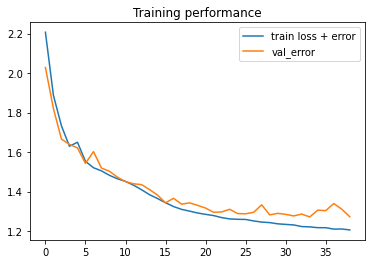

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

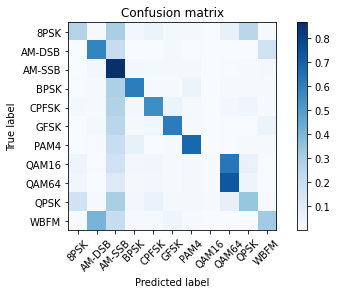

In [15]:
evaluationlib.plot_confusion_matrix(model, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08766716196136701


Overall Accuracy:  0.09500924214417746


Overall Accuracy:  0.10109579356663131


Overall Accuracy:  0.1377371749824315


Overall Accuracy:  0.17846820809248554


Overall Accuracy:  0.2534908700322234


Overall Accuracy:  0.3661769974919384


Overall Accuracy:  0.4640261627906977


Overall Accuracy:  0.5402910898118566


Overall Accuracy:  0.6441409058231489


Overall Accuracy:  0.6924473493100944


Overall Accuracy:  0.7266498377208799


Overall Accuracy:  0.7263757115749525


Overall Accuracy:  0.7354477611940299


Overall Accuracy:  0.736671469740634


Overall Accuracy:  0.7364199781261392


Overall Accuracy:  0.7338022954461311


Overall Accuracy:  0.731854080481384


Overall Accuracy:  0.7472365512159175


Overall Accuracy:  0.739426523297491


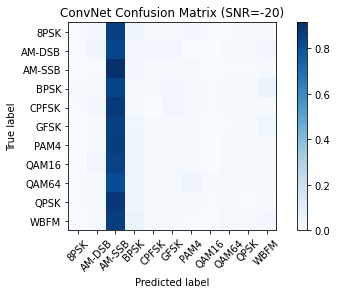

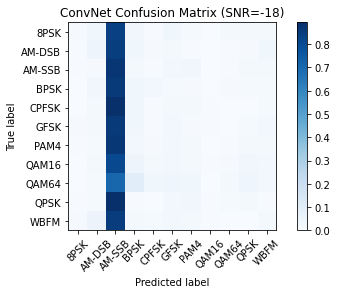

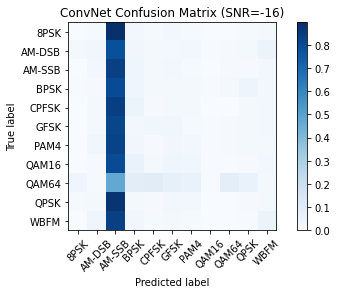

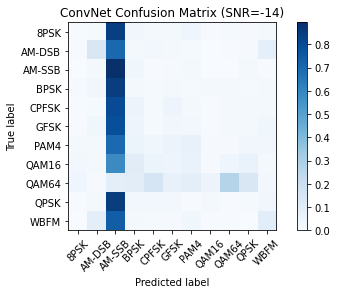

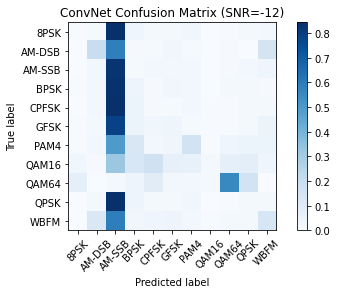

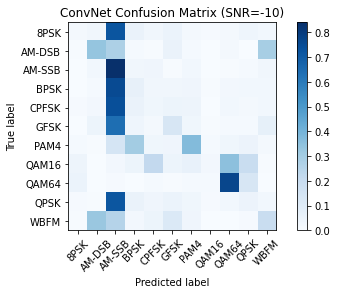

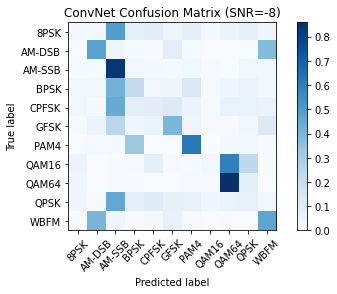

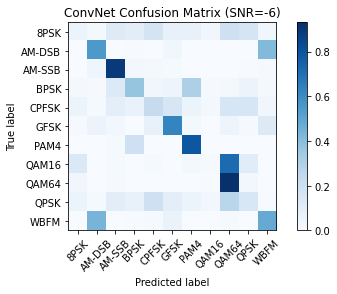

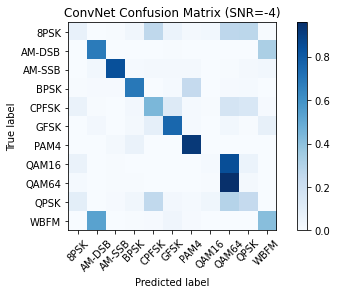

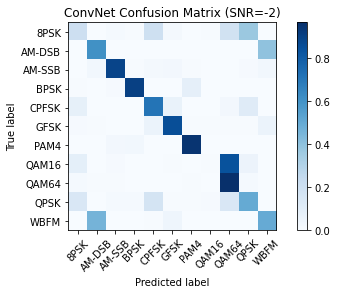

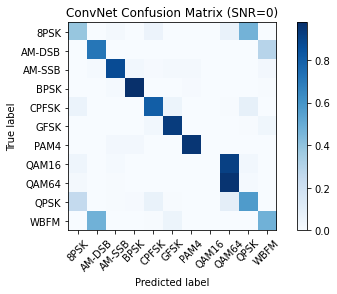

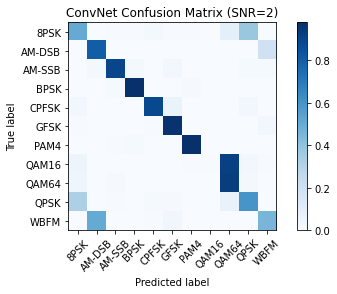

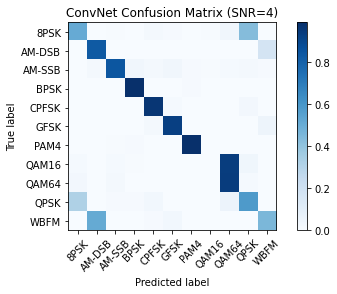

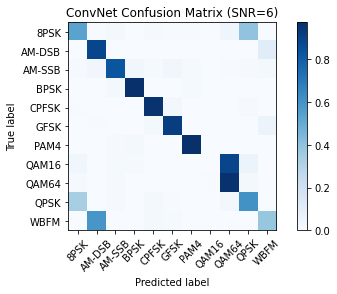

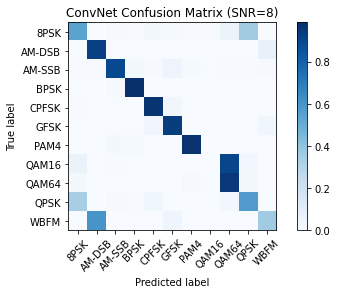

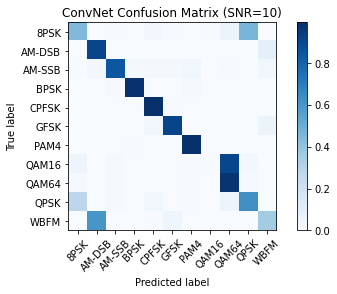

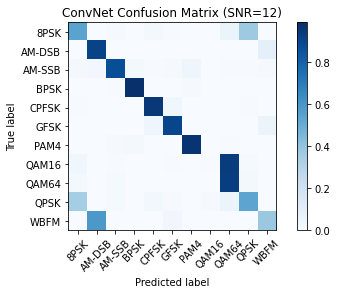

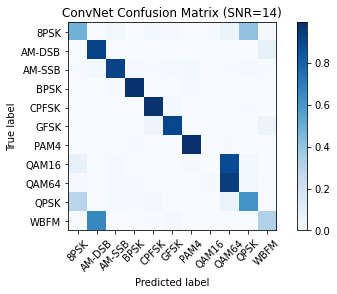

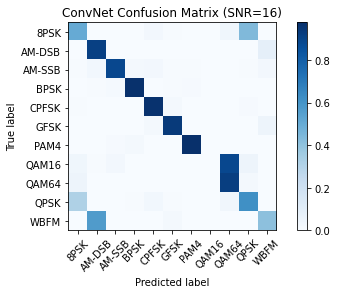

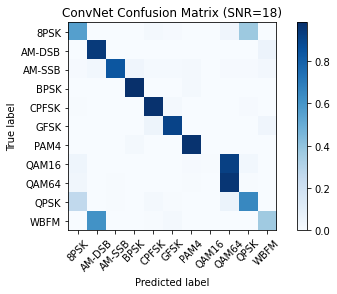

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,10,13,17,25,36,46,54,64,69,72,72,73,73,73,73,73,74,73


In [18]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )

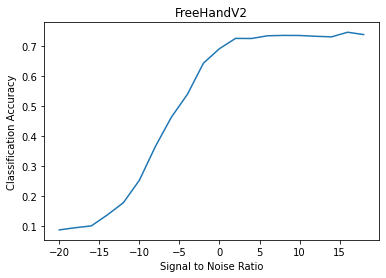

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)